In [1]:
from math import floor 

def discretize(waiting_times):
    
    return int(100000*abs(round(waiting_times[0], 1)) + 1000*abs(round(waiting_times[1], 1)) + 10*abs(round(waiting_times[2], 1)))

In [2]:
def append_packets(packet_info, queues, time):
    for i in range(len(packet_info)):
            for sublist in packet_info:
                if sublist[0] == i:
                    whole_packets = floor((time*sublist[1] - sublist[3]))
                    if whole_packets > 0:
                        queues[i].append(0)
                        #print("Appending to queue", i)
                        sublist[3] += 1
                        
def calc_reward(curr_mean_delay_best_effort, current_waiting_time, queues, action):

#   reward for clearing list
    if not any(queues):
        return 25
#   heavily penalize for choosing empty queue
    if (len(queues[action]) == 0):
        return -25
#   penalize for not popping queue 1 when it has a mean delay over 4
    elif current_waiting_time[0] < -4 and action != 0:
        return -10
#   penalize for not popping queue 2 when it has a mean delay over 6
    elif current_waiting_time[1] < -6 and action != 1:
        return -10
    else:
        if curr_mean_delay_best_effort == 0:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       reward if model improves mean_delay in best effort
        elif curr_mean_delay_best_effort < current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            return 1
#       penalize slightly if model mean_delay in best effort queue increases
        elif curr_mean_delay_best_effort > current_waiting_time[2]:
            curr_mean_delay_best_effort = current_waiting_time[2]
            reward = -1
        else:
            reward = 1

def add_time(queue):
    for i in range(len(queue)):
        queue[i] -= 1
    
        
def calc_mean_delay(queue):
    # Calculate the length and average waiting time of the current queue
    current_length = len(queue)
    current_waiting_time = np.average(queue) if current_length > 0 else 0.0
    #print(np.average(current_queue), current_length, current_waiting_time )
    current_waiting_time = np.round(current_waiting_time, 1)
    return current_waiting_time

def catch_over_ten_second_mean_delay(waiting_time):
    if waiting_time < -9.9:
        waiting_time = -9.9

def generate_random_numbers():
    random_sum = random.uniform(0.8, 1.5)  # Generate a random sum between 0.8 and 1.0
    random_numbers = []
    
    
    for _ in range(2):
        random_value = round(random.uniform(0.0, random_sum), 2)  # Generate a random value between 0.0 and the remaining sum with a maximum of one decimal place
        random_numbers.append(random_value)
        random_sum -= random_value

    random_numbers.append(round(random_sum, 1))  # Append the remaining sum to the list with a maximum of one decimal place
    if random_numbers == [0.3,0.4,0.4]: # make sure final numbers dont appear in the training phase
        random_numbers = generate_random_numbers() 
    
    return random_numbers

In [3]:
import gym
from gym import spaces
import numpy as np
from math import ceil

class TrafficGenerator(gym.Env):
    
    def __init__(self, q1rate, q2rate, q3rate):
        
        self.action_space = spaces.Discrete(3)
        
        # Define the observation space (number of packets in each queue and their waiting time)
        # Queue maximum length set to 100
        self.observation_space = spaces.Discrete(10000000)
        
        # pancket info (DataType, arrival_rate, mean_delay )
        #self.packetInfo = [[0, 0.3, 6],[1, 0.25, 4],[2, 0.4, float('inf')]]
        self.dataType = [0, 1, 2]
        self.arrival_rate = [q1rate, q2rate, q3rate]
        self.mean_delay_req = [6, 4, float('inf')]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.curr_mean_delay_best_effort = 0
        self.packet = 1
        self.timeslot = 1
        self.totaltime = self.timeslot
        
        # Initialize the queues
        self.queues = [[], [], []]
      
    
    def step(self, action):  
        self.totaltime += self.timeslot
        #print(self.totaltime)
        #print("~~~~~~~~~~~~~~~")
        #print("Action Chosen: ", action)
       
       # if action < 3 and len(self.queues[action]) > 0:
        #    self.queues[action].pop(0)

        
        #OBSERVING ENVRONEMNT
        observation = []
        
        #append_packets(self.packetInfo, self.queues, self.totaltime)
        
        for i in range(len(self.mean_delay_req)):
            #add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue
            current_waiting_time = calc_mean_delay(current_queue)
            observation.append(current_waiting_time)
            
        reward = calc_reward(self.curr_mean_delay_best_effort, observation, self.queues, action)
        
        
        
        
        #UPDATING ENVIRONMENT
        if action < 3 and len(self.queues[action]) > 0:
            self.queues[action].pop(0)
    
        append_packets(self.packetInfo, self.queues, self.totaltime)
        
        observationUpdate = []        
        for i in range(len(self.mean_delay_req)):
            add_time(self.queues[i])
            # Get the current queue for the packet type
            current_queue = self.queues[i]
            # Calculate the length and average waiting time of the current queue\
            current_waiting_time = calc_mean_delay(current_queue)
            observationUpdate.append(current_waiting_time)       
            
        
        info = {"Mean Delay Req 0": self.mean_delay_req[0],
        "Mean Delay Req 1": self.mean_delay_req[1],
        "Mean Delay Req 2": self.mean_delay_req[2],
        "arrival_rate_0": self.arrival_rate[0],
        "arrival_rate_1": self.arrival_rate[1],
        "arrival_rate_2": self.arrival_rate[2]}
        #done = len(self.queues[0]) + len(self.queues[1]) + len(self.queues[2]) == 0
        done = (self.totaltime >= 100)
        #print(observation)
        for i in range(3):
            catch_over_ten_second_mean_delay(observation[i])
        #print(f"WAITING TIMES {np.array(waiting_times)}")
        waiting_times = discretize(observationUpdate)
        
        
        
        return waiting_times, reward, done, info
        
    def reset(self):
        # Reset the queues
        self.queues = [[], [], []]
        self.packetInfo = [[elem1, elem2, elem3, 0] for elem1, elem2, elem3 in zip(self.dataType, self.arrival_rate, self.mean_delay_req)]
        self.totaltime = 1
        return [0,0,0]
    
    def change_arrival_rates(self,q1,q2,q3):
        self.arrival_rate = [q1,q2,q3]
        
    def render(self):
        pass

In [4]:
env = TrafficGenerator(0.3,0.25,0.4)
print('State space: ', env.observation_space)
print('Action space: ', env.action_space)


State space:  Discrete(10000000)
Action space:  Discrete(3)


env = TrafficGenerator()
obs = env.reset()
done = False
x = 0
while x < 100:
    print("~~~~~~~~~")
    action = env.action_space.sample()
    
    print("chosen", action)
    obs, reward, done, info = env.step(action)
    print(info)
    print(obs)
    print("reward", reward)
    
    x = x + 1

In [5]:
import random 

action_size = env.action_space.n
state_size = env.observation_space.n
qtable = np.zeros((state_size, action_size))
rewardstest = []
# Hyperparameters

total_episodes = 2500
total_test_episodes = 5
max_steps = 999
learning_rate = 0.7
gamma = 0.618
epsilon = 1.0
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.01

# Train
for episode in range(total_episodes):
    arr_rates = generate_random_numbers()
    env.change_arrival_rates(arr_rates[0], arr_rates[1], arr_rates[2])
    state = env.reset()
    total_rewards = 0
    print("Episode ", episode,"/", total_episodes )
    for step in range(max_steps):
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            action = np.argmax(qtable[state, :])
        else:
            action = env.action_space.sample()
        
        new_state, reward, done, info = env.step(action)
        total_rewards += reward
        #print(new_state)
        qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
        state = new_state
        #print(reward)
        if done: 
            rewardstest.append(total_rewards)
            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * (episode+1))




Episode  0 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, -1.0, -2.3]
[-2.0, 0.0, -3.3]
[-2.0, 0.0, -2.7]
[-3.0, 0.0, -3.0]
[-2.0, 0.0, -3.4]
[-2.0, 0.0, -4.4]
[-1.0, -1.0, -4.7]
[-2.0, -2.0, -4.3]
[-2.0, 0.0, -5.3]
[-2.0, 0.0, -5.6]
[-1.0, 0.0, -5.9]
[-2.0, 0.0, -6.9]
[-2.0, -1.0, -7.1]
[-3.0, -2.0, -6.7]
[-2.0, -3.0, -7.0]
[-3.0, -4.0, -7.3]
[-2.0, -5.0, -7.6]
[-2.0, -6.0, -7.9]
[-2.0, -1.0, -8.9]
[-1.5, -2.0, -9.2]
[-2.0, -3.0, -9.5]
[-1.0, -4.0, -10.5]
[0.0, -5.0, -10.7]
[-1.0, -6.0, -10.3]
[-2.0, -4.0, -9.9]
[-2.0, -2.0, -10.9]
[-2.0, -3.0, -11.1]
[-2.0, -4.0, -10.7]
[-3.0, -5.0, -11.0]
[-2.0, -6.0, -11.3]
[-3.0, -1.0, -11.6]
[-3.0, 0.0, -12.6]
[-4.0, 0.0, -12.8]
[-3.0, 0.0, -13.1]
[-3.0, 0.0, -13.4]
[-3.0, 0.0, -13.7]
[-4.0, -1.0, -14.0]
[-4.0, -2.0, -13.6]
[-5.0, -3.0, -13.9]
[-4.0, -4.0, -14.2]
[-5.0, -5.0, -13.7]
[-5.0, -6.0, -14.0]
[-6.0, -4.0, -13.6]
[-5.0, -5.0, -13.8]
[-5.2, -3.0, -14.2]
[-6.2, -4.0, -14.4]
[-6.3, 0.0,

[-2.0, -3.8, -2.0]
[-2.0, -4.8, 0.0]
[-2.0, -5.0, -1.0]
[-2.0, -5.3, 0.0]
[-3.0, -5.5, 0.0]
[-3.0, -5.0, 0.0]
[-4.0, -6.0, -1.0]
[-3.0, -6.1, -2.0]
[-3.0, -6.4, -3.0]
[-2.0, -7.4, -2.5]
[-3.0, -6.8, -3.5]
[-3.0, -6.2, -4.5]
[-4.0, -7.2, -2.5]
[-3.0, -7.4, -3.5]
[-4.0, -7.7, -3.0]
[-4.0, -7.9, -4.0]
[-5.0, -7.3, -3.0]
[-4.0, -7.6, -4.0]
[-4.0, -8.6, -5.0]
[-3.0, -8.8, -4.3]
[-4.0, -9.0, -5.3]
[-3.0, -9.2, -6.3]
[-3.0, -9.4, -5.8]
[-3.0, -9.6, -6.8]
[-4.0, -9.1, -7.8]
[-3.0, -9.3, -8.8]
[-3.0, -10.3, -8.0]
[-2.0, -10.5, -9.0]
[-3.0, -10.8, -8.2]
[-2.0, -11.8, -7.6]
[-3.0, -11.2, -8.6]
[-3.0, -11.5, -9.6]
[-3.0, -11.6, -9.0]
[-3.0, -11.1, -10.0]
[-4.0, -12.1, -9.4]
[-3.0, -12.3, -10.4]
[-3.0, -12.5, -9.7]
[-3.0, -13.5, -9.0]
[-4.0, -13.7, -8.2]
[-3.0, -13.9, -7.6]
[-3.0, -14.9, -8.6]
[-2.0, -15.2, -9.6]
[-3.0, -15.4, -7.4]
[-4.0, -16.4, -6.8]
[-3.7, -15.8, -7.8]
[-3.5, -16.8, -8.8]
[-3.3, -16.2, -8.0]
[-4.3, -15.7, -9.0]
[-4.2, -15.9, -10.0]
[-5.2, -16.1, -7.6]
[-4.0, -16.3, -8.6]
[-5.0, 

[-8.2, -1.0, -12.0]
[-9.2, -2.0, -12.0]
[-9.6, 0.0, -12.0]
[-10.0, 0.0, -12.0]
[-9.8, 0.0, -12.0]
[-10.2, 0.0, -12.0]
[-10.7, 0.0, -11.0]
[-11.7, 0.0, -12.0]
[-12.1, 0.0, -12.0]
[-11.8, 0.0, -13.0]
[-12.2, -1.0, -12.0]
[-12.1, -2.0, -13.0]
[-12.0, -3.0, -13.0]
[-11.8, -4.0, -14.0]
[-12.2, -5.0, -14.0]
[-12.0, -6.0, -15.0]
[-12.4, 0.0, -15.0]
[-12.8, 0.0, -15.0]
[-13.2, 0.0, -15.0]
[-13.0, 0.0, -16.0]
[-13.5, -1.0, -15.0]
[-13.9, -2.0, -16.0]
[-14.3, 0.0, -16.0]
[-14.7, 0.0, -17.0]
[-14.5, 0.0, -17.0]
[-14.4, 0.0, -18.0]
[-14.8, 0.0, -17.0]
[-15.8, 0.0, -18.0]
[-15.6, 0.0, -18.0]
[-16.0, 0.0, -18.0]
[-16.4, -1.0, -18.0]
[-16.8, 0.0, -19.0]
[-17.2, 0.0, -19.0]
[-17.7, 0.0, -19.0]
[-18.1, 0.0, -19.0]
[-17.9, 0.0, -20.0]
[-18.3, 0.0, -19.0]
[-18.1, 0.0, -20.0]
[-17.9, 0.0, -20.0]
[-18.4, 0.0, -20.0]
[-18.8, -1.0, -20.0]
[-19.2, -2.0, -21.0]
[-19.0, -3.0, -21.0]
[-19.4, 0.0, -22.0]
[-19.8, 0.0, -22.0]
[-19.6, 0.0, -23.0]
[-20.1, 0.0, -22.0]
[-20.5, 0.0, -23.0]
[-20.3, 0.0, -23.0]
[-20.1, 0.

[-26.5, 0.0, 0.0]
[-26.5, 0.0, -1.0]
[-27.0, 0.0, -2.0]
[-27.0, 0.0, -3.0]
[-27.5, 0.0, 0.0]
[-28.0, 0.0, 0.0]
[-28.0, 0.0, 0.0]
[-28.5, 0.0, 0.0]
[-28.5, 0.0, 0.0]
[-28.5, 0.0, 0.0]
[-29.0, 0.0, 0.0]
Episode  18 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -2.0, -3.0]
[0.0, -3.0, -4.0]
[0.0, -3.0, -5.0]
[-1.0, -3.2, -3.5]
[-2.0, -4.2, -2.0]
[-3.0, -3.5, -3.0]
[-1.0, -4.5, -4.0]
[-2.0, -4.6, 0.0]
[0.0, -4.8, -1.0]
[-1.0, -5.0, -2.0]
[0.0, -5.2, -3.0]
[0.0, -6.2, -4.0]
[-1.0, -6.3, -5.0]
[-2.0, -5.7, -3.5]
[-3.0, -6.7, -2.0]
[-1.0, -6.9, -3.0]
[-2.0, -6.2, -4.0]
[0.0, -7.2, -5.0]
[-1.0, -6.6, -3.5]
[-2.0, -7.6, -2.0]
[0.0, -7.8, -3.0]
[-1.0, -8.0, -4.0]
[-2.0, -8.2, -5.0]
[-3.0, -8.4, -1.0]
[-2.5, -9.4, 0.0]
[-2.0, -9.5, 0.0]
[0.0, -9.8, 0.0]
[-1.0, -9.9, 0.0]
[-2.0, -10.1, -1.0]
[0.0, -11.1, -2.0]
[-1.0, -11.2, 0.0]
[0.0, -11.4, 0.0]
[0.0, -12.4, 0.0]
[-1.0, -12.6, -1.0]
[0.0, -12.8, -2.0]
[0.0, -13.8, -3.0]
[-1.

[0.0, -14.7, -23.2]
[0.0, -14.3, -24.2]
[0.0, -14.6, -24.3]
[0.0, -15.6, -25.3]
[0.0, -15.9, -25.5]
[0.0, -16.2, -25.7]
[0.0, -16.5, -26.7]
[-1.0, -16.1, -26.8]
[0.0, -16.4, -27.8]
[0.0, -17.4, -28.0]
[0.0, -17.0, -28.2]
[0.0, -17.2, -29.2]
[0.0, -17.6, -29.3]
[0.0, -17.9, -30.3]
[0.0, -18.2, -30.5]
[0.0, -18.5, -30.7]
[0.0, -19.5, -31.7]
[0.0, -19.0, -31.8]
[-1.0, -19.3, -32.8]
[0.0, -19.6, -33.0]
[0.0, -20.6, -32.3]
[0.0, -20.9, -32.5]
[0.0, -20.5, -32.7]
[0.0, -21.5, -32.8]
[0.0, -21.1, -33.0]
[0.0, -21.4, -33.2]
[0.0, -21.7, -34.2]
[0.0, -22.0, -34.3]
[0.0, -22.3, -35.3]
[-1.0, -22.6, -34.7]
[-2.0, -22.9, -34.8]
[-3.0, -23.2, -35.0]
[0.0, -23.5, -35.2]
[0.0, -23.1, -36.2]
[0.0, -24.1, -36.3]
[0.0, -24.4, -35.7]
[0.0, -24.0, -36.7]
[0.0, -25.0, -36.8]
[0.0, -25.3, -37.0]
[0.0, -24.9, -37.2]
Episode  23 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-3.0, 0.0, -4.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[

[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-1.5, -2.0, 0.0]
[-1.5, -3.0, 0.0]
[-2.0, -4.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-5.0, -1.0, 0.0]
[-5.5, 0.0, 0.0]
[-6.0, 0.0, 0.0]
[-6.5, 0.0, 0.0]
[-6.5, -1.0, 0.0]
[-7.0, 0.0, 0.0]
[-7.0, 0.0, 0.0]
[-7.0, 0.0, 0.0]
[-7.5, -1.0, 0.0]
[-8.0, -2.0, 0.0]
[-8.5, 0.0, 0.0]
[-8.5, -1.0, 0.0]
[-8.5, -2.0, 0.0]
[-8.5, -3.0, 0.0]
[-9.0, -4.0, 0.0]
[-9.5, -3.0, 0.0]
[-9.5, -4.0, 0.0]
[-10.0, -3.0, 0.0]
[-10.5, -4.0, 0.0]
[-10.5, -3.0, 0.0]
[-10.5, -4.0, 0.0]
[-11.0, -3.0, 0.0]
[-11.0, -4.0, 0.0]
[-11.0, -3.0, 0.0]
[-11.0, -4.0, 0.0]
[-11.5, -3.0, 0.0]
[-11.5, -2.5, 0.0]
[-11.5, -3.5, 0.0]
[-11.5, -4.5, 0.0]
[-12.0, -5.5, 0.0]
[-12.0, -4.7, 0.0]
[-12.0, -5.7, 0.0]
[-12.5, -5.0, 0.0]
[-12.5, -6.0, 0.0]
[-12.5, -5.0, 0.0]
[-13.0, -4.0, 0.0]
[-13.0, -5.0, 0.0]
[-13.5, -2.5, 0.0]
[-14.0, -3.5, 0.0]
[-14.0, -4.5, 0.0]
[-14.5, -5.5, 0.0]
[-14.5, -4.7, 0.0

[0.0, -14.5, -21.9]
[0.0, -15.5, -22.1]
[0.0, -15.1, -21.7]
[0.0, -16.1, -21.3]
[0.0, -15.7, -22.3]
[0.0, -15.3, -22.6]
[-1.0, -16.3, -22.9]
[0.0, -15.9, -23.9]
[0.0, -16.9, -24.2]
[0.0, -17.9, -23.7]
[0.0, -17.5, -24.7]
[0.0, -18.5, -25.0]
[0.0, -19.5, -24.6]
[0.0, -19.1, -24.9]
[0.0, -18.8, -25.9]
[0.0, -19.8, -25.4]
[0.0, -19.4, -25.7]
[0.0, -20.4, -26.7]
[-1.0, -20.0, -27.0]
[-2.0, -19.6, -27.3]
[0.0, -20.6, -28.3]
[0.0, -20.3, -28.6]
[0.0, -21.3, -28.8]
[0.0, -22.3, -29.1]
[0.0, -21.9, -30.1]
[0.0, -21.5, -30.4]
[0.0, -22.5, -30.0]
[0.0, -20.7, -31.0]
[0.0, -20.3, -31.3]
[0.0, -19.9, -31.6]
[0.0, -19.5, -31.9]
[-1.0, -20.5, -32.1]
[0.0, -20.1, -32.4]
[0.0, -21.1, -32.7]
[0.0, -22.1, -32.3]
[0.0, -21.8, -32.6]
[0.0, -22.8, -32.8]
[0.0, -23.8, -33.8]
[0.0, -23.4, -34.1]
[0.0, -22.9, -34.4]
[0.0, -22.5, -35.4]
[0.0, -22.1, -35.7]
[0.0, -23.1, -36.0]
Episode  35 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]

[0.0, -6.5, -8.6]
[0.0, -6.8, -8.4]
[0.0, -7.8, -8.8]
[0.0, -8.0, -9.8]
[0.0, -8.3, -10.1]
[0.0, -9.3, -10.5]
[0.0, -8.7, -10.9]
[0.0, -9.0, -11.3]
[0.0, -9.3, -12.3]
[0.0, -9.5, -12.0]
[0.0, -9.8, -12.4]
[0.0, -10.0, -12.8]
[0.0, -10.2, -13.1]
[0.0, -10.5, -14.1]
[0.0, -11.5, -14.5]
[0.0, -11.7, -14.9]
[0.0, -11.3, -15.2]
[0.0, -12.3, -15.6]
[0.0, -11.7, -16.6]
[0.0, -12.0, -17.0]
[0.0, -13.0, -16.7]
[0.0, -13.2, -17.1]
[0.0, -13.5, -17.5]
[0.0, -14.5, -17.9]
[0.0, -14.7, -18.2]
[0.0, -15.0, -18.6]
[0.0, -15.3, -19.0]
[0.0, -15.5, -19.4]
[0.0, -15.8, -20.4]
[0.0, -16.8, -20.8]
[0.0, -17.0, -21.1]
[0.0, -17.3, -20.9]
[0.0, -18.3, -21.3]
[0.0, -18.5, -22.3]
[0.0, -18.8, -22.6]
[0.0, -19.8, -23.0]
[0.0, -20.0, -23.4]
[0.0, -20.3, -23.8]
[0.0, -21.3, -24.8]
[0.0, -21.5, -25.1]
[0.0, -21.8, -25.5]
[0.0, -22.8, -25.2]
[0.0, -22.2, -25.6]
[0.0, -22.5, -26.6]
[0.0, -23.5, -27.0]
[0.0, -23.7, -27.4]
[0.0, -24.0, -27.8]
[0.0, -25.0, -28.1]
[0.0, -24.5, -29.1]
[0.0, -24.8, -29.5]
[0.0, -25.8, -2

[-4.0, 0.0, 0.0]
[-4.2, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-3.7, 0.0, -3.0]
[-3.8, 0.0, -2.5]
[-3.2, 0.0, -3.5]
[-4.2, 0.0, -3.0]
[-3.5, 0.0, -2.5]
[-3.7, 0.0, -3.5]
[-3.0, 0.0, -4.5]
[-3.0, 0.0, -5.5]
[-3.0, 0.0, -3.0]
[-2.3, 0.0, -4.0]
[-2.5, 0.0, -5.0]
[-2.7, 0.0, -2.5]
[-3.7, 0.0, -3.5]
[-3.0, 0.0, -4.5]
[-2.3, 0.0, -4.0]
[-2.5, 0.0, -5.0]
[-2.7, 0.0, -4.5]
[-3.0, 0.0, -5.5]
[-2.0, 0.0, -4.7]
[-1.5, 0.0, -5.7]
[-2.0, 0.0, -6.7]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -5.3]
[-2.0, 0.0, -4.5]
Episode  46 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, -3.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.7, 0.0, 0.0]
[-4.7, 0.0, 0.0]
[-4.3, 0.0, 0.0]
[-4.2, -1.0, -1.0]
[-4.0, -2.0, -2.0]
[-3.8, -3.0, -3.0]
[-3.7, -4.0, -4.0]
[-4.7, -5.0, 0.0]
[-5.0, 0.0, 0.0]
[-4.7, 0.0, 0.0]
[-4.6, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.4, 0

[-15.5, -1.0, -3.0]
[-15.5, -2.0, -4.0]
[-15.5, -3.0, -5.0]
[-15.5, -4.0, -3.5]
[-15.5, -5.0, -4.5]
[-15.5, -6.0, -5.5]
[-15.5, -7.0, -6.5]
[-15.5, -8.0, -7.5]
[-16.0, 0.0, -6.0]
[-16.5, 0.0, -7.0]
[-16.5, 0.0, -8.0]
[-17.0, 0.0, -9.0]
[-17.0, 0.0, -10.0]
[-17.0, 0.0, -8.5]
[-17.5, 0.0, -9.5]
[-18.0, 0.0, -8.0]
[-18.0, 0.0, -9.0]
[-18.0, 0.0, -10.0]
[-18.0, 0.0, -8.5]
[-18.0, 0.0, -9.5]
[-18.0, 0.0, -10.5]
[-18.5, 0.0, -9.0]
[-18.5, 0.0, -10.0]
[-18.5, 0.0, -8.5]
[-18.5, 0.0, -9.5]
[-19.0, 0.0, -8.0]
[-19.5, 0.0, -9.0]
[-19.5, 0.0, -10.0]
[-20.0, 0.0, -8.5]
[-20.0, 0.0, -9.5]
[-20.5, 0.0, -8.0]
[-21.0, 0.0, -9.0]
[-21.5, 0.0, -7.5]
Episode  51 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-1.5, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, -1.0, 0.0]
[-3.8, 0.0, 0.0]
[-4.3, -1.0, 0.0]
[-4.1, -2.0, 0.0]
[-4.6, -3.0, 0.0]
[-4.5, -2.5, 0.0]
[-5.5, -2.0, 0.0]
[-5.4, 

[-4.0, 0.0, -3.0]
[-5.0, -1.0, -2.0]
[-4.8, -2.0, -2.0]
[-4.7, -3.0, -2.0]
[-3.3, -4.0, -3.0]
[-3.0, -5.0, -3.0]
[-2.0, -6.0, -4.0]
[-2.0, -4.0, -4.0]
[-1.0, -5.0, -5.0]
[0.0, -6.0, -5.0]
[0.0, -7.0, -6.0]
[-1.0, -8.0, -6.0]
[0.0, -9.0, -7.0]
[-1.0, -7.0, -7.0]
[-2.0, -5.0, -8.0]
[-1.0, -6.0, -8.0]
[0.0, -7.0, -9.0]
[0.0, -5.0, -9.0]
[-1.0, -6.0, -10.0]
[-2.0, -4.0, -9.0]
[-2.0, -2.0, -10.0]
[-2.0, -3.0, -10.0]
[-2.0, -4.0, -10.0]
[-3.0, -5.0, -9.0]
[-2.0, -6.0, -10.0]
[-2.0, -4.0, -10.0]
[-3.0, -5.0, -10.0]
[-2.5, -6.0, -9.0]
[-3.5, -7.0, -9.0]
[-2.0, -8.0, -9.0]
[-2.0, -9.0, -10.0]
[-1.0, -7.0, -10.0]
[-2.0, -5.0, -11.0]
[-2.0, -6.0, -10.0]
[-3.0, -7.0, -10.0]
[-4.0, -8.0, -9.0]
[-2.5, -6.3, -10.0]
[-2.0, -7.3, -10.0]
[-2.0, -5.5, -11.0]
[-2.0, -6.5, -11.0]
[-1.0, -7.5, -12.0]
[0.0, -8.5, -12.0]
[0.0, -6.7, -12.0]
[-1.0, -7.7, -12.0]
[-2.0, -8.7, -12.0]
[-1.0, -9.7, -12.0]
[0.0, -10.7, -13.0]
[-1.0, -11.7, -13.0]
[0.0, -9.8, -14.0]
[-1.0, -10.8, -14.0]
[0.0, -11.8, -15.0]
[0.0, -12.8

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.3, 0.0, 0.0]
[-3.3, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.3, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-2.7, -3.0, -3.0]
[-2.3, -4.0, -4.0]
[-3.3, -5.0, 0.0]
[-2.7, -6.0, 0.0]
[-2.3, -7.0, 0.0]
[-3.3, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.4, 0.0, -1.0]
[-4.4, 0.0, -2.0]
[-4.0, 0.0, -3.0]
[-4.3, 0.0, 0.0]
[-4.6, -1.0, 0.0]
[-4.2, -2.0, 0.0]
[-3.8, -3.0, 0.0]
[-4.8, -4.0, 0.0]
[-4.2, -5.0, 0.0]
[-3.8, -6.0, 0.0]
[-4.2, -4.0, -1.0]
[-4.4, -5.0, -2.0]
[-4.0, -6.0, -3.0]
[-4.3, -7.0, 0.0]
[-4.6, -8.0, 0.0]
[-4.2, -9.0, 0.0]
[-3.8, -10.0, 0.0]
[-4.8, -4.5, 0.0]
[-4.2, -5.5, 0.0]
[-4.5, -3.0, 0.0]
[-4.2, -4.0, -1.0]
[-5.2, -5.0, 0.0]
[-4.7, -6.0, 0.0]
[-4.3, -7.0, 0.0]
[-5.3, -1.0, 0.0]
[-4.8, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-5.5, 0.0, 0.0]
[

[-1.0, -17.1, -1.0]
[-2.0, -17.4, -2.0]
[-3.0, -17.5, 0.0]
[0.0, -17.7, 0.0]
[0.0, -18.7, 0.0]
[0.0, -18.1, -1.0]
[0.0, -18.3, 0.0]
[-1.0, -19.3, 0.0]
[0.0, -19.5, 0.0]
[0.0, -19.7, 0.0]
[0.0, -19.9, -1.0]
[0.0, -20.1, -2.0]
[0.0, -21.1, -3.0]
[0.0, -21.3, -4.0]
[-1.0, -22.3, -5.0]
[0.0, -22.4, -3.5]
[0.0, -21.9, -4.5]
[0.0, -22.0, -5.5]
[0.0, -22.2, -6.5]
[0.0, -22.4, -7.5]
[0.0, -22.6, -6.0]
[-1.0, -22.8, -7.0]
[0.0, -23.8, -8.0]
[0.0, -24.0, -9.0]
[0.0, -24.2, -10.0]
[0.0, -25.2, -8.5]
[0.0, -25.4, -9.5]
[0.0, -24.8, -10.5]
[-1.0, -25.8, -11.5]
[0.0, -26.0, -12.5]
[0.0, -27.0, -11.0]
[0.0, -27.2, -12.0]
[0.0, -27.4, -13.0]
[0.0, -27.5, -14.0]
[0.0, -26.9, -15.0]
Episode  68 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.0, 0.0, 0.0]

[-3.8, 0.0, 0.0]
[-4.8, 0.0, 0.0]
[-4.2, 0.0, -1.0]
[-3.8, 0.0, -2.0]
[-3.4, 0.0, -3.0]
[-4.4, 0.0, 0.0]
[-4.7, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.3, 0.0, 0.0]
[-4.8, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.9, 0.0, 0.0]
[-5.9, -1.0, -1.0]
[-5.4, -2.0, -2.0]
[-5.8, 0.0, -3.0]
[-6.0, 0.0, -4.0]
[-6.2, 0.0, -5.0]
[-5.9, 0.0, -6.0]
[-5.5, 0.0, -7.0]
[-6.5, 0.0, 0.0]
[-6.1, 0.0, 0.0]
[-5.8, 0.0, 0.0]
[-6.8, 0.0, -1.0]
[-7.0, 0.0, -2.0]
[-7.3, 0.0, -3.0]
[-6.9, 0.0, -4.0]
[-7.2, 0.0, -5.0]
[-6.8, 0.0, -6.0]
[-6.4, 0.0, -7.0]
[-6.8, 0.0, -8.0]
[-6.2, 0.0, -9.0]
[-5.9, 0.0, -10.0]
Episode  73 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 

[-2.0, -6.2, 0.0]
[0.0, -7.2, 0.0]
[-1.0, -6.8, 0.0]
[-2.0, -5.0, 0.0]
[-1.0, -6.0, 0.0]
[0.0, -7.0, 0.0]
[-1.0, -6.6, 0.0]
[-2.0, -6.2, 0.0]
[-3.0, -6.0, 0.0]
[-1.0, -5.5, 0.0]
[-2.0, -6.5, 0.0]
[-2.0, -6.0, 0.0]
[-3.0, -4.0, 0.0]
[-3.0, -3.5, 0.0]
[-4.0, -2.0, 0.0]
[-4.0, -3.0, 0.0]
[-3.7, -3.0, 0.0]
[-3.5, -2.5, 0.0]
[-3.3, -2.0, 0.0]
[-4.3, -3.0, 0.0]
[-3.0, -2.5, 0.0]
[-3.0, -3.5, 0.0]
[-4.0, -3.0, 0.0]
[-3.7, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-3.3, -1.0, 0.0]
[-4.3, 0.0, 0.0]
[-4.2, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-3.7, -3.0, 0.0]
[-3.5, -2.5, 0.0]
[-3.3, -2.0, 0.0]
[-4.3, -3.0, 0.0]
[-3.0, -2.5, 0.0]
[-3.0, -3.5, 0.0]
[-4.0, -3.0, 0.0]
[-3.7, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-3.3, -2.0, 0.0]
[-3.0, -3.0, 0.0]
[-3.0, -3.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-2.5, -3.0, 0.0]
[-2.0, -2.5, 0.0]
[-1.0, -3.5, 0.0]
[0.0, -4.5, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -5.0, 0.0]
Episode  78 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-

[-1.5, -3.0, -7.8]
[-2.5, 0.0, -8.8]
[-2.0, 0.0, -8.0]
[-1.5, 0.0, -9.0]
[-2.0, 0.0, -10.0]
[-1.0, -1.0, -9.3]
[0.0, -2.0, -10.3]
[-1.0, -3.0, -9.6]
[-1.0, -4.0, -9.0]
[0.0, -5.0, -10.0]
[-1.0, -6.0, -11.0]
[-1.0, -7.0, -12.0]
[0.0, -4.5, -11.3]
[-1.0, -5.5, -12.3]
[-1.5, -3.0, -13.3]
[-2.5, -4.0, -11.0]
[-2.0, -5.0, -12.0]
[-2.0, -6.0, -13.0]
[-1.0, -4.0, -12.4]
[-1.0, -5.0, -13.4]
[0.0, -6.0, -14.4]
[-1.0, -7.0, -15.4]
[-1.0, -8.0, -14.7]
[-2.0, -9.0, -14.0]
[-2.0, -7.0, -15.0]
[-1.5, -4.5, -14.3]
[-2.0, -5.5, -15.3]
[-1.0, -6.5, -16.3]
[-1.0, -7.5, -15.7]
[0.0, -8.5, -16.7]
[-1.0, -9.5, -17.7]
[0.0, -10.5, -18.7]
[-1.0, -8.0, -18.0]
[-1.5, -5.5, -19.0]
[-2.0, -6.5, -20.0]
[-1.0, -7.5, -19.3]
[-1.0, -8.5, -20.3]
[0.0, -9.5, -21.3]
[-1.0, -7.3, -19.0]
[-1.5, -8.3, -18.4]
[-2.0, -9.3, -19.4]
[-1.0, -10.3, -20.4]
[0.0, -11.3, -19.7]
[-1.0, -12.3, -19.0]
[-1.0, -13.3, -20.0]
[0.0, -11.0, -19.3]
[-1.0, -12.0, -20.3]
[-1.5, -9.7, -21.3]
[-2.5, -7.5, -20.7]
[-2.0, -8.5, -21.7]
[-1.5, -9.5, 

[0.0, -10.7, -8.2]
[0.0, -11.1, -7.6]
[-1.0, -11.4, -7.0]
[-2.0, -11.8, -6.3]
[0.0, -12.2, -5.8]
[-1.0, -12.7, -6.8]
[0.0, -13.1, -7.8]
[0.0, -13.5, -7.0]
[-1.0, -14.5, -6.2]
[-2.0, -14.9, -5.7]
[-3.0, -14.8, -6.7]
[-1.0, -15.2, -6.0]
[-2.0, -15.6, -5.3]
[-1.0, -16.0, -6.3]
[0.0, -16.4, -5.8]
[0.0, -17.4, -6.8]
[-1.0, -17.8, -7.8]
[0.0, -18.2, -8.8]
[0.0, -18.6, -8.0]
[-1.0, -18.5, -9.0]
[-2.0, -18.9, -8.2]
[-3.0, -19.3, -7.6]
[-1.0, -19.7, -8.6]
[0.0, -20.1, -9.6]
[-1.0, -20.5, -9.0]
[-2.0, -20.4, -10.0]
[-3.0, -20.8, -9.4]
[-1.0, -21.2, -10.4]
[0.0, -22.2, -9.7]
[0.0, -22.0, -10.7]
[-1.0, -22.4, -11.7]
[-2.0, -22.2, -11.0]
[0.0, -22.6, -12.0]
[-1.0, -23.1, -13.0]
[0.0, -23.5, -12.4]
[0.0, -24.5, -13.4]
[-1.0, -24.9, -12.7]
[0.0, -25.3, -13.7]
[-1.0, -25.7, -13.0]
[-2.0, -26.1, -12.3]
[0.0, -26.5, -13.3]
[-1.0, -27.5, -12.6]
[-2.0, -27.9, -12.0]
[0.0, -28.3, -13.0]
[-1.0, -28.8, -12.4]
[0.0, -29.2, -13.4]
[0.0, -29.0, -14.4]
[-1.0, -29.4, -15.4]
[0.0, -30.4, -14.7]
[-1.0, -30.8, -14.0

[-1.0, -7.5, -6.2]
[0.0, -6.0, -7.2]
[-1.0, -7.0, -7.0]
[-2.0, -5.5, -8.0]
[-1.0, -6.5, -9.0]
[-2.0, -5.3, -7.5]
[-1.0, -6.3, -8.5]
[0.0, -7.3, -8.3]
[-1.0, -6.0, -9.3]
[0.0, -7.0, -10.3]
[-1.0, -5.7, -10.0]
[-2.0, -4.5, -11.0]
[-1.0, -5.5, -10.8]
[-1.0, -6.5, -11.8]
[0.0, -7.5, -12.8]
[-1.0, -6.0, -12.5]
[-2.0, -4.5, -13.5]
[-1.0, -5.5, -13.3]
[0.0, -6.5, -14.3]
[-1.0, -7.5, -15.3]
[0.0, -6.0, -15.0]
[-1.0, -4.5, -16.0]
[-2.0, -3.0, -15.8]
[-1.0, -4.0, -16.8]
[0.0, -3.0, -17.8]
[-1.0, -4.0, -16.2]
[0.0, -5.0, -17.2]
[-1.0, -6.0, -17.0]
[0.0, -7.0, -18.0]
[-1.0, -5.7, -19.0]
[-2.0, -4.5, -18.7]
[-2.0, -3.0, -19.7]
[-2.0, -4.0, -19.5]
[-1.0, -5.0, -20.5]
[0.0, -3.5, -21.5]
[-1.0, -4.5, -20.0]
[-2.0, -5.5, -19.7]
[-2.0, -6.5, -18.3]
[-2.0, -7.5, -19.3]
[-1.0, -6.0, -20.3]
[-2.0, -7.0, -18.7]
[-2.0, -8.0, -18.5]
[-3.0, -6.5, -18.3]
[-3.0, -5.3, -18.0]
[-3.0, -6.3, -19.0]
[-2.0, -7.3, -18.7]
[-3.0, -8.3, -18.5]
[-2.0, -9.3, -18.3]
[-2.0, -8.0, -19.3]
[-1.0, -9.0, -20.3]
[0.0, -10.0, -20.0]

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-4.2, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.4, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.3, 0.0, 0.0]
[-4.7, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.3, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.4, 0.0, 0.0]
[-5.7, 0.0, 0.0]
[-6.0, 0.0, 0.0]
[-5.6, 0.0, -1.0]
[-5.4, 0.0, -2.0]
[-5.7, 0.0, -3.0]
[-5.3, 0.0, -4.0]
[-5.0, 0.0, -5.0]
[-4.7, 0.0, -6.0]
[-5.7, 0.0, -7.0]
[-5.3, 0.0, -8.0]
[-5.0, 0.0, -9.0]
[-4.7, 0.0, -10.0]
[-5.1, -1.0, -6.0]
[-5.4, -2.0, -7.0]
[-5.8, -3.0, -3.0]
[-6.1, 0.0, -4.0]
[-5.9, 0.0, -5.0]
[-6.9, 0.0, -6.0]
[-6.6, 0.0, -7.0]
[-6.9, 0.0, -8.0]
[-7.3, 0.0, -9.0]
[

[-6.3, -8.0, -9.0]
[-6.7, -9.0, -10.0]
[-6.5, -10.0, -11.0]
[-6.3, -11.0, -12.0]
[-6.2, -12.0, -11.3]
[-6.1, -13.0, -12.3]
[-6.0, -14.0, -13.3]
[-5.9, -15.0, -12.6]
[-5.8, -8.5, -13.6]
[-6.2, -9.5, -14.6]
[-6.0, -10.5, -14.0]
[-5.8, -11.5, -15.0]
[-5.7, -12.5, -16.0]
[-6.1, -13.5, -15.4]
[-6.0, -14.5, -14.7]
[-5.9, -15.5, -15.7]
[-5.8, -16.5, -16.7]
[-6.2, -17.5, -16.0]
[-6.0, -18.5, -17.0]
[-5.8, -19.5, -18.0]
[-5.7, -20.5, -17.4]
[-5.6, -21.5, -18.4]
[-5.4, -15.3, -19.4]
[-5.9, -16.3, -18.7]
[-5.8, -17.3, -18.0]
[-6.3, -11.0, -19.0]
[-7.3, -12.0, -18.3]
[-7.1, -13.0, -17.6]
[-6.9, -14.0, -18.6]
[-7.3, -15.0, -18.0]
[-7.8, -9.0, -17.4]
[-8.2, 0.0, -18.4]
[-8.1, 0.0, -19.4]
[-8.0, 0.0, -20.4]
[-9.0, 0.0, -18.0]
[-8.9, 0.0, -19.0]
[-9.3, -1.0, -20.0]
[-9.1, -2.0, -19.3]
[-9.6, 0.0, -20.3]
[-9.4, 0.0, -21.3]
[-9.3, 0.0, -20.7]
[-9.2, 0.0, -21.7]
[-10.2, 0.0, -21.0]
[-10.0, 0.0, -22.0]
[-9.8, 0.0, -21.3]
[-9.7, 0.0, -22.3]
[-9.6, 0.0, -23.3]
[-9.4, 0.0, -22.6]
[-9.3, 0.0, -23.6]
[-9.2, 0.

[0.0, -10.2, -10.8]
[0.0, -11.2, -11.8]
[0.0, -12.2, -12.8]
[0.0, -11.9, -12.5]
[-1.0, -12.9, -12.2]
[0.0, -13.9, -12.0]
[0.0, -13.5, -13.0]
[0.0, -14.5, -14.0]
[0.0, -15.5, -13.7]
[0.0, -13.7, -14.7]
[-1.0, -14.7, -14.5]
[-2.0, -14.3, -15.5]
[0.0, -13.9, -16.5]
[0.0, -14.9, -16.2]
[0.0, -14.5, -17.2]
[-1.0, -15.5, -17.0]
[0.0, -16.5, -18.0]
[0.0, -16.2, -19.0]
[0.0, -17.2, -18.7]
[0.0, -18.2, -19.7]
[-1.0, -17.8, -19.5]
[0.0, -18.8, -20.5]
[0.0, -19.8, -21.5]
[0.0, -19.4, -21.2]
[0.0, -20.4, -22.2]
Episode  111 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -1.5, -1.0]
[0.0, -1.5, -2.0]
[0.0, -1.5, -2.0]
[0.0, -2.0, -2.0]
[0.0, -2.5, -2.0]
[0.0, -3.0, -3.0]
[0.0, -2.7, -3.0]
[0.0, -2.3, -4.0]
[0.0, -2.8, -4.0]
[0.0, -3.2, -4.0]
[0.0, -3.7, -3.0]
[0.0, -4.1, -4.0]
[0.0, -4.0, -4.0]
[0.0, -4.5, -5.0]
[0.0, -4.9, -5.0]
[0.0, -5.2, -6.0]
[0.0, -5.1, -6.0]
[0.0, -5.6, -7.0]
[0.0, -5.4, -7.0]
[0.0, -5.9, -7.0]
[0.0, -6.4, -7.0]
[0.0, -6.8, -8.0]
[0.0, -7.8, -8.0]
[0.0, -8.

[-3.0, -7.5, -4.0]
[-2.8, -8.5, -5.0]
[-3.2, -7.3, -3.5]
[-3.5, -8.3, -4.5]
[-3.2, -9.3, -5.5]
[-3.6, -5.7, -6.5]
[-3.4, -6.7, -7.5]
[-3.2, -7.7, -6.0]
[-3.5, -8.7, -7.0]
[-3.8, -5.3, -8.0]
[-3.6, -6.3, -9.0]
[-3.4, -7.3, -10.0]
[-3.8, -6.0, -8.5]
[-4.2, -7.0, -9.5]
[-3.8, -5.7, -10.5]
[-3.6, -6.7, -11.5]
[-3.4, -7.7, -12.5]
[-3.2, -8.7, -11.0]
[-3.5, -7.5, -12.0]
[-3.2, -8.5, -13.0]
[-3.0, -9.5, -14.0]
[-2.8, -10.5, -15.0]
[-3.2, -11.5, -11.0]
[-3.5, -10.2, -12.0]
[-3.2, -11.2, -13.0]
[-3.0, -12.2, -14.0]
[-2.8, -13.2, -15.0]
[-3.2, -9.8, -13.5]
[-4.2, -10.8, -12.0]
[-3.8, -11.8, -13.0]
[-3.6, -12.8, -14.0]
[-4.0, -11.5, -15.0]
[-3.8, -10.2, -13.5]
[-4.2, -11.2, -14.5]
[-3.8, -12.2, -15.5]
[-3.6, -13.2, -16.5]
[-3.4, -14.2, -17.5]
[-3.2, -12.8, -16.0]
[-3.5, -13.8, -17.0]
[-3.2, -14.8, -18.0]
[-3.0, -15.8, -19.0]
[-2.8, -14.6, -20.0]
[-2.5, -15.6, -18.5]
[-3.0, -16.6, -19.5]
[-3.2, -17.6, -18.0]
[-3.0, -18.6, -19.0]
[-2.8, -17.2, -20.0]
[-2.5, -18.2, -18.5]
[-3.0, -19.2, -19.5]
[-2.7,

[0.0, -7.0, -22.6]
[0.0, -8.0, -23.0]
[-1.0, -9.0, -22.9]
[0.0, -10.0, -23.3]
[0.0, -9.0, -23.8]
[-1.0, -8.0, -24.2]
[-2.0, -9.0, -24.1]
[0.0, -10.0, -24.5]
[-1.0, -7.0, -25.0]
[0.0, -8.0, -26.0]
[0.0, -9.0, -26.4]
[0.0, -10.0, -26.9]
[-1.0, -9.0, -27.3]
[0.0, -10.0, -27.8]
[0.0, -11.0, -28.2]
[-1.0, -12.0, -28.6]
[-2.0, -9.0, -29.1]
[0.0, -10.0, -29.5]
[-1.0, -11.0, -30.0]
[0.0, -12.0, -31.0]
[0.0, -11.0, -31.4]
[0.0, -12.0, -31.9]
[-1.0, -13.0, -32.3]
[0.0, -14.0, -32.8]
[0.0, -13.0, -33.2]
[-1.0, -14.0, -33.6]
[0.0, -15.0, -34.1]
[0.0, -16.0, -34.5]
[-1.0, -15.0, -35.0]
[0.0, -16.0, -36.0]
[0.0, -17.0, -36.4]
[0.0, -18.0, -36.3]
[-1.0, -15.0, -36.8]
[0.0, -16.0, -37.2]
[0.0, -17.0, -37.7]
[-1.0, -18.0, -38.1]
[0.0, -17.0, -38.6]
[0.0, -18.0, -39.0]
[-1.0, -17.0, -39.5]
[-2.0, -18.0, -39.9]
[0.0, -17.0, -40.3]
[0.0, -18.0, -40.8]
[-1.0, -19.0, -41.2]
[0.0, -20.0, -41.7]
[0.0, -19.0, -42.1]
[-1.0, -20.0, -42.6]
[0.0, -21.0, -43.0]
[0.0, -22.0, -42.9]
Episode  123 / 2500
[0.0, 0.0, 0.0

[0.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.5]
[-4.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -4.0]
[-2.0, 0.0, -4.0]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[-1.0, 0.0, -4.5]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -5.0]
[-2.0, 0.0, -5.5]
[-3.0, 0.0, -5.5]
[-4.0, 0.0, -5.5]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -6.0]
[-3.0, 0.0, -6.0]
[0.0, 0.0, -6.5]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.5]
[0.0, 0.0, -8.0]
[0.0, 0.0, -8.0]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.5]
[0.0, 0.0, -9.5]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.5]
[0.0, 0.0, -11.0]
[0.0, 0.0, -11.5]
[0.0, 0.0, -11.5]
[-1.0, 0.0, -11.5]
[0.0, 0.0, -12.0]
[0.0, -1.0, -12.5]
[0.0, -2.0, -12.5]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -13.5]
[0.0, 0.0, -14.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.

[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-2.7, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  134 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.0, -2.0, -2.0]
[-2.0, -3.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.0, -1.0, -3.0]
[-2.3, -2.0, -2.5]
[-2.5, -3.0, -3.5]
[-2.0, -4.0, -3.3]
[-2.3, -1.0, -4.3]
[-2.5, -2.0, -5.3]
[-2.7, -3.0, -3.7]
[-3.7, -4.0, -3.5]
[-3.0, -3.0, -3.3]
[-2.3, -4.0, -4.3]
[-3.3, -3.0, -5.3]
[-2.7, -4.0, -5.0]
[-2.3, -3.0, -6.0]
[-2.5, -4.0, -5.8]
[-2.0, -5.0, -6.8]
[

[-2.0, 0.0, -1.5]
[-1.0, -1.0, -2.0]
[-2.0, -2.0, -2.5]
[-1.0, -3.0, -2.7]
[0.0, -4.0, -3.0]
[-1.0, 0.0, -4.0]
[-2.0, 0.0, -3.5]
[-1.0, 0.0, -3.8]
[-1.0, 0.0, -4.8]
[-2.0, 0.0, -5.0]
[-2.0, -1.0, -5.3]
[-3.0, 0.0, -5.6]
[-3.0, 0.0, -5.9]
[-3.0, 0.0, -6.1]
[-3.0, 0.0, -6.4]
[-3.0, 0.0, -7.4]
[-2.0, 0.0, -7.7]
[-2.0, 0.0, -8.0]
[-2.0, 0.0, -9.0]
[-3.0, -1.0, -8.5]
[-3.0, -2.0, -8.1]
[-4.0, 0.0, -8.4]
[-4.0, 0.0, -8.7]
[-5.0, 0.0, -9.0]
[-4.0, 0.0, -9.3]
[-4.2, 0.0, -10.3]
[-5.2, 0.0, -9.8]
[-4.4, 0.0, -10.1]
[-4.5, -1.0, -11.1]
[-3.8, -2.0, -11.4]
[-4.0, -3.0, -11.7]
[-3.0, -4.0, -12.0]
[-3.0, -5.0, -13.0]
[-2.0, -6.0, -13.3]
[-2.0, -7.0, -13.6]
[-2.0, -8.0, -13.9]
[-2.0, -9.0, -14.2]
[-1.0, -5.5, -14.4]
[0.0, -6.5, -15.4]
[-1.0, -7.5, -15.7]
[-2.0, -8.5, -15.3]
[-1.0, -9.5, -15.6]
[-1.0, -10.5, -16.6]
[0.0, -11.5, -16.9]
[-1.0, -12.5, -17.2]
[0.0, -13.5, -18.2]
[-1.0, -10.0, -18.4]
[0.0, -11.0, -18.7]
[-1.0, -12.0, -19.7]
[0.0, -13.0, -20.0]
[-1.0, -9.5, -20.3]
[0.0, -10.5, -20.6]
[-1.0

[-11.0, -5.0, -9.0]
[-11.0, -6.0, -10.0]
[-11.0, -7.0, -11.0]
[-11.0, -8.0, -12.0]
[-11.0, -9.0, -13.0]
[-11.0, -10.0, -14.0]
[-11.0, -11.0, -15.0]
Episode  144 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, -1.0]
[-2.0, -3.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0

[-1.5, -31.7, -42.2]
Episode  149 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[-2.0, 0.0, -3.0]
[-3.0, 0.0, -1.0]
[-2.5, -1.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.5, -2.0, -1.0]
[-3.0, -3.0, -2.0]
[-2.5, -2.5, -1.0]
[-3.5, -3.5, 0.0]
[-3.0, -4.5, 0.0]
[-1.0, -4.0, -1.0]
[-2.0, -3.5, -2.0]
[0.0, -3.3, -2.0]
[-1.0, -4.3, -2.0]
[0.0, -5.3, -3.0]
[0.0, -5.0, -2.5]
[-1.0, -6.0, -3.5]
[0.0, -7.0, -3.3]
[0.0, -5.2, -4.3]
[-1.0, -6.2, -5.3]
[0.0, -7.2, -5.0]
[0.0, -5.5, -6.0]
[-1.0, -5.0, -5.8]
[0.0, -6.0, -6.8]
[0.0, -5.5, -6.5]
[-1.0, -6.5, -6.2]
[0.0, -7.5, -7.2]
[0.0, -7.0, -7.0]
[-1.0, -8.0, -8.0]
[-2.0, -7.5, -9.0]
[0.0, -7.0, -8.7]
[-1.0, -8.0, -9.7]
[0.0, -7.7, -9.5]
[0.0, -8.7, -10.5]
[-1.0, -9.7, -11.5]
[0.0, -9.3, -11.2]
[0.0, -10.3, -12.2]
[-1.0, -11.3, -12.0]
[0.0, -10.9, -13.0]
[0.0, -10.4, -14.0]
[-1.0, -11.4, -13.7]
[0.0, -11.0, -14.7]
[-1.0, -12.0, -14.5]
[-2.0, -13.0, -14.3]
[0.0, -1

[-1.0, 0.0, -6.5]
[-2.0, 0.0, -6.5]
[0.0, 0.0, -7.0]
[0.0, 0.0, -7.0]
[0.0, 0.0, -7.0]
[0.0, 0.0, -7.5]
[-1.0, -1.0, -7.5]
[0.0, -2.0, -8.0]
[0.0, -3.0, -8.5]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.5]
[0.0, 0.0, -10.0]
[0.0, -1.0, -10.0]
[0.0, 0.0, -10.5]
[0.0, 0.0, -10.5]
[-1.0, 0.0, -10.5]
[0.0, 0.0, -11.0]
[0.0, 0.0, -11.5]
[0.0, 0.0, -11.5]
[0.0, 0.0, -11.5]
[-1.0, -1.0, -11.5]
[0.0, -2.0, -12.0]
[0.0, 0.0, -12.5]
[0.0, 0.0, -13.0]
[0.0, 0.0, -13.5]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -14.5]
[0.0, 0.0, -15.0]
[0.0, 0.0, -15.5]
[0.0, -1.0, -15.5]
[0.0, 0.0, -16.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -16.0]
[0.0, 0.0, -16.5]
[0.0, 0.0, -16.5]
[0.0, 0.0, -16.5]
[0.0, 0.0, -16.5]
[-1.0, -1.0, -16.5]
[0.0, -2.0, -17.0]
[0.0, -3.0, -17.0]
[0.0, 0.0, -17.5]
[0.0, 0.0, -18.0]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -18.5]
[0.0, -1.0, -18.5]
[0.0, -2.0, -19.0]
[0.0, -3.0, -19.5]
[-1.0, -4.0, -20.0]
[0.0, -5.0, -20.5]
[0.0, -6.0, -21.0]
[0.0, -7.0, -21.5]
[0.0, -8.0, -

[-2.0, -7.5, -9.3]
[-2.0, -5.5, -10.3]
[-2.0, -6.5, -10.0]
[0.0, -7.5, -11.0]
[-1.0, -5.5, -10.8]
[0.0, -6.5, -11.8]
[-1.0, -7.5, -12.8]
[0.0, -7.0, -12.5]
[-1.0, -8.0, -13.5]
[-2.0, -7.7, -12.0]
[0.0, -8.7, -13.0]
[-1.0, -9.7, -14.0]
[0.0, -9.3, -13.7]
[-1.0, -10.3, -14.7]
[0.0, -11.3, -14.5]
[-1.0, -10.9, -15.5]
[0.0, -11.9, -16.5]
[0.0, -12.9, -16.2]
[-1.0, -12.4, -17.2]
[-2.0, -13.4, -15.8]
[-2.0, -13.0, -16.8]
[-2.0, -12.6, -17.8]
[-2.0, -13.6, -16.2]
[-3.0, -13.1, -17.2]
[-3.0, -12.7, -17.0]
[-1.0, -13.7, -18.0]
[-2.0, -13.2, -19.0]
[-1.0, -12.8, -18.7]
[0.0, -13.8, -19.7]
[-1.0, -14.8, -19.5]
[0.0, -14.3, -20.5]
[0.0, -15.3, -21.5]
[-1.0, -16.3, -21.2]
[0.0, -15.8, -22.2]
[-1.0, -16.8, -20.8]
[0.0, -17.8, -21.8]
[-1.0, -17.3, -22.8]
[0.0, -18.3, -22.5]
[0.0, -19.3, -23.5]
[-1.0, -18.8, -23.3]
[0.0, -19.8, -24.3]
[-1.0, -20.8, -25.3]
[-2.0, -18.9, -25.0]
[-2.0, -19.9, -24.7]
[-2.0, -20.9, -24.5]
[0.0, -20.4, -25.5]
[-1.0, -20.0, -26.5]
[0.0, -21.0, -26.2]
[-1.0, -20.5, -27.2]
[0.

[-3.2, 0.0, -30.0]
[-3.0, 0.0, -31.0]
[-2.8, -1.0, -31.0]
[-3.8, 0.0, -32.0]
[-3.2, 0.0, -32.0]
[-3.6, 0.0, -32.0]
[-4.0, 0.0, -32.0]
[-4.4, 0.0, -33.0]
[-4.0, 0.0, -33.0]
[-3.6, 0.0, -34.0]
[-3.4, -1.0, -34.0]
[-3.8, -2.0, -35.0]
[-3.2, -3.0, -35.0]
[-3.6, 0.0, -36.0]
[-3.4, 0.0, -36.0]
[-3.8, 0.0, -37.0]
[-3.2, 0.0, -37.0]
[-3.0, 0.0, -38.0]
Episode  166 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[

[0.0, -26.6, -37.3]
[-1.0, -26.5, -37.6]
[0.0, -27.5, -38.0]
[0.0, -27.4, -38.4]
[0.0, -28.4, -38.8]
[-1.0, -29.4, -39.8]
[0.0, -29.2, -40.1]
[0.0, -30.2, -40.5]
[0.0, -30.1, -40.9]
[0.0, -30.0, -41.3]
[-1.0, -29.9, -42.3]
[-2.0, -30.9, -42.0]
[-3.0, -30.8, -41.7]
[0.0, -31.8, -42.1]
Episode  171 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -2.5]
[0.0, -2.0, -3.0]
[0.0, -3.0, -3.0]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.5]
[0.0, -3.0, -3.5]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.5]
[-1.0, 0.0, -4.5]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.5]
[0.0, -1.0, -5.5]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, -1.0, -6.0]
[0.0, 0.0, -6.5]
[-1.0, 0.0, -6.5]
[-2.0, 0.0, -6.5]
[0.0, -1.0, -7.0]
[0.0, -2.0, -7.0]
[0.0, -3.0, -7.0]
[0.0, -2.5, -7.0]
[0.0, -2.0, -7.5]
[0.0, -3.0, -8.0]
[0.0, -2.5, -8.0]
[0.0, -3.5, -8.5]
[-1.0, -

[-2.3, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.3, -1.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.5, 0.0, -2.0]
[-3.8, -1.0, -3.0]
[-4.0, -2.0, -4.0]
[-3.0, -3.0, -5.0]
[-4.0, -2.5, 0.0]
[-4.0, -2.0, 0.0]
[-5.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.2, -1.0, 0.0]
[-3.3, -2.0, 0.0]
[-2.7, -3.0, 0.0]
[-3.0, -2.5, 0.0]
[-2.0, -3.5, 0.0]
[-3.0, 

[0.0, -7.3, -8.0]
[0.0, -8.3, -6.5]
[0.0, -8.5, -7.5]
Episode  181 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.0, -3.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.3, -1.0, -1.0]
[-2.5, -2.0, -2.0]
[-2.7, -3.0, 0.0]
[-3.7, -4.0, 0.0]
[-3.0, -

[-7.1, -21.5, -12.0]
[-7.0, -22.5, -13.0]
[-6.9, -23.5, -14.0]
[-6.8, -24.5, -15.0]
Episode  187 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, -1.0]
[-4.5, 0.0, -2.0]
[-4.5, 0.0, -3.0]
[-5.0, 0.0, -4.0]
[-5.0, 0.0, -5.0]
[-5.0, -1.0, -3.5]
[-5.0, -2.0, -4.5]
[-5.5, 0.0, -5.5]
[-5.5, 0.0, -6.5]
[-5.5, 0.0, -7.5]
[-6.0, 0.0, -6.0]
[-6.0, 0.0, -7.0]
[-6.0, 0.0, -8.0]
[-6.0, 0.0, -9.0]
[-6.0, 0.0, -10.0]
[-6.0, 0.0, -8.5]
[-6.0, 0.0, -9.5]
[-6.0, 0.0, -10.5]
[-6.0, -1.0, -11.5]
[-6.0, -2.0, -12.5]
[-6.0, -3.0, -11.0]
[-6.0, -4.0, -12.0]
[-6.0, -5.0, -13.0]
[-6.0, -6.0, -14.0]
[-6.0, -7.0, -15.0]
[-6.0, -8.0, -13.5]
[-6.0, -9.0, -14.5]
[-6.0, -10.0, -15.5]
[-6.0, -11.0, -16.5]
[-6.0, -12.0, -17.5

[-4.0, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.2, 0.0, -1.0]
[-4.2, 0.0, 0.0]
[-3.5, 0.0, 0.0]
Episode  193 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.5, 0.0]
[-2.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-3.0, -2.5, 0.0]
[-1.0, -3.0, 0.0]
[-2.0, -3.0, 0.0]
[-3.0, -3.0, 0.0]
[-2.5, -3.0, 0.0]
[-3.5, -3.5, 0.0]
[-3.0, -4.0, 0.0]
[-2.5, -4.5, 0.0]
[-2.0, -4.9, 0.0]
[0.0, -5.2, 0.0]
[-1.0, -5.1, 0.0]
[0.0, -5.6, 0.0]
[0.0, -5.4, 0.0]
[-1.0, -5.3, 0.0]
[0.0, -5.8, 0.0]
[0.0, -5.7, 0.0]
[-1.0, -5.6, 0.0]
[0.0, -6.1, 0.0]
[0.0, -6.0, 0.0]
[-1.0, -6.0, 0.0]
[0.0, -6.5, 0.0]
[0.0, -7.0, 0.0]
[-1.0, -6.9, 0.0]
[0.0, -7.3, 0.0]
[0.0, -7.2, 0.0]
[-1.0, -7.2, 0.0]
[0.0, -7.6, 0.0]
[0.0, -7.5, 0.0]
[-1.0, -8.0, 0.0]
[-2.0, -7.9, 0.0]
[0.0, -8.4, 0.0]
[-1.0, -8.3, 0.0]
[0.0, -8.8, 0.0]
[0.0, -9.3, 0.0]
[-1.0, -9.8, 0.0]
[0.0, -10.8, 0.0]
[0.0, -10.7, 0.0]
[-1.0, -11.1, 0.0]
[0.0, -11.6, 0.0]
[0.0, -11.4, 0.0]
[-1.0, -11.4, 0.0]
[-2.0, -11.2,

Episode  199 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.3, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.3, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.8, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.2, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.8, -1.0, 0.0]
[-4.2, -2.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, -2.0, 0.0]
[-4.4, -3.0, 0.0]
[-4.0, -2.5, 0.0]
[-4.3, -3.5, 0.0]
[-4.6, -3.3, 0.0]
[-4.2, -4.3, 0.0]
[-3.8, -4.2, 0.0]
[-4.0, -5.2, 0.0]
[-3.5, -5.2, 0.0]
[-3.0, -6.2, 0.0]
[-3.3, -6.2, 0.0]
[-2.7, -7.2, 0.0]
[-3.0, -6.0, 0.0]
[-4.0, -7.0, 0.0]
[-3.5, -8.0, 0.0]
[-3.8, -6.8, 0.0]
[-4.0, -7.8, 0.0]
[-3.5, -7.7, 0.0]
[-3.0, -8.7, 0.0]
[-3.3, -8.6, 0.0]
[-2.7, -9.6, 0.0]
[-3.0, -8.5, 0.0]
[-4.0, -8.4, 0.0]
[-3.5, -8.4, 0.0]
[-3.8, -8.3, 0.0]
[-3.4, -8.2, 0.0]
[-3.8, -9.2, 0.0]
[-3.2, -10.2, 0.0]
[-3.0, -10.1, 0.0]
[-4.0, -10.0, 0.0]
[-3.5, -9.9, 0.

[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[-2.0, -3.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.7, 0.0, 0.

[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
Episode  212 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-3.0, 0

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, -1.0, 0.0]
[-5.0, -2.0, 0.0]
[-5.0, -3.0, 0.0]
[-5.0, -4.0, 0.0]
[-5.0, -5.0, 0.0]
[-5.0, -6.0, 0.0]
[-5.0, -7.0, 0.0]
[-5.0, -4.5, 0.0]
[-5.5, -5.5, 0.0]
[-5.5, -6.5, 0.0]
[-5.5, -7.5, 0.0]
[-5.5, -8.5, 0.0]
[-5.5, -9.5, 0.0]
[-5.5, -10.5, 0.0]
[-5.5, -11.5, 0.0]
[-5.5, -8.7, 0.0]
[-5.5, -9.7, 0.0]
[-5.5, -10.7, 0.0]
[-5.5, -11.7, 0.0]
[-5.5, -12.7, 0.0]
[-5.5, -13.7, 0.0]
[-5.5, -14.7, 0.0]
[-5.5, -12.0, 0.0]
[-5.5, -13.0, 0.0]
[-5.5, -14.0, 0.0]
[-5.5, -

Episode  227 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, -1.

[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  232 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0,

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-5.0, -1.0, 0.0]
[-5.0, -2.0, 0.0]
[-5.0, -3.0, 0.0]
[-5.0, -4.0, 0.0]
[-5.0, -5.0, 0.0]
[-5.0, -6.0, 0.0]
[-5.0, -7.0, 0.0]
[-5.5, -1.0, 0.0]
[-5.5, -2.0, 0.0]
[-5.5, -3.0, 0.0]
[-5.5, -4.0, 0.0]
[-6.0, -5.0, 0.0]
[-5.9, -6.0, 0.0]
[-5.8, -7.0, 0.0]
[-6.2, -1.0, 0.0]
[-6.1, -2.0, 0.0]
[-6.0, -3.0, 0.0]
[-5.9, -4.0, 0.0]
[-5.8, -5.0, 0.0]
[-6.3,

[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.0]
Episode  251 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[-2.0, -1.5, 0.0]
[0.0, -2.5, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, -2.0, -2.0]
[-3.0, -

[-2.0, -4.9, 0.0]
[-1.0, -5.2, -1.0]
[-2.0, -5.0, -2.0]
[0.0, -5.4, -3.0]
[-1.0, -6.4, -4.0]
[0.0, -6.8, -5.0]
[-1.0, -6.6, -6.0]
[-2.0, -6.4, -7.0]
[-1.0, -6.8, -8.0]
[0.0, -7.8, -9.0]
[-1.0, -8.2, 0.0]
[0.0, -8.5, -1.0]
[0.0, -8.3, -2.0]
[-1.0, -8.1, -3.0]
[0.0, -8.5, -4.0]
[-1.0, -8.9, -5.0]
[-2.0, -8.7, -6.0]
[-1.0, -9.1, -7.0]
[-2.0, -8.9, -8.0]
[-1.0, -9.3, -9.0]
[-2.0, -9.6, -10.0]
[-1.0, -10.0, -6.0]
[0.0, -10.4, -7.0]
[0.0, -10.8, -8.0]
[-1.0, -11.2, -4.0]
[0.0, -11.6, -5.0]
[-1.0, -12.6, -6.0]
[0.0, -13.0, -7.0]
[-1.0, -13.3, -8.0]
[0.0, -13.7, -9.0]
[-1.0, -14.1, -10.0]
[0.0, -14.5, -6.0]
[0.0, -14.9, -7.0]
[-1.0, -14.7, -8.0]
[0.0, -15.1, -9.0]
[-1.0, -15.5, -10.0]
[0.0, -15.9, -11.0]
[-1.0, -16.9, -12.0]
[0.0, -17.3, -13.0]
[-1.0, -17.0, -14.0]
[0.0, -17.4, -15.0]
[-1.0, -17.8, -6.0]
[0.0, -18.2, -7.0]
[0.0, -18.6, -8.0]
[-1.0, -18.4, -9.0]
[0.0, -18.8, -10.0]
[-1.0, -18.6, -11.0]
[-2.0, -18.4, -12.0]
[-1.0, -19.4, -13.0]
[-2.0, -19.1, -14.0]
[-2.0, -18.9, -15.0]
[-2.0, -1

[-1.0, -4.8, -10.5]
[0.0, -5.8, -11.5]
[0.0, -5.6, -11.2]
[0.0, -6.6, -12.2]
[-1.0, -6.5, -12.0]
[0.0, -7.5, -13.0]
[0.0, -8.5, -14.0]
[0.0, -8.3, -13.7]
[-1.0, -9.3, -14.7]
[0.0, -9.1, -14.5]
[0.0, -9.0, -15.5]
[0.0, -8.9, -16.5]
[0.0, -9.9, -16.2]
[-1.0, -10.9, -17.2]
[-2.0, -9.5, -17.0]
[0.0, -10.5, -18.0]
[0.0, -10.3, -19.0]
[-1.0, -11.3, -18.7]
[0.0, -11.2, -19.7]
[0.0, -11.0, -19.5]
[0.0, -12.0, -19.3]
[-1.0, -10.7, -20.3]
[0.0, -11.7, -20.0]
[0.0, -11.5, -21.0]
[0.0, -12.5, -20.8]
[0.0, -12.4, -21.8]
[-1.0, -13.4, -22.8]
[0.0, -14.4, -22.5]
[0.0, -14.2, -23.5]
[0.0, -15.2, -23.3]
[-1.0, -15.0, -24.3]
[0.0, -16.0, -25.3]
[0.0, -15.9, -25.0]
[0.0, -16.9, -26.0]
Episode  261 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.3]
[-1.0, 0.0, -3.3]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0

[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
Episode  266 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0

[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.5]
[-4.0, 0.0, -2.5]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.2]
[0.0, 0.0, -3.6]
[0.0, 0.0, -4.0]
[0.0, 0.0, -3.8]
[0.0, 0.0, -3.7]
[-1.0, 0.0, -3.5]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.3]
[-1.0, 0.0, -4.2]
[0.0, 0.0, -4.6]
[0.0, 0.0, -4.4]
[0.0, 0.0, -4.3]
[0.0, 0.0, -4.1]
[-1.0, 0.0, -4.6]
[-2.0, 0.0, -5.1]
[0.0, 0.0, -5.6]
[0.0, 0.0, -6.6]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.8]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.1]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.4]
[0.0, 0.0, -7.3]
[0.0, 0.0, -7.8]
[0.0, 0.0, -8.2]
[0.0, 0.0, -8.6]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.4]
[0.0, 0.0, -9.3]
[0.0, 0.0, -9.8]
[0.0, 0.0, -9.6]
[-1.0, 0.0, -10.1]
[0.0, 0.0, -10.6]
[0.0, 0.0, -11.6]
[0.0, 0.0, -12.0]
[0.0, 0.0, -11.8]
[-1.0, 0.0, -12.3]
[0.0, 0.0, -12.7]
[0.0, 0.0, -13.2]
[0.0, 0.0, -13.6]
[0.0, 0.0, -13.5]
[-1.0, 0.0, -13.5]
[0.0, 0.0, -13.9]
[0.0, 0.0, -14.9]
[0.0, 0.0, -15.3]
[0

[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  277 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.5, 0.0]
[-3.0, -2.0, 0.0]
[-4.0, -1.

[0.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-2.0, 0.0, -3.0]
[-3.0, 0.0, -1.0]
[-4.0, -1.0, 0.0]
[-5.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -3.0]
[-1.0, -2.0, -1.0]
[-2.0, -2.0, 0.0]
[-3.0, -2.0, -1.0]
[-4.0, -3.0, 0.0]
[-5.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -2.0, 0.0]
[-1.0, -3.0, -1.0]
[0.0, -2.5, -2.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[0.0, -1.0, -3.0]
[-1.0, -2.0, -1.0]
[-2.0, -3.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[-5.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, -3.0, -2.0]
[0.0, -2.5, -2.

[-2.5, -20.2, -27.0]
[-3.0, -19.4, -28.0]
[-2.7, -20.4, -29.0]
[-2.3, -21.4, -30.0]
[-2.0, -22.4, -26.0]
[-2.0, -21.5, -27.0]
[-2.0, -22.5, -28.0]
[-2.0, -23.5, -29.0]
[-2.0, -24.5, -30.0]
[-2.0, -23.6, -31.0]
[-2.0, -24.6, -32.0]
[-2.0, -25.6, -33.0]
[-2.5, -24.8, -34.0]
[-2.0, -25.8, -35.0]
[-1.5, -26.8, -31.0]
[-1.5, -27.8, -32.0]
[-1.5, -26.9, -33.0]
[-1.5, -27.9, -34.0]
[-1.5, -28.9, -35.0]
[-1.5, -29.9, -36.0]
[-1.5, -29.1, -37.0]
[-2.0, -28.2, -38.0]
[-2.0, -29.2, -39.0]
[-2.5, -28.4, -40.0]
[-2.0, -29.4, -36.0]
[-1.5, -30.4, -37.0]
[-1.5, -31.4, -38.0]
[-1.5, -30.5, -39.0]
[-1.5, -31.5, -40.0]
[-1.5, -32.5, -41.0]
[-1.5, -33.5, -42.0]
[-1.5, -32.7, -43.0]
[-1.5, -33.7, -44.0]
[-1.5, -34.7, -45.0]
Episode  289 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, -1.0]
[-2.0, -2.0, 0.0]
[-3.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.3, -1.0]
[0.0

[-3.8, -1.0, 0.0]
[-4.0, -1.5, 0.0]
[-3.0, -2.5, 0.0]
[-2.3, -2.7, 0.0]
[-2.5, -3.0, 0.0]
[-2.7, -2.8, 0.0]
[-3.0, -3.8, 0.0]
[-2.0, -4.0, 0.0]
[-2.3, -3.6, 0.0]
[-2.5, -4.6, 0.0]
[-2.0, -4.8, 0.0]
[-2.0, -5.1, 0.0]
[-1.0, -6.1, 0.0]
[0.0, -6.4, 0.0]
[-1.0, -6.7, 0.0]
[-1.5, -7.0, 0.0]
[-2.5, -6.5, 0.0]
[-2.0, -6.8, 0.0]
[-3.0, -6.3, 0.0]
[-2.0, -7.3, 0.0]
[-2.0, -7.6, 0.0]
[-2.0, -7.2, 0.0]
[-2.3, -7.4, 0.0]
[-2.5, -7.7, 0.0]
[-2.0, -8.0, 0.0]
[-3.0, -8.3, 0.0]
[-3.0, -7.8, 0.0]
[-3.2, -7.4, 0.0]
[-3.3, -8.4, 0.0]
[-2.7, -8.6, 0.0]
[-3.0, -8.9, 0.0]
[-3.0, -9.2, 0.0]
[-4.0, -8.7, 0.0]
[-3.0, -9.0, 0.0]
[-3.2, -8.6, 0.0]
[-3.3, -9.6, 0.0]
[-2.7, -9.8, 0.0]
[-3.0, -10.1, 0.0]
[-3.0, -10.4, 0.0]
[-3.0, -10.6, 0.0]
[-2.0, -10.9, 0.0]
[-2.3, -11.2, 0.0]
[-2.5, -11.5, 0.0]
[-2.0, -11.8, 0.0]
[-2.0, -12.8, 0.0]
[-1.0, -13.0, 0.0]
[-1.5, -12.5, 0.0]
[-2.0, -12.8, 0.0]
[-2.0, -13.1, 0.0]
[-2.0, -13.4, 0.0]
[-1.0, -13.7, 0.0]
[0.0, -14.7, 0.0]
[-1.0, -14.2, 0.0]
[-1.5, -13.8, 0.0]
[-2.0, -14.8,

[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.0, 0.0]
[-4.5, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.5, -4.0, 0.0]
[-4.5, -5.0, 0.0]
[-4.5, -6.0, 0.0]
[-4.5, -7.0, 0.0]
[-5.0, -8.0, 0.0]
[-5.0, -5.0, 0.0]
[-5.5, -2.0, 0.0]
[-5.5, -3.0, 0.0]
[-5.5, -4.0, 0.0]
[-5.5, -5.0, 0.0]
[-5.5, -6.0, 0.0]
[-5.5, -7.0, 0.0]
[-5.5, -8.0, 0.0]
[-6.0, -1.0, 0.0]
[-6.0, -2.0, 0.0]
[-6.0, -3.0, 0.0]
[-6.0, -4.0, 0.0]
[-6.0, -5.0, 0.0]
[-6.0, -6.0, 0.0]
[-6.0, -7.0, 0.0]
[-6.5, 0.0, 0.0]
[-6.5, 0.0, 0.0]
[-7.0

[-1.0, 0.0, -16.5]
[0.0, 0.0, -17.0]
[0.0, 0.0, -17.0]
[-1.0, 0.0, -17.0]
[0.0, 0.0, -17.5]
[0.0, 0.0, -17.5]
[0.0, 0.0, -17.5]
[-1.0, 0.0, -17.5]
[0.0, -1.0, -18.0]
[0.0, -2.0, -18.5]
[0.0, -3.0, -19.0]
[-1.0, 0.0, -19.5]
[0.0, 0.0, -20.0]
[0.0, 0.0, -20.0]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -20.5]
[0.0, 0.0, -20.5]
[0.0, 0.0, -20.5]
[-1.0, -1.0, -20.5]
[-2.0, -2.0, -20.5]
[0.0, -3.0, -21.0]
[-1.0, 0.0, -21.5]
[0.0, 0.0, -22.0]
[0.0, 0.0, -22.0]
[0.0, 0.0, -22.0]
[-1.0, 0.0, -22.0]
[0.0, 0.0, -22.5]
[0.0, 0.0, -22.5]
Episode  306 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -3.

[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[-2.0, -3.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, -1.0]
[-2.0, -3.0, -2.0]
[-2.0, -4.0, -3.0]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, -1.0, -3.0]
[-3.0, -2.0, -1.0]
[-3.0, -3.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[-3.2, -2.0, 0.0]
[-4.2, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.0, 0.0, -3.0]
[-4.0, 0.0, -1.0]
[-4

[-4.0, -17.5, -16.3]
[-4.0, -15.0, -15.7]
[-4.0, -16.0, -16.7]
[-4.0, -17.0, -17.7]
[-4.0, -18.0, -18.7]
[-4.0, -19.0, -18.0]
[-4.0, -20.0, -19.0]
[-4.0, -21.0, -20.0]
[-4.0, -22.0, -19.3]
[-4.0, -19.3, -20.3]
[-4.0, -20.3, -21.3]
[-4.0, -21.3, -20.7]
[-4.0, -22.3, -21.7]
[-4.5, -19.8, -22.7]
[-4.5, -20.8, -23.7]
[-4.5, -21.8, -23.0]
[-4.5, -19.2, -24.0]
[-4.5, -20.2, -25.0]
[-5.0, -21.2, -24.3]
[-4.9, -22.2, -25.3]
[-4.7, -23.2, -26.3]
[-4.6, -24.2, -25.7]
[-4.4, -25.2, -26.7]
[-4.3, -22.6, -27.7]
[-4.1, -23.6, -28.7]
[-4.0, -24.6, -28.0]
[-4.0, -25.6, -29.0]
[-4.0, -26.6, -30.0]
[-4.0, -27.6, -29.3]
[-4.0, -28.6, -30.3]
[-4.0, -26.0, -31.3]
[-4.0, -27.0, -30.7]
[-4.0, -28.0, -31.7]
[-4.0, -29.0, -32.7]
[-4.0, -30.0, -33.7]
[-4.0, -31.0, -33.0]
[-4.0, -32.0, -34.0]
[-4.0, -29.4, -35.0]
[-4.0, -30.4, -34.3]
[-4.0, -31.4, -35.3]
[-4.0, -32.4, -36.3]
[-4.0, -33.4, -35.7]
[-4.0, -34.4, -36.7]
[-4.0, -35.4, -37.7]
[-4.0, -32.9, -38.7]
[-4.0, -33.9, -38.0]
[-4.0, -34.9, -39.0]
[-4.0, -35.9,

[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -2.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, -1.0, 0.0]
Episode  321 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[-1.0, -1.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[-1.0, -1.0, -2.7]
[0.0, -2.0, -3.0]
[0.0, -2.0, -2.8]
[-1.0, -3.0, -3.8]
[0.0, -3.0, -4.0]
[0.0, -3.0, -4.3]
[0.0, -2.0, -5.3]
[-1.0, -3.0, -5.6]
[0.0, -3.0, -5.9]
[0.0, -4.0, -6.9]
[-1.0, -4.0, -7.1]
[0.0, -5.0, -7.4]
[0.0, -5.0, -7.0]
[0.0, -5.0, -8.0]
[-1.0, -4.0, -8.3]
[0.0, -5.0, -8.6]
[0.0, -5.0, -9.6]
[-1.0, -6.0, -9.8]
[0.0, -6.0, -10.1]
[0.0, -7.0, -11.1]
[0.0, -7.0, -11.4]
[-1.0, -8.0, -11.7]
[0.0, -8.0, -12.0]
[0.0, -8.0, -13.0]
[0.0, -7.0, -13.3]
[-1.0, -8.0, -13.6]
[0.0, -8.0, -14.6]
[0.0, -9.0, -14.8]
[-1.0, -9.0, -15.1]
[-2.0, -9.0, -16.1]
[0.0, -9.0, -16.4]
[0.0, -10.0, -16.7]
[-1.0, -10.0, -17.0]
[-2.0, -10.0, -18.0]
[-3.0,

[-2.0, -6.2, 0.0]
[-2.0, -4.8, -1.0]
[-2.0, -5.8, -2.0]
[-1.0, -6.8, -3.0]
[0.0, -6.4, -4.0]
[-1.0, -6.0, -5.0]
[0.0, -5.8, -3.5]
[0.0, -5.5, -4.5]
[-1.0, -5.3, -5.5]
[0.0, -5.0, -6.5]
[-1.0, -6.0, -7.5]
[0.0, -5.8, -6.0]
[-1.0, -6.8, -7.0]
[0.0, -7.8, -8.0]
[-1.0, -6.2, -9.0]
[0.0, -7.2, -10.0]
Episode  328 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-1.5, -1.0, -2.0]
[-2.0, -2.0, -3.0]
[-2.0, -3.0, -1.0]
[-2.3, -1.0, -2.0]
[-2.5, -2.0, -3.0]
[-2.0, -3.0, -4.0]
[-1.5, -4.0, -3.0]
[-2.0, -3.0, -4.0]
[-1.0, -4.0, -5.0]
[-1.5, -5.0, -2.5]
[-2.0, -4.3, -3.5]
[-1.0, -5.3, -4.5]
[-1.0, -6.3, -4.0]
[0.0, -7.3, -5.0]
[-1.0, -6.5, -6.0]
[-1.0, -7.5, -7.0]
[0.0, -8.5, -6.2]
[-1.0, -7.8, -7.2]
[-1.0, -8.8, -8.2]
[0.0, -9.8, -7.6]
[-1.0, -10.8, -8.6]
[-1.0, -10.0, -9.6]
[0.0, -11.0, -9.0]
[-1.0, -10.2, -10.0]
[-1.5, -9.5, -11.0]
[-2.0, -8.6, -12.0]
[-2.0, -7.8, -11.3]
[-2.3, -8.8, -10.7]
[-2.5, -8.0, -11.7]
[-2.0

[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-4.0, 0.0, -1.0]
[-5.0, -1.0, 0.0]
[-6.0, -2.0, -1.0]
[-7.0, -3.0, 0.0]
[0.0, -2.5, -1.0]
[0.0, -2.0, -2.0]
Episode  337 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]

[-1.0, -14.7, -21.5]
[-1.0, -15.7, -22.5]
[0.0, -15.7, -21.0]
[-1.0, -15.6, -22.0]
[-1.5, -14.6, -23.0]
[-2.0, -15.6, -24.0]
[-2.0, -14.5, -25.0]
[-2.0, -15.5, -23.5]
[-1.0, -15.5, -24.5]
[-1.0, -16.5, -25.5]
[0.0, -16.4, -26.5]
[-1.0, -17.4, -27.5]
[-1.0, -17.4, -26.0]
[0.0, -18.4, -27.0]
[-1.0, -17.4, -28.0]
[-2.0, -17.3, -29.0]
[-1.0, -17.3, -30.0]
[-1.5, -17.2, -28.5]
[-2.0, -17.2, -29.5]
[-1.0, -18.2, -30.5]
[-1.5, -17.2, -31.5]
[-2.0, -18.2, -32.5]
[-1.0, -18.2, -31.0]
[-1.0, -19.2, -32.0]
[0.0, -19.2, -33.0]
[-1.0, -20.2, -34.0]
[-2.0, -19.1, -35.0]
[-1.0, -20.1, -33.5]
[-1.0, -20.1, -34.5]
[0.0, -21.1, -35.5]
[-1.0, -21.1, -36.5]
[-1.0, -22.1, -37.5]
[-2.0, -21.0, -36.0]
[-1.0, -22.0, -37.0]
[0.0, -22.0, -38.0]
[-1.0, -23.0, -39.0]
[-1.0, -23.0, -40.0]
[0.0, -24.0, -38.5]
[-1.0, -24.0, -39.5]
[-1.0, -25.0, -40.5]
[-2.0, -24.0, -41.5]
[-1.0, -25.0, -42.5]
Episode  342 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  349 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.5, -1.0]
[0.0, -2.0, -2.0]
[0.0, -1.5, -3.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[-5.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.3, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, -1.0]
[0.0, -2.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, -1.0, -4.0]
[0.0, 0.0,

[0.0, -1.5, -6.0]
[0.0, -2.0, -7.0]
[0.0, -3.0, -4.7]
[0.0, -2.7, -5.7]
[0.0, -3.0, -6.7]
[0.0, -3.3, -6.0]
[0.0, -3.5, -7.0]
[0.0, -3.8, -6.3]
Episode  357 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-2.0, 0.0, -3.0]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1

[-1.0, -23.0, -33.8]
[0.0, -23.0, -34.0]
[0.0, -24.0, -35.0]
[-1.0, -23.0, -35.2]
[0.0, -24.0, -36.2]
[0.0, -24.0, -36.3]
[-1.0, -24.0, -36.5]
[0.0, -24.0, -37.5]
[0.0, -24.0, -37.7]
[-1.0, -24.0, -38.7]
[0.0, -25.0, -38.8]
[0.0, -25.0, -39.0]
[-1.0, -25.0, -40.0]
[0.0, -25.0, -40.2]
[0.0, -26.0, -41.2]
[-1.0, -26.0, -41.3]
[-2.0, -26.0, -41.5]
[0.0, -26.0, -42.5]
[-1.0, -27.0, -42.7]
[0.0, -27.0, -43.7]
[0.0, -28.0, -43.8]
Episode  364 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.0, -1.5, 0.0]
[0.0, -2.5, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, -2.0, -3.0]
[-3.0, -2.0, -1.0]
[-2.5, -3.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.5, -2.0, -1.0]
[-2.5, -2.0, -2.0]
[-3.5, -3.0, 0.0]
[-3.0, -3.0, 0.0]
[-2.5, -3.0, -1.0]
[-2.0, -3.0, -2.0]
[0.0, -3.2, -3.0]
[-1.0, -3.3, -2.5]
[0.0, -3.5, -3.5]
[0.0, -3.7, -4.5]
[-1.0, -3.8, -4.0]
[-2.0, 

[0.0, -26.4, -28.0]
[-1.0, -26.1, -29.0]
[-2.0, -25.9, -30.0]
[-1.0, -26.3, -28.5]
[0.0, -27.3, -29.5]
[0.0, -27.6, -30.5]
[-1.0, -28.0, -31.5]
[0.0, -28.4, -32.5]
[-1.0, -28.8, -31.0]
[0.0, -29.8, -32.0]
[0.0, -29.5, -33.0]
[-1.0, -29.2, -34.0]
[0.0, -29.6, -35.0]
[-1.0, -30.0, -33.5]
[-2.0, -30.4, -34.5]
[0.0, -30.8, -35.5]
[-1.0, -31.1, -36.5]
[0.0, -31.5, -37.5]
[-1.0, -31.9, -36.0]
[0.0, -32.9, -37.0]
[0.0, -33.2, -38.0]
[-1.0, -33.6, -39.0]
[-2.0, -33.4, -40.0]
Episode  369 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[

[-1.0, -2.0, -14.3]
[0.0, -3.0, -15.3]
[-1.0, -4.0, -16.3]
[-1.0, -5.0, -15.7]
[0.0, -6.0, -16.7]
[-1.0, -4.0, -17.7]
[-1.0, -5.0, -18.7]
[0.0, -6.0, -18.0]
[-1.0, -4.0, -19.0]
[-2.0, 0.0, -20.0]
[-2.0, -1.0, -17.6]
[-1.5, -2.0, -18.6]
[-2.0, -3.0, -19.6]
[-1.0, -4.0, -19.0]
[-1.5, 0.0, -20.0]
[-2.0, 0.0, -21.0]
[-2.0, -1.0, -20.4]
[-2.0, -2.0, -19.7]
[-1.0, -3.0, -20.7]
[-1.0, -4.0, -21.7]
[0.0, -5.0, -21.0]
[-1.0, -3.5, -22.0]
[0.0, -4.5, -23.0]
[-1.0, -5.5, -20.7]
[-1.0, -6.5, -21.7]
[0.0, -7.5, -22.7]
[-1.0, -8.5, -23.7]
[-1.0, -6.7, -23.0]
[-2.0, -5.0, -24.0]
[-1.0, -6.0, -25.0]
[0.0, -7.0, -24.3]
[-1.0, -8.0, -25.3]
[-1.0, -6.3, -26.3]
[0.0, -7.3, -25.7]
[-1.0, -5.5, -26.7]
[-1.0, -6.5, -27.7]
[0.0, -7.5, -28.7]
[-1.0, -8.5, -28.0]
[0.0, -6.7, -29.0]
[-1.0, -7.7, -30.0]
[-1.5, -6.0, -29.3]
[-2.0, -7.0, -30.3]
[-1.0, -8.0, -31.3]
Episode  375 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0

[-2.5, 0.0, -3.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.8, 0.0, -3.0]
[-3.0, 0.0, -4.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.4, 0.0, -2.0]
[-3.8, 0.0, -3.0]
[-3.2, 0.0, -4.0]
[-3.0, 0.0, -5.0]
Episode  380 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, -2.0, 0.0]
[-2.0, -3.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.5, -2.0, 0.0]
[-2.5, -3.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, -1.0, -1.0]
[-2.5, -2.0, -2.0]
[-3.0, -3.0, 0.0]
[-3.0, -4.0, 0.0]
[

[-2.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[-2.0, -1.0, -3.0]
[-2.0, -2.0, -2.0]
[-3.0, -3.0, -2.0]
[-2.0, -4.0, -2.0]
[-3.0, -5.0, -2.0]
[-2.0, -6.0, -2.0]
[-3.0, -7.0, -2.0]
[-3.0, -4.5, -2.0]
[-1.0, -5.5, -3.0]
[0.0, -6.5, -3.0]
[-1.0, -4.0, -4.0]
[0.0, -5.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -5.0]
[-1.0, -1.0, -6.0]
[-2.0, 0.0, -6.0]
[-2.0, 0.0, -6.0]
[-3.0, 0.0, -5.0]
[-3.0, 0.0, -6.0]
[-1.0, 0.0, -6.0]
[-2.0, 0.0, -6.0]
[-2.0, -1.0, -5.0]
[-2.0, -2.0, -6.0]
[-1.0, -3.0, -6.0]
[0.0, -4.0, -7.0]
[-1.0, -5.0, -6.0]
[0.0, -6.0, -7.0]
[-1.0, -1.0, -7.0]
[0.0, -2.0, -8.0]
[-1.0, -3.0, -8.0]
[-2.0, -4.0, -8.0]
[-1.0, -5.0, -8.0]
[0.0, -6.0, -9.0]
[-1.0, 0.0, -9.0]
[0.0, -1.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, -1.0, -10.0]
[-1.0

[0.0, 0.0, -17.5]
[0.0, -1.0, -17.5]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -18.5]
[0.0, 0.0, -18.5]
[0.0, 0.0, -18.5]
[0.0, -1.0, -18.5]
[-1.0, 0.0, -19.0]
[-2.0, 0.0, -19.0]
[0.0, 0.0, -19.5]
[0.0, -1.0, -19.5]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -20.5]
[0.0, 0.0, -20.5]
[0.0, -1.0, -20.5]
[-1.0, 0.0, -21.0]
[0.0, 0.0, -21.5]
[0.0, 0.0, -21.5]
[0.0, 0.0, -21.5]
[-1.0, -1.0, -21.5]
[0.0, -2.0, -22.0]
[0.0, -3.0, -22.5]
[0.0, 0.0, -23.0]
[-1.0, -1.0, -23.0]
[0.0, -2.0, -23.5]
[0.0, 0.0, -24.0]
[0.0, 0.0, -24.5]
Episode  393 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.0, -3.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.7, -2.0, 0.0]
[-2.3, -3.0, -1.0]
[-2.5, -2.5, -2.0]
[-2.0, -3.5, -3.0]
[-2.3, -4.5, 0.0]
[-2.0, -4.0, 0.0]
[-3.0, -3.5, 0.0]
[-3.2, -2.0, 0.0]
[-3.6, -2.0, 

[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, -1.0, -4.0]
[-2.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-2.0, 0

[-1.0, -3.0, -5.5]
[0.0, -4.0, -6.5]
[-1.0, -3.0, -7.5]
[0.0, -4.0, -6.0]
[-1.0, -3.0, -7.0]
[0.0, -4.0, -8.0]
[-1.0, -4.0, -6.5]
[0.0, -5.0, -7.5]
[-1.0, -4.0, -6.0]
[-2.0, -4.0, -7.0]
[0.0, -4.0, -8.0]
[-1.0, -5.0, -6.5]
[0.0, -5.0, -7.5]
[-1.0, -5.0, -6.0]
[0.0, -5.0, -7.0]
[-1.0, -5.0, -8.0]
[0.0, -5.0, -9.0]
[-1.0, -5.0, -10.0]
[0.0, -5.0, -8.5]
[0.0, -5.0, -9.5]
[-1.0, -6.0, -8.0]
[0.0, -5.8, -9.0]
[-1.0, -5.8, -10.0]
[0.0, -5.6, -8.5]
[-1.0, -6.6, -9.5]
[0.0, -6.5, -10.5]
[-1.0, -6.4, -11.5]
[0.0, -6.3, -12.5]
[-1.0, -7.3, -11.0]
[0.0, -7.3, -12.0]
[0.0, -8.3, -13.0]
[-1.0, -7.1, -14.0]
[-2.0, -7.0, -15.0]
[-2.0, -6.0, -13.5]
[-2.0, -7.0, -14.5]
[-1.0, -7.0, -15.5]
[-2.0, -7.0, -16.5]
[-1.0, -7.0, -17.5]
[0.0, -8.0, -16.0]
[0.0, -7.0, -17.0]
[-1.0, -7.0, -18.0]
[-2.0, -6.0, -19.0]
[-1.0, -7.0, -20.0]
[-2.0, -6.0, -18.5]
[-1.0, -7.0, -19.5]
[0.0, -8.0, -20.5]
[-1.0, -7.9, -21.5]
[0.0, -8.9, -22.5]
[-1.0, -8.8, -21.0]
[-2.0, -8.7, -22.0]
[0.0, -8.6, -23.0]
[-1.0, -8.6, -24.0]
[0.0

[-1.0, -18.7, -31.0]
[0.0, -19.7, -32.0]
[-1.0, -19.5, -32.2]
[0.0, -20.5, -32.3]
[0.0, -20.3, -33.3]
[-1.0, -21.3, -33.5]
[-2.0, -21.1, -34.5]
[-1.0, -20.8, -34.7]
[0.0, -21.8, -34.8]
[-1.0, -21.6, -35.8]
[0.0, -22.6, -36.0]
[-1.0, -23.6, -37.0]
[0.0, -23.4, -37.2]
[-1.0, -24.4, -37.3]
[0.0, -24.2, -38.3]
[0.0, -25.2, -38.5]
[-1.0, -25.0, -39.5]
[0.0, -26.0, -39.7]
[-1.0, -27.0, -39.8]
[0.0, -26.7, -40.8]
[-1.0, -27.7, -41.0]
[0.0, -27.5, -42.0]
[-1.0, -27.3, -42.2]
[0.0, -28.3, -42.3]
[0.0, -28.1, -42.5]
[-1.0, -29.1, -42.7]
[0.0, -28.9, -43.7]
[-1.0, -28.7, -43.8]
[0.0, -29.7, -44.0]
[-1.0, -28.2, -45.0]
[0.0, -29.2, -45.2]
[-1.0, -29.0, -46.2]
[0.0, -30.0, -46.3]
Episode  414 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-1.5, 0.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.3, -1.0, -2.0]
[-2.8, -2.0, 0.0]
[-3.8

[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  422 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0,

[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  430 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[-5.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -2.0, -1.0]
[-1.0, -1.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, -2.0]
[-1.

[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, -1.0]
[-3.5, -2.0, -2.0]
[-3.5, -3.0, -3.0]
[-3.5, -4.0, -4.0]
[-3.5, -5.0, -3.0]
[-3.5, -6.0, -4.0]
[-3.5, -7.0, -5.0]
[-3.5, -8.0, -4.3]
[-3.5, -9.0, -5.3]
[-3.5, -10.0, -6.3]
[-3.5, -11.0, -5.8]
[-3.5, -12.0, -6.8]
[-3.5, -13.0, -7.8]
[-3.5, -14.0, -8.8]
[-3.5, -15.0, -8.0]
[-3.5, -16.0, -9.0]
[-3.5, -17.0, -10.0]
[-4.0, 0.0, -9.3]
[-4.0, 0.0, -10.3]
[-4.5, 0.0, -9.6]
[-4.5, -1.0, -9.0]
[-4.5, -2.0, -10.0]
[-5.0, 0.0, -11.0]
[-5.0, 0.0, -12.0]
[-5.0, 0.0, -11.3]
[-5.0, 0.0, -12.3]
[-5.0, 0.0, -13.3]
[-5.0, 0.0, -12.6]
[-5.0, 0.0, -13.6]
[-5.5, 0.0, -14.6]
[-5.5, 0.0, -14.0]
[-5.5, 0.0, -15.0]
[-5.5, 0.0, -16.0]
[-5.5, 0.0, -17.0]
[-5.5, 0.0, -16.3]
[-5.5, 0.0, -17.3]
[-5.5, 0.0, -18.3]
[-5.5, 0.0, -17.6]
[-5.5, 0.0, -18.6]
[-5.5, 0.0, -19.6]
[-5.5, -1.0, -19.0]
[-5.5, -2.0, -20.0]
[-5.5, -3.0, -21.0]
[-6.0, -4.0, -20.4]
[-6.0, -5.0, -19.7]
[-6.0, -6.0, -20.7]
[-6.0, 

[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-1.5, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.0, -2.0, -1.0]
[-2.3, -3.0, 0.0]
[-2.8, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.0, -3.0, 0.0]
[-2.7, -2.5, -1.0]
[-2.3, -3.5, -2.0]
[-2.0, -4.5, -3.0]
[-2.5, -4.0, -4.0]
[-2.0, -5.0, -5.0]
[-1.5, -6.0, -3.5]
[-1.5, -5.5, -4.5]
[-2.0, -6.5, -5.5]
[-1.0, -7.5, -6.5]
[-1.0, -7.0, -7.5]
[-1.0, -8.0, -6.0]
[-1.5, -7.5, -7.0]
[-2.0, -7.0, -8.0]
[-1.0, -8.0, -9.0]
[-1.0, -9.0, -10.0]
[-1.5, -7.0, -8.5]
[-2.0, -8.0, -9.5]
[-1.0, -9.0, -10.5]
[-1.0, -8.5, -11.5]
[-1.0, -9.5, -12.5]
[-2.0, -9.0, -11.0]
[-2.0, -7.0, -12.0]
[-2.3, -6.5, -13.0]
[-2.0, -7.5, -14.0]
[-2.0, -7.0, -15.0]
[-3.0, -6.5, -13.5]
[-2.7, -7.5, -14.5]
[-2.3, -7.0, -15.5]
[-2.0, -8.0, -16.5]
[-2.5, -9.0, -17.5]
[-2.0, -8.5, -16.0]
[-2.3, -9.5, -14.5]
[-2.0, -10.5, -15.5]
[-2.5, -10.0, -16.5]
[-2.0, -11.0, -17.5]
[-1.5, -10.6, -16.0]
[-2.0, -11.6, -14.5]
[-2.0, -12.6, -15.5]
[-2.5, -12.2, -16

[-5.0, -10.2, -12.5]
[-5.0, -11.2, -11.0]
[-5.0, -12.2, -12.0]
[-5.0, -13.2, -13.0]
[-5.0, -11.6, -14.0]
[-5.0, -12.6, -15.0]
[-5.0, -13.6, -13.5]
[-5.0, -14.6, -14.5]
[-5.0, -15.6, -15.5]
[-5.0, -14.0, -16.5]
[-5.0, -15.0, -17.5]
[-5.0, -16.0, -16.0]
[-5.0, -17.0, -17.0]
[-5.5, -15.4, -18.0]
[-5.5, -13.8, -19.0]
[-5.5, -14.8, -20.0]
[-6.0, -13.2, -18.5]
[-6.0, -14.2, -19.5]
[-6.0, -15.2, -20.5]
[-6.0, -16.2, -21.5]
[-6.0, -14.5, -22.5]
[-6.0, -15.5, -21.0]
[-6.0, -16.5, -22.0]
[-6.0, -17.5, -23.0]
[-6.0, -18.5, -24.0]
[-6.0, -16.9, -25.0]
[-6.0, -17.9, -23.5]
[-6.0, -18.9, -24.5]
[-6.0, -19.9, -25.5]
[-6.0, -20.9, -26.5]
[-6.0, -19.2, -27.5]
[-6.0, -20.2, -26.0]
[-6.0, -21.2, -27.0]
[-6.0, -22.2, -28.0]
[-6.0, -23.2, -29.0]
[-6.0, -21.7, -30.0]
[-6.0, -22.7, -28.5]
[-6.0, -23.7, -29.5]
[-6.0, -24.7, -30.5]
[-6.0, -25.7, -31.5]
[-6.0, -26.7, -32.5]
[-6.0, -25.0, -31.0]
[-6.0, -26.0, -32.0]
[-6.0, -27.0, -33.0]
[-6.0, -28.0, -34.0]
[-6.0, -29.0, -35.0]
[-6.0, -27.4, -33.5]
[-6.0, -28.4,

[-1.5, -20.0, -26.0]
[-1.5, -21.0, -27.0]
[-2.0, -20.4, -28.0]
[-2.5, -21.4, -29.0]
[-2.0, -20.8, -30.0]
[-2.3, -20.2, -28.5]
[-2.0, -21.2, -29.5]
[-2.0, -20.5, -30.5]
[-2.0, -21.5, -31.5]
[-2.0, -22.5, -32.5]
[-2.0, -21.9, -31.0]
[-2.0, -22.9, -32.0]
[-2.0, -23.9, -33.0]
[-2.0, -23.3, -34.0]
[-2.0, -24.3, -35.0]
[-2.5, -23.7, -33.5]
[-2.5, -23.1, -34.5]
[-3.0, -24.1, -35.5]
[-2.7, -25.1, -36.5]
[-2.3, -26.1, -37.5]
[-2.0, -25.5, -36.0]
[-2.5, -24.9, -37.0]
[-2.5, -25.9, -38.0]
[-2.5, -25.2, -39.0]
[-3.0, -26.2, -37.5]
[-3.0, -27.2, -36.0]
[-3.5, -25.1, -37.0]
[-3.5, -26.1, -38.0]
[-3.5, -27.1, -39.0]
[-3.5, -26.5, -40.0]
[-4.0, -25.9, -38.5]
[-4.5, -26.9, -39.5]
[-4.3, -27.9, -40.5]
[-4.2, -27.2, -41.5]
[-4.0, -28.2, -42.5]
[-3.8, -29.2, -41.0]
[-3.7, -28.6, -42.0]
[-3.5, -29.6, -43.0]
[-3.5, -30.6, -44.0]
[-3.5, -30.0, -45.0]
[-3.5, -31.0, -43.5]
[-3.5, -32.0, -44.5]
[-3.5, -31.4, -45.5]
[-3.5, -32.4, -46.5]
[-3.5, -33.4, -47.5]
Episode  454 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.

[0.0, -2.7, -11.0]
[-1.0, -3.0, -12.0]
[0.0, -3.0, -13.0]
[-1.0, -2.3, -14.0]
[0.0, -3.3, -15.0]
[0.0, -3.5, -13.5]
[-1.0, -3.7, -14.5]
[0.0, -3.8, -15.5]
[0.0, -4.8, -16.5]
[-1.0, -4.8, -17.5]
[0.0, -5.0, -16.0]
[-1.0, -5.2, -17.0]
[0.0, -5.3, -18.0]
[0.0, -6.3, -19.0]
[-1.0, -6.4, -20.0]
[-2.0, -6.5, -18.5]
[0.0, -6.6, -19.5]
[-1.0, -6.8, -20.5]
[0.0, -7.8, -21.5]
[0.0, -7.9, -22.5]
[-1.0, -8.9, -21.0]
[-2.0, -8.1, -22.0]
[-1.0, -8.3, -23.0]
[0.0, -9.3, -24.0]
[0.0, -9.5, -25.0]
[-1.0, -10.5, -23.5]
[0.0, -10.6, -24.5]
[0.0, -11.6, -25.5]
[-1.0, -10.8, -26.5]
[0.0, -11.0, -27.5]
[-1.0, -12.0, -26.0]
[0.0, -12.1, -27.0]
[0.0, -12.3, -28.0]
[-1.0, -12.4, -29.0]
[-2.0, -11.7, -30.0]
[-3.0, -11.8, -28.5]
[-2.5, -11.2, -29.5]
[-2.0, -12.2, -30.5]
[-1.0, -12.3, -31.5]
[0.0, -13.3, -32.5]
[0.0, -13.4, -31.0]
[-1.0, -12.7, -32.0]
[0.0, -13.7, -33.0]
[0.0, -13.0, -34.0]
[-1.0, -14.0, -35.0]
[0.0, -14.1, -33.5]
[0.0, -14.3, -34.5]
[-1.0, -13.5, -35.5]
[0.0, -13.7, -36.5]
[-1.0, -13.8, -37.5]
[

[0.0, -3.0, -1.5]
[-1.0, 0.0, -2.5]
[-2.0, -1.0, -2.0]
[-3.0, 0.0, -3.0]
[-4.0, 0.0, -2.0]
[-1.0, -1.0, -2.3]
[-2.0, 0.0, -3.3]
[-3.0, 0.0, -2.7]
[-1.0, 0.0, -3.7]
[0.0, -1.0, -3.8]
[0.0, -2.0, -3.2]
[0.0, 0.0, -4.2]
[-1.0, 0.0, -3.5]
[0.0, -1.0, -4.5]
[0.0, 0.0, -4.6]
[-1.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.4]
[-1.0, 0.0, -4.6]
[0.0, -1.0, -4.8]
[0.0, -2.0, -5.0]
[0.0, 0.0, -5.2]
[-1.0, 0.0, -5.4]
[0.0, -1.0, -5.5]
[0.0, 0.0, -5.7]
[-1.0, 0.0, -5.8]
[0.0, 0.0, -6.0]
[0.0, -1.0, -6.2]
[0.0, 0.0, -6.3]
[-1.0, 0.0, -5.7]
[0.0, -1.0, -6.7]
[0.0, 0.0, -6.9]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.1]
[0.0, -1.0, -6.5]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.9]
[0.0, -1.0, -7.1]
[-1.0, 0.0, -7.3]
[0.0, 0.0, -8.3]
[0.0, -1.0, -7.7]
[0.0, 0.0, -8.7]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.2]
[0.0, -1.0, -9.2]
[0.0, 0.0, -9.4]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -8.8]
[0.0, -1.0, -9.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.2]
[0.0, -1.0, -10.4]
[0.0, 0.0, -10.5]
[-1.0, 0.0, -9.8]
[0.0

[-1.0, 0.0, -33.5]
[0.0, -1.0, -34.5]
[-1.0, -2.0, -34.7]
[-1.0, -3.0, -34.8]
[-1.0, -4.0, -35.8]
[0.0, -5.0, -36.0]
[-1.0, 0.0, -37.0]
[-1.0, 0.0, -37.2]
[-1.0, 0.0, -37.3]
[-1.0, 0.0, -38.3]
[0.0, 0.0, -38.5]
[-1.0, 0.0, -39.5]
[-1.0, -1.0, -39.7]
[-1.0, -2.0, -39.8]
[0.0, -3.0, -40.8]
[-1.0, -4.0, -41.0]
[-1.0, -5.0, -42.0]
[-1.0, -6.0, -42.2]
[-1.0, -7.0, -42.3]
[0.0, -8.0, -43.3]
[-1.0, -9.0, -43.5]
[-1.0, -10.0, -44.5]
[-1.0, -11.0, -44.7]
Episode  474 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.5, 0.0, -2.0]
[-2.7, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-1.5, -3.0, -1.0]
[-2.0, -4.0, -2.0]
[-2.0, -3.0, 0.0]
[-2.3, -2.0, 0.0]
[-3.3, -3.0, 0.0]
[-2.7, -2.5, -1.0]
[-3.0, -3.5, -2.0]
[-2.0, -4.5, -3.0]
[-1.5, -5.5, -4.0]
[-2.0, -4.7, -5.0]
[-1.0, -5.7

[-1.0, -1.0, -1.0]
[-2.0, 0.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.5]
[0.0, -1.0, -2.5]
[0.0, 0.0, -2.7]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, -1.0, -2.7]
[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[-1.0, 0.0, -2.7]
[0.0, -1.0, -3.7]
[0.0, 0.0, -3.8]
[0.0, -1.0, -3.2]
[0.0, 0.0, -4.2]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.7]
[-1.0, 0.0, -3.8]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, 0.0, -4.5]
[0.0, -1.0, -3.8]
[0.0, -2.0, -3.2]
[0.0, 0.0, -4.2]
[-1.0, -1.0, -3.5]
[0.0, -2.0, -4.5]
[0.0, -3.0, -3.8]
[0.0, -1.0, -4.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -4.4]
[0.0, -1.0, -4.5]
[0.0, 0.0, -4.6]
[-1.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.4]
[0.0, -1.0, -4.6]
[0.0, 0.0, -4.8]
[0.0, 0.0, -5.0]
[-1.0, -1.0, -4.4]
[-2.0, -2.0, -4.5]
[0.0, -3.0, -4.6]
[0.0, -1

[-1.0, 0.0, -4.5]
[0.0, -1.0, -4.9]
[0.0, -2.0, -5.2]
[0.0, -3.0, -5.1]
[-1.0, 0.0, -5.6]
[0.0, 0.0, -6.0]
[0.0, 0.0, -5.9]
[-1.0, 0.0, -5.8]
[0.0, -1.0, -6.3]
[0.0, 0.0, -6.8]
[0.0, 0.0, -7.2]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.4]
[0.0, 0.0, -7.2]
[-1.0, 0.0, -7.2]
[0.0, -1.0, -7.6]
[0.0, 0.0, -8.1]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.4]
[0.0, 0.0, -8.9]
[-1.0, 0.0, -9.3]
[-2.0, -1.0, -9.1]
[0.0, -2.0, -9.6]
[-1.0, -3.0, -10.0]
[0.0, -4.0, -10.4]
[0.0, 0.0, -10.9]
[0.0, 0.0, -11.4]
[-1.0, 0.0, -11.2]
[0.0, -1.0, -11.7]
[0.0, -2.0, -12.7]
[-1.0, 0.0, -13.1]
[0.0, 0.0, -13.6]
[0.0, 0.0, -13.4]
[0.0, 0.0, -13.3]
[-1.0, 0.0, -13.2]
[0.0, 0.0, -13.6]
[0.0, -1.0, -13.5]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -14.5]
[0.0, 0.0, -14.9]
[0.0, 0.0, -14.8]
[-1.0, 0.0, -14.7]
[-2.0, 0.0, -14.6]
[0.0, -1.0, -15.0]
[-1.0, 0.0, -15.4]
[0.0, 0.0, -15.9]
[0.0, 0.0, -15.8]
[-1.0, 0.0, -15.7]
[-2.0, 0.0, -15.6]
[0.0, 0.0, -16.6]
[0.0, -1.0, -17.0]
[-1.0, -2.0, -16.9]
[0.0, -3.0, -17.3]
[0.0, -4.0, -17.7

[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-3.2, 0.0, -3.0]
[-3.0, 0.0, -4.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.6, -1.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.4, 0.0, 0.0]
[-4.3, 0.0, 0.0]
[-4.7, 0.0, 0.0]
[-4.3, 0.0, 0.0]
[-4.2, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.8, -1.0, -3.0]
[-3.7, -2.0, -4.0]
[-4.0, -3.0, -5.0]
[-4.3, 0.0, -3.5]
[-4.2, 0.0, -4.5]
[-4.0, 0.0, -5.5]
[-3.8, 0.0, -6.5]
[-3.7, 0.0, -7.5]
[-3.5, -1.0, -6.0]
[-4.0, -2.0, -7.0]
[-3.8, -3.0, -8.0]
[-3.6, -4.0, -9.0]
[-3.4, -5.0, -10.0]
[-3.2, -6.0, -8.5]
[-3.0, -7.0, -9.5]
[-3.5, -8.0, -10.5]
[-3.2, -9.0, -11.5]
[-3.0, -5.5,

[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  499 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.

[0.0, -10.9, -20.0]
[0.0, -10.1, -19.3]
[-1.0, -10.2, -20.3]
[0.0, -11.2, -21.3]
[-1.0, -11.4, -20.7]
[-2.0, -11.5, -21.7]
[0.0, -11.6, -22.7]
[-1.0, -12.6, -23.7]
[0.0, -12.7, -23.0]
[0.0, -12.9, -24.0]
[-1.0, -13.0, -25.0]
[0.0, -13.1, -24.3]
[0.0, -14.1, -25.3]
[-1.0, -13.4, -26.3]
[0.0, -14.4, -25.7]
[0.0, -14.5, -26.7]
[-1.0, -13.8, -27.7]
[0.0, -14.8, -28.7]
[0.0, -14.9, -28.0]
[-1.0, -15.9, -29.0]
[0.0, -16.0, -30.0]
[0.0, -17.0, -29.3]
[-1.0, -17.1, -30.3]
[0.0, -17.2, -31.3]
[-1.0, -18.2, -30.7]
[0.0, -18.4, -31.7]
[0.0, -19.4, -32.7]
[-1.0, -19.5, -33.7]
[0.0, -20.5, -33.0]
[0.0, -20.6, -34.0]
[-1.0, -20.8, -35.0]
[0.0, -21.8, -34.3]
[0.0, -21.9, -35.3]
[-1.0, -22.9, -36.3]
[0.0, -23.0, -35.7]
[0.0, -23.1, -36.7]
[-1.0, -23.2, -37.7]
[0.0, -23.4, -38.7]
[0.0, -24.4, -38.0]
[-1.0, -24.5, -39.0]
[-2.0, -24.6, -40.0]
[-3.0, -23.9, -39.3]
[-1.0, -24.9, -40.3]
[-2.0, -24.1, -41.3]
Episode  505 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1

[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, -2.0]
[0.0, -4.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, -2.0]
[0.0, -4.0, -3.0]
[0.0, 0.0, 

[-2.0, -18.0, -35.3]
[-1.0, -19.0, -35.0]
[-1.5, -15.8, -36.0]
[-1.5, -16.8, -35.8]
[-1.5, -17.8, -36.8]
[-2.0, -18.8, -37.8]
[-1.0, -17.7, -37.5]
[-1.0, -18.7, -38.5]
[-1.5, -17.6, -38.3]
[-2.0, -18.6, -39.3]
[-1.0, -17.6, -40.3]
[-1.5, -16.5, -40.0]
[-1.5, -17.5, -41.0]
[-1.5, -18.5, -40.8]
[-2.0, -17.4, -41.8]
[-1.0, -18.4, -42.8]
[-1.0, -19.4, -42.5]
[-1.0, -20.4, -43.5]
Episode  521 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[-4.0, -1.0, -1.0]
[-5.0, 0.0, -2.0]
[-4.0, -1.0, -3.0]
[-4.2, -2.0, -1.0]
[-4.2, -2.0, -2.0]
[-3.5, -3.0, -2.0]
[-3.7, -3.0, -3.0]
[-3.0, -4.0, -4.0]
[-3.0, -4.0, -3.7]
[-2.0, -5.0, -4.7]
[-2.0, -5.0, -4.5]
[-1.0, -6.0, -5.5]
[0.0, -6.0, -6.5]
[-1.0, -6.0, -6.2]
[0.0, -6.0, -7.2]
[-1.0, -5.2, -7.0]
[-1.0, -6.2, -8.0]
[-2.0, -5.3, -9.0]
[-1.0, -6.3, -8.7]
[0.0, -6.4, -9.7]
[-1.0, -6.5, -9.5]
[0.0, -6.6, -10.5]
[-1.0, -6.7, -11.5]
[0.0, -6

[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2

[-1.0, -5.5, -15.0]
[0.0, -6.5, -11.0]
[-1.0, -6.0, -12.0]
[-1.0, -5.5, -13.0]
[0.0, -6.5, -14.0]
[-1.0, -6.0, -15.0]
[0.0, -5.5, -16.0]
[-1.0, -5.0, -17.0]
[-1.0, -6.0, -18.0]
[0.0, -5.5, -19.0]
[-1.0, -5.0, -20.0]
Episode  534 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]


[0.0, 0.0, -6.0]
[0.0, -1.0, -6.0]
[0.0, -1.0, -6.0]
[-1.0, 0.0, -7.0]
[-2.0, -1.0, -7.0]
[-3.0, 0.0, -8.0]
[0.0, -1.0, -8.0]
[0.0, 0.0, -9.0]
[-1.0, -1.0, -8.0]
[-2.0, 0.0, -9.0]
[-3.0, -1.0, -8.0]
[-4.0, -2.0, -8.0]
[0.0, -2.0, -8.0]
[-1.0, -2.0, -9.0]
[0.0, -2.0, -9.0]
[0.0, -1.5, -10.0]
[0.0, -2.5, -10.0]
[0.0, -2.7, -11.0]
[0.0, -3.0, -11.0]
[-1.0, -2.0, -12.0]
[0.0, -3.0, -12.0]
[0.0, -2.0, -13.0]
[0.0, -2.0, -13.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, -1.0, -15.0]
[0.0, -1.0, -15.0]
[0.0, 0.0, -16.0]
[0.0, -1.0, -15.0]
[-1.0, 0.0, -16.0]
[0.0, -1.0, -16.0]
[0.0, 0.0, -17.0]
[0.0, -1.0, -16.0]
[0.0, 0.0, -17.0]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -17.0]
[0.0, -2.0, -16.0]
[0.0, -2.0, -17.0]
[0.0, -2.0, -16.0]
[0.0, -1.5, -17.0]
[-1.0, -2.5, -17.0]
[0.0, -2.7, -18.0]
[0.0, -3.0, -18.0]
[0.0, -2.0, -19.0]
[0.0, -2.0, -19.0]
[-1.0, -1.0, -20.0]
[0.0, -2.0, -20.0]
[0.0, -1.0, -21.0]
[0.0, 0.0, -21.0]
[0.0, -1.0, -21.0]
[-1.0, 0.0, -21.0]
[0.0, -1.0, -22.0]
[0.0, -1.0, -22.0]
[0.0,

[-1.0, -3.5, -6.2]
[0.0, -4.5, -7.2]
[0.0, -4.0, -7.0]
[-1.0, -5.0, -6.8]
[0.0, -6.0, -7.8]
[0.0, -5.5, -7.5]
[-1.0, -4.7, -8.5]
[0.0, -5.7, -8.3]
[0.0, -6.7, -9.3]
[-1.0, -6.0, -10.3]
[-2.0, -7.0, -8.7]
[-1.0, -8.0, -9.7]
[-2.0, -5.8, -9.5]
[0.0, -6.8, -10.5]
[-1.0, -6.0, -11.5]
[0.0, -7.0, -11.2]
[0.0, -6.2, -12.2]
[-1.0, -7.2, -12.0]
[-2.0, -6.7, -13.0]
[0.0, -6.0, -14.0]
[-1.0, -7.0, -12.5]
[0.0, -8.0, -13.5]
Episode  547 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.5, 0.0, -3.0]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.5, -1.0, -2.0]
[-2.5, 0.0, -3.0]
[-2.7, 0.0, -3.0]
[-3.7, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, -1.0]
[-3.3, 0.0, -2.0]
[-3.5, 0.0, 0.0

[-2.5, -6.7, -30.5]
[-2.0, -7.7, -31.5]
[-1.5, -8.7, -32.5]
[-1.5, -9.7, -31.0]
[-1.5, -8.2, -32.0]
[-2.5, -7.0, -33.0]
[-2.0, -8.0, -34.0]
[-2.3, -6.5, -35.0]
[-2.0, -7.5, -33.5]
[-2.5, -6.0, -34.5]
[-2.0, -7.0, -35.5]
[-1.5, -8.0, -36.5]
[-1.5, -9.0, -37.5]
Episode  552 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2

[-3.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
Episode  557 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -4.0]
[-3.0, -1.0, -1.0]
[-4.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.3, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.5, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -2.3, 0.0]
[0.0, -2.8, -1.0]
[0.0, -2.5, -2.0]
[0.0, -3.0, -3.0]
[0.0, -2.7, -2.5]
[0.0, -3.0, -3.5]
[0.0, -2.8, -4.5]
[0.0, -3.0, -4.0]
[0.0, -2.7, -5.0]
[0.0, -2.3, -6.0]
[0.0, -2.0, -7.0]
[-1.0, -3.0, -4.7]
[0.0, -3.2, -5.7]
[0.0, -3.6, -6.7]
[0.0, -4.0, -6.0]
[0.0, -4.4, -7.0]
[0.0, -4.7, -8.0]
[0.0, -4.3, -7.4]
[0.0, -4.7, -8.4]
[0.0, -5.7, -9.4]
[0.0, -6.0, -10.4]
[0.0, -6.3, -9.7]
[-1.0, -6.0, -10.7]
[0.0, -7.0, -11.7]
[0

[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  563 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.5]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, -1.0, -2.7]
[0.0, -2.0, -2.3]
[0.0, -1.0, -3.3]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.0]
[0.0, 0.0, -3.4]
[0.0, -1.0, -3.8]
[0.0, 0.0, -4.0]
[0.0, -1.0, -3.6]
[0.0, 0.0, -4.6]
[0.0, -1.0, -4.2]
[0.0, 0.0, -4.

[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
Episode  569 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, -1.0]
[-5.0, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.5, 0.0, -1.0]
[-4.5, 0.0, -1.0]
[-4.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.5]
[-4.0, 0.0, -3.0]
[-3.0, 0.0, -2.7]
[-2.0, 0.0, -3.0]
[0.0, 0.0, -3.4]
[-1.0, -1.0, -3.2]
[0.0, -2.0, -3.7]
[0.0, 0.0, -4.1]
[0.0

[-2.0, -4.0, -19.0]
[-1.0, -5.0, -20.0]
[0.0, -6.0, -20.0]
[-1.0, -1.0, -21.0]
[-1.0, -2.0, -21.0]
[-2.0, -3.0, -21.0]
[-1.0, -4.0, -21.0]
[0.0, -5.0, -22.0]
[-1.0, 0.0, -22.0]
[-1.0, 0.0, -23.0]
[0.0, -1.0, -23.0]
[-1.0, 0.0, -24.0]
[-1.0, 0.0, -24.0]
[0.0, 0.0, -25.0]
[-1.0, 0.0, -24.0]
[0.0, 0.0, -25.0]
[-1.0, -1.0, -24.0]
[-1.0, -2.0, -25.0]
[0.0, -3.0, -25.0]
[-1.0, 0.0, -26.0]
[-1.5, 0.0, -25.0]
[-2.0, 0.0, -26.0]
[-1.0, -1.0, -26.0]
[0.0, -2.0, -27.0]
[-1.0, 0.0, -27.0]
[-1.0, 0.0, -28.0]
[0.0, 0.0, -28.0]
[-1.0, 0.0, -28.0]
Episode  575 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0

Episode  581 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5,

[0.0, 0.0, -4.5]
[-1.0, 0.0, -4.5]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -5.5]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[0.0, 0.0, -6.5]
[-1.0, 0.0, -6.5]
[-2.0, 0.0, -6.5]
[0.0, 0.0, -7.0]
[0.0, 0.0, -7.0]
[0.0, 0.0, -7.0]
[0.0, -1.0, -7.0]
[0.0, 0.0, -7.5]
[0.0, 0.0, -7.5]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.5]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
Episode  587 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]


[-6.0, -22.7, -28.0]
[-6.0, -23.7, -29.0]
[-6.0, -21.3, -30.0]
[-6.0, -22.3, -31.0]
[-6.0, -23.3, -32.0]
[-6.0, -24.3, -33.0]
[-6.0, -25.3, -34.0]
[-6.0, -26.3, -35.0]
Episode  593 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.3, -2.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, -2.0, 0.0]
[-2.3, -2.0, 0.0]
[-2.5, -2.3, -1.0]
[-2.0, -3.3, -2.0]
[-2.3, -3.5, 0.0]
[-2.5, -3.8, 0.0]
[-2.0, -4.8, 0.0]
[-1.5, -5.0, -1.0]
[-2.0, -6.0, -2.0]
[-2.0, -6.1, 0.0]
[-2.3, -5.6, 0.0]
[-2.5, -6.6, 0.0]
[-2.7, -6.0, -1.0]
[-2.3, -6.2, -2.0]
[-2.5, -7.2, -3.0]
[-2.0, -7.4, -4.0]
[-1.5, -8.4, -5.0]
[-2.0, -8.6, -3.5]
[-1.0, -8.8, -4.5]
[-1.0, -9.8, -5.5]
[0.0, -10.0, -6.5]
[-1.0, -11.0, -7.5]
[-1.0, -11.2, -6.0]
[-2.0, -10.5, -7.0]
[-2.0, -10.8, -8.0]
[-1.5, -10.9, -9.0]
[-2.0, -11.1, -10.0]
[-2.0, -11.3, -8.5]
[-1.5, -11.5, -9.5]
[-2.0, -12.5, -10.5]
[-1.0, -12.7, -11.5]
[-1.0, -12.9, -12.5]
[0.0, -13.9, -11.0]
[-1.0, -13.2, -12.0]
[-1.0, -13.5, -13.0]
[0.0, -14.5

[-1.0, -11.9, -19.0]
[-2.0, -12.0, -20.0]
[-3.0, -11.2, -19.3]
[0.0, -12.2, -20.3]
[-1.0, -12.2, -21.3]
[0.0, -12.4, -20.7]
[0.0, -13.4, -21.7]
[-1.0, -13.5, -22.7]
[0.0, -14.5, -23.7]
[0.0, -14.6, -23.0]
[-1.0, -14.7, -24.0]
[-2.0, -13.9, -25.0]
[0.0, -14.9, -24.3]
[-1.0, -14.9, -25.3]
[0.0, -15.9, -26.3]
[0.0, -16.0, -25.7]
[-1.0, -16.1, -26.7]
[0.0, -17.1, -27.7]
[0.0, -16.3, -28.7]
[0.0, -17.3, -28.0]
[-1.0, -16.4, -29.0]
[0.0, -17.4, -30.0]
[0.0, -16.6, -29.3]
[-1.0, -17.6, -30.3]
[0.0, -17.7, -31.3]
[0.0, -17.8, -30.7]
[-1.0, -18.8, -31.7]
[0.0, -18.9, -32.7]
[0.0, -19.9, -33.7]
[-1.0, -19.1, -33.0]
[-2.0, -19.2, -34.0]
[0.0, -19.3, -35.0]
[0.0, -20.3, -34.3]
[-1.0, -20.4, -33.6]
[0.0, -21.4, -34.6]
[0.0, -21.4, -34.0]
[-1.0, -21.5, -35.0]
[0.0, -22.5, -36.0]
[0.0, -21.8, -37.0]
[-1.0, -22.8, -36.3]
[0.0, -22.8, -37.3]
[0.0, -23.8, -38.3]
[-1.0, -23.9, -37.7]
[0.0, -24.9, -38.7]
[0.0, -25.0, -39.7]
Episode  599 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -

[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0,

[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-5.0, 0.0, 0.0]
[-4.9, 0.0, 0.0]
[-4.7, -1.0, 0.0]
[-4.6, -2.0, 0.0]
[-4.4, -3.0, -1.0]
[-4.3, -4.0, -2.0]
[-4.1, -5.0, -3.0]
[-4.0, -6.0, -4.0]
[-4.0, -7.0, -5.0]
[-4.5, 0.0, -3.5]
[-4.5, 0.0, -4.5]
[-4.5, -1.0, -5.5]
[-4.5, -2.0, -6.5]
[-4.5, -3.0, -7.5]
[-4.5, -4.0, -6.0]
[-4.5, -5.0, -7.0]
[-4.5, -6.0, -8.0]
[-4.5, -7.0, -9.0]
[-4.5, -8.0, -10.0]
[-4.5, -9.0, -8.5]
[-4.5, -5.5, -9.5]
[-4.5, -6.5, -10.5]
[-4.5, -7.5, -11.5]
[-4.5, -8.5, -12.5]
[-4.5, -9.5, -11.0]
[-5.0, -10.5, -12.0]
[-4.9, -11.5, -13.0]
[-4.7, -12.5, -14.0]
[-4.6, -13.5, -15.0]
[-4.4, -10.0, -13.5]
[-4.3, -11.0, -14.5]
[-4.1, -12.0, -15.5]
[-4.0, -13.0, -16.5]
[-4.0, -14.0, -17.5]
[-4.0, -15.0, -16.0]
[-4.0, -16.0, -17.0]
[-4.0, -17.0, -18.0]
[-4.0, -18.0, -19.0]
[-4.0, -14.5, -20.0]
[-4.0, -15.5, -18.5]
[-4.0, -16.5, -19.5]
[-4.0, -17.5, -20.

[0.0, 0.0, -11.5]
[0.0, 0.0, -11.5]
[-1.0, 0.0, -11.5]
[0.0, -1.0, -12.0]
[0.0, -2.0, -12.0]
[0.0, 0.0, -12.5]
[-1.0, 0.0, -12.5]
[0.0, 0.0, -13.0]
[0.0, 0.0, -13.0]
[0.0, 0.0, -13.0]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -13.5]
[0.0, 0.0, -13.5]
[0.0, -1.0, -13.5]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -14.5]
[0.0, 0.0, -14.5]
[0.0, 0.0, -14.5]
[0.0, 0.0, -14.5]
[-1.0, 0.0, -14.5]
[0.0, 0.0, -15.0]
[0.0, 0.0, -15.0]
[0.0, 0.0, -15.0]
Episode  619 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.0, -1.0

[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 

[-1.0, -10.6, -23.0]
[-2.0, -10.3, -24.0]
[0.0, -10.7, -25.0]
[-1.0, -11.1, -26.0]
[0.0, -11.4, -27.0]
[-1.0, -11.8, -28.0]
[-2.0, -11.5, -29.0]
[0.0, -11.9, -30.0]
[-1.0, -11.6, -26.0]
[0.0, -12.0, -27.0]
[-1.0, -12.4, -28.0]
[-2.0, -12.1, -29.0]
[-1.0, -12.5, -30.0]
[-2.0, -12.2, -31.0]
[0.0, -12.6, -32.0]
[-1.0, -13.6, -33.0]
[-2.0, -13.3, -34.0]
[-1.0, -13.7, -35.0]
[-2.0, -13.4, -31.0]
[-2.0, -13.8, -32.0]
[-2.0, -14.1, -33.0]
[0.0, -14.5, -34.0]
[-1.0, -14.2, -35.0]
[-2.0, -14.0, -36.0]
[-2.0, -14.3, -37.0]
[-2.0, -14.7, -38.0]
[-3.0, -14.4, -39.0]
[-1.0, -14.8, -40.0]
[-2.0, -14.5, -36.0]
[-2.0, -14.9, -37.0]
[-3.0, -14.6, -38.0]
[-2.0, -15.0, -39.0]
[-2.0, -15.4, -40.0]
[0.0, -15.8, -41.0]
[-1.0, -16.1, -42.0]
[0.0, -16.5, -43.0]
[-1.0, -16.8, -44.0]
[-2.0, -16.6, -45.0]
Episode  632 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.5, 0.0, -3.0]
[-1.5, 0.0, -2.5]
[-1.5, 0.0, -3.5]
[-1.5, 0.0, -3.3]
[-1.5, 0.0, -

[0.0, 0.0, -10.2]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -11.0]
[0.0, -3.0, -10.8]
[-1.0, 0.0, -11.1]
[0.0, 0.0, -11.5]
[0.0, 0.0, -11.3]
[-1.0, 0.0, -11.6]
[0.0, 0.0, -12.0]
[0.0, 0.0, -11.7]
[-1.0, 0.0, -12.1]
[0.0, -1.0, -12.5]
[0.0, -2.0, -12.9]
[-1.0, 0.0, -13.2]
[0.0, 0.0, -13.6]
[0.0, 0.0, -13.4]
[-1.0, 0.0, -13.1]
[0.0, 0.0, -14.1]
[0.0, 0.0, -13.9]
[-1.0, 0.0, -13.6]
[0.0, 0.0, -14.0]
[0.0, -1.0, -13.8]
[-1.0, 0.0, -14.8]
[0.0, 0.0, -15.1]
[0.0, 0.0, -14.9]
[-1.0, 0.0, -14.6]
[0.0, 0.0, -15.0]
[0.0, 0.0, -15.4]
[-1.0, 0.0, -15.1]
[0.0, 0.0, -15.5]
[0.0, 0.0, -15.2]
Episode  637 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]

[-3.0, -7.0, -14.0]
[-2.7, -8.0, -15.0]
[-3.0, -7.5, -16.0]
[-3.4, -5.5, -17.0]
[-3.2, -6.5, -18.0]
[-3.5, -7.5, -19.0]
[-3.2, -7.0, -20.0]
[-3.0, -8.0, -16.0]
[-3.4, -7.5, -17.0]
[-3.2, -7.0, -18.0]
[-3.5, -8.0, -19.0]
[-3.2, -9.0, -20.0]
[-3.0, -8.5, -21.0]
[-2.8, -9.5, -22.0]
[-2.5, -10.5, -23.0]
[-3.0, -10.0, -24.0]
[-2.7, -11.0, -25.0]
[-2.3, -12.0, -21.0]
[-2.0, -11.5, -22.0]
[-2.0, -12.5, -23.0]
[-2.5, -12.0, -24.0]
[-3.0, -11.5, -25.0]
[-2.7, -12.5, -26.0]
[-2.3, -13.5, -27.0]
[-2.0, -13.0, -28.0]
[-2.5, -12.5, -29.0]
[-3.0, -13.5, -30.0]
[-2.7, -13.0, -26.0]
[-2.3, -14.0, -27.0]
[-2.0, -15.0, -28.0]
[-2.0, -14.5, -29.0]
[-2.5, -15.5, -30.0]
[-2.0, -16.5, -31.0]
[-1.5, -16.0, -32.0]
[-1.5, -17.0, -33.0]
[-1.5, -18.0, -34.0]
[-2.0, -17.5, -35.0]
[-1.0, -18.5, -31.0]
[-1.0, -19.5, -32.0]
[-1.0, -19.0, -33.0]
[-1.0, -20.0, -34.0]
[-1.0, -21.0, -35.0]
[0.0, -20.5, -36.0]
[-1.0, -20.0, -37.0]
[-1.0, -21.0, -38.0]
[-1.5, -19.0, -39.0]
[-1.5, -20.0, -40.0]
[-2.0, -21.0, -36.0]
[-2.0, 

[0.0, 0.0, -17.5]
[-1.0, 0.0, -17.5]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -18.5]
[0.0, 0.0, -18.5]
[-1.0, 0.0, -18.5]
[-2.0, 0.0, -18.5]
[-2.0, 0.0, -18.5]
[-3.0, 0.0, -18.5]
[-3.0, 0.0, -19.0]
[-1.0, 0.0, -19.5]
[0.0, 0.0, -20.0]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -20.5]
[0.0, 0.0, -20.5]
[-1.0, 0.0, -20.5]
[0.0, 0.0, -21.0]
Episode  647 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]


[-1.5, -16.0, -35.8]
[-2.0, -14.7, -36.8]
[-1.0, -15.7, -37.8]
[0.0, -16.7, -37.5]
[-1.0, -17.7, -38.5]
Episode  654 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2

[0.0, -14.3, -34.0]
[0.0, -14.1, -35.0]
[-1.0, -14.5, -33.5]
[0.0, -14.9, -34.5]
[0.0, -14.8, -35.5]
[0.0, -15.2, -36.5]
[-1.0, -16.2, -37.5]
[0.0, -16.6, -36.0]
[0.0, -17.0, -37.0]
[-1.0, -17.4, -38.0]
[-2.0, -17.2, -39.0]
[-3.0, -17.1, -40.0]
[-2.5, -16.9, -38.5]
[-2.0, -17.9, -39.5]
[0.0, -18.3, -40.5]
[-1.0, -18.7, -41.5]
[0.0, -19.2, -42.5]
[0.0, -19.0, -41.0]
[-1.0, -19.4, -42.0]
[-2.0, -19.3, -43.0]
[0.0, -20.3, -44.0]
[-1.0, -20.7, -45.0]
[-2.0, -20.5, -43.5]
[0.0, -20.9, -44.5]
[-1.0, -20.7, -45.5]
[-2.0, -20.6, -46.5]
[0.0, -21.0, -47.5]
Episode  661 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0

[0.0, -8.9, -20.0]
[-1.0, -9.1, -21.0]
[-2.0, -8.5, -22.0]
[-3.0, -8.7, -21.3]
[-1.0, -8.8, -22.3]
[0.0, -9.0, -23.3]
[0.0, -9.2, -22.6]
[-1.0, -9.4, -23.6]
[0.0, -10.4, -24.6]
[-1.0, -9.6, -24.0]
[-2.0, -9.0, -25.0]
[0.0, -10.0, -26.0]
[-1.0, -9.4, -27.0]
[-2.0, -8.7, -26.3]
[0.0, -9.7, -27.3]
[-1.0, -9.9, -28.3]
[0.0, -10.9, -27.6]
[0.0, -10.2, -28.6]
[-1.0, -10.5, -29.6]
[0.0, -11.5, -29.0]
[0.0, -11.6, -30.0]
[-1.0, -11.8, -31.0]
[-2.0, -11.2, -32.0]
[-3.0, -10.5, -31.3]
[-1.0, -11.5, -32.3]
[0.0, -11.7, -33.3]
[0.0, -12.7, -32.6]
[-1.0, -12.9, -33.6]
[0.0, -13.1, -34.6]
[-1.0, -14.1, -34.0]
[-2.0, -13.4, -35.0]
[0.0, -13.6, -36.0]
[-1.0, -13.8, -37.0]
[0.0, -14.0, -36.3]
[0.0, -14.2, -37.3]
[-1.0, -14.4, -38.3]
[0.0, -14.6, -37.7]
[0.0, -15.6, -38.7]
[-1.0, -15.7, -39.7]
[0.0, -16.7, -39.0]
[0.0, -16.1, -40.0]
[-1.0, -15.5, -41.0]
[0.0, -16.5, -42.0]
[0.0, -16.6, -41.3]
[-1.0, -17.6, -42.3]
[0.0, -17.8, -43.3]
[0.0, -18.0, -42.7]
[-1.0, -19.0, -43.7]
[0.0, -19.2, -44.7]
Episode  6

[-2.0, -11.8, -19.3]
[-1.0, -12.0, -20.3]
[-2.0, -12.2, -21.3]
[-1.0, -12.4, -20.7]
[0.0, -12.6, -21.7]
[0.0, -13.6, -22.7]
[-1.0, -13.8, -23.7]
[0.0, -14.1, -23.0]
[-1.0, -15.1, -24.0]
[0.0, -15.3, -25.0]
[0.0, -15.4, -24.3]
[-1.0, -15.6, -25.3]
[0.0, -15.8, -26.3]
[-1.0, -16.8, -25.7]
[0.0, -17.0, -26.7]
[-1.0, -16.5, -27.7]
[0.0, -17.5, -28.7]
[0.0, -17.7, -28.0]
[-1.0, -18.7, -29.0]
[0.0, -18.9, -30.0]
[-1.0, -18.3, -29.3]
[0.0, -19.3, -30.3]
[0.0, -19.5, -31.3]
[-1.0, -19.7, -30.7]
[0.0, -20.7, -31.7]
[-1.0, -20.1, -32.7]
[0.0, -21.1, -33.7]
[-1.0, -21.3, -33.0]
[-2.0, -20.7, -34.0]
[0.0, -21.7, -35.0]
[-1.0, -21.1, -34.3]
[0.0, -21.3, -35.3]
[-1.0, -22.3, -36.3]
[0.0, -22.5, -35.7]
[-1.0, -22.8, -36.7]
[0.0, -23.8, -37.7]
[0.0, -24.0, -38.7]
[-1.0, -25.0, -38.0]
[-2.0, -24.4, -39.0]
[-1.0, -24.6, -40.0]
[-2.0, -24.8, -39.3]
[0.0, -25.0, -40.3]
[-1.0, -25.2, -41.3]
[0.0, -26.2, -40.7]
[-1.0, -26.4, -41.7]
[0.0, -27.4, -42.7]
[-1.0, -27.6, -43.7]
[0.0, -27.8, -43.0]
[0.0, -28.8, -4

[-3.0, -14.0, -37.0]
[-4.0, -14.5, -33.0]
[-1.0, -15.0, -34.0]
[-2.0, -15.0, -35.0]
[0.0, -15.5, -31.0]
[0.0, -15.5, -32.0]
[-1.0, -16.0, -33.0]
[-2.0, -16.0, -34.0]
[0.0, -16.5, -35.0]
[0.0, -16.5, -36.0]
[-1.0, -17.0, -37.0]
[-2.0, -17.0, -38.0]
[0.0, -17.5, -39.0]
[0.0, -17.5, -40.0]
Episode  679 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -2.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.3]
[0.0, 0.0, -3.3]
[-1.0, 0.0, -2.7]
[0.0, 0.0, -3.7]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -3.2]
[-1.0, 0.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, 0.0, -4.5]
[-1.0, 0.0, -3.8]
[0.0, -1.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.2]
[-1.0, 0.0, -5.4]
[0.0, 0.0, -5.5]
[0.0, 0.0, -4.8]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -5.2]
[-1.0, 0.0, -6.2]
[0.0, 0.0, -6.3]
[-1.0, 0.0, -5.7]
[0.0, 0.0, -6.7]
[0.0, 0.0, -6.0]
[-1.0, -1.0, -6.2]
[0.0, -2.0, -6.3]
[-1

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-3.2, 0.0, -3.0]
[-3.0, 0.0, -4.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.2, -2.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-3.8, -1.0, 0.0]
[-3.6, -2.0, 0.0]
[-3.4, -3.0, 0.0]
[-3.2, -4.0, 0.0]
[-3.5, -5.0, 0.0]
[-3.2, -3.5, 0.0]
[-3.0, -4.5, 0.0]
[-2.8, -5.5, 0.0]
[-2.5, -6.5, -1.0]
[-3.0, -7.5, -2.0]
[-2.7, -8.5, -3.0]
[-2.3, -6.7, -4.0]
[-2.0, -7.7, -5.0]
[-2.0, -8.7, -6.0]
[-3.0, -7.0, -7.0]
[-3.2, -5.0, -8.0]
[-3.0, -3.5, -9.0]
[-2.8, -4.5, -10.0]
[-

[-1.0, 0.0, -30.3]
[-1.0, 0.0, -30.5]
[-1.0, 0.0, -30.7]
[-1.0, 0.0, -31.7]
[0.0, 0.0, -31.8]
[-1.0, 0.0, -32.8]
[-1.0, 0.0, -33.0]
[-1.0, 0.0, -33.2]
[0.0, 0.0, -34.2]
[-1.0, 0.0, -34.3]
[-1.0, 0.0, -35.3]
[-1.0, 0.0, -35.5]
[-1.0, 0.0, -35.7]
[0.0, 0.0, -36.7]
[-1.0, 0.0, -36.8]
[-1.5, 0.0, -37.8]
[-1.5, 0.0, -38.0]
Episode  692 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, -1.0]
[-2.0, -1.0, -2.0]
[-3.0, -1.0, -3.0]
[0.0, -1.5, -2.5]
[-1.0, -2.5, -2.0]
[0.0, -2.7, -3.0]
[0.0, -2.3, -2.5]
[0.0, -2.0, -3.5]
[-1.0, -2.5, -3.0]
[0.0, -3.0, -4.0]
[0.0, -3.0, -3.0]
[-1.0, -4.0, -2.0]
[0.0, -4.3, -3.0]
[0.0, -4.7, -2.5]
[0.0, -5.1, -3.5]
[-1.0, -5.0, -4.5]
[0.0, -5.4, -4.0]
[0.0, -5.9, -3.5]
[0.0, -6.3, -4.5]
[-1.0, -6.1, -5.5]
[0.0, -6.5, -4.7]
[0.0, -6.3, -5.7]
[-1.0, -6.7, -6.7]
[-2.0, -6.5, -6.0]
[-3.0, -6.5, -7.0]
[-4.0, -6.9, -8.0]
[-1.0, -7.3, -7.4]
[0.0, -7.7, -8.4]
[0.0, -8.1, -9.4]
[0.0, -8.5, -10.4]
[-1.0, -8.9, -9.7]
[0.0, -9.4, -10.7]
[0.0, -10.4, -11.7

[-6.5, -19.5, -17.0]
[-6.5, -20.5, -18.0]
[-6.5, -21.5, -19.0]
[-6.5, -22.5, -20.0]
[-6.5, -21.0, -16.0]
[-6.5, -22.0, -17.0]
[-6.5, -23.0, -18.0]
[-6.5, -24.0, -19.0]
[-6.5, -25.0, -20.0]
[-6.5, -23.5, -21.0]
[-6.5, -24.5, -22.0]
[-6.5, -25.5, -23.0]
[-6.5, -26.5, -24.0]
[-6.5, -27.5, -25.0]
[-7.0, -23.5, -21.0]
[-7.0, -24.5, -22.0]
[-7.0, -25.5, -23.0]
[-7.0, -26.5, -24.0]
[-7.0, -27.5, -25.0]
[-7.0, -26.0, -26.0]
[-7.0, -27.0, -27.0]
[-7.0, -28.0, -28.0]
[-7.0, -29.0, -29.0]
[-7.5, -30.0, -25.0]
Episode  697 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.5, 0.0, -2.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]

[0.0, -4.4, -3.5]
[-1.0, -5.4, -4.5]
[0.0, -5.5, -5.5]
[0.0, -5.6, -6.5]
[-1.0, -5.7, -7.5]
[0.0, -5.9, -6.0]
[0.0, -6.0, -7.0]
[-1.0, -5.3, -8.0]
[0.0, -6.3, -9.0]
[0.0, -5.5, -10.0]
[-1.0, -5.6, -8.5]
[0.0, -5.7, -9.5]
[0.0, -6.7, -10.5]
[-1.0, -6.7, -11.5]
[-2.0, -6.0, -12.5]
[-1.0, -7.0, -11.0]
[-2.0, -6.3, -12.0]
[-3.0, -6.3, -13.0]
[-2.5, -5.5, -14.0]
[-2.0, -6.5, -15.0]
[0.0, -6.6, -13.5]
[-1.0, -7.6, -14.5]
[0.0, -7.6, -15.5]
[0.0, -7.8, -16.5]
[-1.0, -7.9, -17.5]
[0.0, -8.0, -16.0]
[0.0, -8.1, -17.0]
[-1.0, -7.4, -18.0]
[-2.0, -7.4, -19.0]
[-3.0, -6.6, -20.0]
[-2.5, -5.9, -18.5]
[-3.5, -6.0, -19.5]
[-3.0, -6.1, -20.5]
[-1.0, -7.1, -21.5]
[-2.0, -6.4, -22.5]
[-1.0, -7.4, -21.0]
[-2.0, -6.6, -22.0]
[0.0, -7.6, -23.0]
[-1.0, -6.7, -24.0]
[-2.0, -6.0, -25.0]
[0.0, -7.0, -23.5]
[-1.0, -7.1, -24.5]
[-2.0, -7.3, -25.5]
[0.0, -7.4, -26.5]
[-1.0, -7.4, -27.5]
[0.0, -7.5, -26.0]
[0.0, -8.5, -27.0]
[-1.0, -7.6, -28.0]
[-2.0, -6.9, -29.0]
[0.0, -7.9, -30.0]
[-1.0, -7.1, -28.5]
[0.0, -8.1,

[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1

[0.0, -3.0, -3.0]
[-1.0, -4.0, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, -4.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]

[-1.0, -6.2, -33.5]
[-2.0, -5.3, -34.5]
[-1.0, -6.3, -34.7]
[-1.0, -7.3, -34.8]
[-2.0, -4.7, -35.8]
[-1.0, -5.7, -36.0]
[-2.0, -6.7, -36.2]
[-1.0, -7.7, -36.3]
[-1.5, -5.0, -36.5]
[-2.0, -6.0, -37.5]
[-1.0, -7.0, -37.7]
[0.0, -8.0, -38.7]
[-1.0, -7.0, -38.8]
[-1.0, -8.0, -39.0]
[-2.0, -7.0, -40.0]
[-2.0, -6.0, -40.2]
[-2.0, -5.0, -41.2]
[-1.0, -6.0, -41.3]
[-1.0, -7.0, -41.5]
[0.0, -8.0, -42.5]
[-1.0, -7.0, -42.7]
[0.0, -8.0, -43.7]
[-1.0, -7.0, -43.8]
Episode  719 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, -4.0, 0.0]
[-1.0, -5.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2.0, -1.0, -5.0]
[-1.5, -2.0, -6.0]
[-1.5, -3.0, -7.0]
[-1.5, -4.0, -8.0]
[-2.0, -5.0, -9.0]
[-1.0, -3.5, -10.0]
[-1.

[-3.6, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.8, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-3.8, 0.0, 0.0]
[-3.4, 0.0, -1.0]
[-3.8, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-3.6, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-3.8, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-3.8, 0.0, 0.0]
Episode  726 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.5, -2.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, -1.0]
[-4.5, 0.0, -2.0]
[-4.5, 0.0, -3.0]
[-4.5, -1.0, -4.0]
[-4.5, -2.0, -5.0]
[-4.5, -3.0, -6.0]
[-4.5, -2.5, -7.0]
[-4.5, -3.5, -8.0]
[-4.5, -4.5, -9.0]
[-4.5, -5.5, -10.0]
[-4.5, -4.7, -6.0]
[-4.5, -5.7, -7.0]
[-4.5, -6.7, -8

[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.

[-1.0, 0.0, -10.3]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.7]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -9.3]
[-1.0, -1.0, -10.3]
[0.0, -2.0, -10.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -9.5]
[-2.0, 0.0, -9.3]
[-1.5, 0.0, -10.3]
[-2.0, 0.0, -10.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -9.5]
[-2.0, 0.0, -9.3]
[-2.0, 0.0, -10.3]
[-1.0, -1.0, -10.0]
[-1.0, -2.0, -11.0]
[0.0, -3.0, -10.8]
[-1.0, 0.0, -11.8]
[0.0, 0.0, -12.8]
[-1.0, 0.0, -11.2]
[0.0, 0.0, -12.2]
[-1.0, 0.0, -10.8]
[-1.0, 0.0, -11.8]
[0.0, 0.0, -12.8]
[-1.0, 0.0, -11.2]
[0.0, -1.0, -12.2]
[-1.0, -2.0, -12.0]
[0.0, -3.0, -13.0]
[-1.0, 0.0, -14.0]
[-1.0, 0.0, -13.7]
[0.0, 0.0, -14.7]
[-1.0, 0.0, -13.3]
[0.0, 0.0, -14.3]
[-1.0, 0.0, -15.3]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -14.7]
Episode  738 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, -1.0]
[0.0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-2.5, 0.0, -3.0]
[-3.5, -1.0, 0.0]
[-3.2, -2.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, 0.0, -1.0]
[-4.0, 0.0, -

[-1.0, -7.0, -21.0]
[0.0, -7.3, -22.0]
[0.0, -7.6, -23.0]
[0.0, -7.1, -24.0]
[-1.0, -6.7, -25.0]
[-2.0, -7.0, -23.5]
[0.0, -7.2, -24.5]
[-1.0, -7.5, -25.5]
[-2.0, -7.8, -26.5]
[0.0, -8.0, -27.5]
[-1.0, -8.3, -26.0]
[-2.0, -8.5, -27.0]
[-3.0, -8.0, -28.0]
[0.0, -8.3, -29.0]
[-1.0, -9.3, -30.0]
[0.0, -9.5, -28.5]
[0.0, -9.8, -29.5]
[-1.0, -10.8, -30.5]
[-2.0, -10.2, -31.5]
[0.0, -10.5, -32.5]
Episode  749 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.7, -1.0, -1.0]
[-2.3, -2.0, -2.0]
[-2.5, -2.0, -3.0]
[-2.0, -3.0, -4.0]
[-1.5, -3.0, -5.0]
[-2.0, -3.2, -6.0]
[-1.0, -4.2, -7.0]
[-1.0, -4.4, -8.0]
[0.0, -5.4, -9.0]
[-1.0, -5.5, -10.0]
[-1.0, -5.7, -6.0]
[0.0, -6.7, -7.0]
[-1.0, -6.9, -8.0]
[0.0, -7.9, -9.0]
[-1.0, -8.0, -10.0]
[-1.5, -7.3, -11.0]
[-2.0, -8.3, -12.0]
[-1.0, -8.5, -13.0]
[-1.5, -8.7, -14.0]
[-2.0, -8.8, -15.0]
[-2.0, -8.2, -11.0]
[-2.3, -8.3, -12.0]
[-2.5

[-4.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.5, 0.0]
[-2.0, -2.5, 0.0]
[0.0, -3.0, 0.0]
[0.0, -3.0, 0.0]
[0.0, -3.0, 0.0]
[0.0, -3.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[-1.0, -3.5, 0.0]
[0.0, -4.0, 0.0]
[0.0, -4.0, 0.0]
[0.0, -4.0, 0.0]
[0.0, -4.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[-1.0, -4.5, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, -5.0, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[-1.0, -5.5, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0

[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
Episode  762 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 

[0.0, -5.0, -10.0]
[-1.0, -3.7, -10.2]
[0.0, -4.7, -11.2]
[0.0, -4.5, -11.3]
[0.0, -4.3, -11.5]
[0.0, -4.2, -12.5]
[-1.0, -5.2, -12.7]
[0.0, -5.2, -13.7]
[0.0, -6.2, -13.8]
[0.0, -6.2, -14.0]
[-1.0, -7.2, -15.0]
[-2.0, -7.0, -15.2]
[0.0, -6.8, -16.2]
[0.0, -7.8, -16.3]
[0.0, -7.7, -16.5]
[-1.0, -8.7, -17.5]
[0.0, -8.6, -17.7]
[0.0, -9.6, -18.7]
[0.0, -9.6, -18.8]
[-1.0, -10.6, -19.0]
[0.0, -11.6, -20.0]
[0.0, -11.4, -20.2]
[0.0, -12.4, -21.2]
[0.0, -12.3, -21.3]
[-1.0, -13.3, -21.5]
[0.0, -13.2, -22.5]
[0.0, -14.2, -22.7]
[0.0, -14.1, -23.7]
[0.0, -15.1, -23.8]
[-1.0, -15.0, -24.0]
[0.0, -16.0, -25.0]
[0.0, -15.9, -25.2]
[0.0, -15.8, -26.2]
[-1.0, -16.8, -26.3]
[0.0, -16.7, -26.5]
[0.0, -17.7, -27.5]
[0.0, -17.6, -27.7]
[0.0, -18.6, -28.7]
[-1.0, -17.4, -28.8]
[0.0, -18.4, -29.0]
[0.0, -19.4, -30.0]
[0.0, -18.1, -30.2]
[-1.0, -19.1, -31.2]
[-2.0, -17.9, -31.3]
[0.0, -18.9, -31.5]
[0.0, -18.8, -32.5]
[0.0, -18.6, -32.7]
[-1.0, -18.5, -33.7]
[-2.0, -18.4, -33.8]
[0.0, -18.4, -34.0]
[0.0,

[0.0, -3.8, -3.8]
[-1.0, -4.0, -4.0]
[0.0, -4.3, -5.0]
[0.0, -4.0, -5.2]
[0.0, -3.8, -6.2]
[0.0, -4.8, -6.3]
[0.0, -5.1, -6.5]
[0.0, -4.9, -7.5]
[0.0, -5.2, -7.7]
[0.0, -6.2, -8.7]
[0.0, -6.6, -8.8]
[0.0, -6.9, -9.0]
[0.0, -6.6, -10.0]
[0.0, -6.4, -10.2]
[0.0, -7.4, -11.2]
[-1.0, -7.7, -11.3]
[0.0, -8.1, -11.5]
[0.0, -7.8, -12.5]
[0.0, -8.2, -12.7]
[0.0, -7.8, -13.7]
[0.0, -7.5, -13.8]
[0.0, -7.9, -14.0]
[0.0, -7.7, -15.0]
[0.0, -8.0, -15.2]
[0.0, -7.7, -16.2]
[0.0, -8.1, -16.3]
[0.0, -7.8, -16.5]
[0.0, -8.2, -17.5]
[0.0, -8.5, -17.7]
[-1.0, -8.8, -18.7]
[0.0, -9.2, -18.8]
[0.0, -9.6, -19.0]
[0.0, -9.9, -20.0]
[0.0, -9.6, -20.2]
[0.0, -10.0, -21.2]
[0.0, -9.7, -21.3]
[0.0, -10.1, -21.5]
[0.0, -11.1, -22.5]
[0.0, -11.5, -22.7]
[0.0, -11.8, -23.7]
[0.0, -12.2, -23.8]
[0.0, -13.2, -24.0]
[0.0, -13.6, -25.0]
[0.0, -13.9, -25.2]
[-1.0, -14.3, -26.2]
[0.0, -14.7, -26.3]
[0.0, -15.7, -26.5]
[0.0, -16.0, -27.5]
[0.0, -16.4, -27.7]
[0.0, -16.7, -28.7]
[0.0, -17.7, -28.8]
[0.0, -18.1, -29.0]
[0.

[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
Episode  780 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, -3.0]
[-3.0, -1.0, -4.0]
[-3.4, 0.0, -5.0]
[-3.2, 0.0, -6.0]
[-3.0, 0.0, -7.0]
[-3.0, 0.0, -8.0]
[-3.0, 0.0, -9.0]
[-3.0, 0.0, -10.0]
[-3.0, 0.0, -6.0]
[-3.5, 0.0, -7.0]
[-3.2, 0.0, -8.0]
[-3.0, 0.0, -9.0]
[-2.8, 0

[-1.5, -15.3, -27.8]
[-1.5, -16.3, -27.5]
[-2.0, -10.0, -28.5]
[-2.0, -11.0, -28.3]
[-2.5, -12.0, -29.3]
[-2.0, -13.0, -30.3]
[-2.3, -7.0, -30.0]
[-2.8, 0.0, -31.0]
[-2.5, 0.0, -30.8]
[-2.5, 0.0, -31.8]
[-2.5, 0.0, -32.8]
[-2.5, 0.0, -32.5]
[-3.0, 0.0, -33.5]
[-2.7, 0.0, -33.3]
[-2.3, -1.0, -34.3]
[-2.0, -2.0, -35.3]
[-2.0, -3.0, -35.0]
[-2.0, -4.0, -36.0]
[-2.0, -5.0, -35.8]
[-2.0, -6.0, -36.8]
[-2.5, -7.0, -37.8]
[-2.0, -8.0, -37.5]
[-1.5, -9.0, -38.5]
[-1.5, -10.0, -38.3]
[-1.5, -11.0, -39.3]
[-1.5, -12.0, -40.3]
[-1.5, -13.0, -40.0]
[-1.5, -14.0, -41.0]
Episode  786 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -1.0, 0

[-3.0, -7.0, -11.0]
[-4.0, -7.0, -12.0]
[-5.0, -7.0, -13.0]
[-3.5, -7.0, -14.0]
[-4.5, -7.0, -15.0]
[-3.0, -7.5, -11.0]
[0.0, -8.0, -12.0]
[-1.0, -8.0, -13.0]
[-2.0, -8.0, -14.0]
[-3.0, -8.0, -15.0]
[0.0, -8.5, -16.0]
[0.0, -8.5, -17.0]
[-1.0, -9.0, -18.0]
[-2.0, -8.9, -19.0]
[-3.0, -8.9, -20.0]
[-4.0, -8.8, -16.0]
[0.0, -9.2, -17.0]
[-1.0, -9.2, -18.0]
[-2.0, -9.1, -19.0]
[-3.0, -9.1, -20.0]
[-4.0, -9.0, -21.0]
[0.0, -9.5, -22.0]
[-1.0, -9.4, -23.0]
[0.0, -9.9, -24.0]
[0.0, -9.8, -25.0]
[0.0, -10.3, -21.0]
[-1.0, -10.3, -22.0]
[-2.0, -10.2, -23.0]
[0.0, -10.7, -24.0]
[0.0, -10.6, -25.0]
[0.0, -10.6, -26.0]
[-1.0, -11.1, -27.0]
[-2.0, -11.0, -28.0]
[-3.0, -11.0, -29.0]
[0.0, -11.5, -30.0]
[0.0, -11.5, -26.0]
[-1.0, -11.5, -27.0]
[-2.0, -11.5, -28.0]
[0.0, -12.0, -29.0]
[0.0, -12.0, -30.0]
[0.0, -12.0, -31.0]
[-1.0, -12.0, -32.0]
[-2.0, -12.0, -33.0]
[-3.0, -12.0, -34.0]
[-4.0, -12.0, -35.0]
Episode  791 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  796 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -1.5, 0.0]
[-3.0, -1.5, 0.0]
[-2.0, -2.5, 0.0]
[-1.5, -2.7, 0.0]
[-2.0, -3.0, -1.0]
[-2.0, -2.8, -2.0]
[-2.0, -3.8, -3.0]
[-1.0, -4.0, -4.0]
[0.0, -4.3, -5.0]
[-1.0, -4.6, -3.5]
[0.0, -4.8, -4.5]
[-1.0, -4.5, -5.5]
[-1.0, -4.9, -6.5]
[0.0, -5.9,

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, 0.0, -3.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.0, 0.0]
[-4.5, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.5, -4.0, -1.0]
[-4.5, -5.0, -2.0]
[-4.5, -6.0, -3.0]
[-4.5, -7.0, -4.0]
[-4.5, -8.0, -5.0]
[-5.0, 0.0, -6.0]
[-5.0, 0.0, -7.0]
[-5.0, 0.0, -8.0]
[-5.0, 0

[-4.5, -18.2, -19.0]
[-4.3, -19.2, -20.0]
[-4.2, -18.5, -21.0]
[-4.6, -17.7, -22.0]
[-4.4, -18.7, -23.0]
[-4.3, -19.7, -24.0]
[-4.1, -18.9, -25.0]
[-4.0, -19.9, -21.0]
[-4.0, -20.9, -22.0]
[-4.5, -21.9, -23.0]
[-4.3, -21.1, -24.0]
[-4.2, -22.1, -25.0]
[-4.0, -23.1, -26.0]
[-3.8, -22.3, -27.0]
[-3.7, -23.3, -28.0]
[-3.5, -24.3, -29.0]
[-3.5, -25.3, -30.0]
[-3.5, -24.5, -26.0]
[-4.0, -25.5, -27.0]
[-3.8, -26.5, -28.0]
[-3.6, -25.7, -29.0]
[-3.4, -26.7, -30.0]
[-3.8, -25.9, -31.0]
[-3.7, -26.9, -32.0]
[-3.5, -26.1, -33.0]
[-3.5, -27.1, -34.0]
[-3.5, -28.1, -35.0]
Episode  811 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0,

[-1.0, -1.0, -16.0]
[0.0, -2.0, -15.8]
[-1.0, 0.0, -16.8]
[0.0, 0.0, -17.8]
[-1.0, 0.0, -16.2]
[-1.0, 0.0, -17.2]
[0.0, 0.0, -17.0]
[-1.0, 0.0, -16.8]
[-1.0, -1.0, -17.8]
[0.0, -2.0, -17.5]
[-1.0, 0.0, -18.5]
[-2.0, 0.0, -17.0]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[-2.0, 0.0, -17.5]
[-1.0, 0.0, -18.5]
Episode  816 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, -1.0, -3.0]
[-4.5, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.5, -4.0, 0.0]
[-4.5, -5.0, 0.0]
[-4.5, -6.0, 0.0]
[-4.5, -4.0, 0.0]
[-4.5, -5.0, 0

[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.5]
[-4.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.5]
[0.0,

[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]

[-4.0, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.6, 0.0, -2.0]
[-3.4, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-3.7, 0.0, 0.0]
Episode  839 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.0, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-2.5, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.5, -1.0, -1.0]
[-2.0

[0.0, -14.3, -21.5]
[0.0, -14.7, -21.2]
[0.0, -14.5, -22.2]
[0.0, -15.0, -22.0]
[0.0, -14.8, -23.0]
[0.0, -15.2, -24.0]
[0.0, -15.0, -23.7]
[0.0, -14.8, -24.7]
[0.0, -15.2, -24.5]
[0.0, -15.6, -25.5]
[0.0, -16.0, -26.5]
[0.0, -15.9, -26.2]
[0.0, -16.3, -27.2]
[0.0, -16.7, -27.0]
[0.0, -16.5, -28.0]
[0.0, -16.3, -29.0]
[0.0, -16.1, -28.7]
[0.0, -16.6, -29.7]
[0.0, -17.0, -29.5]
[0.0, -17.4, -30.5]
[0.0, -17.8, -31.5]
[0.0, -18.2, -31.2]
[0.0, -18.6, -32.2]
[0.0, -19.1, -32.0]
[0.0, -19.5, -33.0]
[0.0, -20.5, -34.0]
[0.0, -20.3, -33.7]
[0.0, -20.1, -34.7]
[0.0, -20.5, -34.5]
[0.0, -20.9, -35.5]
[0.0, -21.4, -36.5]
[0.0, -21.8, -36.2]
[0.0, -22.8, -37.2]
[0.0, -23.2, -37.0]
[0.0, -23.6, -38.0]
[0.0, -23.4, -39.0]
[0.0, -23.2, -38.7]
[0.0, -23.6, -39.7]
Episode  844 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[

[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2.0, 0.0, -5.0]
[-1.5, 0.0, -6.0]
[-1.5, -1.0, -7.0]
[-2.0, -2.0, -8.0]
[-2.0, -3.0, 0.0]
[-1.5, -4.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  853 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -1.5]
[0.0, 0.0, -2.5]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.3]
[0.0, 0.0, -2.8]
[-1.0, -1.0, -2.5]
[0.0, -2.0, -3.5]
[0.0, -3.0, -3.2]
[-1.0, 0.0, -3.6]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.4]
[-1.0, 0.0, -4.8]
[0.0, -1.0, -5.1]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -5.2]
[0.0, -1.0, -5.7]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -6.3]
[0.0, 0.0, -6.7]
[0.0, -1.0, -6.5]
[-1.0, -2.0, -6.9]
[0.0, -3.0, -7.9]
[0.0, -2.5, -8.2]
[-1.0, -3.5, -8.6]
[0.0, -4.5, -9.0]
[0.0, -2.5, -9.4]
[-1.0, -3.5, -10.4]
[0.0, -4.5, -10.8]
[0.0, -4.0, -11.1]
[-1.0, -1.0, -11.5]
[0.0, -2.0, -11.9]
[0.0, 0.0, -12.9]
[-1.0, -1.0,

[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
Episode  861 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, -1.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, -1.0, -3.5]
[0.0, -1.0, -4.5]
[0.0,

[0.0, 0.0, -15.0]
Episode  865 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, -1.0, -2.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, -3.0]
[0.0, -4.0, -2.5]
[-1.0, 0.0, -3.5]
[0.0, 0.0, -3.3]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[-3.0, -3.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, 0.0, -3.0]
[-3.7, -1.0, -1.0]
[-3.5, -2.0, -2.

[-1.0, -1.0, -21.0]
[0.0, -2.0, -21.0]
[-1.0, -3.0, -21.0]
[0.0, -2.5, -21.0]
[-1.0, -2.0, -22.0]
[0.0, -3.0, -22.0]
[-1.0, -1.0, -23.0]
[0.0, -2.0, -23.0]
[-1.0, 0.0, -24.0]
[-1.0, -1.0, -24.0]
[0.0, -2.0, -25.0]
[-1.0, 0.0, -25.0]
[0.0, -1.0, -26.0]
[-1.0, 0.0, -26.0]
[-2.0, 0.0, -26.0]
[-1.0, 0.0, -26.0]
[-2.0, -1.0, -26.0]
[-1.0, -2.0, -26.0]
[0.0, -3.0, -27.0]
[-1.0, -1.0, -27.0]
[0.0, -2.0, -28.0]
[-1.0, 0.0, -28.0]
[0.0, -1.0, -29.0]
[-1.0, 0.0, -29.0]
[0.0, 0.0, -30.0]
[-1.0, -1.0, -30.0]
[-1.0, -2.0, -31.0]
[0.0, -3.0, -31.0]
[-1.0, 0.0, -32.0]
[0.0, -1.0, -32.0]
[-1.0, 0.0, -33.0]
[0.0, 0.0, -33.0]
[-1.0, -1.0, -33.0]
[0.0, -2.0, -33.0]
[-1.0, -3.0, -33.0]
[-2.0, -1.0, -33.0]
[-1.0, -2.0, -34.0]
[0.0, -3.0, -34.0]
[-1.0, -1.0, -35.0]
[0.0, -2.0, -35.0]
[-1.0, 0.0, -36.0]
Episode  870 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0

[-2.3, -9.5, -36.0]
[-2.0, -10.5, -37.0]
[-3.0, -8.5, -38.0]
[-2.7, -9.5, -39.0]
[-2.3, -10.5, -40.0]
Episode  878 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0

[-1.0, -7.0, -26.9]
[0.0, -8.0, -27.9]
[0.0, -8.0, -28.2]
[0.0, -9.0, -28.6]
[0.0, -9.0, -29.0]
[0.0, -10.0, -29.4]
[0.0, -10.0, -30.4]
[-1.0, -11.0, -30.8]
[0.0, -11.0, -31.1]
[0.0, -11.0, -31.5]
[0.0, -11.0, -31.9]
[0.0, -12.0, -32.9]
[0.0, -12.0, -33.2]
[-1.0, -13.0, -33.6]
[0.0, -13.0, -34.0]
[0.0, -13.0, -34.4]
[0.0, -13.0, -35.4]
[0.0, -14.0, -35.8]
[0.0, -14.0, -36.1]
[-1.0, -15.0, -36.5]
[-2.0, -15.0, -36.3]
[0.0, -16.0, -37.3]
[0.0, -15.0, -37.6]
[0.0, -16.0, -38.0]
[0.0, -15.0, -38.4]
Episode  884 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -2.0]
[-3.0, 0.0, -2.5]
[-2.5, 0.0, -2.5]
[-3.5, 0.0, -2.5]
[-3.0, 0.0, -3.0]
[-4.0, 0.0, -3.0]
[-3.0, 0.0, -3.0]
[-4.0, 0.0, -3.0]
[-5.0, 0.0, -3.0]
[-2.5, 0.0, -3.5]
[-2.0, 0.0, -4.0]
[-3.0, -1.0, -4.0]
[-4.0, 0.0, -4.5]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.5]


[0.0, -4.0, -4.0]
[-1.0, -1.0, -5.0]
[-1.0, -2.0, -3.5]
[-1.0, -3.0, -4.5]
[0.0, -4.0, -5.5]
[-1.0, 0.0, -6.5]
[-1.5, -1.0, -5.0]
[-1.5, -2.0, -3.5]
[-2.0, -3.0, -4.5]
[-1.0, -4.0, -5.5]
[-1.0, -3.0, -6.5]
[-1.0, -4.0, -7.5]
[0.0, -5.0, -6.0]
[-1.0, -6.0, -4.5]
[-1.0, -7.0, -5.5]
[-1.5, -3.5, -6.5]
[-2.0, -4.5, -7.5]
[-1.0, -5.5, -6.0]
[-1.0, -6.5, -7.0]
[-1.5, -3.0, -8.0]
[-2.0, -4.0, -9.0]
[-2.0, -3.0, -10.0]
[-2.3, -4.0, -6.0]
[-2.0, -5.0, -7.0]
[-2.5, -3.5, -8.0]
[-2.0, -4.5, -9.0]
[-1.5, -5.5, -10.0]
[-1.5, -6.5, -8.5]
[-2.0, -5.3, -9.5]
[-1.0, -6.3, -10.5]
[-1.0, -7.3, -11.5]
[-1.5, -6.0, -12.5]
[-2.0, -7.0, -11.0]
[-2.0, -3.5, -12.0]
[-1.5, -4.5, -13.0]
[-1.5, -5.5, -14.0]
[-2.0, -6.5, -15.0]
[-2.0, -3.0, -13.5]
[-1.5, -4.0, -14.5]
[-1.5, -5.0, -15.5]
[-2.0, -6.0, -16.5]
[-1.0, -7.0, -17.5]
[-1.5, -3.5, -16.0]
[-1.5, -4.5, -17.0]
[-2.0, -5.5, -18.0]
[-1.0, -6.5, -19.0]
[-1.5, -5.0, -20.0]
[-1.5, -3.5, -18.5]
[-2.0, -4.5, -19.5]
[-1.0, -5.5, -20.5]
[-1.0, -6.5, -21.5]
[-1.5, -3.0

[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.5]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.5]
[0.0, -3.0, -3.5]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 0.0, -5.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.5]
[0.0, -1.0, -5.5]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.0]
[-1.0, -1.0, -6.5]
[-2.0, -2.0, -6.5]
[-3.0, 0.0, -7.0]
[0.0, 0.0, -7.5]
[0.0, -1.0, -7.5]
[0.0, 0.0, -8.0]
[0.0, 0.0, -8.0]
[0.0, 0.0, -8.0]
[0.0, -1.0, -8.0]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, -1.0, -8.5]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[0.0, -1.0, -9.0]
[0.0, 0.0, -9.5]
[0.0, 0.0, -9.5]
[-1.0, 0.0, -9.5]
[-2.0, -1.0, -9.5]
[0.0, -2.0, -10.0]
[0.0, 0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]


[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
Episode  912 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, -1.0]
[-5.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[

[-3.5, 0.0, -16.5]
[-3.5, 0.0, -17.5]
Episode  918 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -3.5]
[-1.0, 0.0, -4.5]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -3.5]
[-1.0, 0.0, -4.5]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -3.5]
[-1.0, 0.0, -4.5]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, -1.0, -3.5]
[-1.0, -2.0, -4.5]
[-1.0, -3.0, -5.5]
[0.0, -4.0, -6.5]
[-1.0, 0.0, -7.5]
[-1.5, 0.0, -3.5]
[-1.5, 0.0, -4.5]
[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2.0, 0.0, -5.0]
[-1.5, 0.0, -3.5]
[-1.5, 0.0, -4.5]
[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2

[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.5, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-3.2, 0.0, -3.0]
[-3.0, 0.0, -4.0]
[-3.4, 0.0, 0.0]
[-3.2, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.0, 0.0, -3.0]
[-3.5, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.6, 0.0, -2.0]
[-3.4, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-3.7, 0.0, 0.0]
[-3.5, -1.0, -1.0]
[-4.0, -2.0, 

[-3.0, -1.5, -1.0]
[-2.0, -2.5, -1.5]
[0.0, -2.7, -2.5]
[0.0, -3.0, -2.7]
[-1.0, -2.0, -3.7]
[0.0, -3.0, -3.8]
[0.0, -2.0, -4.0]
[0.0, -1.5, -5.0]
[-1.0, -2.0, -5.2]
[0.0, -2.0, -6.2]
[0.0, -2.0, -6.3]
[0.0, -1.0, -6.5]
[-1.0, 0.0, -7.5]
[-2.0, -1.0, -6.9]
[0.0, -1.5, -7.9]
[0.0, -2.5, -8.0]
[-1.0, -2.0, -8.2]
[0.0, -3.0, -9.2]
[0.0, -3.0, -9.4]
[0.0, -4.0, -10.4]
[0.0, -3.0, -10.5]
[-1.0, -2.3, -10.7]
[0.0, -3.3, -11.7]
[0.0, -3.5, -11.9]
[0.0, -4.5, -12.0]
[-1.0, -3.8, -12.1]
[0.0, -4.8, -12.3]
[0.0, -4.0, -13.3]
[0.0, -3.2, -13.5]
[-1.0, -3.3, -14.5]
[0.0, -3.5, -14.6]
[0.0, -4.5, -14.8]
[0.0, -3.8, -15.8]
[-1.0, -4.8, -16.0]
[0.0, -4.8, -17.0]
[0.0, -4.2, -17.2]
[0.0, -5.2, -17.3]
[-1.0, -5.3, -18.3]
[0.0, -6.3, -18.5]
[0.0, -5.5, -19.5]
[0.0, -5.6, -19.7]
[-1.0, -5.7, -19.8]
[0.0, -5.9, -20.8]
[0.0, -6.9, -21.0]
[0.0, -6.1, -22.0]
[0.0, -6.3, -22.2]
[-1.0, -6.4, -22.3]
[-2.0, -6.5, -23.3]
[0.0, -6.6, -23.5]
[0.0, -6.8, -24.5]
[-1.0, -6.9, -24.7]
[-2.0, -6.1, -24.8]
[0.0, -7.1, -25

[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  933 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[0.0, -3.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -4.0]
[-3.0, -1.0, -2.5]
[-1.0, -2.0, -3.5]
[0.0, -3.0, -3.3]
[-1.0, -1.0, -4.3]
[0.0, -2.0, -5.3]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -5.8]
[0.0, -1.0, -5.5]
[-1.0, 0.0, -6.5]
[-2.0, 0.0, -5.0]
[-1.0, -1.0, -6.0]
[-2.0, 0.0, -5.8]
[0.0, -1.0, -6.8]
[-1.0, -2.0, -6.5]
[0.0, -3.0, -6.2]
[-1.0, -1.0, -7.2]
[0.0, -2.0, -7.0]
[0.0, -2.0, -6.8]
[-1.0, -2.0, -7.8]
[0.0, -3.0, -7.5]
[0.0, -1.0, -8.5]
[-1.0,

[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  939 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0,

[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  9

[0.0, -1.0, -3.5]
[0.0, -2.0, -3.0]
[0.0, -2.0, -1.0]
[0.0, -1.5, -2.0]
[-1.0, -2.5, -3.0]
[0.0, -2.7, -4.0]
[0.0, -3.0, -3.0]
[0.0, -2.0, -4.0]
[0.0, -1.5, -5.0]
[0.0, -2.0, -4.3]
[-1.0, -2.0, -3.5]
[-2.0, -2.3, -3.0]
[0.0, -3.3, -2.5]
[0.0, -2.7, -3.5]
[0.0, -2.3, -4.5]
[0.0, -2.5, -5.5]
[-1.0, -2.0, -4.7]
[0.0, -2.3, -5.7]
[0.0, -3.3, -6.7]
[0.0, -3.5, -6.0]
[0.0, -3.7, -7.0]
[0.0, -3.0, -8.0]
[-1.0, -3.2, -5.8]
[0.0, -4.2, -6.8]
[0.0, -3.5, -7.8]
[0.0, -3.0, -8.8]
[0.0, -4.0, -8.0]
[0.0, -4.2, -7.2]
[-1.0, -3.8, -8.2]
[0.0, -4.8, -7.6]
[0.0, -5.0, -8.6]
[0.0, -5.2, -9.6]
[0.0, -5.3, -9.0]
[0.0, -4.8, -10.0]
[-1.0, -5.0, -11.0]
[0.0, -5.2, -12.0]
[0.0, -4.7, -11.3]
[0.0, -4.8, -12.3]
[0.0, -4.2, -13.3]
[0.0, -3.8, -12.6]
[-1.0, -4.8, -13.6]
[0.0, -5.0, -14.6]
[0.0, -4.5, -14.0]
[0.0, -4.8, -15.0]
[0.0, -4.2, -16.0]
[-1.0, -4.5, -17.0]
[0.0, -4.6, -16.3]
[0.0, -4.0, -17.3]
[0.0, -4.2, -18.3]
[0.0, -4.4, -17.6]
[0.0, -4.7, -18.6]
[-1.0, -5.7, -19.6]
[0.0, -5.9, -19.0]
[0.0, -5.3, -20.

[-2.0, 0.0, -5.8]
[-1.0, 0.0, -6.8]
[-1.0, 0.0, -7.8]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -7.2]
[0.0, -1.0, -7.0]
[-1.0, 0.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -8.7]
[-1.0, 0.0, -8.5]
[-1.0, 0.0, -8.3]
[0.0, -1.0, -9.3]
[-1.0, 0.0, -10.3]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.7]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -9.3]
[-1.0, -1.0, -10.3]
[-1.0, -2.0, -10.0]
[0.0, -3.0, -11.0]
[-1.0, 0.0, -10.8]
[0.0, 0.0, -11.8]
[-1.0, 0.0, -11.5]
[-1.0, -1.0, -11.2]
[0.0, -2.0, -12.2]
[-1.0, -3.0, -12.0]
[-1.0, -4.0, -13.0]
[0.0, -5.0, -14.0]
[-1.0, -1.0, -13.7]
[-1.0, -2.0, -14.7]
[0.0, -3.0, -14.5]
[-1.0, 0.0, -15.5]
[0.0, 0.0, -16.5]
[-1.0, 0.0, -15.0]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -15.8]
[-1.0, 0.0, -16.8]
[-1.0, 0.0, -17.8]
[0.0, 0.0, -17.5]
[-1.0, 0.0, -17.2]
[0.0, -1.0, -17.0]
[-1.0, -2.0, -16.8]
[-1.0, -3.0, -17.8]
[0.0, -4.0, -17.5]
[-1.0, 0.0, -18.5]
[-1.5, 0.0, -17.0]
[-2.5, -1.0, -16.8]
[-2.0, -2.0, -17.8]
[-2.0, -3.0, -17.5]
[-1.0, -4.0, -18.5]
[-1.0, -5.0, -18.3]
[-2.0, -6.0, -18.0]
[-2.0, -1.0, -19.

[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[

[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.0, -1.0]
[-4.5, -2.0, -2.0]
[-4.5, -3.0, -3.0]
[-4.5, -4.0, -4.0]
[-4.5, -5.0, -5.0]
[-4.5, -6.0, -6.0]
[-5.0, 0.0, -7.0]
[-5.0, 0.0, -8.0]
[-5.0, 0.0, -9.0]
[-5.0, 0.0, -10.0]
[-5.0, 0.0, -6.0]
[-5.0, 0.0, -7.0]
[-5.0, 0.0, -8.0]
[-5.0, -1.0, -9.0]
[-5.0, -2.0, -10.0]
[-5.0, -3.0, -11.0]
[-5.0, -

[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1

[0.0, -1.0, -16.0]
[0.0, -1.0, -17.0]
[0.0, -2.0, -16.3]
[0.0, -1.0, -16.5]
[0.0, 0.0, -17.5]
[0.0, -1.0, -16.8]
[0.0, -1.0, -17.8]
[0.0, 0.0, -18.0]
[0.0, -1.0, -17.3]
[0.0, -2.0, -18.3]
[0.0, -1.0, -18.5]
[0.0, -1.0, -19.5]
[0.0, 0.0, -19.7]
[0.0, -1.0, -19.0]
[0.0, 0.0, -20.0]
[0.0, -1.0, -19.3]
[0.0, -1.0, -20.3]
[0.0, -2.0, -20.5]
[0.0, -2.0, -20.7]
[0.0, -3.0, -21.7]
[0.0, -3.0, -21.8]
[0.0, -4.0, -22.8]
[0.0, -4.0, -23.0]
[0.0, -3.2, -23.2]
[0.0, -4.2, -24.2]
[0.0, -4.4, -24.3]
[0.0, -5.4, -25.3]
[0.0, -5.5, -25.5]
[0.0, -4.8, -25.7]
[0.0, -5.0, -26.7]
[0.0, -4.4, -26.8]
[0.0, -5.4, -27.8]
[0.0, -5.5, -28.0]
[0.0, -4.8, -28.2]
[0.0, -5.0, -29.2]
[0.0, -5.2, -29.3]
[0.0, -5.4, -30.3]
[0.0, -5.5, -30.5]
Episode  987 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, -3.8]
[0.0, 0.0, -4.2]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.4]
[

[-1.0, 0.0, -8.7]
[0.0, 0.0, -9.7]
Episode  995 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, -1.0]
[0.0, -4.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, -

[-4.2, 0.0, 0.0]
[-3.8, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-3.5, -3.0, 0.0]
[-3.0, -2.5, 0.0]
[-2.8, -3.5, -1.0]
[-3.0, -4.5, -2.0]
[-2.7, -4.0, -3.0]
[-2.3, -5.0, -4.0]
[-2.5, -6.0, -5.0]
[-2.0, -5.5, -6.0]
[-1.5, -6.5, -7.0]
[-2.0, -7.5, -8.0]
[-2.0, -5.5, -9.0]
[-1.5, -6.5, -10.0]
[-2.0, -4.8, -6.0]
[-2.5, -5.8, -7.0]
[-2.0, -6.8, -8.0]
[-2.3, -5.0, -9.0]
[-2.5, -6.0, -10.0]
[-2.7, -5.7, -11.0]
[-2.3, -5.2, -12.0]
[-2.5, -6.2, -13.0]
[-2.0, -7.2, -14.0]
[-2.3, -5.5, -15.0]
[-2.0, -6.5, -11.0]
[-3.0, -6.0, -12.0]
[-3.2, -4.0, -13.0]
[-3.0, -5.0, -14.0]
[-3.3, -6.0, -15.0]
[-2.7, -5.5, -16.0]
[-2.3, -6.5, -17.0]
[-2.5, -7.5, -18.0]
[-2.0, -7.0, -19.0]
[-2.3, -6.5, -20.0]
[-2.8, -6.0, -16.0]
[-3.0, -5.5, -17.0]
[-2.7, -6.5, -18.0]
[-2.3, -7.5, -19.0]
[-2.5, -7.0, -20.0]
[-2.0, -8.0, -21.0]
[-2.3, -7.5, -22.0]
[-2.5, -7.0, -23.0]
[-2.7, -6.5, -24.0]
[-3.0, -6.0, -25.0]
[-2.8, -5.5, -21.0]
[-3.0, -6.5, -22.0]
[-3.2, -6.0, -23.0]
[-3.0, -5.5, -24.0]
[-3.3, -6.5, -25.0]
[-2.7, -7.5, -26.0]
[-3.

[-1.0, -21.0, -33.5]
[0.0, -20.8, -33.3]
[-1.0, -21.8, -34.3]
[-1.0, -22.8, -35.3]
[0.0, -22.5, -35.0]
[-1.0, -23.5, -36.0]
[-1.5, -22.0, -35.8]
[-2.0, -23.0, -36.8]
[-1.0, -24.0, -37.8]
[-1.5, -23.7, -36.2]
[-2.0, -24.7, -37.2]
[-1.0, -24.5, -37.0]
[-1.0, -25.5, -38.0]
[-2.0, -25.3, -39.0]
[-1.0, -25.0, -38.7]
[-1.0, -26.0, -39.7]
[0.0, -25.8, -39.5]
[-1.0, -25.5, -40.5]
[-1.0, -26.5, -41.5]
[0.0, -26.2, -41.2]
[-1.0, -26.0, -42.2]
Episode  1013 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, -2.0, -1.0]
[-2.3, -2.0, -2.0]
[-2.0, -2.3, -3.0]
[-2.0, -3.3, -4.0]
[-2.5, -3.5, -5.0]
[-2.0, -4.5, -6.0]
[-1.5, -4.6, -7.0]
[-1.5, -4.8, -8.0]
[-2.0, -5.8, -9.0]
[-1.0, -6.0, -10.0]
[-1.5, -6.2, -6.0]
[-1.5, -6.3, -7.0]
[-2.0, -7.3, -8.0]
[-2.0, -6.6, -9.0]
[-2.3, -5.9, -10.0]
[-2.8, -6.0, -11.0]
[-2.5, -6.1, -12.0]
[-3.0, -7.1, -13.0]
[-2.7, -7.2, -14.0]
[-2.3, -7.4, -15.

[-1.0, 0.0, -12.9]
[0.0, 0.0, -13.0]
[-1.0, -1.0, -12.3]
[-1.0, -2.0, -13.3]
[0.0, -3.0, -13.5]
[-1.0, -4.0, -14.5]
[-1.0, -5.0, -14.6]
[-1.0, -6.0, -14.8]
[0.0, -7.0, -15.8]
[-1.0, 0.0, -16.0]
[-1.0, 0.0, -17.0]
[0.0, 0.0, -17.2]
[-1.0, -1.0, -16.5]
[-1.0, -2.0, -17.5]
[0.0, -3.0, -17.7]
[-1.0, 0.0, -18.7]
[-1.0, 0.0, -18.8]
[0.0, 0.0, -19.0]
[-1.0, 0.0, -19.2]
[-1.0, 0.0, -19.3]
[-1.0, 0.0, -20.3]
[0.0, 0.0, -20.5]
[-1.0, -1.0, -19.8]
[-1.0, -2.0, -20.8]
[0.0, -3.0, -21.0]
[-1.0, 0.0, -22.0]
[-1.0, 0.0, -22.2]
[0.0, 0.0, -22.3]
[-1.0, 0.0, -22.5]
[-1.0, 0.0, -22.7]
[0.0, 0.0, -23.7]
[-1.0, 0.0, -23.0]
[-1.0, -1.0, -23.2]
[0.0, -2.0, -24.2]
[-1.0, -3.0, -24.3]
[-1.0, -4.0, -25.3]
[-1.0, -5.0, -25.5]
[0.0, -6.0, -25.7]
[-1.0, 0.0, -26.7]
[-1.0, 0.0, -26.8]
[0.0, 0.0, -27.8]
[-1.0, 0.0, -28.0]
[-1.0, -1.0, -28.2]
[0.0, -2.0, -29.2]
[-1.0, -3.0, -29.3]
[-1.0, -4.0, -30.3]
[0.0, -5.0, -30.5]
[-1.0, 0.0, -30.7]
[-1.0, 0.0, -31.7]
[-1.0, 0.0, -31.8]
[0.0, 0.0, -32.8]
[-1.0, 0.0, -33.0]
[-1.

[-3.0, 0.0, -2.0]
[-3.0, -1.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.3, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.7, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, -1.0, -1.0]
[-2.3, -2.0, -2.0]
[-2.5, -3.0, -3.0]
[-2.0, -2.5, -4.0]
[-2.0, -3.5, -5.0]
[-1.0, -4.5, -6.0]
[-1.0, -4.0, -7.0]
[0.0, -5.0, -8.0]
[-1.0, -4.5, -9.0]
[-2.0, -4.0, 0.0]
[-2.0, -3.5, -1.0]
[-1.5, -4.5, -2.0]
[-2.0, -4.0, -3.0]
[-2.0, -3.5, -4.0]
[-2.0, -4.5, -5.0]
[-1.0, -4.0, -6.0]
[-1.5, -3.5, -7.0]
[-2.0, -4.5, -8.0]
[-1.0, -4.0, -9.0]
[0.0, -5.0, -10.0]
[-1.0, -3.3, -6.0]
[-1.0, -4.3, -7.0]
[0.0, -5.3, -8.0]
[-1.0, -3.7, -9.0]
[-1.0, -4.7, -10.0]
[-2.0, -4.5, -11.0]
[-1.0, -4.0, -12.0]
[0.0, -5.0, -13.0]
[-1.0, -4.5, -14.0]
[-1.0, -4.0, -15.0]
[0.0, -5.0, -11.0]
[-1.0, -4.5, -12.0]
[0.0, -4.0, -13.0]
[-1.0, -3.5, -14.0]
[-1.0, -4.5, -15.0]
[0.0, -4.0, -16.0]
[-1.0, -3.5, -17.0]
[0.0, -4.5, -18.0]
[-1.0, -2.5, -19.0]
[-1.0, -3.5, -20.0]
[0.0, -3.3, -16.0]
[-1.0, -3.0, -17.0]
[-1.0, -4.0, -18.0]
[0.0, -3.7, -19

[-3.8, -2.3, -1.0]
[-4.0, -3.3, -2.0]
[-3.5, -3.5, -3.0]
[-3.0, -4.5, -4.0]
[-3.3, -4.6, -5.0]
[-2.7, -4.8, -3.5]
[-3.0, -5.0, -4.5]
[-3.3, -5.2, -5.5]
[-2.7, -5.4, -6.5]
[-2.3, -6.4, -7.5]
[-2.0, -6.6, -6.0]
[-2.5, -7.6, -7.0]
[-2.7, -7.0, -8.0]
[-3.0, -6.4, -9.0]
[-4.0, -6.6, -10.0]
[-4.2, -6.0, -8.5]
[-3.8, -7.0, -9.5]
[-4.0, -7.1, -10.5]
[-3.5, -7.3, -11.5]
[-3.0, -8.3, -12.5]
[-3.3, -8.5, -11.0]
[-2.7, -9.5, -12.0]
[-2.3, -9.6, -13.0]
[-3.3, -9.0, -14.0]
[-2.7, -10.0, -15.0]
[-2.3, -10.2, -13.5]
[-2.5, -10.4, -14.5]
[-2.0, -11.4, -15.5]
[-2.3, -10.8, -16.5]
[-2.5, -11.8, -17.5]
[-2.0, -11.9, -16.0]
[-1.5, -12.1, -17.0]
[-2.0, -13.1, -18.0]
[-2.0, -12.5, -19.0]
[-1.5, -13.5, -20.0]
[-1.5, -13.6, -18.5]
[-2.0, -13.8, -19.5]
[-2.0, -14.0, -20.5]
[-2.3, -13.4, -21.5]
[-2.5, -14.4, -22.5]
[-2.0, -14.5, -21.0]
[-1.5, -14.7, -22.0]
[-2.0, -15.7, -23.0]
[-1.0, -15.9, -24.0]
[-1.0, -16.9, -25.0]
[0.0, -17.0, -23.5]
[-1.0, -16.4, -24.5]
[-1.0, -17.4, -25.5]
[0.0, -17.6, -26.5]
[-1.0, -17.8,

[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, -5.0, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[-1.0, -5.5, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[-1.0, -6.0, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
Episode  1039 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[0.0, -1.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, -1.0, -4.0]
[0.0

[0.0, -4.0, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[0.0, -4.5, 0.0]
[-1.0, -4.5, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, -5.0, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[0.0, -5.5, 0.0]
[-1.0, -5.5, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[0.0, -6.0, 0.0]
[-1.0, -6.0, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[0.0, -6.5, 0.0]
[-1.0, -6.5, 0.0]
[-2.0, -6.5, 0.0]
[-3.0, -6.5, 0.0]
[-4.0, -6.5, 0.0]
[-5.0, -6.5, 0.0]
[0.0, -7.0, 0.0]
[0.0, -7.0, 0.0]
[-1.0, -7.0, 0.0]
[-2.0, -7.0, 0.0]
[-3.0, -7.0, 0.0]
[-4.0, -7.0, 0.0]
[-5.0, -7.0, 0.0]
[-6.0, -7.0, 0.0]
[-7.0, -7.0, 0.0]
Episode  1046 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -1.5]
[0.0, 0

[-1.5, -25.5, -31.8]
[-2.0, -26.5, -32.8]
[-1.0, -27.5, -32.5]
[-1.0, -28.5, -33.5]
[-1.5, -23.3, -33.3]
[-1.5, -24.3, -34.3]
[-1.5, -25.3, -35.3]
[-1.5, -20.0, -35.0]
[-1.5, -21.0, -36.0]
[-2.0, -15.7, -35.8]
[-2.5, -16.7, -36.8]
[-2.0, -17.7, -37.8]
[-1.5, -18.7, -37.5]
[-1.5, -19.7, -38.5]
[-1.5, -20.7, -38.3]
[-1.5, -21.7, -39.3]
[-1.5, -22.7, -40.3]
[-1.5, -23.7, -40.0]
[-2.0, -18.5, -41.0]
Episode  1051 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, -2.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0

[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, -1.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2.0, 0.0, -5.0]
[-1.5, 0.0, -4.3]
[-1.5, 0.0, -5.3]
[-1.5, 0.0, -6.3]
[-1.5, -1.0, -5.8]
[-1.5, -2.0, -6.8]
[-2.0, -3.0, -7.8]
[-1.0, -4.0, -8.8]
[-1.0, -5.0, -8.0]
[-1.0, -6.0, -9.0]
[-1.0, -7.0, -10.0]
[-1.5, 0.0, -9.3]
[-1.5, 0.0, -10.3]
[-2.0, 0.0, -11.3]
[-1.0, -1.0, -10.7]
[-1.0, -2.0, -11.7]
[-1.0, -3.0, -12.7]
[-1.0, -4.0, -13.7]
[-1.0, -5.0, -13.0]
[-1.0, -6.0, -14.0]
[0.0, -7.0, -15.0]
[-1.0, 0.0, -14.3]
[-1.0, 0.0, -15.3]
[-1.0, 0.0, -16.3]
[-1.0, -1.0, -15.7]
[-1.0, -2.0, -16.7]
[-1.5, 0.0, -17.7]
[-2.0, 0.0, -18.7]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[-1.0, 0.0, -20.0]
[-1.0, 0.0, -19.3]
[-1.0, 0.0, -20.3]
[-1.0, 0.0, -21.3]
[-1.0, -1.0, -20.7]
[0.0, -2.0, -21.7]
[-1.0, 0.0, -22.7]
[-1.0, 0.0, -23.7]
[-1.0, 0.0, -23.0]
[-1.0, 0.0, -24.0]
[-1.0, 0.0, -25.0]
[-1.0, 0.0, -24.3]
[

[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, -1.0, -6.0]
[0.0, -1.0, -7.0]
[0.0, 0.0, -8.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1062 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.5, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.5, -2.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.4, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.0, -1.0, -3.0]
[-3.5, -2.0, -4.0]
[-3.2, -3.0, -5.

[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.5, 0.0]
Episode  1070 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, -1.0]
[-5.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, -1.0]
[-5.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -

[0.0, -3.8, -8.8]
[0.0, -4.0, -9.0]
[0.0, -4.2, -10.0]
[0.0, -3.5, -10.2]
[-1.0, -3.8, -11.2]
[0.0, -4.8, -11.3]
[0.0, -5.0, -11.5]
[0.0, -4.5, -12.5]
[0.0, -5.5, -11.9]
[0.0, -5.7, -12.9]
[0.0, -6.0, -13.0]
[0.0, -6.3, -13.2]
[0.0, -6.5, -14.2]
[-1.0, -6.0, -14.4]
[0.0, -7.0, -15.4]
[0.0, -7.2, -15.5]
[0.0, -6.8, -15.7]
[0.0, -7.8, -16.7]
[0.0, -7.2, -16.8]
[0.0, -8.2, -17.8]
[0.0, -8.4, -18.0]
[0.0, -8.6, -18.2]
[-1.0, -9.6, -19.2]
[0.0, -9.8, -19.3]
[0.0, -10.1, -20.3]
[0.0, -11.1, -20.5]
[0.0, -10.5, -20.7]
[0.0, -10.8, -21.7]
[0.0, -11.8, -21.8]
[0.0, -12.0, -22.8]
[0.0, -12.2, -23.0]
[-1.0, -12.5, -23.2]
[0.0, -12.7, -24.2]
[0.0, -12.9, -24.3]
[0.0, -13.2, -25.3]
[0.0, -13.4, -25.5]
[0.0, -13.7, -25.7]
[0.0, -14.7, -26.7]
[0.0, -14.9, -26.8]
[0.0, -15.9, -27.8]
[-1.0, -15.3, -28.0]
[-2.0, -14.8, -28.2]
[0.0, -15.8, -29.2]
[0.0, -16.0, -29.3]
[0.0, -15.4, -30.3]
[0.0, -16.4, -30.5]
[0.0, -15.9, -30.7]
[0.0, -15.4, -31.7]
[0.0, -16.4, -31.8]
[-1.0, -16.6, -32.8]
[0.0, -16.8, -33.0]

[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
Episode  1083 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 

[0.0, -16.3, -37.0]
[-1.0, -16.4, -36.3]
[-2.0, -16.5, -37.3]
[-1.0, -16.6, -38.3]
[0.0, -17.6, -37.7]
[-1.0, -17.6, -38.7]
[0.0, -18.6, -39.7]
[-1.0, -17.8, -39.0]
[-2.0, -17.0, -40.0]
[-2.0, -17.1, -41.0]
[-2.0, -17.2, -42.0]
[-1.0, -18.2, -41.3]
[0.0, -18.3, -42.3]
[-1.0, -18.4, -43.3]
[-2.0, -17.5, -42.7]
[-1.0, -18.5, -43.7]
[-2.0, -17.7, -44.7]
Episode  1093 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0

[-1.0, -2.0, -31.5]
[0.0, -3.0, -31.2]
[0.0, -2.0, -32.2]
[-1.0, -3.0, -32.0]
[-2.0, -3.0, -31.8]
[-1.0, -4.0, -32.8]
[0.0, -5.0, -32.5]
[0.0, -3.7, -33.5]
[-1.0, -3.5, -33.3]
[0.0, -3.3, -34.3]
[0.0, -4.3, -35.3]
[-1.0, -3.0, -35.0]
[0.0, -4.0, -36.0]
Episode  1100 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -3.0]
[0.0, 0.0, -3.2]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -3.4]
[-1.0, 0.0, -3.2]
[0.0, 0.0, -3.7]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.5]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -4.9]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.1]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.4]
[-1.0, 0.0, -5.3]
[0.0, 0.0, -5.8]
[0.0, 0.0, -5.7]
[-1.0, 0.0, -5.6]
[0.0, 0.0, -6.6]
[-1.0, 0.0, -6.4]
[0.0, 0.0, -6.8]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -6.6]
[0.0, 0.0, -7.1]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.5]
[0.0, 0.0, -7.4]
[-1.0, 0.0, -7.3]
[0.0, 0.0, -8.3]
[-1.0, 0.

[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
Episode  1108 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0

[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0,

[0.0, -2.0, -4.5]
[-1.0, -2.0, -2.5]
[0.0, -3.0, -3.5]
[0.0, -3.0, -4.5]
[-1.0, -2.5, -4.0]
[0.0, -3.5, -3.0]
[-1.0, -3.0, -4.0]
[0.0, -2.5, -5.0]
[0.0, -2.0, -4.3]
[-1.0, -3.0, -3.5]
[0.0, -2.5, -4.5]
[-1.0, -2.0, -4.0]
[-2.0, -3.0, -3.5]
[0.0, -2.5, -4.5]
[-1.0, -2.0, -5.5]
[0.0, -3.0, -4.7]
[-1.0, -1.0, -5.7]
[0.0, -2.0, -6.7]
[0.0, 0.0, -6.0]
[-1.0, -1.0, -5.3]
[0.0, -2.0, -6.3]
[-1.0, 0.0, -5.8]
[0.0, -1.0, -6.8]
[0.0, 0.0, -7.8]
[-1.0, 0.0, -7.0]
[0.0, -1.0, -6.2]
[-1.0, 0.0, -7.2]
[0.0, 0.0, -8.2]
[0.0, -1.0, -6.0]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -8.0]
[-1.0, -1.0, -5.8]
[0.0, -2.0, -6.8]
[0.0, 0.0, -7.8]
[-1.0, -1.0, -7.0]
[0.0, -2.0, -6.2]
[-1.0, 0.0, -7.2]
[0.0, -1.0, -8.2]
[0.0, -2.0, -6.0]
[-1.0, -3.0, -5.3]
[0.0, -2.5, -6.3]
[-1.0, -3.5, -5.8]
[0.0, -4.5, -6.8]
[0.0, -4.0, -7.8]
[-1.0, -3.5, -8.8]
[0.0, -4.5, -8.0]
[-1.0, -2.5, -9.0]
[0.0, -3.5, -10.0]
[0.0, -3.0, -9.3]
[-1.0, -1.0, -10.3]
[0.0, -2.0, -11.3]
Episode  1121 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.

[-5.5, -12.5, -9.5]
[-5.5, -13.5, -10.5]
[-5.5, -14.5, -11.5]
[-5.5, -15.5, -12.5]
[-5.5, -16.5, -11.0]
[-5.5, -12.0, -12.0]
[-6.0, -7.5, -13.0]
[-6.0, -8.5, -14.0]
[-6.0, -9.5, -15.0]
[-6.0, -10.5, -13.5]
[-6.0, -11.5, -14.5]
[-6.0, -12.5, -15.5]
[-6.0, -13.5, -16.5]
[-6.0, -14.5, -17.5]
[-6.0, -15.5, -16.0]
[-6.0, -16.5, -17.0]
[-6.5, -6.5, -18.0]
[-6.5, -7.5, -19.0]
[-6.5, -8.5, -20.0]
[-6.5, -9.5, -18.5]
[-6.5, -10.5, -19.5]
[-6.5, -11.5, -20.5]
[-6.5, -12.5, -21.5]
[-6.5, -13.5, -22.5]
[-6.5, -14.5, -21.0]
[-6.5, -15.5, -22.0]
[-6.5, -16.5, -23.0]
[-6.5, -12.0, -24.0]
[-7.0, -7.5, -25.0]
[-7.0, -8.5, -23.5]
[-7.0, -9.5, -24.5]
[-7.0, -10.5, -25.5]
[-7.0, -11.5, -26.5]
[-7.0, -12.5, -27.5]
[-7.0, -13.5, -26.0]
[-7.0, -14.5, -27.0]
[-7.0, -15.5, -28.0]
[-7.0, -16.5, -29.0]
[-7.0, -12.0, -30.0]
[-7.0, -13.0, -28.5]
[-7.0, -14.0, -29.5]
[-7.0, -15.0, -30.5]
[-7.0, -16.0, -31.5]
[-7.0, -17.0, -32.5]
[-7.0, -18.0, -31.0]
[-7.0, -19.0, -32.0]
[-7.0, -20.0, -33.0]
[-7.0, -21.0, -34.0]
[-7

[0.0, 0.0, -12.0]
[-1.0, 0.0, -12.0]
[0.0, -1.0, -12.0]
[-1.0, -2.0, -12.0]
[0.0, -3.0, -12.0]
[0.0, 0.0, -13.0]
[-1.0, -1.0, -12.0]
[-2.0, 0.0, -13.0]
[-1.0, 0.0, -13.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -14.0]
[0.0, -1.0, -15.0]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -15.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -14.0]
[-1.0, -3.0, -15.0]
[0.0, -4.0, -15.0]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -16.0]
[0.0, 0.0, -17.0]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -17.0]
[-1.0, -3.0, -16.0]
[0.0, -4.0, -17.0]
[-1.0, -1.0, -17.0]
[0.0, -2.0, -18.0]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, -1.0, -18.0]
[-1.0, 0.0, -19.0]
[0.0, 0.0, -19.0]
[-1.0, -1.0, -19.0]
[0.0, -2.0, -19.0]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -20.0]
[0.0, -1.0, -20.0]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -21.0]
[-1.0, 0.0, -20.0]
[0.0, -1.0, -21.0]
[-1.0, 0.0, -21.0]
[0.0, 0.0, -22.0]
Episode  1134 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1

[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1139 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 

[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1146 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, -1.5]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-1.5, 0.0, -2.3]
[-1.5, 0.0, -2.8]
[-2.0, 0.0, -3.8]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -4.3]
[-2.0, 0.0, -5.3]
[-2.0, 0.0, -4.8]
[-1.5, 0.0, -5.1]
[-2.0, 0.0, -6.1]
[-1.0, 0.0, -6.4]
[-1.0, 0.0, -6.7]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.6]
[-1.0, -1.0, -7.9]
[0.0, -2.0, -8.9]
[-1.0, 0.0, -9.2]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -9.8]
[-1.0, 0.0, -10.0]
[-1.0, 0.0, -10.3]
[-1.0, 0.0, -10.6]
[0.0, 0.0, -11.6]
[-1.0, 0.0, -11.1]
[-1.0, 0.0, -11.4]
[0.0, -1.0, -12.4]
[-1.0, 0.0, -12.7]
[-1.0, 0.0, -13.0]

Episode  1153 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, -1.0]
[-4.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -2.0, 0.0]
[0.0, -2.3, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.5, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.3, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.3, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[0.0, -2.7, 0.0]
[0.0, -2.3, 0.0]
[0.0, -2.5, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -2.3, -3.0]
[0.0, -3.3, 0.0]
[0.0, -2.7, 0.0]
[0.0, -2.3, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -2.7, 0.0]
[0.0, -3.0, 0.0]
[0.0, -3.3, -1.0]
[0.0, -2.7, -2.0]
[0.0, -2.3, -3.0]
[0.0, -2.8, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -2.7, -1.0]
[0.0, -3.0, -2.0]
[0.0, -3.3, -3.0]
[0.0, -3.5, 0.0]
[0.0, -3.0, 0.0]
[0.0, -2.8, -1.0]
[0.0, -3.0, -

[-1.0, -3.5, -10.0]
[-1.0, -4.5, -6.0]
[0.0, -4.0, -7.0]
[-1.0, -5.0, -3.0]
[0.0, -6.0, -4.0]
[-1.0, -5.5, 0.0]
[-1.0, -6.5, 0.0]
[-2.0, -6.0, 0.0]
[-2.0, -4.0, 0.0]
[-3.0, -3.5, 0.0]
[-3.0, -3.0, 0.0]
Episode  1159 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.5, -2.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[

[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1166 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, -1.0, -3.5]
[-1.0, -2.0, -4.5]
[-1.0, -3.0, -5.5]
[0.0, -4.0, -6.5]
[-1.0, 0.0, -7.5]
[-1.0, -1.0, -6.0]
[-1.5, 0.0, -7.0]
[-1.5, 0.0, -8.0]
[-2.0, 0.0, -6.5]
[-2.5, 0.0, -7.5]
[-2.7, -1.0, -3.5]
[-3.0, -2.0, -2.0]
[-3.4, 0.0, -3.0]
[-3.8, 0.0, 0.0]
[-3.7, 0.0, 0.0]
[-3.5, -1.0, -1.0]
[-4.0, -2.0, -2.0]
[-4.3, -3.0, 0.0]
[-4.2, -4.0, 0.0]
[-4.0, -5.0, 0.0]
[-4.4, -1.0, -1.0]
[-4.3, -2.0, -2.0]
[-4.7, -3.0, -3.0]
[-4.3, -4.0, -4.

[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1172 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]

[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 

[0.0, -13.0, -28.7]
[-1.0, -13.4, -28.0]
[-2.0, -13.7, -29.0]
[-3.0, -13.3, -30.0]
[-2.5, -13.0, -29.3]
[-2.0, -13.4, -30.3]
[0.0, -14.4, -31.3]
[-1.0, -14.7, -30.7]
[0.0, -15.0, -31.7]
[0.0, -14.7, -32.7]
[-1.0, -15.7, -33.7]
[0.0, -16.0, -33.0]
[0.0, -16.3, -34.0]
[-1.0, -16.0, -35.0]
[0.0, -17.0, -34.3]
[0.0, -16.7, -35.3]
[-1.0, -17.0, -36.3]
[0.0, -17.3, -35.7]
[0.0, -18.3, -36.7]
[-1.0, -18.0, -37.7]
[0.0, -18.3, -38.7]
[0.0, -18.7, -38.0]
[-1.0, -19.0, -39.0]
[-2.0, -18.7, -40.0]
[-3.0, -18.3, -39.3]
[-1.0, -18.7, -40.3]
[0.0, -19.7, -41.3]
[0.0, -20.0, -40.7]
[-1.0, -20.3, -41.7]
[0.0, -20.7, -42.7]
[0.0, -21.7, -43.7]
[-1.0, -21.3, -43.0]
[0.0, -21.7, -44.0]
[0.0, -22.0, -45.0]
[-1.0, -23.0, -44.3]
[0.0, -23.3, -45.3]
[0.0, -23.7, -46.3]
Episode  1184 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.

[0.0, -2.0, -3.0]
[0.0, -2.3, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[0.0, -2.7, -3.0]
[0.0, -2.3, -2.5]
[0.0, -2.5, -3.5]
[0.0, -2.7, -3.0]
[0.0, -2.3, -2.5]
[-1.0, -2.0, -3.5]
[0.0, -3.0, -4.5]
[0.0, -3.2, -4.0]
[0.0, -3.6, -1.0]
[0.0, -4.0, -2.0]
[0.0, -3.5, -3.0]
[0.0, -3.0, -2.5]
[0.0, -3.3, -3.5]
[-1.0, -2.7, -4.5]
[0.0, -3.0, -4.0]
[0.0, -2.8, -5.0]
[0.0, -3.0, -6.0]
[0.0, -3.2, -5.5]
[0.0, -3.0, -4.7]
[0.0, -3.3, -5.7]
[0.0, -3.5, -6.7]
[-1.0, -3.0, -6.0]
[0.0, -3.4, -7.0]
[0.0, -4.4, -8.0]
[0.0, -4.0, -7.4]
[0.0, -4.3, -8.4]
[0.0, -4.6, -9.4]
[0.0, -4.2, -10.4]
[-1.0, -4.5, -9.7]
[0.0, -4.9, -10.7]
[0.0, -5.9, -11.7]
[0.0, -6.1, -11.0]
[0.0, -5.8, -12.0]
[0.0, -6.0, -13.0]
[0.0, -5.6, -12.4]
[0.0, -5.1, -13.4]
[-1.0, -5.5, -14.4]
[0.0, -6.5, -15.4]
[0.0, -6.1, -14.7]
[0.0, -6.4, -15.7]
[0.0, -7.4, -16.7]
[0.0, -7.0, -16.0]
[0.0, -6.6, -17.0]
[0.0, -6.9, -18.0]
[-1.0, -6.4, -17.4]
[-2.0, -6.0, -18.4]
[0.0, -6.3, -19.4]
[0.0, -7.3, -20.4]
[0.0, -7.6, -19.7]
[0.0, -7.2, -20.7]

[-3.8, -3.0, -30.0]
[-3.7, -4.0, -30.0]
[-4.0, -5.0, -31.0]
[-3.8, -6.0, -31.0]
[-3.6, -7.0, -32.0]
[-3.4, -8.0, -32.0]
[-3.2, -9.0, -33.0]
[-3.0, -5.5, -33.0]
[-3.5, -6.5, -34.0]
[-3.2, -7.5, -34.0]
[-3.6, -4.0, -35.0]
[-3.4, -5.0, -35.0]
[-3.2, -6.0, -36.0]
[-3.0, -7.0, -36.0]
[-4.0, 0.0, -37.0]
[-3.8, 0.0, -37.0]
[-3.6, -1.0, -38.0]
[-3.4, -2.0, -38.0]
[-3.2, -3.0, -39.0]
[-3.0, -4.0, -39.0]
[-3.5, -5.0, -40.0]
[-3.2, -6.0, -40.0]
[-3.6, 0.0, -41.0]
[-3.4, 0.0, -41.0]
[-3.2, 0.0, -42.0]
Episode  1196 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.

[0.0, -1.0, -4.5]
[0.0, 0.0, -4.9]
[-1.0, 0.0, -5.2]
[0.0, 0.0, -5.4]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -6.2]
[-1.0, 0.0, -5.9]
[0.0, 0.0, -6.9]
[0.0, -1.0, -6.4]
[-1.0, 0.0, -6.7]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -7.3]
[0.0, -1.0, -7.6]
[0.0, 0.0, -7.9]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.0]
[0.0, -1.0, -9.0]
[0.0, 0.0, -9.2]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.2]
[0.0, -1.0, -9.4]
[-1.0, 0.0, -9.7]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.3]
[0.0, 0.0, -10.6]
[0.0, -1.0, -10.1]
[-1.0, 0.0, -11.1]
[0.0, 0.0, -11.4]
[-1.0, 0.0, -11.0]
[-2.0, -1.0, -10.6]
[0.0, -2.0, -11.6]
[-1.0, 0.0, -11.9]
[0.0, 0.0, -12.2]
[-1.0, 0.0, -12.4]
[0.0, -1.0, -12.7]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -13.3]
[0.0, 0.0, -13.6]
[-1.0, 0.0, -13.1]
[0.0, -1.0, -13.4]
[0.0, 0.0, -14.4]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -14.3]
[0.0, -1.0, -14.6]
[-1.0, 0.0, -14.8]
[0.0, 0.0, -15.1]
[-1.0, 0.0, -15.4]
[0.0, 0.0, -15.7]
[0.0, -1.0, -15.3]
[-1.0, 0.0, -15.6]
[0.0, 0.0, -16.6]
[-1.0, 0.0, -16.1]
[0.0, -1.0, -16.4

[-1.0, 0.0, -5.2]
[0.0, 0.0, -5.7]
[0.0, 0.0, -6.0]
[-1.0, 0.0, -5.8]
[0.0, 0.0, -6.1]
[-1.0, 0.0, -5.9]
[0.0, 0.0, -6.3]
[-1.0, 0.0, -6.7]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.7]
[0.0, -1.0, -7.1]
[-1.0, 0.0, -7.5]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -8.6]
[0.0, 0.0, -8.4]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -9.2]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.2]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.4]
[-1.0, 0.0, -9.8]
[0.0, 0.0, -10.1]
[-1.0, 0.0, -9.9]
[0.0, 0.0, -10.2]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -11.0]
[0.0, 0.0, -11.4]
[-1.0, 0.0, -11.1]
[0.0, 0.0, -11.5]
[-1.0, 0.0, -11.3]
[0.0, 0.0, -12.3]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -12.4]
[-1.0, 0.0, -12.1]
[0.0, 0.0, -12.5]
[-1.0, 0.0, -12.9]
[0.0, 0.0, -13.2]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -12.8]
[0.0, 0.0, -13.1]
[-1.0, 0.0, -13.5]
[0.0, -1.0, -13.9]
[-1.0, 0.0, -14.2]
[0.0, 0.0, -14.6]
[-1.0, 0.0, -14.4]
[0.0, 0.0, -15.4]
[-1.0, 0.0, -15.1]
[0.0, 0.0, -15.5]
[-1.0, 0.0, -15.2]
[0.0, 0.0, -15.6]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -15.8]
[0.0, 0.0, -16.1]
[-1.0

[-2.0, -5.2, -23.0]
[-1.0, -6.2, -24.0]
[-2.0, -6.0, -23.7]
[-2.0, -4.0, -24.7]
[-1.5, -5.0, -24.5]
[-2.0, -6.0, -25.5]
[-1.0, -5.5, -26.5]
[0.0, -6.5, -26.2]
[-1.0, -7.5, -27.2]
[-1.0, -7.0, -27.0]
[-2.0, -6.5, -28.0]
[-2.0, -6.0, -29.0]
[-2.0, -5.5, -28.7]
[-1.0, -6.5, -29.7]
[-1.0, -7.5, -29.5]
[0.0, -7.0, -30.5]
[-1.0, -6.5, -31.5]
[-2.0, -6.0, -31.2]
[-1.0, -5.5, -32.2]
[-1.0, -6.5, -32.0]
[-2.0, -6.0, -33.0]
[-2.0, -4.0, -34.0]
[-2.0, -5.0, -33.7]
[-1.0, -6.0, -34.7]
[-1.0, -5.5, -34.5]
[0.0, -6.5, -35.5]
[-1.0, -6.0, -36.5]
[-2.0, -4.0, -36.2]
[-1.0, -5.0, -37.2]
[-1.0, -6.0, -37.0]
[0.0, -5.5, -38.0]
[-1.0, -5.0, -39.0]
[0.0, -6.0, -38.7]
[-1.0, -5.5, -39.7]
[-1.0, -6.5, -39.5]
[0.0, -7.5, -40.5]
[-1.0, -5.5, -41.5]
[0.0, -6.5, -41.2]
[-1.0, -7.5, -42.2]
[-1.0, -7.0, -42.0]
[-2.0, -6.5, -43.0]
[-2.0, -6.0, -44.0]
[-3.0, -4.0, -43.7]
[-2.0, -5.0, -44.7]
Episode  1216 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-2

[0.0, -3.0, -6.0]
[-1.0, -3.0, -5.0]
[-2.0, -4.0, -5.0]
[0.0, -4.0, -5.0]
[0.0, -4.0, -6.0]
[0.0, -4.0, -6.0]
[-1.0, -2.5, -7.0]
[0.0, -3.5, -7.0]
[0.0, -3.3, -7.0]
[0.0, -3.0, -7.0]
[0.0, -3.0, -7.0]
[0.0, -4.0, -6.0]
[-1.0, -3.0, -7.0]
[0.0, -4.0, -7.0]
[0.0, -4.0, -7.0]
[0.0, -5.0, -6.0]
[0.0, -5.0, -6.0]
[0.0, -6.0, -5.0]
[-1.0, -5.0, -6.0]
[0.0, -6.0, -6.0]
[0.0, -5.0, -7.0]
[0.0, -5.0, -7.0]
[0.0, -4.0, -8.0]
[0.0, -5.0, -7.0]
[-1.0, -4.0, -8.0]
[0.0, -5.0, -8.0]
[0.0, -4.0, -9.0]
[0.0, -4.0, -9.0]
[0.0, -3.0, -10.0]
[0.0, -3.0, -10.0]
[-1.0, -3.0, -11.0]
[-2.0, -2.5, -10.0]
[0.0, -3.5, -11.0]
[0.0, -2.0, -11.0]
[0.0, -2.0, -12.0]
[0.0, -1.0, -12.0]
[-1.0, -2.0, -12.0]
[0.0, -2.0, -12.0]
[0.0, -2.0, -13.0]
[0.0, -1.0, -13.0]
[0.0, 0.0, -14.0]
[0.0, -1.0, -13.0]
[-1.0, 0.0, -14.0]
[0.0, -1.0, -14.0]
[0.0, 0.0, -15.0]
[0.0, -1.0, -14.0]
[0.0, 0.0, -15.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -15.0]
[0.0, -1.0, -15.0]
[0.0, 0.0, -16.0]
[0.0, -1.0, -15.0]
[0.0, 0.0, -16.0]
Episode  1221 / 2

[-1.0, -27.3, -41.0]
[-1.0, -27.6, -42.0]
[0.0, -27.8, -43.0]
[-1.0, -28.1, -44.0]
[-1.0, -28.3, -45.0]
Episode  1226 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.0, -5.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-

[0.0, 0.0, -18.5]
[-1.0, 0.0, -18.2]
[0.0, 0.0, -18.6]
[-1.0, 0.0, -18.4]
[0.0, 0.0, -18.8]
[-1.0, 0.0, -19.1]
[0.0, 0.0, -19.5]
[-1.0, -1.0, -19.2]
[0.0, -2.0, -19.6]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -21.0]
[-1.0, 0.0, -20.8]
[0.0, 0.0, -21.1]
[-1.0, 0.0, -20.9]
[0.0, 0.0, -21.3]
[-1.0, 0.0, -21.6]
[0.0, 0.0, -22.0]
[-1.0, 0.0, -21.7]
[0.0, -1.0, -22.1]
[-1.0, 0.0, -22.5]
[0.0, 0.0, -23.5]
[-1.0, 0.0, -23.2]
[0.0, 0.0, -23.6]
[-1.0, 0.0, -24.0]
[0.0, 0.0, -24.4]
[-1.0, 0.0, -24.8]
[0.0, 0.0, -25.1]
[-1.0, 0.0, -25.5]
[0.0, 0.0, -25.9]
Episode  1232 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0,

[-5.0, -23.5, -36.5]
[-5.0, -24.5, -37.5]
[-5.0, -23.9, -36.0]
[-5.0, -24.9, -37.0]
[-5.0, -25.9, -38.0]
[-5.0, -25.2, -39.0]
[-5.0, -26.2, -40.0]
[-5.0, -27.2, -38.5]
[-5.0, -26.6, -39.5]
[-5.0, -27.6, -40.5]
[-5.0, -28.6, -41.5]
[-5.0, -28.1, -42.5]
[-5.0, -29.1, -41.0]
[-5.0, -30.1, -42.0]
[-5.0, -31.1, -43.0]
[-5.0, -30.4, -44.0]
[-5.0, -31.4, -45.0]
[-5.0, -32.4, -43.5]
[-5.0, -31.8, -44.5]
[-5.0, -32.8, -45.5]
[-5.0, -33.8, -46.5]
[-5.0, -33.2, -47.5]
[-5.0, -34.2, -46.0]
[-5.0, -35.2, -47.0]
[-5.0, -34.6, -48.0]
[-5.0, -35.6, -49.0]
[-5.0, -36.6, -50.0]
Episode  1239 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, -1.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, -1.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -4.0]
[-

[-5.0, -4.0, 0.0]
[-5.0, -5.0, 0.0]
[-5.0, -6.0, 0.0]
[-5.0, -7.0, 0.0]
[-5.5, -3.5, 0.0]
[-5.5, -4.5, 0.0]
[-5.5, -5.5, 0.0]
[-5.5, -6.5, 0.0]
[-6.0, -3.0, 0.0]
[-6.0, -4.0, 0.0]
[-6.0, -5.0, 0.0]
[-6.0, -6.0, 0.0]
[-6.0, -7.0, 0.0]
[-6.5, -3.5, 0.0]
[-6.5, -4.5, 0.0]
[-6.5, -5.5, 0.0]
[-6.5, -6.5, 0.0]
[-7.0, -5.0, 0.0]
[-7.0, -3.5, 0.0]
[-7.0, -4.5, 0.0]
[-7.0, -5.5, 0.0]
[-7.5, -4.0, 0.0]
[-7.5, -3.0, 0.0]
[-7.5, -4.0, 0.0]
[-7.5, -5.0, 0.0]
[-7.5, -6.0, 0.0]
[-7.5, -7.0, 0.0]
[-7.5, -5.7, 0.0]
[-7.5, -6.7, 0.0]
[-8.0, -7.7, 0.0]
[-8.0, -8.7, 0.0]
[-8.0, -7.5, 0.0]
[-8.5, -6.3, 0.0]
[-8.5, -7.3, 0.0]
[-8.5, -8.3, 0.0]
[-8.5, -9.3, 0.0]
[-8.5, -8.0, 0.0]
[-9.0, -6.7, 0.0]
[-9.0, -7.7, 0.0]
[-9.0, -8.7, 0.0]
[-9.0, -7.5, 0.0]
[-9.5, -8.5, 0.0]
[-9.5, -9.5, 0.0]
[-9.5, -10.5, 0.0]
[-9.5, -11.5, 0.0]
[-9.5, -10.2, 0.0]
[-9.5, -11.2, 0.0]
[-9.5, -12.2, 0.0]
[-9.5, -13.2, 0.0]
[-9.5, -12.0, 0.0]
[-10.0, -10.8, 0.0]
[-10.0, -11.8, 0.0]
[-10.5, -10.5, 0.0]
[-11.0, -9.3, 0.0]
[-11.0, -8.0, 

[0.0, 0.0, -3.5]
[0.0, -1.0, -3.7]
[-1.0, 0.0, -3.8]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, -1.0, -4.5]
[-1.0, 0.0, -4.6]
[0.0, 0.0, -4.8]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.4]
[-1.0, -1.0, -4.6]
[0.0, -2.0, -4.8]
[-1.0, 0.0, -5.8]
[0.0, 0.0, -6.0]
[0.0, 0.0, -6.2]
[-1.0, -1.0, -5.5]
[0.0, -2.0, -5.7]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.3]
[0.0, -1.0, -6.5]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.9]
[-1.0, 0.0, -7.1]
[0.0, -1.0, -7.3]
[0.0, 0.0, -8.3]
[-1.0, 0.0, -7.7]
[0.0, 0.0, -8.7]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.2]
[0.0, -1.0, -8.3]
[-1.0, 0.0, -8.5]
[0.0, 0.0, -9.5]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.0]
[0.0, 0.0, -9.2]
[-1.0, -1.0, -8.5]
[0.0, -2.0, -9.5]
[0.0, 0.0, -9.6]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -9.4]
[0.0, -2.0, -10.4]
[0.0, 0.0, -10.5]
[-1.0, 0.0, -9.8]
[0.0, 0.0, -10.8]
[-1.0, 0.0, -10.2]
[-2.0, -1.0, -10.4]
[0.0, -2.0, -10.5]
[-1.0, 0.0, -10.7]
[0.0, 0.0, -11.7]
[-1.0, 0.0, -11.0]


[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1261 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, -1.0, -1.

[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
Episode  1268 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -1.0, 

[-1.0, -17.1, -32.0]
[-1.0, -18.1, -33.0]
[-1.5, -19.1, -31.5]
[-2.0, -18.7, -32.5]
[-1.0, -19.7, -31.0]
[-1.0, -20.7, -32.0]
[-1.0, -20.3, -33.0]
[0.0, -21.3, -34.0]
[-1.0, -21.0, -35.0]
[-1.5, -20.7, -33.5]
[-2.0, -20.3, -34.5]
[-2.5, -19.9, -35.5]
[-2.0, -20.9, -36.5]
[-1.5, -21.9, -37.5]
[-1.5, -21.6, -36.0]
[-1.5, -22.6, -37.0]
[-2.0, -22.2, -38.0]
[-1.0, -23.2, -39.0]
[-1.0, -24.2, -40.0]
[-1.5, -22.5, -38.5]
[-2.0, -23.5, -39.5]
[-1.0, -24.5, -40.5]
[-1.0, -24.2, -41.5]
[-1.0, -25.2, -42.5]
Episode  1274 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0

[-4.5, -3.0, -3.0]
[-4.5, -4.0, -4.0]
[-4.5, -5.0, -5.0]
[-5.0, -6.0, 0.0]
[-5.0, -7.0, 0.0]
[-5.5, 0.0, 0.0]
[-5.5, 0.0, 0.0]
[-5.5, 0.0, 0.0]
[-5.5, 0.0, -1.0]
[-5.5, 0.0, -2.0]
[-5.5, 0.0, -3.0]
[-5.5, -1.0, -4.0]
[-5.5, -2.0, -5.0]
[-5.5, -3.0, -6.0]
[-5.5, -4.0, -7.0]
[-5.5, -5.0, -8.0]
[-5.5, -6.0, -9.0]
[-5.5, -7.0, -10.0]
[-5.5, -8.0, -6.0]
[-5.5, -9.0, -7.0]
[-5.5, -10.0, -8.0]
[-5.5, -11.0, -9.0]
[-5.5, -12.0, -10.0]
[-5.5, -7.0, -11.0]
[-5.5, -8.0, -12.0]
[-5.5, -9.0, -13.0]
[-6.0, -4.0, -14.0]
[-6.0, -5.0, -15.0]
[-6.0, -6.0, -11.0]
[-6.0, -7.0, -12.0]
[-6.5, -8.0, -8.0]
[-6.5, -9.0, -9.0]
[-6.5, -10.0, -10.0]
[-7.0, 0.0, -11.0]
[-7.0, 0.0, -12.0]
[-7.0, 0.0, -13.0]
[-7.0, -1.0, -14.0]
[-7.0, -2.0, -15.0]
[-7.0, -3.0, -11.0]
[-7.0, -4.0, -12.0]
[-7.0, -5.0, -13.0]
[-7.0, -6.0, -14.0]
[-7.0, -7.0, -15.0]
[-7.5, 0.0, -16.0]
[-7.5, 0.0, -17.0]
[-7.5, 0.0, -18.0]
[-7.5, 0.0, -19.0]
[-7.5, 0.0, -20.0]
Episode  1282 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 

[-2.0, 0.0, -10.5]
[-1.0, 0.0, -11.5]
[0.0, 0.0, -11.2]
[-1.0, 0.0, -11.0]
Episode  1289 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -1.5]
[-2.0, -1.0, -1.5]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.5]
[-3.0, 0.0, -2.5]
[-4.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.5]
[0.0, -3.0, -3.5]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 0.0, -4.5]
[0.0, 

[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, 0.0, -2.7]
[-1.0, -1.0, -2.3]
[-2.0, 0.0, -2.8]
[0.0, 0.0, -3.8]
[0.0, -1.0, -3.2]
[0.0, 0.0, -3.6]
[0.0, 0.0, -4.0]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.0]
[0.0, -3.0, -3.3]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.0]
[0.0, -2.0, -2.8]
[0.0, -2.0, -3.8]
[0.0, 0.0, -4.0]
[-1.0, -1.0, -3.6]
[0.0, -2.0, -4.6]
[0.0, 0.0, -4.8]
[0.0, -1.0, -4.5]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.0]
[0.0, -1.0, -4.5]
[0.0, 0.0, -4.9]
[0.0, 0.0, -5.2]
[0.0, -1.0, -4.7]
[0.0, 0.0, -5.0]
[0.0, 0.0, -5.3]
[0.0, -1.0, -4.8]
[0.0, -2.0, -4.5]
[0.0, -3.0, -4.8]
[-1.0, -1.0, -5.0]
[0.0, -2.0, -5.3]
[0.0, -1.0, -5.6]
[0.0, 0.0, -6.6]
[0.0, 0.0, -6.1]
[0.0, -1.0, -5.8]
[0.0, 0.0, -6.8]
[0.0, 0.0, -6.2]
[0.0, -1.0, -5.9]
[0.0, 0.0, -6.9]
[0.0, 0.0, -6.4]
[0.0, -1.0, -6.0]
[0.0, 0.0, -6.3]
[0.0, 0.0, -6.6]
[-1.0, -1.0, -6.1]
[0.0, -2.0, -6.4]
[0.0, 0.0, -7.4]
[0.0, -1.0, -7.0]
[0.0, 0.0, -7.3]
[0.0, 0.0, -7.6

[-5.5, 0.0, -19.0]
[-5.5, 0.0, -20.0]
[-5.5, 0.0, -21.0]
[-5.5, 0.0, -22.0]
[-5.5, 0.0, -23.0]
[-5.5, 0.0, -24.0]
[-5.5, 0.0, -25.0]
[-5.5, 0.0, -21.0]
[-5.5, 0.0, -22.0]
[-5.5, 0.0, -23.0]
[-5.5, 0.0, -24.0]
[-5.5, 0.0, -25.0]
[-5.5, 0.0, -26.0]
[-5.5, 0.0, -27.0]
[-5.5, 0.0, -28.0]
[-5.5, 0.0, -29.0]
[-5.5, 0.0, -30.0]
Episode  1304 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.

[-2.0, -6.5, -14.5]
[-2.3, -5.0, -15.5]
[-2.0, -3.5, -16.5]
[-2.5, -4.5, -17.5]
[-2.0, -5.5, -16.0]
[-1.5, -6.5, -17.0]
[-1.5, -5.3, -18.0]
[-2.0, -6.3, -19.0]
[-2.0, -5.0, -20.0]
[-2.3, -6.0, -16.0]
[-2.0, -7.0, -17.0]
[-3.0, -3.5, -18.0]
[-2.7, -4.5, -19.0]
[-2.3, -5.5, -20.0]
[-2.0, -6.5, -18.5]
[-3.0, -5.0, -19.5]
[-2.7, -3.5, -20.5]
[-2.3, -4.5, -21.5]
[-2.0, -5.5, -22.5]
[-2.0, -6.5, -21.0]
[-3.0, -5.0, -22.0]
[-2.7, -3.5, -23.0]
[-2.3, -4.5, -24.0]
[-2.0, -5.5, -25.0]
[-2.5, -6.5, -23.5]
[-2.0, -5.3, -24.5]
[-1.5, -6.3, -25.5]
[-1.5, -7.3, -26.5]
[-2.5, -6.0, -27.5]
[-2.0, -7.0, -26.0]
[-2.3, -3.5, -27.0]
[-2.0, -4.5, -28.0]
[-2.5, -5.5, -29.0]
[-2.0, -6.5, -30.0]
[-2.3, -5.0, -28.5]
[-2.0, -3.5, -29.5]
[-2.5, -4.5, -30.5]
[-2.0, -5.5, -31.5]
[-1.5, -6.5, -32.5]
[-1.5, -7.5, -31.0]
[-2.5, -3.5, -32.0]
[-2.0, -4.5, -33.0]
[-1.5, -5.5, -34.0]
[-1.5, -6.5, -35.0]
Episode  1311 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]

[-2.5, -10.0, -37.2]
[-2.5, -8.5, -37.0]
[-3.0, -9.5, -38.0]
[-3.2, -8.0, -39.0]
[-3.0, -9.0, -38.7]
[-2.8, -10.0, -39.7]
[-2.5, -8.5, -39.5]
[-2.5, -9.5, -40.5]
[-2.5, -10.5, -41.5]
[-2.5, -11.5, -41.2]
[-3.0, -12.5, -42.2]
[-2.7, -11.0, -42.0]
[-2.3, -12.0, -43.0]
[-2.0, -13.0, -44.0]
[-2.0, -14.0, -43.7]
[-2.0, -15.0, -44.7]
[-2.0, -13.5, -44.5]
[-2.5, -12.0, -45.5]
[-3.0, -13.0, -46.5]
[-2.7, -14.0, -46.2]
[-2.3, -15.0, -47.2]
[-2.0, -13.5, -47.0]
[-2.0, -14.5, -48.0]
[-2.0, -15.5, -49.0]
[-2.0, -16.5, -48.7]
[-2.0, -17.5, -49.7]
Episode  1318 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0,

[0.0, -3.0, -4.0]
[0.0, -3.0, -5.0]
[-1.0, -2.0, -6.0]
[-2.0, -2.0, -7.0]
[-1.0, -2.0, -8.0]
[0.0, -3.0, -9.0]
[0.0, -2.0, -10.0]
[-1.0, -2.0, -6.0]
[-2.0, -1.0, -7.0]
[-2.0, 0.0, -8.0]
[-2.0, -1.0, -9.0]
[0.0, -1.5, -10.0]
[-1.0, -2.0, -11.0]
[0.0, -2.0, -12.0]
[-1.0, -2.0, -13.0]
[0.0, -2.0, -14.0]
[0.0, -2.0, -15.0]
[-1.0, -1.0, -11.0]
[-2.0, 0.0, -12.0]
[-1.0, -1.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -11.0]
[0.0, -2.0, -12.0]
[-1.0, -2.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, -2.0, -15.0]
[0.0, -2.0, -11.0]
[0.0, -1.5, -12.0]
[-1.0, -2.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, -2.0, -15.0]
[0.0, -2.0, -16.0]
[0.0, -2.0, -17.0]
[-1.0, -2.0, -13.0]
[0.0, -3.0, -14.0]
[-1.0, -2.0, -15.0]
[0.0, -3.0, -11.0]
[-1.0, -2.0, -12.0]
[0.0, -3.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, -2.0, -15.0]
[0.0, -2.0, -16.0]
[-1.0, -2.0, -17.0]
[0.0, -2.0, -18.0]
[0.0, -1.5, -19.0]
[-1.0, -2.0, -20.0]
[0.0, -2.0, -16.0]
[-1.0, -2.0, -17.0]
[0.0, -2.0, -18.0]
[0.0, -2.0, -19.0]
[-1.0, -2.0, -15.0

[-2.0, -5.0, -16.7]
[0.0, -6.0, -16.8]
[-1.0, -5.7, -17.8]
[0.0, -5.2, -18.0]
[-1.0, -5.0, -18.2]
[0.0, -4.8, -19.2]
[0.0, -5.8, -19.3]
[-1.0, -5.3, -20.3]
[0.0, -5.0, -20.5]
[-1.0, -4.7, -20.7]
[0.0, -5.7, -21.7]
[0.0, -4.0, -21.8]
[-1.0, -3.5, -22.8]
[0.0, -4.5, -23.0]
[-1.0, -4.0, -22.3]
[0.0, -5.0, -23.3]
[0.0, -4.8, -23.5]
[-1.0, -4.3, -24.5]
[0.0, -5.3, -24.7]
[-1.0, -5.0, -24.8]
[0.0, -6.0, -25.8]
[0.0, -5.7, -26.0]
[-1.0, -4.0, -27.0]
[0.0, -5.0, -27.2]
[-1.0, -4.8, -27.3]
[0.0, -5.8, -28.3]
[0.0, -6.8, -28.5]
[-1.0, -5.0, -29.5]
[0.0, -6.0, -29.7]
[-1.0, -5.7, -29.8]
[0.0, -5.2, -30.8]
[0.0, -5.0, -31.0]
[-1.0, -4.8, -32.0]
[0.0, -5.8, -32.2]
[-1.0, -5.3, -32.3]
[-2.0, -3.7, -33.3]
[-3.0, -3.5, -33.5]
[-1.0, -4.5, -34.5]
[0.0, -4.0, -34.7]
[-1.0, -5.0, -34.8]
[0.0, -6.0, -35.8]
[0.0, -4.0, -36.0]
[-1.0, -3.5, -37.0]
[0.0, -3.3, -37.2]
[-1.0, -4.3, -37.3]
[0.0, -5.3, -38.3]
[0.0, -5.0, -38.5]
[-1.0, -4.7, -39.5]
[0.0, -5.7, -39.7]
[-1.0, -4.0, -39.8]
[0.0, -5.0, -40.8]
[0.0, -4

[0.0, 0.0, -33.5]
[-1.0, -1.0, -34.5]
[0.0, -2.0, -34.7]
Episode  1340 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.

[0.0, 0.0, -6.7]
[0.0, 0.0, -6.5]
[-1.0, -1.0, -6.3]
[0.0, -2.0, -7.3]
[0.0, 0.0, -7.6]
[0.0, 0.0, -7.4]
[0.0, -1.0, -7.1]
[0.0, 0.0, -7.5]
[0.0, 0.0, -8.5]
[0.0, -1.0, -8.2]
[0.0, -2.0, -8.0]
[0.0, 0.0, -8.4]
[0.0, -1.0, -8.2]
[0.0, -2.0, -8.5]
[0.0, 0.0, -8.8]
[-1.0, -1.0, -8.6]
[0.0, -2.0, -9.0]
[0.0, 0.0, -9.4]
[0.0, -1.0, -9.8]
[0.0, 0.0, -10.1]
[0.0, 0.0, -9.9]
[0.0, -1.0, -9.6]
[0.0, 0.0, -10.0]
[0.0, 0.0, -10.4]
[0.0, -1.0, -10.1]
[0.0, 0.0, -10.5]
[0.0, 0.0, -10.2]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -11.0]
[0.0, 0.0, -11.4]
[0.0, 0.0, -11.1]
[0.0, -1.0, -10.9]
[0.0, 0.0, -11.3]
[0.0, 0.0, -11.6]
[0.0, -1.0, -11.4]
[0.0, -2.0, -11.1]
[0.0, -3.0, -11.5]
[0.0, -1.0, -11.9]
[0.0, 0.0, -12.9]
[0.0, 0.0, -12.6]
[-1.0, -1.0, -12.4]
[0.0, -2.0, -12.8]
[0.0, 0.0, -13.1]
[0.0, -1.0, -13.5]
[0.0, 0.0, -13.9]
[0.0, 0.0, -13.6]
[0.0, -1.0, -13.4]
[0.0, 0.0, -13.8]
[0.0, 0.0, -14.1]
[0.0, -1.0, -13.9]
[0.0, 0.0, -14.2]
[0.0, 0.0, -14.0]
Episode  1348 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1

[-1.5, 0.0, -28.0]
[-1.5, 0.0, -28.0]
[-2.0, 0.0, -29.0]
[-1.0, 0.0, -29.0]
[-1.0, 0.0, -30.0]
[-1.0, 0.0, -30.0]
[-1.0, 0.0, -31.0]
[0.0, 0.0, -31.0]
[-1.0, 0.0, -31.0]
[-1.0, 0.0, -31.0]
[-1.0, 0.0, -32.0]
Episode  1353 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, -1.0, -2.7]
[0.0, -2.0, -2.3]
[0.0, 0.0, -2.8]
[0.0, -1.0, -3.0]
[0.0, 0.0, -3.2]
[0.0, 0.0, -3.0]
[0.0, -1.0, -3.3]
[0.0, 

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-1.0, -3.0, -3.0]
[-1.0, -4.0, -4.0]
[-1.0, -5.0, -5.0]
[-1.0, -6.0, -6.0]
[-1.5, -7.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.0, -2.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.0, -3.0, 0.0]
[-4.0, -4.0, -1.0]
[-4.0, -5.0, -2.0]
[-4.0, -6.0, -3.0]
[-4.5, -7.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, 0.0, 0.0]
[-5.0, -1.0, 0.0]
[-5.0, -2.0, 0.0]
[-5.0, -3.0, 0.0]
[-5.0, -4.0, 0.0]
[-5.0, -5.0, -1.0]
[-5.5, -6.0, -2.0]
[-5.4, -7.0, -3.0]
[-5.2, -8.0, -4.0]
[-5.1, -9.0, -5.0]
[-5.0, -5.5, -6.0]
[-4.9, -6.5, -7.0]
[-4.8, -7.5, -8.0]
[-4.6, -8.5, -9.0]
[-4.5, -9.5, -10.0]
[-4.5, -10

[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.

[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1373 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.

[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, -1.0, -14.0]
[0.0, -2.0, -15.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -15.0]
[-2.0, 0.0, -15.0]
[-2.0, 0.0, -16.0]
[-1.0, 0.0, -16.0]
[0.0, -1.0, -17.0]
[-1.0, -2.0, -16.0]
[0.0, -3.0, -17.0]
[-1.0, 0.0, -17.0]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -17.0]
[0.0, -1.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -19.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -19.0]
Episode  1382 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.5]
[-2.0, -1.0, -1.5]
[0.0, -2.0, -2.5]
[-1.0, 0.0, -2.7]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.3]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -3.5]
[0.0, -1.0, -3.8]
[-1.0, 0.0, -4.2]
[0.0, 0.0, -5.2]
[0.0, 0.0, -4.7]
[-1.0, 0.

[-1.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0

[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1395 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0

[-2.0, 0.0, -26.0]
[-1.0, 0.0, -26.0]
[-1.5, 0.0, -26.0]
Episode  1400 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1406 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]


[-2.0, -19.0, -46.0]
[-1.0, -19.2, -45.8]
[0.0, -19.5, -46.8]
[0.0, -20.5, -47.8]
[-1.0, -20.7, -47.5]
[0.0, -21.0, -48.5]
Episode  1411 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -2.5, 0.0]
[-1.0, -2.5, 0.0]
[-2.0, -2.5, -1.0]
[-3.0, -2.5, -2.0]
[0.0, -3.0, -3.0]
[0.0, -3.0, -2.5]
[0.0, -3.0, -3.5]
[0.0, -3.0, -4.5]
[0.0, -3.5, -2.5]
[0.0, -3.5, -3.5]
[0.0, -3.5, -4.5]
[0.0, -4.0, -4.0]
[0.0, -4.0, -3.0]
[-1.0, -4.0, -4.0]
[0.0, -4.5, -5.0]
[0.0, -4.5, -4.3]
[0.0, -4.5, -5.3]
[0.0, -4.5, -6.3]
[0.0, -4.5, -5.8]
[0.0, -4.5, -6.8]
[0.0, -4.5, -7.8]
[0.0, -4.5, -8.8]
[0.0, -4.5, -8.0]
[0.0, -4.5, -9.0]
[0.0, -4.5, -10.0]
[0.0, -4.5, -9.3]
[-1.0, -5.0, -10.3]
[-2.0, -5.0, -11.3]
[0.0, -5.5, -10.7]
[0.0, -6.0, -11.7]
[0.0, -6.5, -12.7]
[0.0, -7.0, -13.7]
[0.0, -7.0, -13.0]
[0.0, -7.0, -14.0]
[0.0, -7.0, -15.0]
[0.0, -7.0, -14.3]
[0

[-2.0, -7.9, -23.0]
[-3.0, -8.0, -24.0]
[-3.0, -7.0, -25.0]
[-3.0, -8.0, -21.0]
[-2.0, -8.0, -22.0]
[-3.0, -8.0, -23.0]
[-3.0, -7.0, -24.0]
[-4.0, -7.0, -25.0]
[-4.0, -6.0, -26.0]
[-4.0, -7.0, -27.0]
[-3.0, -7.0, -28.0]
[-3.0, -8.0, -29.0]
[-3.0, -7.0, -30.0]
Episode  1416 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, -1.0, -2.7]
[-1.0, -2.0, -3.0]
[0.0, -3.0, -3.0]
[0.0, -1.0, -3.2]
[-1.0, 0.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, -1.0, -4.5]
[-1.0, 0.0, -4.6]
[0.0, 0.0, -4.8]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -5.2]
[0.0, 0.0, -6.2]
[0.0, -1.0, -5.5]
[-1.0, 0.0, -5.7]
[0.0, 0.0, -6.7]
[0.0, -1.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.3]
[0.0, -1.0, -6.5]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -6.9]
[0.0, -1.0, -7.9]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.3]
[0.0, -1.0, -8.3]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.7]
[0.0, -1.0, -8.8]
[0.0, 0.0, -9.0]
[-1.0, 0.0, -9

[0.0, -2.7, 0.0]
[-1.0, -2.3, 0.0]
[0.0, -2.8, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -3.2, 0.0]
[0.0, -3.0, 0.0]
[0.0, -2.8, 0.0]
[-1.0, -2.5, 0.0]
[-2.0, -2.5, 0.0]
[0.0, -3.5, 0.0]
[0.0, -3.2, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -3.4, 0.0]
[0.0, -3.2, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -3.5, 0.0]
[0.0, -3.8, 0.0]
[0.0, -3.6, 0.0]
[0.0, -3.4, 0.0]
[-1.0, -3.2, 0.0]
[0.0, -4.2, 0.0]
[0.0, -3.8, 0.0]
[0.0, -3.6, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -4.4, 0.0]
[0.0, -4.3, 0.0]
[0.0, -4.7, 0.0]
[-1.0, -4.3, 0.0]
[0.0, -4.7, 0.0]
[0.0, -4.6, 0.0]
[0.0, -4.4, 0.0]
[-1.0, -4.3, 0.0]
[0.0, -5.3, 0.0]
[0.0, -5.0, 0.0]
[0.0, -4.7, 0.0]
[-1.0, -4.6, 0.0]
[0.0, -5.0, 0.0]
[0.0, -4.9, 0.0]
[0.0, -5.3, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, -4.7, 0.0]
[0.0, -5.1, 0.0]
[0.0, -5.0, 0.0]
[-1.0, -4.9, 0.0]
[0.0, -5.9, 0.0]
[0.0, -5.6, 0.0]
[0.0, -5.4, 0.0]
[-1.0, -5.1, 0.0]
[0.0, -5.6, 0.0]
[0.0, -5.4, 0.0]
[0.0, -5.9, 0.0]
[-1.0, -5.6, 0.0]
[0.0, -6.0, 0.0]
[0.0, -5.8, 0.0]
[0.0, -5.6, 0.0]
[-1.0, -5.4, 0.

[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1430 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, -1.0]
[0.0, -3.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.5]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.7]
[0.0, -2.0, -3.0]
[0.0, -2.0, -2.8]
[0.0, -2.0, -3.2]
[0.0, 0.0, -4.2]
[0.0, -1.0, -3.8]
[0.0, 0.0, -4.2]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.4]
[0.0, 0.0, -5.4]
[0.0, 0.0, -5.1]
[0.0, -1.0, -4.9]
[0.0, 0.0, -5.2]
[0.0, -1.0, -5.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -5.8]
[0.0, -1.0, -5.5]
[-1.0, 0.0, -5.9]
[0.0, 0.0, -6.3]
[0.0, -1.0, -6.7]
[0.0, 0.0, -7.0]
[0.0, -1.0, -6.7]
[0.0, 0.0, -7.1]
[0.0, 0.0, -6.9]
[0.0, -1.0, -7.3]
[0.0, 0.0, -7.6]
[0.0, 0.0, -7.4]
[0.0, -1.0, -7.1]
[0.0, 0.0, -7.5]
[0.0, -1.0, -7.9]
[0.0, 0.0, -8.2]
[0.0, 0.0, -8.0]
[0.0, -1.0, -7.8]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -9.2]
[0.0, -1.0, -8.8]
[0.0, 0.0, -9.2]
[0.0, 0.0, -9.0]
[0.

[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-2.0, -1.0, -1.0]
[-2.3, -2.0, 0.0]
[-3.3, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-4.0, 0.0, -1.0]
[-4.2, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.2, 0.0, 0.0]
[-3.8, -1.0, -1.0]
[-4.8, -2.0, 0.0]
[-4.2, -3.0, 0.0]
[-3.8, -4.0, -1.0]
[-4.8, 0.0, -2.0]
[-4.2, 0.0, -2.0]
[-3.8, 0.0, -3.0]
[-4.8, 0.0, -3.0]
[-4.2, 0.0, -2.5]
[-3.8, 0.0, -3.5]
[-3.4, 0.0, -3.3]
[-3.8, 0.0, -4.3]
[-3.2, 0.0, -5.3]
[-3.0, 0.0, -5.0]
[-3.3, 0.0, -6.0]
[-3.5, 0.0, -5.8]
[-3.0, 0.0, -6.8]
[-3.3, 0.0, -7.8]
[-2.7, 0.0, -7.5]
[-2.3, 0.0, -8.5]
[-2.5, -1.0, -8.3]
[-2.0, -2.0, -9.3]
[-1.5, -3.0, -10.3]
[-2.0, -4.0, -10.0]
[-2.0, -5.0, -9.7]
[-1.5, -6.0, -9.5]
[-2.5, 0.0, -10.5]
[-2.0, 0.0, -11.5]
[-1.5, 0.0, -11.2]
[-2.0, 0.0, -12.2]
[-2.0, 0.0, -12.0]
[-1.5, 0.0, -13.0]


[0.0, 0.0, -17.3]
[-1.0, 0.0, -16.9]
[0.0, 0.0, -17.2]
[-1.0, 0.0, -17.4]
[-1.0, -1.0, -17.7]
[0.0, -2.0, -18.0]
[-1.0, 0.0, -19.0]
[-1.0, 0.0, -19.3]
[0.0, 0.0, -19.6]
[-1.0, 0.0, -19.1]
[-1.0, 0.0, -20.1]
[0.0, 0.0, -20.4]
[-1.0, 0.0, -20.7]
[0.0, -1.0, -21.7]
[-1.0, -2.0, -22.0]
[-1.0, -3.0, -22.3]
[0.0, -4.0, -23.3]
[-1.0, -5.0, -23.6]
[-1.0, -6.0, -23.8]
[0.0, -7.0, -24.1]
[-1.0, 0.0, -25.1]
[-1.0, 0.0, -25.4]
[0.0, -1.0, -25.7]
[-1.0, -2.0, -26.7]
[-1.0, -3.0, -27.0]
[0.0, -4.0, -27.3]
[-1.0, 0.0, -28.3]
[0.0, 0.0, -28.6]
[-1.0, 0.0, -28.8]
[-1.0, 0.0, -29.1]
[0.0, 0.0, -30.1]
[-1.0, -1.0, -30.4]
[-1.0, -2.0, -30.7]
[0.0, -3.0, -31.7]
[-1.0, 0.0, -32.0]
[-1.0, 0.0, -32.3]
[0.0, 0.0, -33.3]
[-1.0, 0.0, -33.6]
[0.0, 0.0, -33.9]
[-1.0, 0.0, -34.9]
[-1.0, -1.0, -35.1]
[0.0, -2.0, -35.4]
[-1.0, -3.0, -35.7]
[-1.0, -4.0, -36.7]
[0.0, -5.0, -37.0]
[-1.0, 0.0, -37.3]
[-1.0, 0.0, -38.3]
[0.0, 0.0, -38.5]
[-1.0, 0.0, -38.1]
Episode  1443 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 

Episode  1447 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -3.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[

[-2.0, -9.3, -32.0]
[-2.0, -9.0, -33.0]
[-2.3, -7.5, -32.4]
[-2.5, -8.5, -33.4]
[-2.0, -9.5, -34.4]
[-1.5, -9.1, -35.4]
[-2.0, -10.1, -34.7]
[-1.0, -9.9, -35.7]
[-1.0, -10.9, -36.7]
[0.0, -11.9, -36.0]
[-1.0, -10.2, -37.0]
[0.0, -11.2, -38.0]
[-1.0, -9.8, -37.3]
[-1.0, -10.8, -38.3]
[0.0, -11.8, -39.3]
[-1.0, -10.1, -40.3]
[-1.5, -9.9, -39.7]
[-2.0, -9.6, -40.7]
[-1.0, -10.6, -41.7]
[-1.0, -11.6, -41.0]
[-2.0, -10.0, -42.0]
[-2.0, -9.7, -43.0]
Episode  1456 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -3.5]
[0.0, 0.0, -4.5]
[-1.0, -1.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.3, -2.0, 0.0]
[-3.3, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.7, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.2, -1.0, 0.0]
[-3.3, -2.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.3, -2.0, -1.0]
[-2.7, -3.0, -2.0]
[-2.3, -2.5, -3.0]
[-2.5, -3.5, -4.0]
[-2.0, -4.5, -5.0]
[-2.0, -4.0,

[0.0, -6.0, -16.5]
[-1.0, -7.0, -16.2]
[-1.0, -8.0, -17.2]
[-1.0, -7.0, -17.0]
[-2.0, -6.0, -18.0]
[-2.0, -5.0, -19.0]
[-1.5, -6.0, -18.7]
[-1.5, -5.0, -19.7]
[-2.0, -6.0, -19.5]
[-1.0, -7.0, -20.5]
[-1.5, -6.0, -21.5]
[-1.5, -5.0, -21.2]
[-2.0, -6.0, -22.2]
[-1.0, -7.0, -22.0]
[-1.5, -6.0, -23.0]
[-1.5, -5.0, -24.0]
[-2.0, -6.0, -23.7]
[-2.0, -5.0, -24.7]
[-1.5, -6.0, -24.5]
[-1.5, -5.0, -25.5]
[-2.0, -6.0, -26.5]
[-1.0, -7.0, -26.2]
[-1.0, -8.0, -27.2]
[-1.5, -5.0, -27.0]
[-2.0, -6.0, -28.0]
[-2.0, -5.0, -29.0]
[-1.5, -6.0, -28.7]
[-2.0, -5.0, -28.5]
[-2.5, -6.0, -28.3]
[-2.0, -7.0, -29.3]
[-1.5, -8.0, -30.3]
[-1.5, -7.0, -30.0]
[-2.5, -6.0, -31.0]
[-2.0, -7.0, -30.8]
[-1.5, -8.0, -31.8]
[-1.5, -7.0, -32.8]
[-2.0, -8.0, -32.5]
[-1.0, -9.0, -33.5]
[-1.0, -10.0, -33.3]
[-1.0, -9.0, -34.3]
[0.0, -10.0, -35.3]
[-1.0, -9.0, -35.0]
[-1.5, -8.0, -36.0]
[-1.5, -7.0, -35.8]
[-2.0, -8.0, -36.8]
[-1.0, -9.0, -37.8]
[-1.0, -10.0, -37.5]
[-1.5, -7.0, -38.5]
[-2.0, -8.0, -38.3]
[-1.0, -9.0, -39.3]

[-4.2, -1.0, -1.0]
[-4.0, -2.0, -2.0]
[-4.4, -3.0, 0.0]
[-5.4, 0.0, 0.0]
[-5.1, 0.0, 0.0]
[-4.9, 0.0, -1.0]
[-4.6, 0.0, -2.0]
[-4.4, 0.0, -3.0]
[-4.3, 0.0, -4.0]
[-4.7, 0.0, -5.0]
[-4.3, -1.0, -3.5]
[-4.2, -2.0, -4.5]
[-4.0, -3.0, -5.5]
[-3.8, -4.0, -6.5]
[-3.7, -5.0, -7.5]
[-4.0, -6.0, -6.0]
[-3.8, -7.0, -7.0]
[-3.6, -8.0, -8.0]
[-3.4, -9.0, -9.0]
[-3.2, -10.0, -10.0]
[-3.7, -1.0, -8.5]
[-4.0, -2.0, -9.5]
[-3.8, -3.0, -10.5]
[-3.6, -4.0, -11.5]
[-3.4, -5.0, -12.5]
[-3.8, 0.0, -11.0]
[-4.3, 0.0, -9.5]
[-4.7, 0.0, -10.5]
[-4.3, 0.0, -11.5]
[-4.2, 0.0, -12.5]
[-4.0, -1.0, -11.0]
[-3.8, -2.0, -12.0]
[-3.7, -3.0, -13.0]
[-4.0, -4.0, -14.0]
[-3.8, -5.0, -15.0]
[-3.6, -6.0, -13.5]
[-3.4, -7.0, -14.5]
[-3.2, -8.0, -15.5]
[-3.0, -9.0, -16.5]
[-3.5, -10.0, -17.5]
[-3.2, -6.0, -16.0]
[-3.6, -2.0, -17.0]
[-3.4, -3.0, -18.0]
[-3.2, -4.0, -19.0]
[-3.0, -5.0, -20.0]
[-3.5, -6.0, -18.5]
[-3.2, -7.0, -19.5]
[-3.0, -8.0, -20.5]
[-2.8, -9.0, -21.5]
[-2.5, -10.0, -22.5]
Episode  1471 / 2500
[0.0, 0.0, 0.

[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[-1.0, -1.0, -3.0]
[-2.0, 0.0, -3.0]
[0.0, -1.0, -4.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[0.0, -1.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -6.0]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -6.0]
[0.0, 0.0, -6.0]
[-1.0, -1.0, -6.0]
[-2.0, 0.0, -6.0]
[-3.0, 0.0, -6.0]
[-1.0, -1.0, -6.0]
[-2.0, 0.0, -7.0]
[-3.0, -1.0, -6.0]
[-1.0, -2.0, -7.0]
[0.0, -3.0, -7.0]
[0.0, -2.5, -7.0]
[-1.0, -2.0, -7.0]
[0.0, -2.0, -8.0]
[0.0, -2.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, -1.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -9.0]
[0.0, -2.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -10.0]
[0.0, -1.0, -11.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -11.0]
[0.0, -1.0, -11.0]
[-1.0, 0.0, -12.0]
[0.0, -1.0, -12.0]
[0.0, -2.0, -12.0]
[-1.0, 0.0, -12.0]
[0.0, -1.0, -13.0]
[0.0, 0.0, -13.0]
[-1.0, -1.0, -13.0]
[0.0, -2.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, -1.0, -13.0]
[0.0, -2.0, -14.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -15.0]
[0.0, -1.0, -15.0]
[-1.0, 0.0, -15.0]
[

[-6.5, 0.0, -14.0]
[-6.5, 0.0, -15.0]
[-6.5, 0.0, -16.0]
[-6.5, 0.0, -17.0]
[-6.5, 0.0, -18.0]
[-6.5, -1.0, -19.0]
[-6.5, -2.0, -20.0]
[-6.5, -3.0, -16.0]
[-6.5, -4.0, -17.0]
[-6.5, -5.0, -18.0]
[-6.5, -6.0, -19.0]
[-6.5, -7.0, -20.0]
[-7.0, -8.0, -16.0]
[-7.0, -9.0, -17.0]
[-7.0, -10.0, -18.0]
[-7.0, -11.0, -19.0]
[-7.0, -12.0, -20.0]
Episode  1480 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.

[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
Episode  1489 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -8.0]
[-1.0, 0.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.0]
[-1.0, 0.0, -9.0]
[-1.0, 0.0, -9.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[-1.0, 0.0, -11.0]
[-1.5,

[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.5, 0.0]
[-1.0, -2.5, 0.0]
[-2.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -3.2, 0.0]
[-1.0, -3.3, 0.0]
[-1.0, -3.5, 0.0]
[0.0, -3.8, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, -3.5, 0.0]
[-2.0, -4.5, 0.0]
[-1.0, -4.6, 0.0]
[-1.0, -4.8, 0.0]
[-2.0, -5.0, 0.0]
[-1.0, -5.2, 0.0]
[-1.0, -5.4, 0.0]
[-2.0, -6.4, 0.0]
[-2.0, -5.9, 0.0]
[-1.5, -6.9, 0.0]
[-2.0, -6.1, 0.0]
[-3.0, -5.6, 0.0]
[-2.7, -6.6, 0.0]
[-2.3, -6.8, 0.0]
[-3.3, -7.0, 0.0]
[-3.5, -6.3, 0.0]
[-3.8, -5.7, 0.0]
[-4.0, -6.7, 0.0]
[-4.2, -6.0, 0.0]
[-4.5, -5.4, 0.0]
[-4.8, -6.4, 0.0]
[-4.2, -6.6, 0.0]
[-3.8, -7.6, 0.0]
[-4.8, -7.0, 0.0]
[-5.0, -6.4, 0.0]
[-5.3, -6.6, 0.0]
[-5.5, -6.8, 0.0]
[-5.0, -7.0, 0.0]
[-5.3, -7.2, 0.0]
[-5.5, -7.4, 0.0]
[-5.7, -7.6, 0.0]
[-5.3, -7.8, 0.0]
[-5.5, -8.0, 0.0]
[-5.7, -8.2, 0.0]
[-5.3, -8.4, 0.0]
[-4.9, -8.6, 0.0]
[-5.2, -9.6, 0.0]
[-4.7, -9.8, 0.0]
[-5.0, -10.0, 0.0]
[-6.0, -9.4, 0.0]
[-5.6, -9.6, 0.0]
[-5.1, -10.6, 0.0]
[-6.1, -10.0, 0.0]
[-5.7, -11

[-1.0, -6.0, -11.0]
[0.0, -7.0, -12.0]
[-1.0, 0.0, -13.0]
[-1.0, 0.0, -14.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -11.0]
[-1.0, -3.0, -12.0]
[-1.0, -4.0, -13.0]
[-1.0, -5.0, -14.0]
[0.0, -6.0, -15.0]
[-1.0, 0.0, -13.5]
[-1.0, 0.0, -14.5]
[-1.0, -1.0, -15.5]
[0.0, -2.0, -16.5]
[-1.0, 0.0, -17.5]
[-1.0, 0.0, -16.0]
[-1.0, 0.0, -17.0]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -16.5]
[-1.0, 0.0, -17.5]
Episode  1499 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-1.0, -2.0, -3.0]
[0.0, -3.0, -2.5]
[-1.0, 0.0, -3.5]
[-1.0, 0.0, -4.5]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.0, 0.0, -4.5]
[-2.5, 0.0, -5.5]
[-2.0, 0.0, -4.7]
[-1.5, -1.0, -5.7]
[-1.5, -2.0, -6.7]
[-2.0, -3.0, -4.3]
[-2.0, -4.0, -5.3]
[-2.5, -5.0, -6.3]
[-2.0, -3.5, -5.8]
[-1.5, -4.5, -6.8]
[-1.5, -5.5, -7.8]
[-1.5, -6.5, -8.8]
[-1.5, -7.5, -8.0]
[-1.5, -6.0, -9.0]
[-2.0, -7.0, -10.0]
[-2.0, -5.5, -9.3]
[-1.5, -6.5, -10.3]
[-1.5, -7.5, -11.3]
[-1.5, -6.0, -10.7]
[-1.5, -7.0, -11.7]
[-2.5, -5.5, -

[0.0, -1.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -1.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1509 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.

[-2.0, -6.4, -9.0]
[-2.3, -5.2, -10.0]
[-2.0, -6.2, -6.0]
[-3.0, -6.0, -7.0]
[-2.7, -5.8, -8.0]
[-2.3, -6.8, -9.0]
[-2.0, -6.7, -10.0]
[-3.0, -6.6, -11.0]
[-3.2, -5.4, -12.0]
[-3.6, -5.2, -13.0]
[-3.4, -5.2, -14.0]
[-3.8, -6.2, -15.0]
[-3.2, -6.2, -11.0]
[-3.0, -7.2, -12.0]
[-3.4, -7.0, -13.0]
[-3.8, -6.8, -14.0]
[-3.2, -7.8, -15.0]
[-3.0, -7.7, -16.0]
[-2.8, -8.7, -17.0]
[-3.0, -8.6, -18.0]
[-3.2, -8.6, -19.0]
[-3.0, -8.5, -20.0]
[-3.4, -8.4, -16.0]
[-3.8, -9.4, -17.0]
[-3.2, -9.2, -18.0]
[-3.0, -10.2, -19.0]
[-3.3, -10.1, -20.0]
[-2.7, -11.1, -21.0]
[-3.0, -9.9, -22.0]
[-3.4, -9.8, -23.0]
[-4.4, -9.7, -19.0]
[-4.0, -10.7, -20.0]
[-3.6, -10.6, -16.0]
[-3.4, -11.6, -17.0]
[-3.8, -12.6, -18.0]
[-3.2, -12.5, -19.0]
[-3.0, -13.5, -20.0]
[-2.8, -13.3, -21.0]
[-3.0, -14.3, -22.0]
[-2.7, -14.2, -23.0]
[-2.3, -15.2, -24.0]
[-2.0, -15.1, -25.0]
[-3.0, -15.0, -21.0]
[-2.7, -16.0, -22.0]
[-2.3, -15.9, -23.0]
[-2.0, -16.9, -24.0]
[-3.0, -16.7, -20.0]
[-3.2, -16.6, -21.0]
[-3.0, -16.5, -22.0]
[-3.

[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.0, -5.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[0.0, -5.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.

[-1.0, -1.0, -4.0]
[-2.0, 0.0, -5.0]
[0.0, 0.0, -5.2]
[-1.0, 0.0, -5.4]
[0.0, 0.0, -5.5]
[-1.0, -1.0, -4.8]
[0.0, -2.0, -5.8]
[-1.0, 0.0, -6.0]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.3]
[0.0, -1.0, -6.5]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.9]
[-1.0, 0.0, -7.1]
[0.0, -1.0, -7.3]
[-1.0, 0.0, -8.3]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.7]
[0.0, 0.0, -8.8]
[-1.0, -1.0, -8.2]
[0.0, -2.0, -9.2]
[0.0, 0.0, -9.4]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -8.8]
[-1.0, -1.0, -9.0]
[0.0, -2.0, -10.0]
[-1.0, 0.0, -10.2]
[-2.0, 0.0, -10.4]
[-2.0, 0.0, -9.6]
[-2.0, -1.0, -9.8]
[0.0, -2.0, -10.8]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -11.2]
[-1.0, 0.0, -11.3]
[0.0, -1.0, -11.5]
[-1.0, 0.0, -12.5]
[0.0, 0.0, -12.7]
[-1.0, 0.0, -12.9]
[0.0, 0.0, -13.0]
[-1.0, -1.0, -12.3]
[0.0, -2.0, -13.3]
[0.0, 0.0, -13.5]
[-1.0, 0.0, -13.7]
[0.0, 0.0, -13.8]
[-1.0, -1.0, -13.2]
[0.0, -2.0, -14.2]
[-1.0, 0.0, -14.4]
[0.0, 0.0, -15.4]
[-1.0, 0.0, -14.6]
[0.0, -1.0, -14.8]
[0.0, 0.0, -15.8]
[-1.0, 0.0, -15.2]
[0.0, 0.0, -16.2]
[-1.0, 0.0

[0.0, -3.2, -30.8]
[0.0, -4.2, -31.0]
[0.0, -3.5, -32.0]
[0.0, -3.7, -32.2]
[-1.0, -3.8, -32.3]
[0.0, -4.8, -33.3]
[0.0, -4.0, -33.5]
[0.0, -3.2, -34.5]
[0.0, -4.2, -33.8]
[-1.0, -3.5, -34.0]
[-2.0, -4.5, -34.2]
[0.0, -4.6, -34.3]
[0.0, -5.6, -35.3]
[0.0, -4.8, -35.5]
Episode  1531 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-1.0, -3.0, -3.0]
[0.0, -4.0, -4.0]
[-1.0, -1.0, -5.0]
[-1.0, -2.0, -6.0]
[-2.0, 0.0, -7.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.5, -2.0, -1.0

[0.0, -1.0, -7.7]
[0.0, 0.0, -8.7]
[0.0, -1.0, -8.0]
[-1.0, 0.0, -8.2]
[0.0, -1.0, -9.2]
[0.0, 0.0, -9.4]
[0.0, -1.0, -9.5]
[0.0, 0.0, -9.6]
[0.0, -1.0, -9.0]
[0.0, 0.0, -10.0]
[0.0, -1.0, -9.4]
[0.0, 0.0, -10.4]
[0.0, -1.0, -9.6]
[0.0, 0.0, -9.8]
[0.0, -1.0, -10.0]
[0.0, 0.0, -10.2]
[0.0, -1.0, -10.4]
[0.0, 0.0, -10.5]
[0.0, -1.0, -9.8]
[0.0, 0.0, -10.8]
[0.0, -1.0, -10.2]
[0.0, 0.0, -11.2]
[0.0, -1.0, -10.5]
[-1.0, -2.0, -9.8]
[0.0, -2.0, -10.8]
[0.0, -2.0, -11.0]
[0.0, -1.0, -12.0]
[0.0, -2.0, -11.3]
[0.0, -1.0, -11.5]
[0.0, 0.0, -12.5]
[0.0, -1.0, -11.9]
[0.0, 0.0, -12.9]
[0.0, -1.0, -12.1]
[0.0, 0.0, -12.3]
[0.0, -1.0, -12.5]
[0.0, -2.0, -11.9]
[0.0, -1.0, -12.9]
[0.0, 0.0, -13.0]
[0.0, -1.0, -12.3]
[0.0, 0.0, -13.3]
[0.0, -1.0, -12.7]
[0.0, 0.0, -13.7]
[0.0, -1.0, -13.0]
Episode  1538 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.5, -2.0]


[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0

[-2.8, -7.0, -9.0]
[-2.5, -8.0, -10.0]
[-3.5, -6.4, -6.0]
[-3.2, -7.4, -7.0]
[-3.0, -8.4, -8.0]
[-3.4, -6.6, -9.0]
[-3.8, -7.6, -10.0]
[-4.0, -6.0, -11.0]
[-3.6, -7.0, -12.0]
[-4.0, -6.8, -13.0]
[-4.4, -6.4, -14.0]
[-4.0, -7.4, -15.0]
[-4.3, -5.8, -11.0]
[-4.0, -6.8, -12.0]
[-4.4, -6.5, -13.0]
[-4.8, -6.2, -14.0]
[-4.5, -7.2, -15.0]
[-4.2, -8.2, -16.0]
[-4.0, -7.8, -17.0]
[-5.0, -7.6, -18.0]
[-5.3, -6.0, -19.0]
[-5.0, -7.0, -20.0]
[-4.7, -8.0, -16.0]
[-5.0, -7.7, -17.0]
[-4.7, -8.7, -18.0]
[-4.3, -9.7, -19.0]
[-4.0, -9.3, -20.0]
[-4.4, -9.0, -21.0]
[-4.8, -8.7, -22.0]
[-4.5, -9.7, -23.0]
[-4.2, -10.7, -24.0]
[-4.0, -10.4, -25.0]
[-4.4, -11.4, -21.0]
[-4.0, -12.4, -22.0]
[-4.3, -10.6, -23.0]
[-4.0, -11.6, -24.0]
[-4.4, -11.3, -25.0]
[-4.0, -12.3, -26.0]
[-3.6, -13.3, -27.0]
[-3.4, -13.0, -28.0]
[-3.2, -14.0, -29.0]
[-4.2, -12.4, -30.0]
[-3.8, -13.4, -26.0]
[-3.6, -14.4, -27.0]
[-3.4, -14.1, -28.0]
[-3.8, -15.1, -29.0]
[-3.2, -16.1, -30.0]
[-3.6, -14.5, -31.0]
[-3.4, -15.5, -32.0]
[-3.8,

[0.0, 0.0, -13.2]
[0.0, -1.0, -13.3]
[0.0, 0.0, -13.5]
[0.0, -1.0, -13.7]
[0.0, -1.0, -13.8]
[0.0, 0.0, -14.0]
[0.0, -1.0, -14.2]
[0.0, 0.0, -14.4]
[0.0, -1.0, -14.5]
[0.0, -1.0, -14.6]
[0.0, 0.0, -14.8]
[0.0, -1.0, -15.0]
[-1.0, 0.0, -15.2]
[0.0, -1.0, -16.2]
[0.0, 0.0, -16.3]
[0.0, -1.0, -15.7]
[0.0, -1.0, -16.7]
[0.0, 0.0, -16.8]
[0.0, -1.0, -17.0]
[0.0, -2.0, -16.3]
[0.0, -1.0, -16.5]
[0.0, 0.0, -17.5]
[0.0, -1.0, -16.8]
[0.0, -1.0, -17.8]
[0.0, 0.0, -18.0]
[0.0, -1.0, -17.3]
[-1.0, 0.0, -18.3]
[0.0, -1.0, -18.5]
[0.0, -1.0, -19.5]
[0.0, 0.0, -19.7]
[0.0, -1.0, -19.0]
[0.0, 0.0, -20.0]
[0.0, -1.0, -19.3]
[0.0, 0.0, -20.3]
[0.0, -1.0, -19.7]
[0.0, -1.0, -19.8]
[0.0, 0.0, -20.8]
[0.0, -1.0, -20.2]
[0.0, 0.0, -21.2]
[0.0, -1.0, -20.5]
Episode  1557 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1

[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1563 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0,

[-1.0, 0.0, -8.0]
[0.0, -1.0, -9.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.0]
[0.0, -1.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -11.0]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -10.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -10.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -10.0]
[-1.0, -1.0, -11.0]
[-2.0, 0.0, -11.0]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -12.0]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -12.0]
[-1.0, -1.0, -12.0]
[-2.0, 0.0, -12.0]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -12.0]
[0.0, -1.0, -13.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, -1.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
Episode  1569 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, -1.5]
[-1.0, -1.0, -2.5]
[0.0, -2.0, -2.7]
[0.0, 0.0, -3.0]
[-1.0, -1.0, -2.8]
[0.0, -2.0, -3.8]


[0.0, -2.0, -5.5]
[-1.0, 0.0, -6.5]
[-1.5, -1.0, -5.0]
[-1.5, -2.0, -3.5]
[-2.5, -3.0, -2.0]
[-2.0, -4.0, -3.0]
[-2.3, -1.0, -4.0]
[-2.0, -2.0, -5.0]
[-3.0, -3.0, -1.0]
[-3.2, -1.0, -2.0]
[-3.0, -2.0, -3.0]
[-3.4, 0.0, -4.0]
[-3.8, 0.0, -5.0]
[-3.2, -1.0, -3.5]
[-3.0, -2.0, -4.5]
[-3.3, -3.0, -5.5]
[-2.7, -2.5, -6.5]
[-2.3, -3.5, -7.5]
[-2.0, -4.5, -6.0]
[-2.5, -5.5, -7.0]
[-2.0, -4.7, -8.0]
[-1.5, -5.7, -9.0]
[-1.5, -6.7, -10.0]
[-2.5, -4.3, -8.5]
[-2.0, -5.3, -9.5]
[-1.5, -6.3, -10.5]
[-1.5, -5.8, -11.5]
[-2.0, -6.8, -12.5]
[-2.0, -6.0, -11.0]
[-1.5, -7.0, -12.0]
[-2.0, -4.7, -13.0]
[-2.5, -5.7, -14.0]
[-2.0, -6.7, -15.0]
[-2.3, -4.3, -13.5]
[-2.0, -5.3, -14.5]
[-2.5, -6.3, -15.5]
[-2.0, -7.3, -16.5]
[-1.5, -6.5, -17.5]
[-1.5, -7.5, -16.0]
[-2.0, -8.5, -17.0]
[-2.0, -6.0, -18.0]
[-2.3, -5.3, -19.0]
[-2.5, -6.3, -20.0]
[-2.7, -5.5, -18.5]
[-2.3, -4.7, -19.5]
[-2.0, -5.7, -20.5]
[-2.5, -6.7, -21.5]
[-2.0, -6.0, -22.5]
[-1.5, -7.0, -21.0]
[-2.0, -6.3, -22.0]
[-3.0, -5.5, -23.0]
[-2.7, -

[0.0, -2.0, -3.5]
[0.0, -3.0, -3.0]
[-1.0, -3.0, -2.5]
[0.0, -2.5, -3.5]
[0.0, -3.5, -3.0]
[-1.0, -3.0, -4.0]
[0.0, -2.5, -3.0]
[-1.0, -2.0, -4.0]
[-2.0, -2.0, -3.0]
[-3.0, -3.0, -1.0]
[-2.5, -3.0, -2.0]
[-2.0, -2.5, -3.0]
[-1.0, -3.5, -2.5]
[0.0, -4.5, -3.5]
[0.0, -2.5, -4.5]
[-1.0, -2.0, -5.5]
[0.0, -3.0, -4.7]
[0.0, -1.0, -5.7]
[-1.0, 0.0, -6.7]
[0.0, -1.0, -6.0]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -8.0]
[0.0, -1.0, -5.8]
[-1.0, 0.0, -6.8]
[0.0, 0.0, -7.8]
[0.0, -1.0, -7.0]
[-1.0, 0.0, -6.2]
[0.0, -1.0, -7.2]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -7.6]
[0.0, -1.0, -7.0]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -7.4]
[0.0, -1.0, -6.8]
[-1.0, 0.0, -7.8]
[0.0, -1.0, -8.8]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -9.0]
[0.0, -1.0, -8.2]
[-1.0, -2.0, -6.0]
[-2.0, 0.0, -7.0]
[-2.0, -1.0, -6.3]
[-2.0, -2.0, -5.8]
[0.0, -3.0, -6.8]
[-1.0, -1.0, -7.8]
[0.0, -2.0, -8.8]
[0.0, -1.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -10.0]
[-1.0, -1.0, -7.6]
[0.0, -2.0, -8.6]
[0.0, -3.0, -9.6]
[-1.0, -1.0, -9.0]
[0.0, -2.0, -10.0]
[0.0, -1.0, -11.0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.

[-7.0, -5.0, -22.0]
[-7.0, -6.0, -23.0]
[-7.0, -7.0, -24.0]
[-7.5, 0.0, -25.0]
[-7.5, -1.0, -26.0]
[-7.5, -2.0, -27.0]
[-7.5, -3.0, -28.0]
[-7.5, -4.0, -29.0]
[-7.5, -5.0, -30.0]
[-7.5, -6.0, -26.0]
[-7.5, -7.0, -27.0]
[-7.5, -8.0, -28.0]
[-7.5, -5.0, -29.0]
[-7.5, -6.0, -30.0]
[-8.0, -3.0, -31.0]
[-8.0, -4.0, -32.0]
[-8.0, -5.0, -33.0]
[-8.0, -6.0, -34.0]
[-8.0, -7.0, -35.0]
Episode  1595 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, -1.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 

[0.0, -4.0, -2.0]
[-1.0, 0.0, -2.3]
[0.0, 0.0, -3.3]
[-1.0, -1.0, -2.7]
[0.0, -2.0, -3.7]
[-1.0, 0.0, -3.8]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.2]
[-1.0, -1.0, -4.4]
[-2.0, -2.0, -4.5]
[-1.0, -3.0, -4.6]
[0.0, -4.0, -4.8]
[-1.0, 0.0, -5.8]
[0.0, 0.0, -6.0]
[-1.0, -1.0, -6.2]
[0.0, -2.0, -6.3]
[-1.0, 0.0, -6.5]
[-2.0, 0.0, -6.7]
[-1.0, 0.0, -6.9]
[0.0, -1.0, -7.9]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.2]
[-1.0, 0.0, -8.3]
[0.0, 0.0, -8.5]
[-1.0, 0.0, -8.7]
[-1.0, -1.0, -8.8]
[0.0, -2.0, -9.0]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -10.2]
[-1.0, 0.0, -10.4]
[0.0, -1.0, -10.5]
[-1.0, -2.0, -9.8]
[0.0, -3.0, -10.8]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -11.2]
[-1.0, 0.0, -11.3]
[0.0, -1.0, -11.5]
[-1.0, 0.0, -12.5]
[0.0, 0.0, -12.7]
[-1.0, 0.0, -12.9]
[0.0, 0.0, -13.0]
[-1.0, -1.0, -12.3]
[-1.0, -2.0, -13.3]
[0.0, -3.0, -13.5]
[-1.0, 0.0, -14.5]
[0.0, 0.0, -14.6]
[-1.0, 0.0, -14.0]
[0.0, -1.0, -15.0]
[-1.0, 0.0, -15.2]
[0.0, 0.0, -16.2]
[-1.0, 0.0, -15.5]
[0.0, 0.0, -15.7]
[-1.0, 0.0, -15.8]
[0.0, -1.0, -16.0]
[-1.

[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1608 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]

[-1.5, 0.0, 0.0]
Episode  1615 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.5]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, -1.0, -2.5]
[-1.0, -2.0, -2.0]
[0.0, -3.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, 0.0, -2.7]
[-1.0, 0.0, -2.3]
[0.0, 0.0, -2.8]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[-1.0, 0.0, -2.3]
[0.0, 0.0, -3.3]
[0.0, -1.0, -2.7]
[0.0, -2.0, -2.3]
[-1.0, 0.0, -3.3]
[0.0, 0.0, -3.5]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -2.8]
[0.0, 0.0, -3.8]
[0.0, 0.0, -3.2]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -3.3]
[0.0, 0.0, -3.5]
[0.

[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -2.5, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
Episode  1621 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0,

[-4.0, 0.0, -10.0]
[-4.0, -1.0, -8.5]
[-4.0, -2.0, -9.5]
[-4.0, -3.0, -10.5]
[-4.0, -4.0, -11.5]
[-4.5, 0.0, -12.5]
[-4.5, 0.0, -11.0]
[-4.5, 0.0, -12.0]
[-4.5, 0.0, -13.0]
[-4.5, 0.0, -14.0]
[-4.5, 0.0, -15.0]
[-4.5, 0.0, -13.5]
[-5.0, 0.0, -12.0]
[-5.0, 0.0, -13.0]
[-5.0, 0.0, -14.0]
[-5.0, 0.0, -15.0]
[-5.0, 0.0, -13.5]
[-5.0, 0.0, -14.5]
[-5.5, 0.0, -15.5]
[-5.4, 0.0, -16.5]
[-5.2, 0.0, -17.5]
[-5.1, 0.0, -16.0]
[-5.0, 0.0, -17.0]
[-4.9, 0.0, -18.0]
[-4.8, 0.0, -19.0]
[-4.6, 0.0, -20.0]
[-4.5, -1.0, -18.5]
[-4.5, -2.0, -19.5]
[-4.5, -3.0, -20.5]
[-4.5, -4.0, -21.5]
[-4.5, -5.0, -22.5]
[-4.5, -6.0, -21.0]
[-4.5, -7.0, -22.0]
[-4.5, -8.0, -23.0]
[-5.0, 0.0, -24.0]
[-5.0, 0.0, -25.0]
[-5.0, 0.0, -23.5]
[-5.0, 0.0, -24.5]
[-5.0, 0.0, -25.5]
[-5.0, 0.0, -26.5]
[-5.0, 0.0, -27.5]
[-5.0, 0.0, -26.0]
[-5.0, 0.0, -27.0]
[-5.0, 0.0, -28.0]
[-5.0, 0.0, -29.0]
[-5.0, 0.0, -30.0]
[-5.0, 0.0, -28.5]
[-5.0, 0.0, -29.5]
[-5.0, 0.0, -30.5]
[-5.0, 0.0, -31.5]
[-5.0, 0.0, -32.5]
Episode  1627 / 2500


[0.0, 0.0, -3.0]
[-1.0, 0.0, -2.8]
[0.0, 0.0, -3.2]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.2]
[0.0, 0.0, -3.6]
[0.0, 0.0, -3.4]
[0.0, 0.0, -3.2]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.0]
Episode  1633 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -2.0, 0.0]
[-1.5, -2.0, -1.0]
[-2.0, -2.0, -2.0]
[-2.0, -3.0, 0.0]
[-2.0, -3.0, -1.0]
[-2.0, -3.0, -2.0]
[-3.0, -2.0, -3.0]
[-3.0, -2.0, -4.0]
[-3.2, -1.0, -3.0]
[-4.2, 0.0, -4.0]
[-3.5, -1.0, -5.0]
[-3.7, -1.5, -4.3]
[-3.0, -2.5, -5.3]
[-2.3, -2.7, -6.3]
[-2.5, -3.7, -5.8]
[-2.0, -3.8, -6.8]
[-2.0, -4.8, -7.8]
[-1.0, -4.8, -8.8]
[0.0, -5.8, -8.0]
[-1.0, -5.0, -9.0]
[-1.0, -6.0, -10.0]
[-2.0, -5.0, -9.3]
[-1.0, -6.0, -10.3]
[-2.0, -6.0, -9.6]
[-1.0, -7.0, -9.0]
[-2.0, -6.0, -10.0]
[-2.0, -6.0, -11.0]
[-1.5, -6.0, -12.0]
[-2.0, -6.1, -11.3]
[-1.0, -7.1, -12.3]
[-2.0, -6.3, -13.3]
[-2.0, 

[0.0, -1.0, -16.0]
[-1.0, 0.0, -15.8]
[-1.0, 0.0, -16.8]
[0.0, 0.0, -17.8]
[-1.0, 0.0, -16.2]
[-1.0, 0.0, -17.2]
[0.0, 0.0, -17.0]
[-1.0, 0.0, -16.8]
[0.0, -1.0, -17.8]
[-1.0, 0.0, -17.5]
[-1.0, 0.0, -18.5]
[-2.0, 0.0, -17.0]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[0.0, 0.0, -18.7]
[-1.0, 0.0, -18.5]
Episode  1641 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[-1.0, -1.0, -1.5]
[0.0, -2.0, -2.5]
[0.0, 0.0, -2.7]
[-1.0, -1.0, -2.3]
[-2.0, 0.0, -2.8]
[0.0, 0.0, -3.8]
[-1.0, -1.0, -3.2]
[0.0, -2.0, -3.6]
[0.0, 0.0, -4.6]
[-1.0, -1.0, -4.2]
[0.0, -2.0, -4.5]
[0.0, -3.0, -4.8]
[-1.0, -2.5, -5.0]
[0.0, -3.5, -5.3]
[0.0, -2.0, -5.6]
[-1.0, -2.0, -6.6]
[0.0, -3.0, -6.9]
[0.0, -1.0, -7.2]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -8.5]
[0.0, -1.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, 0.0, -9.2]
[0.0, -1.0, -8.8]
[-1.0, 0.0, -9.2]
[0.0, 0.0, -10.2]
[0.0, -1.0, -9.7]
[-1.0, 0.0, -10.0]
[0.0, 0.0, -11.0]
[0.0, -1.0, -10.6]
[-1.0, 0.0, -10.9]
[0.0, 0.0, -11.9]
[0.0, -1.0

[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, 0.0, -3.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.0, 0.0]
[-4.5, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.5, -4.0, 0.0]
[-4.5, -5.0, 0.0]
[-4.5, -6.0, -1.0]
[-4.5, -7.0, -2.0]
[-5.0, 0.0, -3.0]
[-5.0, 0.0, -4.0]
[-5.0, 0.0, -5.0]
[-5.0, 0.0, -6.0]
[-5.0, -1.0, -7.0]
[-5.0, -2.0, -8.0]
[-5.0, -3.0, -9.0]
[-5.0, -4.0, -10.0]
[-5.0, -5.0, -6.0]
[-5.0, -6.0, -7.0]
[-5.5, 0.0, -8.0]
[-5.5, 0.0, -9.0]
[-5.5, 0.0, -10.0]
[-5.5, 0.0, -11.0]
[-5.5, 0.0, -12.0]
[-5.5, -1.0, -13.0]
[-5.5, -2.0, -14.0]
[-5.5, -3.0, -15.0]
[-5.5, -4.0, -11.0]
[-5.5, -5.0, -12.0]
[-5.5, -6.0, -13.0]
[-5.5, -7.0, -14.0]
[-5.5, -8.0, -15.0]
[-5.5, -9.0, -16.0]
[-5.5, -10.0, -17.0]
[-5.5, -11.0, -18.0]
[-6.0, -6.5, -14.0]
[-6.5, -2.0, -15.0]
[-6.5, -3.0, -11.0]
[-6.5, -4.0, -12.0]
[-6.5, -5.0, -13.0]
[-7.0, 0.

[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, -1.0]
[-4.5, 0.0, -2.0]
[-4.5, 0.0, -3.0]
[-4.5, 0.0, -4.0]
[-4.5, 0.0, -5.0]
[-4.5, 0.0, -6.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, 0.0, -6.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, 0.0, -11.0]
[-4.5, 0.0, -12.0]
[-4.5, 0.0, -13.0]
[-4.5, 0.0, -14.0]
[-4.5, 0.0, -15.0]
[-5.0, 0.0, -11.0]
[-5.0, 0.0, -12.0]
[-5.0, 0.0, -13.0]
[-5.0, 0.0, -14.0]
[-5.0, 0.0, -15.0]
[-5.0, 0.0, -16.0]
[-5.0, 0.0, -17.0]
[-5.0, 0.0, -18.0]
[-5.0, 0.0, -19.0]
[-5.0, 0.0, -20.0]
Episode  1656 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, -1.0]
[-1.0, -3.0, -1.0]
[0.0, -4.

[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.5]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -2.3]
[0.0, 0.0, -2.8]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -2.8]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
Episode  1664 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0

[-4.4, -7.0, -12.0]
[-4.3, -4.5, -13.0]
[-4.1, -5.5, -14.0]
[-4.0, -6.5, -15.0]
[-4.0, -7.5, -16.0]
[-4.0, -8.5, -17.0]
[-4.0, -9.5, -18.0]
[-4.5, -10.5, -19.0]
[-4.3, -8.0, -20.0]
[-4.7, -5.5, -16.0]
[-4.6, -6.5, -17.0]
[-4.4, -7.5, -18.0]
[-4.9, -5.0, -19.0]
[-4.8, -6.0, -20.0]
[-4.6, -7.0, -21.0]
[-4.5, -4.5, -22.0]
[-4.5, -5.5, -23.0]
[-4.5, -6.5, -24.0]
[-5.5, -4.0, -25.0]
[-5.4, -5.0, -21.0]
[-5.2, -6.0, -22.0]
[-5.1, -7.0, -23.0]
[-5.0, -4.5, -24.0]
[-4.9, -5.5, -25.0]
[-4.8, -6.5, -26.0]
[-4.6, -7.5, -27.0]
[-4.5, -8.5, -28.0]
[-4.5, -9.5, -29.0]
[-4.5, -10.5, -30.0]
Episode  1671 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -2.5, 0.0]
[-2.0, -2.0, 0.0]
[0.0, -2.3, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -3.2, 0.0]
[0.0, -3.0, 0.0]
[0.0, -2.8, -1.0]
[-1.0, -3.0, -2.0]
[0.0, -3.2, -3.0]
[0.0, -3

[-2.0, -12.9, -38.7]
[0.0, -13.9, -39.7]
[-1.0, -14.2, -39.5]
[0.0, -14.4, -40.5]
[0.0, -14.7, -41.5]
[-1.0, -14.3, -41.2]
[0.0, -14.6, -42.2]
[0.0, -15.6, -42.0]
[-1.0, -15.1, -43.0]
[0.0, -15.4, -44.0]
[0.0, -15.0, -43.7]
[-1.0, -16.0, -44.7]
[0.0, -16.2, -44.5]
[0.0, -15.8, -45.5]
[-1.0, -16.8, -46.5]
[-2.0, -16.4, -46.2]
[0.0, -16.7, -47.2]
Episode  1678 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.2, -1.0, 0.0]
[-3.0, -2.0, 0.0]
[-3.4, -1.0, 0.0]
[-3.2, -2.0, 0.0]
[-4.2, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-3.8, -2.0, -1.0]
[-4.2, -2.0, -2.0]
[-3.8, -3.0, -3.0]
[-3.6, -3.0, -4.0]
[-3.4, -4.0, -5.0]
[-3.2, -4.0, -6.0]
[-3.5, -5.0, -7.0]
[-3.2, -6.0, -8.0]
[-3.0, -5.8, -9.0]
[-2.8, -6.8, -10.0]
[-3.2, -5.6, -6.0]
[-3.5, -6.6, -7.0]
[-3.2, -6.5, -8.0]
[-3.6, -6.4, -9.0]
[-4.0, -6.2, -10.0]
[-4.4, -4

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
Episode  1685 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.

[0.0, -7.8, -16.7]
[0.0, -7.7, -16.0]
[0.0, -7.5, -17.0]
[0.0, -7.3, -18.0]
[-1.0, -7.8, -17.4]
[0.0, -8.2, -18.4]
[0.0, -8.1, -19.4]
[0.0, -8.0, -20.4]
[0.0, -8.5, -19.7]
[0.0, -9.5, -20.7]
[0.0, -9.9, -21.7]
[0.0, -9.8, -21.0]
[0.0, -9.6, -22.0]
[0.0, -9.5, -23.0]
[-1.0, -9.4, -22.4]
[0.0, -9.8, -23.4]
[0.0, -9.7, -24.4]
[0.0, -10.2, -25.4]
[0.0, -10.6, -24.7]
[0.0, -11.0, -25.7]
[0.0, -11.4, -26.7]
[0.0, -11.8, -26.0]
[0.0, -11.7, -27.0]
[0.0, -11.6, -28.0]
[-1.0, -11.5, -27.4]
[0.0, -12.0, -28.4]
[0.0, -12.4, -29.4]
[0.0, -13.4, -30.4]
[0.0, -13.8, -29.7]
[0.0, -14.2, -30.7]
[0.0, -14.7, -31.7]
[0.0, -14.6, -31.0]
[0.0, -15.0, -32.0]
[0.0, -14.9, -33.0]
[-1.0, -14.8, -32.4]
[0.0, -15.2, -33.4]
[0.0, -16.2, -34.4]
[0.0, -16.6, -35.4]
[0.0, -17.1, -34.7]
[0.0, -17.5, -35.7]
[0.0, -17.4, -36.7]
[0.0, -17.8, -36.0]
[0.0, -17.7, -37.0]
[0.0, -17.5, -38.0]
[-1.0, -17.5, -37.3]
[0.0, -18.5, -38.3]
[0.0, -18.9, -39.3]
[0.0, -19.3, -40.3]
[0.0, -19.7, -39.7]
[0.0, -20.2, -40.7]
[0.0, -20.6,

[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
Episode  1700 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.5, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-4.0, 0.0, -3.0]
[-4.2, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, -1.0, -1.0]
[-5.2, -2.0, 0.0]
[-4.7, -3.0, 0.0]
[-4.3, -2.5, 0.0]
[-5.3, -2.0, 0.0]
[-4.8, -2.0, -1.0]
[-4.5, -3.0, -2.0]
[-4.8, -4.0, -3.0]
[-4.2, -3.7, -4.0]
[-3.8, -4.7, -5.0]
[-4.2, -3.3, -3.5]
[-4.4, -4.3, -4.5]
[-4.0, -5.3, -5.5]
[-3.6, -5.0, -6.5]
[-4.0, -6.0, -7.5]
[-3.5, -5.8, -6.0]
[-3.0, -6.8, -7.0]
[-3.3, -7.8, -8.0]
[-2.7, -7.5, -9.0]
[-2

[0.0, -1.0, -7.8]
[0.0, 0.0, -8.2]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -8.4]
[0.0, 0.0, -8.3]
[0.0, 0.0, -8.1]
[0.0, -1.0, -8.1]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.4]
[0.0, 0.0, -8.9]
[-1.0, 0.0, -8.7]
[0.0, -1.0, -9.1]
[0.0, 0.0, -9.6]
[0.0, 0.0, -9.4]
[0.0, 0.0, -9.3]
[0.0, 0.0, -9.2]
[0.0, 0.0, -9.1]
[0.0, -1.0, -9.0]
[0.0, 0.0, -9.5]
[-1.0, 0.0, -9.9]
[0.0, 0.0, -10.4]
[0.0, 0.0, -10.2]
[0.0, 0.0, -10.1]
[0.0, -1.0, -10.0]
[0.0, 0.0, -10.4]
[0.0, 0.0, -10.3]
[0.0, 0.0, -10.2]
[0.0, 0.0, -10.1]
Episode  1707 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, -1.0]
[-3.0, -3.0, 0.0]
[-2.0, -4.0, -1.0]
[-2.0, -3.0, -1.5]
[-1.0, -4.0, -2.0]
[0.0, -5.0, -2.5]
[0.0, -4.0, -3.5]
[-1.0, -1.0, -3.8]
[0.0, -2.0, -4.2]
[-1.0, 0.0, -4.6]
[0.0, 0.0, -5.0]
[-1.0, -1.0, -5.4]
[-2.0, -2.0, -5.1]
[-1.0, -3.0, -5.5]
[0.0, -4.0, -5.9]
[-1.0, -3.0, -6.3]
[0.0, -4.0, -7.3]
[0.0, -3.0, -7.6]
[-1.0, 0.0, -8.0]
[0.0, -1.0, -8.4]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.

[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1715 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -1.5]
[-2.0, -1.0, -1.5]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.5]
[0.0, -2.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -3.

[-2.0, 0.0, -4.0]
[-2.0, 0.0, -5.0]
[-2.0, 0.0, -3.5]
[-2.0, -1.0, -4.5]
[-2.0, -2.0, -5.5]
[-2.0, -3.0, -6.5]
[-2.5, -4.0, -7.5]
[-2.0, -5.0, -6.0]
[-1.5, -6.0, -7.0]
[-1.5, -4.0, -8.0]
[-1.5, -5.0, -9.0]
[-1.5, -6.0, -10.0]
[-1.5, -7.0, -8.5]
[-2.0, -5.0, -9.5]
[-2.0, -3.5, -10.5]
[-2.5, -4.5, -11.5]
[-2.0, -5.5, -12.5]
[-1.5, -6.5, -11.0]
[-2.0, -5.0, -12.0]
[-2.0, -3.5, -13.0]
[-2.0, -4.5, -14.0]
[-2.0, -5.5, -15.0]
[-2.0, -6.5, -13.5]
[-2.5, -5.0, -14.5]
[-3.0, -3.5, -15.5]
[-2.7, -4.5, -16.5]
[-2.3, -5.5, -17.5]
[-2.0, -6.5, -16.0]
[-2.5, -5.0, -17.0]
[-2.5, -6.0, -18.0]
[-3.0, -4.0, -16.5]
[-3.0, -5.0, -17.5]
[-3.0, -6.0, -16.0]
[-3.5, -7.0, -17.0]
[-3.8, -5.0, -18.0]
[-3.6, -3.5, -19.0]
[-3.4, -4.5, -20.0]
[-3.2, -5.5, -18.5]
[-3.0, -6.5, -19.5]
[-3.5, -5.0, -20.5]
[-3.5, -3.5, -21.5]
[-3.5, -4.5, -22.5]
[-4.0, -5.5, -21.0]
[-3.8, -6.5, -22.0]
[-4.2, -5.0, -23.0]
[-4.0, -3.5, -24.0]
[-3.8, -4.5, -25.0]
[-4.3, -3.0, -23.5]
[-4.1, -4.0, -24.5]
[-4.0, -5.0, -25.5]
[-4.0, -6.0, -26

[-2.7, 0.0, 0.0]
[-2.3, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -3.0]
[-2.5, 0.0, -4.0]
[-2.0, -1.0, -5.0]
[-1.5, -2.0, -3.5]
[-2.0, -3.0, -2.0]
[-3.0, 0.0, -3.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.8, 0.0, -1.0]
[-2.5, -1.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.2, 0.0, -4.0]
[-3.0, 0.0, -5.0]
[-2.8, 0.0, -3.5]
[-3.0, 0.0, -4.5]
[-3.2, 0.0, -3.0]
[-3.0, -1.0, -4.0]
[-3.4, 0.0, -5.0]
[-3.2, 0.0, -3.5]
[-4.2, 0.0, -2.0]
[-3.8, 0.0, -3.0]
[-4.2, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.8, -1.0, -1.0]
[-4.8, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.2, -4.0, 0.0]
[-4.0, -5.0, 0.0]
[-5.0, 0.0, -1.0]
[-4.7, 0.0, -2.0]
[-4.3, 0.0, -3.0]
[-4.0, -1.0, -4.0]
[-4.4, 0.0, -5.0]
[-4.8, 0.0, -3.5]
[-4.5, 0.0, -4.5]
[-4.2, 0.0, -5.5]
[-4.0, 0.0, -6.5]
[-4.4, 0.0, -7.5]
[-4.0, -1.0, -6.0]
[-3.6, -2.0, -7.0]
[-4.0, 0.0, -8.0]
[-3.8, 0.0, -9.0]
[-4.8, 0.0, -10.0]
[-4.5, 0.0, -8.5]
[-4.2, 0.0, -9.5]
[-4.0, -1.0, -10.5]
[-4.4, -2.0, -11.5]
[-4.0, -3.0, -12.5]
[-3.6, -4.0, -11.0]
[-3.4, -5.0, -12.0]
[-3.2, -6.0, -13.0]
[-3.5, -7.0

[-1.0, -5.2, -1.0]
[-2.0, -5.4, -2.0]
[-1.0, -5.5, -3.0]
[0.0, -6.5, -4.0]
[-1.0, -5.7, -5.0]
[0.0, -5.9, -6.0]
[-1.0, -6.0, -7.0]
[0.0, -6.1, -8.0]
[-1.0, -6.3, -9.0]
[-2.0, -5.5, -10.0]
[-1.0, -6.5, -6.0]
[-2.0, -5.7, -7.0]
[0.0, -5.9, -8.0]
[-1.0, -6.0, -9.0]
[0.0, -6.1, -10.0]
[-1.0, -6.3, -11.0]
[-2.0, -5.5, -12.0]
[-1.0, -5.7, -13.0]
[0.0, -6.7, -14.0]
[-1.0, -6.0, -15.0]
[0.0, -7.0, -11.0]
[-1.0, -6.3, -12.0]
[-2.0, -6.5, -13.0]
[-3.0, -6.6, -9.0]
[-2.5, -5.9, -10.0]
[-3.5, -6.0, -11.0]
[-2.0, -6.1, -12.0]
[-3.0, -6.3, -13.0]
[-3.0, -5.5, -14.0]
[-3.0, -5.7, -15.0]
[-2.0, -6.7, -11.0]
[-3.0, -6.0, -12.0]
[-3.0, -6.2, -13.0]
[-4.0, -5.5, -14.0]
[-3.0, -6.5, -15.0]
[-4.0, -5.7, -16.0]
[-4.0, -5.9, -17.0]
[-2.5, -6.9, -18.0]
[-3.5, -6.1, -19.0]
[-2.0, -7.1, -20.0]
[-3.0, -6.4, -16.0]
[-3.0, -6.5, -17.0]
[-4.0, -5.7, -18.0]
[-3.0, -5.9, -19.0]
[-3.0, -6.9, -20.0]
[-3.0, -6.1, -21.0]
[-4.0, -6.3, -22.0]
[-3.0, -6.4, -23.0]
[-3.0, -6.6, -24.0]
[-4.0, -6.7, -25.0]
[-2.5, -6.9, -21.0]
[

[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
Episode  1744 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-2.0, -1.0, -2.0]
[-3.0, 0.0, -3.0]
[-4.0, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.3, -1.0, 0.0]
[-4.3, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.0, -2.0, 0.0]
[-4.0, -1.0, -1.0]
[-3.7, 0.0, -2.0]
[-3.5, -1.0, -3.0]
[-3.3, -1.0, -4.0]
[-3.0, -2.0, 

[-2.0, -11.5, -28.5]
[-1.0, -12.5, -29.5]
[-2.0, -11.9, -30.5]
[-1.0, -12.9, -31.5]
[-2.0, -12.1, -32.5]
[-1.0, -12.3, -31.0]
[-2.0, -12.5, -32.0]
[-1.0, -12.7, -33.0]
[-2.0, -12.9, -34.0]
[-2.0, -12.1, -35.0]
[-2.3, -11.5, -33.5]
[-2.5, -12.5, -34.5]
[-2.0, -12.7, -35.5]
[-2.0, -13.7, -36.5]
[-1.0, -13.8, -37.5]
[-2.0, -13.2, -36.0]
[-1.0, -14.2, -37.0]
[-2.0, -13.5, -38.0]
[-1.0, -14.5, -39.0]
[-2.0, -13.8, -40.0]
[-2.0, -13.2, -38.5]
[-3.0, -13.3, -39.5]
[-2.0, -13.5, -40.5]
[-3.0, -13.7, -41.5]
[-2.0, -13.8, -42.5]
Episode  1751 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, -1.0]
[-1.0, 0.0, -1.5]
[-2.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[0.0, 0.0, -2.3]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.5]
[-1.0, -2.0, -2.5]
[0.0, -3.0, -3.0]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -4.3]
[0.0, 0.0, -4.2]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -3.8]
[0.0, 0.0, -4.3]

[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-1.0, -2.3, 0.0]
[0.0, -3.3, 0.0]
[-1.0, -2.7, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -3.3, 0.0]
[0.0, -3.5, 0.0]
[-1.0, -3.0, 0.0]
[-2.0, -2.8, 0.0]
[-1.0, -3.8, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -3.6, 0.0]
[0.0, -4.6, 0.0]
[-1.0, -4.2, 0.0]
[0.0, -4.5, 0.0]
[-1.0, -4.8, 0.0]
[-2.0, -4.2, 0.0]
[-1.0, -4.5, 0.0]
[0.0, -4.9, 0.0]
[-1.0, -5.2, 0.0]
[0.0, -5.4, 0.0]
[-1.0, -5.0, 0.0]
[-2.0, -5.3, 0.0]
[-2.0, -4.8, 0.0]
[-2.0, -5.1, 0.0]
[-1.0, -6.1, 0.0]
[-2.0, -5.7, 0.0]
[-1.0, -6.0, 0.0]
[0.0, -6.3, 0.0]
[-1.0, -6.6, 0.0]
[-2.0, -6.1, 0.0]
[-2.0, -5.8, 0.0]
[-2.0, -6.8, 0.0]
[-2.0, -6.2, 0.0]
[-3.0, -5.9, 0.0]
[-2.0, -6.9, 0.0]
[-3.0, -6.4, 0.0]
[-3.0, -6.0, 0.0]
[-4.0, -5.6, 0.0]
[-4.0, -6.6, 0.0]
[-3.7, -6.1, 0.0]
[-3.5, -6.4, 0.0]
[-3.3, -6.8, 0.0]
[-4.3, -6.2, 0.0]
[-3.0, -6.6, 0.0]
[-4.0, -6.9, 0.0]
[-4.0, -6.4, 0.0]
[-5

[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, 0.0]
[-2.0, -3.0, 0.0]
[-2.5, -4.0, 0.0]
[-2.0, -5.0, 0.0]
[-1.5, -4.8, 0.0]
[-2.0, -4.7, 0.0]
[-2.0, -4.5, 0.0]
[-2.0, -5.5, 0.0]
[-2.0, -5.4, 0.0]
[-2.5, -6.4, 0.0]
[-2.7, -6.2, 0.0]
[-2.3, -6.0, 0.0]
[-2.8, -5.8, 0.0]
[-2.5, -5.6, 0.0]
[-2.5, -6.6, 0.0]
[-3.0, -5.4, 0.0]
[-3.5, -6.4, 0.0]
[-3.8, -6.2, 0.0]
[-4.2, -4.8, 0.0]
[-4.0, -5.8, 0.0]
[-3.8, -5.6, 0.0]
[-3.7, -6.6, 0.0]
[-4.1, -5.4, 0.0]
[-4.5, -6.4, 0.0]
[-4.9, -6.2, 0.0]
[-5.2, -4.8, 0.0]
[-5.7, -4.7, 0.0]
[-5.6, -4.5, 0.0]
[-5.4, -5.5, 0.0]
[-5.3, -5.4, 0.0]
[-6.3, -5.2, 0.0]
[-6.1, -6.2, 0.0]
[-6.5, -4.8, 0.0]
[-6.3, -5.8, 0.0]
[-6.7, -4.5, 0.0]
[-6.5, -5.5, 0.0]
[-7.0, -5.4, 0.0]
[-6.9, -6.4, 0.0]
[-7.4, -7.4, 0.0]
[-7.2, -7.2, 0.0]
[-7.0, -8.2, 0.0]
[-7.4, -8.0, 0.0]
[-7.2, -9.0, 0.0]
[-7.1, -8.9, 0.0

[-5.8, -24.8, -29.0]
[-5.7, -25.8, -30.0]
[-5.6, -26.8, -28.5]
[-5.5, -27.8, -29.5]
[-5.5, -26.7, -30.5]
[-5.5, -27.7, -31.5]
[-5.5, -28.7, -32.5]
[-5.5, -29.7, -31.0]
[-5.5, -30.7, -32.0]
[-5.5, -29.5, -33.0]
[-5.5, -30.5, -34.0]
[-5.5, -31.5, -35.0]
[-5.5, -32.5, -33.5]
[-5.5, -31.3, -34.5]
[-5.5, -32.3, -35.5]
[-5.5, -33.3, -36.5]
[-5.5, -34.3, -37.5]
Episode  1773 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0,

[-1.0, -26.2, -34.4]
[-1.0, -27.2, -35.4]
[0.0, -27.2, -34.7]
[-1.0, -28.2, -35.7]
[-1.0, -28.2, -36.7]
[0.0, -29.2, -36.0]
[-1.0, -29.2, -37.0]
[-1.5, -29.1, -38.0]
Episode  1781 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-1.5, -3.0, 0.0]
[-2.0, -4.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.5, 0.0, -3.0]
[-2.0, -1.0, -2.5]
[-1.5, -2.0, -3.5]
[-2.5, -3.0, -3.0]
[-2.0, -4.0, -4.0]
[-2.3, -1.0, -3.0]
[-2.5, -2.0, -4.0]
[-2.0, -3.0, -5.0]
[-1.5, -4.0, -4.3]
[-2.0, -5.0, -5.3]
[-1.0, -3.5, -6.3]
[-1.0, -4.5, -5.8]
[0.0, -5.5, -6.8]
[-1.0, -6.5, -7.8]
[-1.5, -5.0, -8.8]
[-2.0, -3.5, -8.0]
[-1.0, -4.5, -9.0]
[-1.5, -5.5, -8.2]
[-2.0, -6.5, -7.6]
[-1.0, -7.5, -8.6]
[-1.5, -3.5, -9.6]
[-2.0, -4.5, -9.0]
[-1.0, -5.5, -10.0]
[-1.0, -6.5, -11.0]
[-2.0, -3.0, -12.0]
[-1.0, -4.0, -11.3]

[0.0, -2.0, -16.3]
[-1.0, 0.0, -15.7]
[-1.0, 0.0, -16.7]
[0.0, -1.0, -17.7]
[-1.0, 0.0, -18.7]
[0.0, 0.0, -18.0]
[-1.0, 0.0, -17.3]
[-1.0, -1.0, -18.3]
[0.0, -2.0, -17.6]
[-1.0, 0.0, -18.6]
[0.0, 0.0, -19.6]
[-1.0, -1.0, -17.4]
[-1.0, -2.0, -18.4]
[0.0, -3.0, -19.4]
[-1.0, 0.0, -20.4]
[-1.0, -1.0, -19.7]
[0.0, -2.0, -20.7]
[-1.0, 0.0, -21.7]
[0.0, 0.0, -21.0]
[-1.0, -1.0, -20.3]
[-1.5, 0.0, -21.3]
[-2.0, 0.0, -20.7]
[-1.0, 0.0, -21.7]
[0.0, -1.0, -22.7]
[-1.0, 0.0, -23.7]
[-1.0, 0.0, -23.0]
[0.0, 0.0, -24.0]
[-1.0, -1.0, -23.3]
[0.0, -2.0, -22.6]
[-1.0, -3.0, -23.6]
[-1.0, -4.0, -24.6]
[0.0, -3.0, -24.0]
[-1.0, -4.0, -23.4]
[-1.0, -5.0, -24.4]
[0.0, -6.0, -25.4]
[-1.0, -5.0, -24.7]
[0.0, -6.0, -25.7]
[-1.0, -5.0, -26.7]
[-1.0, -6.0, -26.0]
[0.0, -5.0, -27.0]
[-1.0, -4.0, -28.0]
[0.0, -5.0, -27.4]
[-1.0, -6.0, -28.4]
[-1.0, -5.0, -29.4]
[0.0, -6.0, -30.4]
[-1.0, -5.0, -29.7]
[0.0, -6.0, -30.7]
[-1.0, -5.0, -31.7]
[-1.0, -6.0, -31.0]
[-2.0, -5.0, -32.0]
[-1.0, -6.0, -33.0]
Episode  1788 

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0

[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1805 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.

[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -3.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.

[-1.0, -3.0, -10.0]
[0.0, -4.0, -10.0]
[-1.0, -1.0, -11.0]
[-2.0, 0.0, -11.0]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -12.0]
[-1.0, -1.0, -12.0]
[-2.0, 0.0, -12.0]
[-1.0, 0.0, -13.0]
[0.0, -1.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, -1.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, -1.0, -14.0]
[0.0, -2.0, -15.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -15.0]
[-2.0, 0.0, -15.0]
[-2.0, 0.0, -16.0]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -17.0]
[-1.0, -3.0, -16.0]
[0.0, -4.0, -17.0]
[-1.0, -1.0, -17.0]
[0.0, -2.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -19.0]
[-1.0, -1.0, -18.0]
[-2.0, 0.0, -19.0]
[-1.0, 0.0, -19.0]
[0.0, -1.0, -20.0]
[-1.0, 0.0, -20.0]
[0.0, 0.0, -21.0]
[-1.0, 0.0, -20.0]
[0.0, -1.0, -21.0]
[-1.0, 0.0, -21.0]
[0.0, 0.0, -22.0]
[-1.0, 0.0, -21.0]
[0.0, -1.0, -22.0]
[-1.0, 0.0, -22.0]
[0.0, 0.0, -23.0]
[-1.0, 0.0, -22.0]
[0.0, -1.0, -23.0]
[-1.0, 0.0, -23.0]
[0.0, 0.0, -24.0]
[-1.0, 0.0, -23.0]
[0.0, -1.0,

[-2.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-1.0, -2.3, 0.0]
[0.0, -3.3, 0.0]
[-1.0, -2.7, -1.0]
[0.0, -3.0, -2.0]
[-1.0, -3.3, -3.0]
[-2.0, -2.7, -4.0]
[-1.0, -3.0, -5.0]
[-2.0, -4.0, -1.0]
[-1.0, -4.2, -2.0]
[0.0, -4.5, -3.0]
[-1.0, -4.8, -4.0]
[0.0, -5.0, -5.0]
[-1.0, -4.5, -3.5]
[0.0, -5.5, -4.5]
[-1.0, -5.0, -5.5]
[0.0, -6.0, -6.5]
[-1.0, -5.3, -7.5]
[0.0, -5.6, -6.0]
[-1.0, -5.8, -7.0]
[0.0, -6.0, -8.0]
[-1.0, -5.4, -9.0]
[0.0, -6.4, -10.0]
[-1.0, -5.9, -8.5]
[0.0, -6.1, -9.5]
[-1.0, -6.3, -10.5]
[-2.0, -5.7, -11.5]
[-1.0, -6.0, -12.5]
[0.0, -7.0, -11.0]
[-1.0, -6.5, -12.0]
[-2.0, -6.0, -13.0]
[-1.0, -7.0, -14.0]
[-2.0, -6.5, -15.0]
[-2.0, -6.0, -13.5]
[-2.0, -7.0, -14.5]
[-2.0, -6.5, -15.5]
[-2.0, -7.5, -16.5]
[-1.0, -7.7, -17.5]
[-2.0, -7.1, -16.0]
[-2.0, -7.4, -17.0]
[-3.0, -6.8, -18.0]
[-2.0, -7.0, -19.0]
[-3.0, -7.2, -20.0]
[-3.0, -6.6, -18.5]
[-2.3, -6.9, -19.5]
[-2.5, -7.9, -20.5]
[-2.0, -8.1, -21.5]
[-3.0, -7.6, -22.5]
[-2.0, -8.6, -21.0]
[-3.0, -8.0, -22.0]
[-3.0, -7.5, -23.0]


[-2.0, -4.0, 0.0]
[-2.0, -3.5, 0.0]
[-2.3, -3.0, -1.0]
[-2.5, -4.0, -2.0]
[-2.0, -4.2, -3.0]
[-2.0, -5.2, -4.0]
[-1.0, -5.3, -5.0]
[0.0, -5.6, -6.0]
[-1.0, -5.8, -7.0]
[0.0, -6.0, -8.0]
[-1.0, -5.4, -9.0]
[0.0, -6.4, -10.0]
[-1.0, -5.9, -6.0]
[-1.0, -6.1, -7.0]
[0.0, -7.1, -8.0]
[-1.0, -6.5, -9.0]
[-2.0, -6.0, -10.0]
[-2.0, -6.3, -11.0]
[-3.0, -5.7, -12.0]
[-2.0, -6.0, -13.0]
[-2.0, -7.0, -14.0]
[-2.0, -6.5, -15.0]
[-2.3, -6.0, -11.0]
[-3.3, -6.3, -12.0]
[-2.7, -6.5, -13.0]
[-3.7, -6.7, -14.0]
[-3.0, -6.9, -15.0]
[-4.0, -6.4, -16.0]
[-3.0, -7.4, -17.0]
[-4.0, -6.8, -18.0]
[-4.0, -6.2, -19.0]
[-4.0, -7.2, -20.0]
[-4.0, -6.6, -16.0]
[-3.2, -6.9, -17.0]
[-3.3, -7.9, -18.0]
[-2.7, -8.1, -19.0]
[-3.7, -7.6, -20.0]
[-3.8, -7.8, -21.0]
[-4.0, -8.0, -22.0]
[-4.0, -7.5, -23.0]
[-5.0, -7.8, -24.0]
[-4.0, -8.0, -25.0]
[-4.2, -7.5, -21.0]
[-4.2, -8.5, -22.0]
[-3.5, -8.7, -23.0]
[-4.5, -9.0, -24.0]
[-3.8, -9.2, -25.0]
[-4.0, -9.4, -26.0]
[-3.0, -10.4, -27.0]
[-3.0, -10.6, -28.0]
[-3.0, -10.1, -29.0

[-1.0, -1.0, -17.0]
[-1.0, -2.0, -17.0]
[0.0, -3.0, -18.0]
[-1.0, 0.0, -18.0]
[0.0, 0.0, -19.0]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[0.0, 0.0, -19.0]
[-1.0, -1.0, -19.0]
[-1.0, -2.0, -19.0]
[-2.0, -3.0, -19.0]
[-1.0, -4.0, -19.0]
[-1.5, 0.0, -20.0]
[-2.0, 0.0, -20.0]
[-2.0, 0.0, -20.0]
[-2.3, 0.0, -19.0]
[-2.5, -1.0, -20.0]
[-2.0, -2.0, -20.0]
[-1.5, -3.0, -21.0]
[-2.0, -4.0, -21.0]
[-1.0, -5.0, -22.0]
[-1.0, -6.0, -22.0]
[-2.0, -7.0, -22.0]
[-2.0, 0.0, -22.0]
[-3.0, 0.0, -22.0]
[-2.0, -1.0, -22.0]
[-2.3, 0.0, -23.0]
[-2.5, 0.0, -23.0]
[-2.0, 0.0, -24.0]
[-2.3, 0.0, -23.0]
[-2.5, 0.0, -24.0]
[-2.0, 0.0, -24.0]
[-2.3, 0.0, -24.0]
[-2.5, -1.0, -24.0]
[-2.0, -2.0, -25.0]
[-1.5, -3.0, -25.0]
[-2.0, -4.0, -26.0]
[-1.0, -5.0, -26.0]
[-1.0, -6.0, -27.0]
[-2.0, 0.0, -27.0]
[-1.0, 0.0, -28.0]
Episode  1846 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0

[0.0, -1.0, -8.5]
[0.0, 0.0, -8.3]
[0.0, -1.0, -8.0]
[0.0, 0.0, -9.0]
[0.0, -1.0, -7.5]
[0.0, 0.0, -8.5]
[0.0, -1.0, -7.0]
[-1.0, -1.0, -8.0]
[-2.0, 0.0, -9.0]
[-3.0, -1.0, -7.5]
[0.0, -2.0, -8.5]
[0.0, -1.0, -8.3]
[0.0, 0.0, -9.3]
[0.0, -1.0, -9.0]
[0.0, 0.0, -8.7]
[0.0, -1.0, -8.5]
Episode  1854 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, -1.0]
[-1.0, -1.5, -2.0]
[0.0, -2.5, -3.0]
[0.0, -2.0, -2.5]
[0.0, -1.5, -3.5]
[0.0, -2.0, -3.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, -1.0]
[0.0, -2.5, -2.0]
[-1.0, -2.5, -3.0]
[0.0, -3.5, -2.5]
[0.0, -3.2, -3.5]
[0.0, -3.0, -4.5]
[0.0, -3.4, -2.5]
[0.0, -3.2, -3.5]
[0.0, -3.0, -4.5]
[0.0, -3.5, -4.0]
[-1.0, -4.0, -1.0]
[-2.0, -4.0, -2.0]
[-3.0, -5.0, 0.0]
[0.0, -5.4, -1.0]
[0.0, -5.2, -2.0]
[0.0, -5.1, -3.0]
[0.0, -5.0, -2.5]
[-1.0, -4.9, -3.5]
[0.0, -5.3, -4.5]
[0.0, -5.2, -5.5]
[0.0, -5.6, -4.7]
[0.0, -6.0, -5.7]
[0.0, -6.4, -6.7]
[0.0, -6.8, -6.0]
[0.0, -6.6, -7.0]
[-1.0, -6.5

[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1862 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0,

[0.0, -8.5, -14.0]
[0.0, -8.5, -15.0]
[-1.0, -8.5, -16.0]
[-2.0, -8.5, -17.0]
[-3.0, -8.5, -18.0]
[-4.0, -8.5, -19.0]
[0.0, -9.0, -20.0]
[0.0, -9.0, -16.0]
[0.0, -9.0, -17.0]
[-1.0, -9.0, -18.0]
[-2.0, -9.0, -19.0]
[-3.0, -9.0, -20.0]
[-4.0, -9.0, -21.0]
[-5.0, -9.0, -22.0]
[0.0, -9.5, -23.0]
[-1.0, -9.5, -24.0]
[-2.0, -9.5, -25.0]
[-3.0, -9.5, -21.0]
[-4.0, -9.5, -22.0]
[-5.0, -9.5, -23.0]
[0.0, -10.0, -24.0]
[-1.0, -10.0, -25.0]
[-2.0, -10.0, -26.0]
[0.0, -10.5, -27.0]
[0.0, -10.5, -28.0]
[0.0, -10.5, -29.0]
[0.0, -10.5, -30.0]
Episode  1870 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]

[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0

[-1.0, -5.0, -16.0]
[0.0, -4.3, -17.0]
[-1.0, -3.5, -17.0]
[-1.0, -4.5, -18.0]
[0.0, -5.5, -18.0]
[-1.0, -3.0, -19.0]
[-1.0, -4.0, -19.0]
[-2.0, -3.0, -20.0]
[-1.0, -2.5, -20.0]
[-1.0, -3.5, -21.0]
[0.0, -4.5, -21.0]
[-1.0, -4.0, -22.0]
[-1.0, -3.0, -22.0]
[0.0, -4.0, -23.0]
[-1.0, -3.0, -23.0]
[-1.0, -4.0, -24.0]
[0.0, -3.0, -24.0]
[-1.0, -4.0, -24.0]
[-1.0, -5.0, -24.0]
[0.0, -4.3, -25.0]
[-1.0, -3.5, -25.0]
[0.0, -4.5, -26.0]
[-1.0, -4.0, -26.0]
[-1.0, -3.0, -27.0]
[0.0, -4.0, -27.0]
[-1.0, -3.0, -28.0]
[-1.0, -2.5, -28.0]
[-2.0, -3.5, -28.0]
[-1.0, -4.5, -28.0]
[-1.0, -5.5, -29.0]
[0.0, -4.7, -29.0]
[-1.0, -4.0, -30.0]
[-1.0, -5.0, -30.0]
[0.0, -4.3, -31.0]
[-1.0, -3.5, -31.0]
[-1.0, -4.5, -32.0]
[0.0, -5.5, -32.0]
[-1.0, -3.0, -33.0]
[-1.5, -2.0, -33.0]
[-2.5, 0.0, -34.0]
[-2.0, 0.0, -34.0]
[-2.0, -1.0, -35.0]
[-1.0, -2.0, -35.0]
[-1.0, -3.0, -36.0]
[0.0, -2.5, -36.0]
[-1.0, -2.0, -37.0]
[-1.0, -3.0, -37.0]
[0.0, -4.0, -38.0]
[-1.0, -1.0, -38.0]
[-1.0, -2.0, -39.0]
[0.0, -3.0, -39

[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1903 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -3.0]
[0.

[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[

[-1.0, 0.0, -19.0]
[0.0, 0.0, -20.0]
[-1.0, 0.0, -20.0]
[-1.0, -1.0, -21.0]
[0.0, -2.0, -21.0]
[-1.0, -3.0, -21.0]
[0.0, -4.0, -21.0]
[-1.0, 0.0, -22.0]
[0.0, -1.0, -22.0]
[-1.0, 0.0, -23.0]
[0.0, 0.0, -23.0]
[-1.0, 0.0, -23.0]
[0.0, 0.0, -23.0]
[-1.0, -1.0, -23.0]
[0.0, -2.0, -23.0]
[-1.0, 0.0, -24.0]
[0.0, 0.0, -24.0]
[-1.0, 0.0, -24.0]
Episode  1916 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -3.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -2.5]
[-1.5, 0.0, -2.0]
[-2.0, -1.0, -3.0]
[-2.0, -2.0, -1.0]
[-2.3, -3.0, 0.0]
[-2.8, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.5, 0.0, -3.0]
[-2.0, 0.0, -2.5]
[-2.3, -1.0, -2.0]
[-2.8, -2.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.6, 0.0, 0.0]


[0.0, -3.0, -7.0]
[-1.0, -4.0, -6.8]
[0.0, -5.0, -7.8]
[-1.0, 0.0, -7.5]
[0.0, 0.0, -8.5]
[-1.0, -1.0, -7.0]
[-1.0, -2.0, -8.0]
[0.0, -3.0, -9.0]
[-1.0, 0.0, -8.7]
[-2.0, 0.0, -9.7]
[-1.0, 0.0, -9.5]
[-2.0, 0.0, -9.3]
[-1.0, 0.0, -10.3]
[-1.0, -1.0, -10.0]
[0.0, -2.0, -11.0]
[-1.0, 0.0, -10.8]
[0.0, 0.0, -11.8]
[-1.0, 0.0, -11.5]
[0.0, 0.0, -11.2]
[-1.0, 0.0, -11.0]
[-1.5, -1.0, -9.5]
[-2.0, -2.0, -10.5]
[-1.0, -3.0, -11.5]
[0.0, -4.0, -11.2]
[-1.0, 0.0, -12.2]
[0.0, 0.0, -12.0]
[-1.0, 0.0, -11.8]
[-1.0, -1.0, -12.8]
[0.0, -2.0, -12.5]
[-1.0, 0.0, -13.5]
[0.0, 0.0, -13.3]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -12.5]
[-1.0, -1.0, -13.5]
[0.0, -2.0, -13.3]
[-1.0, 0.0, -14.3]
[0.0, 0.0, -15.3]
[-1.0, 0.0, -13.7]
[0.0, 0.0, -14.7]
[-1.0, 0.0, -13.3]
[-1.0, -1.0, -14.3]
[0.0, -2.0, -15.3]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -14.5]
[0.0, 0.0, -15.5]
[-1.0, 0.0, -15.3]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -14.7]
[-1.0, -3.0, -14.5]
[0.0, -4.0, -15.5]
[-1.0, 0.0, -16.5]
[0.

[-1.0, -5.9, -26.0]
[-2.0, -6.2, -27.0]
[-3.0, -5.9, -26.3]
[0.0, -6.2, -27.3]
[0.0, -6.6, -28.3]
[0.0, -7.0, -27.6]
[0.0, -6.7, -28.6]
[0.0, -6.3, -29.6]
[0.0, -6.7, -29.0]
[-1.0, -6.4, -30.0]
[-2.0, -6.8, -31.0]
[-3.0, -6.4, -32.0]
[-4.0, -6.1, -31.3]
[0.0, -6.5, -32.3]
[0.0, -7.5, -33.3]
[0.0, -7.8, -32.6]
[0.0, -8.2, -33.6]
[0.0, -8.5, -34.6]
Episode  1931 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -3.0]
[-1.0, 0.0, -3.0]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.0]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.0]
[-1.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.0]
[-1.0, -1.0, -5.0]
[0.0, -2.0, -5.0]
[0.0, -2.0, -5.0]
[0.0, -3.0, -4.0]
[0.0, -2.0, -5.0]
[-1.0, -3.0, -4.0]
[0.0, -3.0, -5.0]
[0.0, -3.0, -5.0]
[0.0, -2.0, -6.0]
[0.0, -2.0

[0.0, 0.0, -7.1]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.2]
[0.0, 0.0, -6.8]
[-1.0, 0.0, -6.3]
[0.0, 0.0, -7.3]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.4]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -7.3]
Episode  1937 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -1.5]
[-1.5, 0.0, -1.5]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-2.0, 0.0, -2.3]
[-1.0, 0.0, -2.8]
[-1.0, 0.0, -3.2]
[0.0, 0.0, -4.2]
[-1.0, 0.0, -3.8]
[0.0, 0.0, -4.2]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -4.4]
[-2.0, 0.0, -4.8]
[-1.0, 0.0, -5.1]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -5.2]
[-1.0, 0.0, -5.7]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -6.3]
[0.0, 0.0, -6.7]
[-1.0, 0.0, -6.5]
[-1.5, 0.0, -6.3]
[-2.0, 0.0, -7.3]
[-1.0, 0.0, -7.6]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.8]
[-1.0, 0.0, -8.2]
[0.0, 0.0, -9.2]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.2]
[-1.0, -1.0, -9.0]
[-1.0, -2.0, -9.4]
[0.0, -3.0, -10.4]
[-1.0, -4.0, -10.8]
[0.0, -5.0, -11.1]
[-1.0, 0.0, -11.5]
[-1.0, 0.0, -11.9]
[0.0, 0.0, -12.9]
[-1.0, 0.0, -12.6]
[0.0, 0.0, -13.0]

[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1946 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  1954 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, 

[-1.0, -13.6, -21.5]
[-2.0, -13.4, -22.5]
[-1.0, -13.9, -21.0]
[-2.0, -13.8, -22.0]
[0.0, -14.2, -23.0]
[-1.0, -14.7, -24.0]
[-2.0, -14.5, -25.0]
[-2.0, -14.5, -23.5]
[-3.0, -14.9, -24.5]
[-3.0, -15.3, -25.5]
[-1.0, -15.8, -26.5]
[-2.0, -15.7, -27.5]
[-1.0, -16.1, -26.0]
[-2.0, -16.0, -27.0]
[0.0, -16.4, -28.0]
[-1.0, -16.3, -29.0]
[-2.0, -16.2, -30.0]
[-2.0, -16.1, -28.5]
[-3.0, -16.6, -29.5]
[-3.0, -17.0, -30.5]
[-1.0, -17.4, -31.5]
[0.0, -17.9, -32.5]
[-1.0, -18.3, -31.0]
[-2.0, -18.2, -32.0]
[-3.0, -18.1, -33.0]
[-1.0, -18.5, -34.0]
[-2.0, -18.5, -35.0]
[-2.0, -18.4, -33.5]
[-2.0, -19.4, -34.5]
[0.0, -19.8, -35.5]
[-1.0, -20.2, -36.5]
[0.0, -20.7, -37.5]
[-1.0, -20.6, -36.0]
[0.0, -21.0, -37.0]
[0.0, -20.9, -38.0]
[-1.0, -20.8, -39.0]
[0.0, -21.2, -40.0]
Episode  1961 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, -1.0]
[-2.5, -2.0, -2.0]
[-3.0, -3.0, 0.

Episode  1967 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.

[0.0, -2.0, -4.5]
[0.0, -3.0, -4.2]
[0.0, -4.0, -4.4]
[0.0, 0.0, -4.7]
[-1.0, -1.0, -4.3]
[0.0, -2.0, -5.3]
[0.0, 0.0, -5.6]
[0.0, 0.0, -5.1]
[0.0, 0.0, -5.5]
[-1.0, 0.0, -5.0]
[0.0, -1.0, -5.3]
[0.0, 0.0, -5.6]
[0.0, 0.0, -5.9]
[-1.0, 0.0, -5.4]
[0.0, 0.0, -5.8]
[0.0, 0.0, -6.0]
[0.0, -1.0, -5.6]
[0.0, 0.0, -5.9]
[-1.0, 0.0, -6.1]
[0.0, 0.0, -6.4]
[0.0, 0.0, -6.0]
[0.0, 0.0, -5.6]
[0.0, -1.0, -5.9]
[-1.0, 0.0, -6.1]
[0.0, 0.0, -6.4]
[0.0, 0.0, -6.8]
[0.0, 0.0, -6.2]
[0.0, 0.0, -5.9]
[-1.0, -1.0, -6.1]
[0.0, -2.0, -6.4]
[0.0, 0.0, -6.7]
[0.0, 0.0, -6.3]
[-1.0, 0.0, -6.6]
[0.0, 0.0, -6.9]
[0.0, -1.0, -6.4]
[0.0, 0.0, -7.4]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.6]
[0.0, 0.0, -7.6]
[0.0, 0.0, -7.1]
[0.0, -1.0, -6.7]
[0.0, 0.0, -7.7]
[-1.0, 0.0, -7.2]
[0.0, 0.0, -7.5]
[0.0, 0.0, -7.1]
[0.0, 0.0, -7.3]
[0.0, -1.0, -6.9]
[-1.0, 0.0, -7.2]
[0.0, 0.0, -8.2]
[0.0, 0.0, -7.7]
[0.0, 0.0, -7.3]
Episode  1975 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -2.0, 0.0]
[-

[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, -1.0]
[-4.5, 0.0, -2.0]
[-4.5, 0.0, -3.0]
[-4.5, 0.0, -4.0]
[-4.5, 0.0, -5.0]
[-4.5, 0.0, -6.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, 0.0, -6.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, 0.0, -11.0]
[-4.5, 0.0, -12.0]
[-4.5, 0.0, -13.0]
[-4.5, 0.0, -14.0]
[-4.5, 0.0, -15.0]
Episode  1982 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-4.0, 0.0, -3.0]
[-4.5, -1.0, 0.0]
[-4.5, -2.0, 0.0]
[-4.5, -3.0, -1.0]
[-4.5, -4.0, -2.0]
[-4.5, -5.0, -3.0]
[-4.5, -3.5, -4.0

[-2.0, -4.0, -13.0]
[-1.5, -5.0, -14.0]
[-2.0, -6.0, -14.0]
[-1.0, -5.0, -15.0]
[0.0, -6.0, -15.0]
[-1.0, -5.0, -16.0]
[-1.0, -4.3, -16.0]
[0.0, -5.3, -17.0]
[-1.0, -6.3, -16.0]
[-2.0, -5.5, -17.0]
[-1.0, -4.7, -17.0]
[-1.0, -5.7, -18.0]
[0.0, -6.7, -18.0]
[-1.0, -6.0, -19.0]
[-2.0, -3.0, -19.0]
[-1.0, -4.0, -20.0]
[-1.0, -5.0, -20.0]
[0.0, -6.0, -21.0]
[-1.0, -3.0, -21.0]
[0.0, -4.0, -22.0]
[-1.0, -3.0, -22.0]
[-1.0, -4.0, -23.0]
[0.0, -3.0, -23.0]
[-1.0, -2.0, -24.0]
[0.0, -3.0, -24.0]
[-1.0, -4.0, -24.0]
[-1.0, -3.0, -24.0]
[0.0, -4.0, -25.0]
[-1.0, -3.0, -25.0]
[0.0, -4.0, -26.0]
[-1.0, -1.0, -26.0]
[-1.0, -2.0, -27.0]
[0.0, -3.0, -27.0]
[-1.0, -1.0, -28.0]
[0.0, -2.0, -28.0]
[-1.0, 0.0, -29.0]
[-1.0, 0.0, -29.0]
[0.0, -1.0, -30.0]
[-1.0, 0.0, -30.0]
[0.0, 0.0, -31.0]
[-1.0, 0.0, -30.0]
[-1.0, -1.0, -31.0]
[0.0, -2.0, -31.0]
[-1.0, 0.0, -32.0]
[0.0, 0.0, -32.0]
[-1.0, -1.0, -32.0]
[-1.0, -2.0, -32.0]
[0.0, -3.0, -33.0]
[-1.0, -4.0, -32.0]
[0.0, -3.0, -33.0]
[-1.0, -4.0, -32.0]
[-1.

[-3.5, -3.0, -3.0]
[-3.5, -4.0, -4.0]
[-3.5, -5.0, -5.0]
[-3.5, -6.0, -6.0]
[-3.5, -7.0, -7.0]
[-4.0, 0.0, -8.0]
[-4.0, 0.0, -9.0]
[-4.0, 0.0, -10.0]
[-4.0, 0.0, -6.0]
[-4.0, 0.0, -7.0]
[-4.0, 0.0, -8.0]
[-4.0, 0.0, -9.0]
[-4.0, 0.0, -10.0]
[-4.0, 0.0, -11.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, 0.0, -6.0]
[-4.5, 0.0, -7.0]
[-4.5, 0.0, -8.0]
[-4.5, 0.0, -9.0]
[-4.5, 0.0, -10.0]
[-4.5, -1.0, -11.0]
[-4.5, -2.0, -12.0]
[-4.5, -3.0, -13.0]
[-4.5, -4.0, -14.0]
[-4.5, -5.0, -15.0]
[-4.5, -6.0, -11.0]
[-5.0, 0.0, -12.0]
[-5.0, 0.0, -13.0]
[-5.0, 0.0, -14.0]
[-5.0, 0.0, -15.0]
[-5.0, 0.0, -16.0]
[-5.0, 0.0, -17.0]
[-5.0, 0.0, -18.0]
[-5.0, 0.0, -19.0]
[-5.0, 0.0, -20.0]
[-5.0, 0.0, -16.0]
[-5.0, 0.0, -17.0]
[-5.0, 0.0, -18.0]
[-5.0, 0.0, -19.0]
[-5.0, 0.0, -20.0]
[-5.0, 0.0, -21.0]
[-5.0, 0.0, -22.0]
[-5.0, 0.0, -23.0]
[-5.0, 0.0, -24.0]
[-5.0, 0.0, -25.0]
Episode  1997 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 

[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -3.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2

[0.0, -1.0, -3.0]
[0.0, 0.0, -3.2]
[0.0, -1.0, -3.3]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.7]
[0.0, -1.0, -3.8]
[-1.0, 0.0, -4.0]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, -1.0, -5.4]
[0.0, 0.0, -5.5]
[0.0, -1.0, -4.8]
[0.0, -1.5, -5.0]
[0.0, -2.0, -5.2]
[0.0, -2.0, -5.4]
[0.0, -2.0, -5.5]
[0.0, -1.0, -5.7]
[0.0, 0.0, -6.7]
[0.0, -1.0, -6.0]
[0.0, -1.0, -7.0]
[0.0, 0.0, -7.1]
[0.0, -1.0, -6.5]
[0.0, 0.0, -7.5]
[0.0, -1.0, -6.9]
[0.0, -1.0, -7.9]
[0.0, 0.0, -8.0]
[-1.0, -1.0, -7.3]
[0.0, -2.0, -8.3]
[0.0, -1.0, -8.5]
[0.0, 0.0, -9.5]
[0.0, -1.0, -8.8]
[0.0, -1.0, -9.0]
[0.0, 0.0, -10.0]
[0.0, -1.0, -9.4]
[0.0, 0.0, -10.4]
[0.0, -1.0, -9.6]
[0.0, 0.0, -9.8]
[0.0, -1.0, -10.0]
[0.0, -1.0, -10.2]
[0.0, 0.0, -11.2]
[0.0, -1.0, -10.5]
[0.0, -2.0, -9.8]
[0.0, -1.0, -10.8]
[0.0, -1.0, -11.0]
[0.0, 0.0, -12.0]
[0.0, -1.0, -11.3]
[-1.0, 0.0, -11.5]
[0.0, -1.0, -12.5]
[0.0, -2.0, -11.9]
[0.0, -1.0, -12.9]
[0.0, -1.0, -13.0]
[0.0, 0.0, -13.2]
[0.0, -1.0, -13.3]
[0.0, 0.0, -13.5]
[0.0, -1.0, -13.7]
[0.0, 

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  2017 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, 0.0]
[-2.5, -4.0, 0.0]
[-2.5, -5.0, 0.0]
[-2.5, -6.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.0, -2.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.0, -3.0, 0.0]
[-4.0, -4.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, 0.0, 0.0]
[-4.5, -1.

[-6.5, -16.2, -24.0]
[-6.5, -17.2, -25.0]
[-6.5, -18.2, -23.5]
[-6.5, -19.2, -24.5]
[-6.5, -20.2, -25.5]
[-6.5, -21.2, -26.5]
[-6.5, -18.0, -27.5]
[-7.0, -19.0, -23.5]
[-7.0, -20.0, -24.5]
[-7.0, -21.0, -25.5]
[-7.0, -22.0, -26.5]
[-7.0, -23.0, -27.5]
[-7.0, -24.0, -26.0]
[-7.0, -25.0, -27.0]
[-7.0, -21.8, -28.0]
[-7.0, -22.8, -29.0]
[-7.0, -23.8, -30.0]
[-7.0, -24.8, -28.5]
[-7.0, -25.8, -29.5]
[-7.0, -26.8, -30.5]
[-7.0, -27.8, -31.5]
[-7.0, -28.8, -32.5]
Episode  2024 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.5, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -1.5, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -2.7, 0.0]
[0.0, -3.0, 0.0]
[0.0, -2.8, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.5, -1.0]
[

[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
Episode  2031 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2

[-4.0, -12.5, 0.0]
[-5.0, -12.5, 0.0]
[-4.0, -13.0, 0.0]
[-5.0, -13.0, 0.0]
[-3.5, -13.5, 0.0]
[-4.5, -13.5, 0.0]
[-5.5, -14.0, 0.0]
[-6.5, -14.5, 0.0]
Episode  2038 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0,

[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.3]
[0.0, -1.0, -2.0]
[0.0, -2.0, -2.5]
[0.0, 0.0, -2.7]
[0.0, -1.0, -2.3]
[0.0, 0.0, -3.3]
[-1.0, 0.0, -2.7]
[0.0, -1.0, -3.0]
[0.0, 0.0, -4.0]
[0.0, 0.0, -3.5]
[0.0, -1.0, -3.0]
[0.0, 0.0, -3.4]
[0.0, 0.0, -3.8]
[0.0, -1.0, -3.2]
[0.0, 0.0, -3.6]
[0.0, 0.0, -4.0]
[0.0, -1.0, -3.5]
[0.0, -2.0, -3.0]
[0.0, -3.0, -3.3]
[-1.0, -1.0, -3.5]
[0.0, -2.0, -3.8]
[0.0, -1.0, -4.2]
[0.0, 0.0, -5.2]
[0.0, 0.0, -4.7]
[0.0, -1.0, -4.3]
[0.0, 0.0, -5.3]
[0.0, 0.0, -4.8]
[0.0, -1.0, -4.5]
[0.0, 0.0, -5.5]
[0.0, 0.0, -5.0]
[0.0, -1.0, -4.5]
[-1.0, 0.0, -4.9]
[0.0, 0.0, -5.9]
[0.0, -1.0, -5.4]
[0.0, 0.0, -5.8]
[0.0, 0.0, -6.0]
[0.0, -1.0, -5.6]
[0.0, 0.0, -5.9]
[0.0, 0.0, -6.1]
[0.0, -1.0, -5.7]
[0.0, 0.0, -6.0]
[0.0, -1.0, -5.6]
[0.0, 0.0, -6.6]
[0.0, 0.0, -6.1]
[-1.0, -1.0, -5.8]
[0.0, -2.0, -6.8]
[0.0, 0.0, -7.0]
[0.0, -1.0, -6.6]
[0.0, 0.0, -7.6]
[0.0, 0.0, -7.1]
[0.0, -1.0, -6.7]

[0.0, 0.0, -5.5]
[0.0, 0.0, -5.4]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.1]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.4]
[0.0, 0.0, -5.3]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.1]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -6.0]
[0.0, 0.0, -5.9]
[0.0, 0.0, -5.8]
[-1.0, 0.0, -5.7]
[-2.0, 0.0, -5.6]
[0.0, 0.0, -6.0]
[0.0, -1.0, -5.9]
[0.0, 0.0, -6.4]
[-1.0, 0.0, -6.3]
[0.0, 0.0, -6.8]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.8]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.2]
[0.0, 0.0, -7.1]
[0.0, 0.0, -7.0]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.4]
[0.0, 0.0, -7.3]
[0.0, 0.0, -7.8]
[-1.0, 0.0, -7.6]
[0.0, 0.0, -8.0]
[0.0, 0.0, -7.8]
[0.0, 0.0, -7.7]
[0.0, 0.0, -7.6]
[-1.0, 0.0, -7.5]
[0.0, 0.0, -8.0]
[0.0, 0.0, -7.9]
[0.0, 0.0, -7.9]
[-1.0, 0.0, -8.3]
[0.0, 0.0, -8.7]
[0.0, 0.0, -8.6]
[0.0, 0.0, -8.4]
[0.0, 0.0, -8.3]
[-1.0, 0.0, -8.1]
[0.0, 0.0, -8.6]
[0.0, 0.0, -8.5]
[0.0, 0.0, -8.5]
Episode  2053 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]

[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-3.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[

[-7.0, -30.4, -35.0]
[-7.0, -30.1, -36.0]
[-7.0, -31.1, -37.0]
[-7.0, -32.1, -38.0]
[-7.0, -31.8, -39.0]
[-7.0, -32.8, -40.0]
Episode  2069 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -3.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.

[-1.0, -2.0, -24.2]
[0.0, -3.0, -24.4]
[0.0, -1.0, -25.4]
[-1.0, -2.0, -25.7]
[0.0, -2.0, -26.0]
[-1.0, -2.0, -26.3]
[0.0, -3.0, -27.3]
[0.0, -2.5, -27.6]
[-1.0, -3.5, -27.9]
[0.0, -4.5, -28.9]
[0.0, -4.0, -28.4]
[-1.0, -5.0, -28.7]
[0.0, -4.8, -29.7]
[0.0, -4.3, -30.0]
[-1.0, -4.0, -30.3]
[0.0, -3.7, -31.3]
[0.0, -4.7, -31.6]
[-1.0, -5.7, -31.8]
[0.0, -5.2, -32.1]
[0.0, -6.2, -33.1]
[-1.0, -6.0, -33.4]
[0.0, -7.0, -33.7]
[0.0, -6.8, -34.7]
[-1.0, -6.4, -35.0]
[-2.0, -6.0, -35.3]
Episode  2077 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.5, 0.0, -1.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.3, -1.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.0, -1.0, 0.0]
[-2.3, -2.0, -1.0]
[-2.5, -3.0, -2.0]
[-2.0, -4.0, -3.0]
[-3.0, -1.0, -2.5]
[-2.0, -2.0, -3.5]
[-3.0, -3.0, -3.0]
[-2.0, -4.0, -4.0]
[-2.3, -1.0, -3.0]
[-2.5, -2.0, -4.0]
[-2.0, -3.0, -5.0]
[-2.0, -2.5, -4.3]
[-

[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.5, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, -1.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  2084 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.5, 0.0]
[-1.0, -2.5, 0.0]
[-1.5, -2.0, 0.0]
[-2.5, -2.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.0, -1.0, -1.0]
[-3.4, -2.0, 0.0]
[-4.4, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-3.6, -2.0, 0.0]
[-4.6, -1.5, 0.0]
[-4.2, -2.5, 0.0]
[-3.8, -2.7, 0.0]
[-3.4, -3.7, 0.0]
[-3.8, -3.8, 0.0]
[-3.2, -4.0, -1.0]
[-3.0, -5.0, -2.0]
[-2.8, -5.2, -3.0]
[-3.0, -5.4, -4.0]
[-2.7, -6.4, -5.0]
[-2.3, -6.

[-3.0, 0.0, -15.0]
[-3.3, 0.0, -15.0]
[-3.5, 0.0, -16.0]
[-3.8, 0.0, -15.0]
[-4.0, 0.0, -16.0]
[-3.5, 0.0, -16.0]
[-3.8, 0.0, -16.0]
[-3.4, 0.0, -16.0]
[-3.8, 0.0, -17.0]
[-3.2, 0.0, -17.0]
[-3.0, 0.0, -18.0]
[-3.3, 0.0, -18.0]
[-2.7, 0.0, -19.0]
[-2.3, -1.0, -19.0]
[-2.5, -2.0, -20.0]
[-2.0, -3.0, -20.0]
[-1.5, -4.0, -21.0]
[-2.0, -5.0, -21.0]
[-1.0, -6.0, -22.0]
[-1.5, 0.0, -22.0]
[-1.5, 0.0, -23.0]
[-2.5, 0.0, -22.0]
[-2.0, 0.0, -23.0]
[-1.5, 0.0, -23.0]
[-2.5, 0.0, -23.0]
[-2.0, 0.0, -23.0]
[-1.5, 0.0, -24.0]
[-2.0, 0.0, -24.0]
[-2.0, 0.0, -24.0]
[-2.3, 0.0, -23.0]
[-2.5, 0.0, -24.0]
[-2.0, 0.0, -24.0]
[-2.3, 0.0, -24.0]
Episode  2091 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -1.5]
[0.0

[-1.0, 0.0, -11.1]
[-1.0, 0.0, -11.4]
[0.0, -1.0, -11.7]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -12.6]
[0.0, 0.0, -12.9]
[-1.0, 0.0, -13.2]
[-1.0, 0.0, -13.4]
[0.0, 0.0, -13.7]
[-1.0, -1.0, -14.0]
[0.0, -2.0, -14.3]
[-1.0, 0.0, -14.6]
[0.0, 0.0, -14.9]
[-1.0, 0.0, -15.2]
[-1.0, 0.0, -15.4]
[0.0, 0.0, -15.7]
[-1.0, -1.0, -16.0]
[0.0, -2.0, -16.3]
[-1.0, 0.0, -16.6]
[-1.0, 0.0, -17.6]
[0.0, 0.0, -17.8]
[-1.0, 0.0, -17.4]
[0.0, 0.0, -17.7]
[-1.0, 0.0, -18.0]
[0.0, -1.0, -18.3]
[-1.0, 0.0, -18.6]
[-1.0, 0.0, -19.6]
[0.0, 0.0, -19.9]
[-1.0, 0.0, -19.4]
[0.0, 0.0, -20.4]
[-1.0, 0.0, -20.0]
[-1.0, 0.0, -20.3]
[0.0, -1.0, -20.6]
[-1.0, 0.0, -21.6]
[0.0, 0.0, -21.9]
[-1.0, 0.0, -21.4]
[0.0, 0.0, -22.4]
[-1.0, 0.0, -22.0]
[-1.0, 0.0, -22.3]
[0.0, -1.0, -23.3]
[-1.0, -2.0, -23.6]
[0.0, -3.0, -23.8]
[-1.0, 0.0, -24.1]
[0.0, 0.0, -25.1]
[-1.0, 0.0, -24.7]
[-1.0, 0.0, -25.0]
[0.0, 0.0, -26.0]
[-1.0, -1.0, -25.6]
[0.0, -2.0, -25.9]
[-1.0, 0.0, -26.9]
[-1.0, 0.0, -27.1]
[0.0, 0.0, -27.4]
[-1

[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, -2.0, -1.5]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -2.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -2.0]
[0.0, 0.0, -2.5]
[0.0, 0.0, -2.5]
[0.0, 0.0, -3.0]
[0.0, 0.0, -2.7]
[0.0, 0.0, -2.3]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
Episode  2107 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, -1.0]
[-3.5, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, -

[0.0, -4.8, -7.0]
[0.0, -4.2, -8.0]
[-1.0, -3.8, -9.0]
[0.0, -4.8, -10.0]
[0.0, -4.2, -11.0]
[0.0, -3.8, -12.0]
[-1.0, -4.0, -13.0]
[0.0, -4.2, -14.0]
[0.0, -3.8, -15.0]
Episode  2114 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, -3.0, -1.0]
[-2.0, -4.0, 0.0]
[-3.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.5]
[-2.0, -1.0, -2.0]
[-3.0, 0.0, -2.0]
[-2.5, 0.0, -2.0]
[-3.5, 0.0, -1.0]
[-2.0, 0.0, -1.5]
[-2.0, 0.0, -2.5]
[-2.0, 0.0, -2.0]
[-3.0, 0.0, -2.0]
[-4.0, -1.0, -1.0]
[-3.7, 0.0, -1.5]
[-3.5, 0.0, -2.5]
[-2.0, 0.0, -2.7]
[-2.0, 0.0, -3.7]
[0.0, 0.0, -3.8]
[-1.0, 0.0, -3.2]
[0.0, -1.0, -4.2]
[-1.0, 0.0, -4.4]
[-2.0, 0.0, -4.5]
[0.0, 0.0, -4.6]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[-1.0, 0.0, -4.4]
[-2.0, 0.0, -4.5]
[0.0, -1.0, -4.6]
[-1.0, 0.0, -4.8]
[0.0, 0.0, -5.8]
[-1.0, 0.0, -5.2]
[0.0, 0.0, -6.2]
[-1.0, 0.0, -5.5]
[0.0, 0.0, -5.7]
[0.0, 0.0,

[-5.0, 0.0, -21.5]
[-5.0, 0.0, -22.5]
[-5.0, 0.0, -21.0]
[-5.0, 0.0, -22.0]
[-5.0, 0.0, -23.0]
[-5.0, 0.0, -24.0]
[-5.0, 0.0, -25.0]
[-5.0, 0.0, -23.5]
[-5.0, 0.0, -24.5]
[-5.0, 0.0, -25.5]
[-5.0, 0.0, -26.5]
[-5.0, 0.0, -27.5]
[-5.0, 0.0, -26.0]
[-5.0, 0.0, -27.0]
[-5.0, 0.0, -28.0]
[-5.0, 0.0, -29.0]
[-5.0, 0.0, -30.0]
[-5.0, 0.0, -28.5]
[-5.0, 0.0, -29.5]
[-5.0, 0.0, -30.5]
[-5.0, 0.0, -31.5]
[-5.0, 0.0, -32.5]
Episode  2122 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -4.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0,

[-4.2, -2.0, -29.5]
[-4.0, -3.0, -30.5]
[-3.8, -4.0, -31.5]
[-3.7, -5.0, -32.5]
[-3.5, -6.0, -31.0]
[-4.0, -7.0, -32.0]
[-3.8, -4.5, -33.0]
[-3.6, -5.5, -34.0]
[-3.4, -6.5, -35.0]
[-3.8, -4.0, -33.5]
[-4.3, 0.0, -34.5]
[-4.7, 0.0, -35.5]
[-4.3, -1.0, -36.5]
[-4.2, -2.0, -37.5]
[-4.0, -3.0, -36.0]
[-3.8, -4.0, -37.0]
[-3.7, -5.0, -38.0]
[-3.5, -6.0, -39.0]
[-4.5, -1.0, -40.0]
[-4.3, -2.0, -38.5]
[-4.2, -3.0, -39.5]
[-4.0, -4.0, -40.5]
[-3.8, -5.0, -41.5]
[-3.7, -6.0, -42.5]
Episode  2137 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.

[0.0, -2.0, -2.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[-1.0, -3.0, 0.0]
[0.0, -2.5, 0.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
Episode  2145 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -1.5, -2.0]
[0.0, -2.0, 0.0]
[-1.0, -2.5

[-1.5, -4.0, -37.0]
[-1.5, -5.0, -37.0]
[-2.0, -6.0, -38.0]
[-1.0, -7.0, -38.0]
[-1.5, -5.0, -39.0]
[-1.5, -3.5, -39.0]
[-1.5, -4.5, -40.0]
[-2.0, -5.5, -40.0]
[-1.0, -6.5, -41.0]
[-1.5, -5.0, -41.0]
[-1.5, -3.5, -42.0]
[-2.0, -4.5, -42.0]
[-1.0, -5.5, -43.0]
[-1.0, -6.5, -43.0]
[-1.5, -5.0, -44.0]
Episode  2152 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -3.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -2.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.

[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, -2.0, -1.0]
[-3.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.

[-1.0, -2.0, -36.2]
[0.0, -3.0, -37.2]
Episode  2169 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-1.0, -2.0, -3.0]
[-1.0, -3.0, -4.0]
[0.0, -4.0, -5.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -8.0]
[-1.0, 0.0, -9.0]
[0.0, -1.0, -10.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -8.0]
[0.0, 0.0, -9.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, -1.0, -8.0]
[-2.0, 0.0, -9.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0,

[-1.0, 0.0, -6.7]
[0.0, 0.0, -7.1]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.9]
[0.0, 0.0, -7.6]
[-1.0, 0.0, -7.4]
[0.0, 0.0, -7.8]
[0.0, 0.0, -7.5]
[-1.0, 0.0, -7.9]
[0.0, 0.0, -8.2]
[0.0, -1.0, -8.0]
[-1.0, 0.0, -8.4]
[0.0, 0.0, -8.8]
[0.0, 0.0, -9.2]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.2]
[0.0, 0.0, -9.0]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.8]
[0.0, 0.0, -9.5]
[-1.0, 0.0, -9.2]
[0.0, 0.0, -9.6]
[0.0, 0.0, -9.4]
[-1.0, 0.0, -9.8]
[0.0, -1.0, -10.1]
[0.0, 0.0, -10.5]
[-1.0, 0.0, -10.2]
[-2.0, 0.0, -10.0]
[0.0, 0.0, -11.0]
[-1.0, 0.0, -10.8]
[0.0, 0.0, -11.1]
[0.0, 0.0, -10.9]
[-1.0, 0.0, -10.6]
[0.0, 0.0, -11.6]
[0.0, 0.0, -11.4]
[-1.0, 0.0, -11.1]
[0.0, 0.0, -11.5]
[0.0, 0.0, -11.3]
[-1.0, -1.0, -11.6]
[0.0, -2.0, -12.0]
[0.0, 0.0, -12.4]
[-1.0, 0.0, -12.1]
[0.0, 0.0, -12.5]
[0.0, 0.0, -12.9]
[-1.0, 0.0, -12.6]
[0.0, 0.0, -13.0]
[0.0, 0.0, -12.8]
[-1.0, 0.0, -12.5]
[0.0, 0.0, -13.5]
[0.0, 0.0, -13.2]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -13.4]
Episode  2178 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0,

[0.0, -3.0, -33.0]
[-1.0, -3.4, -29.0]
[0.0, -4.4, -30.0]
[0.0, -4.0, -26.0]
[0.0, -3.6, -27.0]
[-1.0, -3.4, -28.0]
[0.0, -4.4, -29.0]
[0.0, -4.0, -30.0]
[0.0, -3.6, -31.0]
[-1.0, -3.4, -32.0]
[0.0, -4.4, -33.0]
[0.0, -4.7, -29.0]
[0.0, -4.3, -30.0]
Episode  2187 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[-1.0, -4.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.

[0.0, 0.0, -3.8]
[-1.0, -1.0, -3.2]
[0.0, -2.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, -1.0, -4.5]
[0.0, 0.0, -4.6]
[0.0, 0.0, -4.0]
[0.0, -1.0, -4.2]
[0.0, 0.0, -4.4]
[0.0, 0.0, -4.5]
[0.0, -1.0, -3.8]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -5.0]
[0.0, -1.0, -4.4]
[0.0, 0.0, -5.4]
[0.0, 0.0, -4.6]
[0.0, -1.0, -4.0]
[0.0, 0.0, -5.0]
[0.0, 0.0, -4.4]
[0.0, -1.0, -4.5]
[0.0, 0.0, -4.6]
[-1.0, -1.0, -4.0]
[-2.0, 0.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, -1.0, -5.4]
[0.0, 0.0, -5.5]
[0.0, 0.0, -4.8]
[0.0, -1.0, -5.0]
[0.0, 0.0, -5.2]
[0.0, 0.0, -5.4]
[0.0, -1.0, -4.6]
[-1.0, 0.0, -4.8]
[0.0, 0.0, -5.8]
[0.0, -1.0, -5.2]
[0.0, 0.0, -6.2]
[0.0, 0.0, -5.5]
[0.0, -1.0, -4.8]
[0.0, -2.0, -5.0]
[0.0, -3.0, -4.4]
[0.0, -1.0, -5.4]
[0.0, 0.0, -5.5]
Episode  2196 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, -1.0]
[0.0, -1.0, -1.5]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, -1.5, -2.0]
[0.0, -2.5, -1.0]
[0.0, -2.0, -1.5]
[0.0, -1.5, -2.5]
[0.0, -2.5, -2.0]
[0.0, -2.0, -3.0]
[0.0, -3.0, -2.0]
[0.0, -2.0, 

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.

[-2.0, 0.0, -7.0]
[-3.0, -1.0, -6.0]
[-3.0, -2.0, -7.0]
[-1.0, -3.0, -7.0]
[0.0, -4.0, -8.0]
[-1.0, -5.0, -7.0]
[0.0, -6.0, -8.0]
[-1.0, 0.0, -8.0]
[-2.0, -1.0, -8.0]
[-1.0, -2.0, -8.0]
[0.0, -3.0, -9.0]
[-1.0, 0.0, -9.0]
[-2.0, 0.0, -10.0]
[-1.0, 0.0, -10.0]
[0.0, -1.0, -11.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -11.0]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -11.0]
[-1.0, 0.0, -11.0]
[-2.0, -1.0, -11.0]
[-1.0, -2.0, -11.0]
[0.0, -3.0, -12.0]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -13.0]
[-1.0, 0.0, -12.0]
[0.0, -1.0, -13.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, 0.0, -13.0]
[0.0, 0.0, -14.0]
[-1.0, -1.0, -13.0]
[0.0, -2.0, -14.0]
[-1.0, 0.0, -14.0]
[-2.0, 0.0, -14.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, -1.0, -14.0]
[0.0, -2.0, -15.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, -1.0, -15.0]
[-2.0, -2.0, -15.0]
[-2.0, 0.0, -15.0]
[-2.0, 0.0, -16.0]
[-1.0, 0.0, -16.0]
[0.0, 0.0, -17.0]
Episode  2212 / 2500
[0.0, 0.0, 0.0]
[-

[0.0, -1.0, -4.9]
[-1.0, 0.0, -5.9]
[0.0, 0.0, -6.1]
[-1.0, 0.0, -5.8]
[0.0, 0.0, -6.8]
[-1.0, 0.0, -6.2]
[0.0, 0.0, -6.6]
[0.0, -1.0, -6.9]
[-1.0, 0.0, -7.1]
[0.0, 0.0, -7.4]
[-1.0, 0.0, -7.0]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.6]
[0.0, 0.0, -7.9]
[-1.0, -1.0, -8.2]
[0.0, -2.0, -8.5]
[-1.0, 0.0, -8.8]
[0.0, 0.0, -9.8]
[-1.0, 0.0, -9.2]
[0.0, 0.0, -9.5]
[-1.0, -1.0, -9.2]
[0.0, -2.0, -10.2]
[-1.0, 0.0, -10.4]
[0.0, 0.0, -10.7]
[-1.0, 0.0, -11.0]
[-2.0, 0.0, -10.6]
[-1.0, 0.0, -10.9]
[0.0, -1.0, -11.9]
[-1.0, 0.0, -12.1]
[0.0, 0.0, -12.4]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -13.0]
[0.0, 0.0, -12.6]
[-1.0, 0.0, -12.2]
[0.0, -1.0, -13.2]
[-1.0, 0.0, -13.4]
[0.0, 0.0, -13.7]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -14.3]
[-1.0, 0.0, -13.8]
[0.0, -1.0, -14.2]
[-1.0, 0.0, -15.2]
[0.0, 0.0, -15.4]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -15.6]
[0.0, 0.0, -15.9]
[-1.0, -1.0, -16.1]
[0.0, -2.0, -16.4]
[-1.0, 0.0, -16.7]
[0.0, 0.0, -17.0]
[-1.0, 0.0, -17.3]
[0.0, 0.0, -17.6]
[-1.0, 0.0, -17.2]
[0.0, -1.0,

[-2.0, -6.8, -10.0]
[-2.0, -5.6, -11.0]
[-1.5, -6.6, -12.0]
[-2.0, -6.5, -13.0]
[-2.0, -6.4, -14.0]
[-3.0, -5.2, -15.0]
[-2.0, -6.2, -11.0]
[-3.0, -5.0, -12.0]
[-2.0, -6.0, -13.0]
[-1.5, -7.0, -14.0]
[-2.5, -5.8, -15.0]
[-2.0, -6.8, -16.0]
[-3.0, -5.6, -17.0]
[-2.0, -6.6, -18.0]
[-2.3, -5.4, -19.0]
[-2.5, -6.4, -20.0]
[-2.7, -5.2, -16.0]
[-3.0, -6.2, -17.0]
[-3.0, -5.0, -18.0]
[-2.3, -6.0, -19.0]
[-2.5, -6.0, -20.0]
[-2.7, -6.0, -21.0]
[-3.0, -7.0, -22.0]
[-3.0, -5.8, -23.0]
[-2.3, -6.8, -24.0]
[-3.3, -5.6, -25.0]
[-2.7, -6.6, -21.0]
[-3.0, -6.5, -22.0]
[-3.0, -6.4, -23.0]
[-4.0, -5.2, -24.0]
[-3.0, -6.2, -25.0]
[-3.2, -5.0, -26.0]
[-3.3, -6.0, -27.0]
[-2.7, -6.0, -28.0]
[-3.7, -6.0, -29.0]
[-3.0, -7.0, -30.0]
[-3.2, -5.8, -26.0]
[-3.3, -6.8, -27.0]
[-2.7, -6.7, -28.0]
[-3.7, -6.6, -29.0]
[-3.0, -6.5, -30.0]
[-3.2, -6.4, -31.0]
[-4.2, -5.2, -32.0]
[-3.5, -6.2, -33.0]
[-3.7, -6.2, -34.0]
[-3.0, -7.2, -35.0]
Episode  2226 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.

[-7.2, -27.4, 0.0]
[-8.2, -26.8, 0.0]
[-8.5, -26.1, 0.0]
[-8.2, -27.1, 0.0]
[-7.9, -27.3, 0.0]
[-8.3, -28.3, 0.0]
[-9.3, -28.5, 0.0]
[-9.6, -28.7, 0.0]
[-9.4, -29.7, 0.0]
[-9.7, -29.0, 0.0]
Episode  2234 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, 0.0, -6.0]
[-1.0, 0.0, -7.0]
[-1.0, 0.0, -8.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0,

[-1.0, -13.1, -31.0]
[0.0, -13.5, -32.0]
[-1.0, -13.5, -33.0]
[-2.0, -13.4, -34.0]
[-3.0, -13.3, -35.0]
[-1.0, -13.8, -36.0]
[0.0, -14.2, -37.0]
[-1.0, -14.7, -38.0]
[-2.0, -14.6, -39.0]
[-3.0, -14.6, -40.0]
[-2.5, -14.5, -36.0]
[-3.5, -14.5, -37.0]
[-3.0, -15.0, -38.0]
[-1.0, -15.4, -39.0]
[0.0, -16.4, -40.0]
[-1.0, -16.4, -41.0]
[0.0, -16.8, -42.0]
[0.0, -16.8, -43.0]
[-1.0, -16.7, -44.0]
[-2.0, -16.6, -45.0]
[-2.0, -16.6, -41.0]
[-3.0, -16.5, -42.0]
[-3.0, -17.0, -43.0]
[-2.5, -16.9, -44.0]
[-2.0, -17.4, -45.0]
[-2.0, -17.3, -46.0]
[-3.0, -17.2, -47.0]
[-3.0, -17.7, -48.0]
[-2.5, -17.7, -49.0]
[-2.0, -18.1, -50.0]
Episode  2241 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[0.0, 0.0, -2.0]

[-1.0, 0.0, -14.0]
[-1.0, 0.0, -13.7]
[-1.0, 0.0, -14.7]
[-2.0, 0.0, -13.3]
[-1.0, 0.0, -14.3]
[-1.0, 0.0, -15.3]
[-1.0, 0.0, -15.0]
[0.0, 0.0, -16.0]
[-1.0, 0.0, -14.5]
[-1.0, 0.0, -15.5]
[0.0, 0.0, -16.5]
[-1.0, 0.0, -15.0]
[-1.0, 0.0, -16.0]
[-1.0, 0.0, -15.8]
[0.0, 0.0, -16.8]
[-1.0, 0.0, -16.5]
[-1.0, 0.0, -16.2]
[-1.0, 0.0, -17.2]
[0.0, 0.0, -17.0]
[-1.0, 0.0, -16.8]
[-1.0, 0.0, -17.8]
[-1.0, 0.0, -17.5]
[0.0, 0.0, -18.5]
[-1.0, 0.0, -17.0]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[0.0, 0.0, -18.7]
[-1.0, 0.0, -18.5]
[-1.5, 0.0, -17.0]
[-2.0, 0.0, -16.8]
[-2.5, 0.0, -17.8]
[-2.0, 0.0, -17.5]
[-1.5, 0.0, -18.5]
Episode  2249 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -1.5]
[-1.0, 0.0, -2.0]
[-1.0, -1.0, -2.0]
[0.0, -2.0, -3.0]
[-1.0, -3.0, -2.0]
[0.0, -4.0, -2.3]
[-1.0, 0.0, -3.3]
[0.0, 0.0, -3.5]
[-1.0, 0.0, -3.7]
[-1.0, -1.0, -3.8]
[0.0, -2.0, -4.0]
[-1.0, 0.0, -5.0]
[0.0, 0.0, -5.2]
[-1.0, 0.0, -5.4]
[-1.0, 0.0, -5.5]
[0.0, -1.0, -5.7]
[

[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -3.0]
[-1.0, 0.0, -4.0]
[0.0, 0.0, -4.0]
[-1.0, 0.0, -4.0]
[-1.0, -1.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.0, 0.0, -4.0]
[-2.0, 0.0, -5.0]
[-2.0, 0.0, -5.0]
[-2.5, 0.0, -6.0]
[-2.0, 0.0, -6.0]
[-2.3, 0.0, -6.0]
[-2.8, 0.0, -5.0]
[-2.5, -1.0, -6.0]
[-2.5, -2.0, -6.0]
[-2.5, -3.0, -7.0]
[-3.0, -4.0, -7.0]
[-2.7, -5.0, -8.0]
[-2.3, -6.0, -8.0]
[-2.0, -7.0, -9.0]
[-2.5, 0.0, -9.0]
[-2.5, 0.0, -10.0]
[-2.5, -1.0, -10.0]
[-3.0, -2.0, -11.0]
[-2.7, -3.0, -11.0]
[-2.3, -4.0, -12.0]
[-2.0, -5.0, -12.0]
[-2.0, -6.0, -13.0]
[-2.0, -7.0, -13.0]
[-2.0, -8.0, -14.0]
[-3.0, 0.0, -14.0]
[-2.7, -1.0, -15.0]
[-2.3, -2.0, -15.0]
[-2.0, -3.0, -16.0]
[-2.0, -4.0, -16.0]
[-2.0, -5.0, -17.0]
[-2.0, -6.0, -17.0]
[-3.0, 0.0, -18.0]
[-2.7, 0.0, -18.0]
[-2.3, 0.0, -19.0]
[-2.0, -1.0, -19.0]
[-2.0, -2.0, -20.0]
[-2.0, -3.0, -20.0]
[-2.0, -4.0, -21.0]
[-2.0, -5.0, -21.0]
[-2.5, -6.0, -22.0]
[-2.7, 0.0, -22.0]
[-2.3, 0.0, -23.0]
[-2.0, 0.0, -23.0]
[-2.0, -1.0, -24.0]
[-2.0, 

[-4.5, -4.5, -6.0]
[-4.5, -5.5, -7.0]
[-4.5, -6.5, -8.0]
[-4.5, -7.5, -9.0]
[-4.5, -6.0, -10.0]
[-4.5, -7.0, -6.0]
[-5.0, -8.0, -2.0]
[-5.0, -9.0, -3.0]
[-5.0, -7.8, -4.0]
[-5.0, -8.8, -5.0]
[-5.0, -9.8, -6.0]
[-5.0, -10.8, -7.0]
[-5.0, -11.8, -8.0]
[-5.5, -8.0, -9.0]
[-6.0, -6.7, -10.0]
[-6.5, -5.5, -6.0]
[-6.5, -6.5, -7.0]
[-6.5, -7.5, -8.0]
[-6.5, -6.0, -9.0]
[-6.5, -7.0, -10.0]
[-6.5, -8.0, -11.0]
[-6.5, -9.0, -12.0]
[-6.5, -10.0, -13.0]
[-6.5, -8.5, -14.0]
[-7.0, -7.0, -15.0]
[-7.5, -8.0, -6.0]
[-7.5, -9.0, -7.0]
[-7.5, -7.8, -8.0]
[-7.5, -8.8, -9.0]
[-8.0, -7.3, -10.0]
[-8.5, -6.0, -11.0]
[-8.5, -7.0, -12.0]
[-8.5, -5.7, -13.0]
[-8.5, -6.7, -14.0]
[-8.5, -7.7, -15.0]
[-8.5, -8.7, -11.0]
[-8.5, -9.7, -12.0]
[-8.5, -8.2, -13.0]
[-8.5, -9.2, -14.0]
[-8.5, -10.2, -15.0]
[-8.5, -11.2, -16.0]
[-8.5, -12.2, -17.0]
[-8.5, -10.8, -18.0]
[-8.5, -11.8, -19.0]
[-8.5, -12.8, -20.0]
[-8.5, -13.8, -16.0]
[-8.5, -12.5, -17.0]
[-8.5, -13.5, -18.0]
[-8.5, -14.5, -19.0]
[-8.5, -15.5, -20.0]
[-8.5, 

[-3.0, -5.0, -4.5]
[-3.3, -6.0, -5.5]
[-2.7, -7.0, -6.5]
[-3.0, 0.0, -6.2]
[-3.3, -1.0, -7.2]
[-2.7, -2.0, -7.0]
[-2.3, -3.0, -8.0]
[-2.5, -4.0, -9.0]
[-2.0, -5.0, -8.7]
[-1.5, -6.0, -9.7]
[-1.5, -7.0, -9.5]
[-2.5, 0.0, -10.5]
[-2.0, -1.0, -11.5]
[-1.5, -2.0, -11.2]
[-2.0, -3.0, -12.2]
[-1.0, -4.0, -12.0]
[-1.0, -5.0, -13.0]
[0.0, -6.0, -14.0]
[-1.0, 0.0, -13.7]
[-1.0, -1.0, -14.7]
[0.0, -2.0, -14.5]
[-1.0, 0.0, -15.5]
[-1.0, 0.0, -16.5]
[-1.0, 0.0, -16.2]
[0.0, 0.0, -17.2]
[-1.0, 0.0, -15.8]
[-1.0, 0.0, -16.8]
[0.0, -1.0, -17.8]
[-1.0, 0.0, -17.5]
[-1.0, 0.0, -18.5]
[-2.0, 0.0, -17.0]
[-1.0, 0.0, -18.0]
[-1.0, 0.0, -19.0]
[0.0, 0.0, -18.7]
[-1.0, 0.0, -18.5]
[-1.5, -1.0, -17.0]
[-2.0, -2.0, -18.0]
[-1.0, -3.0, -19.0]
[-1.0, -4.0, -18.7]
[-1.0, -5.0, -19.7]
[0.0, -6.0, -19.5]
[-1.0, 0.0, -20.5]
[-1.0, -1.0, -21.5]
[0.0, -2.0, -21.2]
[-1.0, 0.0, -22.2]
[-1.0, 0.0, -22.0]
[0.0, 0.0, -23.0]
[-1.0, 0.0, -22.8]
[-1.0, 0.0, -22.5]
[0.0, 0.0, -23.5]
[-1.0, -1.0, -22.0]
[-1.0, -2.0, -23.0]
[-1

[0.0, -6.0, -20.5]
[-1.0, -5.5, -21.5]
[-1.0, -4.7, -22.5]
[0.0, -5.7, -21.0]
[-1.0, -5.0, -22.0]
[-1.0, -4.3, -23.0]
[0.0, -5.3, -24.0]
[-1.0, -4.5, -25.0]
[0.0, -4.0, -23.5]
[-1.0, -5.0, -24.5]
[-1.0, -6.0, -25.5]
[-2.0, -4.0, -26.5]
[-1.0, -5.0, -27.5]
[0.0, -6.0, -26.0]
[-1.0, -4.0, -27.0]
[-1.0, -5.0, -28.0]
[0.0, -6.0, -29.0]
[-1.0, -4.0, -30.0]
[0.0, -5.0, -28.5]
[-1.0, -4.5, -29.5]
[-1.0, -4.0, -30.5]
[0.0, -5.0, -31.5]
[-1.0, -4.5, -32.5]
Episode  2278 / 2500
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, -1.0, -1.0]
[-2.5, -2.0, 0.0]
[-3.5, -1.0, 0.0]
[-3.3, -1.0, 0.0]
[-4.3, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-2.5, -2.0, 0.0]
[-3.5, -1.5, 0.0]
[-2.0, -2.5, 0.0]
[-2.0, -2.7, 0.0]
[0.0, -3.0, -1.0]
[-1.0, -2.8, -2.0]
[0.0, -3.8, -3.0]
[0.0, -3.2, -4.0]
[-1.0, -3.6, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -4.4, 0.0]
[0.0, -4.7, 0.0]
[0.0, -4.3, 0.0]
[-1.0, -4.6, 0.0]
[0.0, -4.8, 

[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[0.0, -2.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, -1.0, -3.0]
[0.0, 0.0, -2.5]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, -1

[-2.0, -9.0, -30.8]
[-2.0, -7.0, -31.8]
[-2.0, -8.0, -32.8]
[-2.0, -9.0, -32.5]
[-3.0, -7.0, -33.5]
[-2.7, -8.0, -33.3]
[-2.3, -9.0, -34.3]
[-2.0, -7.0, -35.3]
[-2.0, -8.0, -35.0]
[-2.5, -6.0, -36.0]
[-3.0, -4.0, -35.8]
[-3.5, -5.0, -36.8]
[-3.2, -6.0, -37.8]
[-3.0, -4.0, -37.5]
[-2.8, -5.0, -38.5]
[-2.5, -6.0, -38.3]
[-2.5, -7.0, -39.3]
[-3.0, -8.0, -40.3]
[-2.7, -9.0, -40.0]
[-2.3, -7.0, -41.0]
[-2.0, -8.0, -40.8]
[-2.0, -9.0, -41.8]
[-2.5, -7.0, -42.8]
[-2.5, -8.0, -42.5]
[-3.0, -9.0, -43.5]
[-2.7, -7.0, -43.3]
[-2.3, -8.0, -44.3]
[-2.0, -9.0, -45.3]
[-2.0, -10.0, -45.0]
[-2.0, -11.0, -46.0]
Episode  2294 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, -1.0, -2.0]
[-1.0, -2.0, -3.0]
[-1.0, -3.0, -2.5]
[0.0, -4.0, -3.5]
[-1.0, -1.0, -4.5]
[-1.0, -2.0, -4.0]
[-1.5, -3.0, -3.5]
[-1.5, -4.0, -4.5]
[-1.5, -5.0, -5.5]
[-1.5, -3.5, -4.7]
[-1.5, -4.5, -5.7]
[-2.0, -5.5, -6.7]
[-1.0, -6.5, -6.0]
[-1.5, -3.0, -7.0]
[-1.5, -4.0, -8.0]
[-1.5, -5.0, -7.4]
[-1.5,

[-5.0, 0.0, -34.0]
[-5.0, 0.0, -35.0]
[-5.0, 0.0, -35.0]
[-5.0, 0.0, -36.0]
[-5.0, 0.0, -36.0]
[-5.0, 0.0, -37.0]
[-5.0, 0.0, -37.0]
[-5.0, 0.0, -38.0]
[-5.5, 0.0, -37.0]
[-5.5, 0.0, -38.0]
[-5.5, 0.0, -38.0]
[-5.5, 0.0, -39.0]
[-6.0, 0.0, -39.0]
[-6.0, 0.0, -40.0]
[-6.0, 0.0, -40.0]
[-6.0, 0.0, -41.0]
Episode  2301 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, -1.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.0, -2.0, 0.0]
[-4.0, -2.0, 0.0]
[-3.0, -3.0, -1.0]
[-3.0, -2.5, -2.0]
[-2.0, -3.5, -3.0]
[-3.0, -3.3, -1.0]
[-2.0, -4.3, -2.0]
[-2.0, -5.3, -3.0]
[-1.0, -5.0, -2.5]
[0.0, -6.0, -3.5]
[-1.0, -4.5, -4.5]
[0.0, -5.5, -5.5]
[-1.0, -4.2, -4.7]
[0.0, -5.2, -5.7]
[-1.0, -6.2, -6.7]
[0.0, -6.0, -6.0]
[-1.0, -5.8, -7.0]
[0.0, -5.6, -8.0]
[-1.0, -5.5, -7.4]
[0.0, -5.4, -8.4]
[-1.0, -6.4, -9.4]
[0.0, -7.4, -10.4]
[-1.0, -6.0, -9.7]
[0.0, -7.0, -10.7]
[-1.0, -5.6, -11.7]
[0.0, -6.6, -

[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, -1.0]
[0.0, -2.0, 0.0]
[0.0, -2.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, -1.0, -2.0]
[0.0, 0.0, -3.0]
[0.0, -1.0, 0.0]
[0.0, 0.0, 0.0]
Episode  2308 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, -1.0, -1.0]
[0.0, 0.0, -2.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1.0]
[0.0, 0

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.

[-1.0, -3.0, -10.0]
[0.0, -4.0, -11.0]
[-1.0, -1.0, -12.0]
[-2.0, 0.0, -11.3]
[-1.0, 0.0, -12.3]
[-1.0, 0.0, -13.3]
[0.0, -1.0, -12.6]
[-1.0, 0.0, -13.6]
[0.0, 0.0, -14.6]
[-1.0, -1.0, -12.4]
[-1.0, -2.0, -13.4]
[0.0, -3.0, -14.4]
[-1.0, 0.0, -15.4]
[0.0, -1.0, -14.7]
[-1.0, 0.0, -15.7]
[-1.0, 0.0, -16.7]
[0.0, 0.0, -16.0]
[-1.0, -1.0, -15.3]
[0.0, -2.0, -16.3]
[-1.0, 0.0, -15.7]
[0.0, 0.0, -16.7]
[-1.0, -1.0, -16.0]
[-1.0, -2.0, -17.0]
[0.0, -3.0, -16.3]
[-1.0, -4.0, -15.7]
[0.0, -3.0, -16.7]
[-1.0, -2.0, -16.0]
[-1.0, -3.0, -17.0]
[0.0, -4.0, -18.0]
[-1.0, -3.0, -15.7]
[0.0, -4.0, -16.7]
[-1.0, -3.0, -17.7]
[-1.0, -4.0, -18.7]
[0.0, -3.0, -18.0]
[-1.0, -2.0, -19.0]
[-2.0, -3.0, -18.3]
[-1.0, -2.5, -17.6]
[-1.0, -3.5, -18.6]
[0.0, -4.5, -19.6]
[-1.0, -5.5, -19.0]
[0.0, -4.7, -20.0]
[-1.0, -4.0, -21.0]
[0.0, -5.0, -22.0]
[-1.0, -4.0, -21.3]
[-1.0, -3.0, -22.3]
[0.0, -4.0, -23.3]
[-1.0, -3.0, -22.6]
[0.0, -4.0, -23.6]
[-1.0, -1.0, -24.6]
[-1.0, -2.0, -24.0]
[0.0, -3.0, -25.0]
[-1.0, 0.0

[-3.8, 0.0, 0.0]
[-3.6, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-4.2, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, 0.0, -1.0]
[-4.0, 0.0, -2.0]
[-3.8, 0.0, -3.0]
[-4.3, 0.0, 0.0]
[-4.7, -1.0, 0.0]
[-4.3, -2.0, -1.0]
[-4.2, -3.0, -2.0]
[-4.0, -4.0, -3.0]
[-3.8, -5.0, -4.0]
[-4.2, -3.5, -5.0]
[-3.8, -4.5, -3.5]
[-3.6, -5.5, -4.5]
[-3.4, -6.5, -5.5]
[-3.2, -7.5, -6.5]
[-3.0, -8.5, -7.5]
[-3.5, -6.7, -6.0]
[-3.8, -5.0, -7.0]
[-3.6, -6.0, -8.0]
[-3.4, -7.0, -9.0]
[-3.8, -5.0, -10.0]
[-3.7, -3.5, -8.5]
[-4.0, -4.5, -9.5]
[-3.8, -5.5, -10.5]
[-3.6, -6.5, -11.5]
[-3.4, -7.5, -12.5]
[-3.2, -8.5, -11.0]
[-4.2, -4.0, -12.0]
[-3.8, -5.0, -13.0]
[-3.6, -6.0, -14.0]
[-3.4, -7.0, -15.0]
[-3.8, -5.0, -13.5]
[-3.7, -6.0, -14.5]
[-4.0, -4.0, -15.5]
[-3.8, -5.0, -16.5]
[-3.6, -6.0, -17.5]
[-3.4, -7.0, -16.0]
[-3.2, -8.0, -17.0]
[-4.2, -3.5, -18.0]
[-4.5, -2.0, -19.0]
[-4.2, -3.0, -20.0]
[-4.0, -4.0, -18.5]
[-3.8, -5.0, -19.5]
[-3.7, -6.0, -20.5]
[-4.0, -4.0, -21.5]
[-3.8, -5.0, -22.5]
[-3.6, -6.0, -21.0]
[-

[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.4]
[0.0, -1.0, -10.4]
[0.0, 0.0, -10.5]
[0.0, 0.0, -9.8]
[-1.0, 0.0, -10.0]
[0.0, -1.0, -10.2]
[0.0, 0.0, -11.2]
[0.0, 0.0, -10.5]
[-1.0, -1.0, -9.8]
[0.0, -2.0, -10.8]
[0.0, 0.0, -11.0]
[0.0, 0.0, -11.2]
[0.0, -1.0, -10.5]
[-1.0, -2.0, -9.8]
[0.0, -3.0, -10.8]
[0.0, 0.0, -11.0]
[0.0, -1.0, -11.2]
[-1.0, 0.0, -11.3]
[0.0, 0.0, -11.5]
[0.0, -1.0, -11.7]
[0.0, 0.0, -11.9]
[-1.0, 0.0, -12.0]
[0.0, 0.0, -12.1]
[0.0, -1.0, -11.5]
[0.0, 0.0, -12.5]
[-1.0, 0.0, -11.9]
[0.0, -1.0, -12.9]
[0.0, 0.0, -13.0]
[0.0, 0.0, -12.3]
[-1.0, 0.0, -12.5]
[0.0, -1.0, -12.7]
[0.0, 0.0, -13.7]
[0.0, 0.0, -13.0]
Episode  2339 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 

[-1.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.5, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.5, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-3.8, 0.0, 0.0]
[-3.6, 0.0, 0.0]
[-3.4, 0.0, 0.0]
[-3.2, -1.0, -1.0]
[-3.0, -2.0, -2.0]
[-3.5, 0.0, -3.0]
[-3.5, 0.0, -4.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-4.5, -3.0, 0.0]
[-4.3, -4.0, 0.0]
[-4.2, -5.0, -1.0]
[-4.0, -6.0, -2.0]
[-3.8, -4.0, -3.0]
[-3.7, -5.0, -4.0]
[-3.5, -6.0, -5.0]
[-4.0, -7.0, 0.0]
[-4.5, -5.0, 0.0]
[-4.5, -6.0, 0.0]
[-4.5, -4.0, 0.0]
[-4.5, -5.0, 0.0]
[-4.5, -6.0, -1.0]
[-5.5, -7.0, 0.0]
[-5.9, -5.0, 0.0]
[-5.8, -3.5, 0.0]
[-5.7, -4.5, 0.0]
[-5.6, -5.5, 0.0]
[-5.4, -6.5, 0.0]
[-5.9, -5.0, 0.0]
[-5.8, -6.0, 0.0]
[-5.7, -4.0, 0.0]
[-5.6, -5.0, -1.0]
[-5.5, -6.0, -2.0]


[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
Episode  2354 / 2500
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -2.0, 0.0]
[-1.0, -1.0, 0.0]
[0.0, -1.5, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.0, -1.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.3, -1.0, 0.0]
[-3.5, -1.0, 0.0]
[-4.5, 0.0, 0.0]
[-3.8, -1.0, 0.0]
[-4.8, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-4.0, -1.5, -1.0]
[-3.0, -2.5, -2.0]
[-3.0, -2.7, -3.0]
[-2.0, -3.7, -4.0]
[-2.0, -3.8, -5.0]
[-1.0, -4.0, -6.0]
[-1.5, -4.2, -7.0]
[-2.0, -4.4, -8.0]
[-1.0, -5.4, -9.0]
[0.0, -5.5, -10.0]
[-1.0, -4.8, -6.0]
[0.0, -5.8, -7.0]
[-1.0, -5.2, -8.0]
[0.0, -6.2, -9.0]
[-1.0, -5.5, -10.0]
[0.0, -5.7, -11.0]
[-1.0, -5.8, -12.0]
[0.0, -6.0, -13.0]
[-1.0, -6.2, -14.0]
[-1.5, -5.5, -15.0]
[-2.0, -5.7, -11.0]
[-1.0, -6.7, -12.0]
[-2.0, -6.0, -13.0]
[-1.0, -7.0, -1

[-1.0, -1.0, -21.5]
[-1.0, -2.0, -21.2]
[0.0, -3.0, -22.2]
[-1.0, -4.0, -22.0]
[-1.0, -5.0, -23.0]
[0.0, -6.0, -24.0]
[-1.0, 0.0, -23.7]
[-1.0, -1.0, -24.7]
[-1.0, -2.0, -24.5]
[0.0, -3.0, -25.5]
[-1.0, 0.0, -26.5]
[-1.0, 0.0, -26.2]
[0.0, 0.0, -27.2]
[-1.0, 0.0, -25.8]
[-1.0, -1.0, -26.8]
[0.0, -2.0, -27.8]
[-1.0, 0.0, -27.5]
[-1.0, 0.0, -28.5]
[0.0, 0.0, -28.3]
[-1.0, 0.0, -29.3]
[-1.0, 0.0, -30.3]
[-1.0, -1.0, -30.0]
[0.0, -2.0, -31.0]
[-1.0, 0.0, -30.8]
[-1.0, 0.0, -31.8]
[0.0, 0.0, -32.8]
[-1.0, 0.0, -31.2]
[-1.0, 0.0, -32.2]
Episode  2361 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-

[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.0, 0.0, -3.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[0.0, 0.0, -3.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0

[-2.0, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-3.0, -1.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-4.0, 0.0, 0.0]
[-2.5, -1.0, -1.0]
[-2.0, -2.0, -2.0]
[-2.0, -3.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.0, 0.0, 0.0]
[-4.0, -1.0, 0.0]
[-3.0, -2.0, -1.0]
[-4.0, -3.0, 0.0]
[-3.0, -4.0, -1.0]
[-3.0, -3.0, -2.0]
[-2.0, -4.0, -3.0]
[-3.0, -3.0, -2.5]
[-3.0, -4.0, -3.5]
[-1.0, -3.0, -3.3]
[0.0, -4.0, -4.3]
[-1.0, -5.0, -4.0]
[0.0, -6.0, -3.7]
[-1.0, -5.0, -4.7]
[0.0, -3.5, -4.5]
[-1.0, -4.5, -4.3]
[0.0, -5.5, -5.3]
[-1.0, -4.0, -5.0]
[-2.0, -3.0, -4.7]
[-1.0, -4.0, -4.5]
[0.0, -5.0, -5.5]
[-1.0, -4.0, -6.5]
[0.0, -3.0, -6.2]
[-1.0, -2.0, -7.2]
[0.0, -3.0, -7.0]
[0.0, -4.0, -6.8]
[-1.0, 0.0, -7.8]
[0.0, -1.0, -7.5]
[-1.0, 0.0, -8.5]
[0.0, 0.0, -8.3]
[-1.0, 0.0, -8.0]
[0.0, -1.0, -9.0]
[-1.0, 0.0, -8.7]
[0.0, 0.0, -9.7]
[-1.0, 0.0, -8.3]
[0.0, -1.0, -9.3]
[-1.0, 0.0, -10.3]
[0.0, 0.0, -10.0]
[-1.0, 0.0, -9.7]
[0.0, 0.0, -9.5

Episode  2384 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0,

[0.0, -1.0, -6.3]
[0.0, 0.0, -7.3]
[0.0, 0.0, -7.0]
[0.0, -1.0, -6.7]
[0.0, 0.0, -7.1]
[0.0, -1.0, -6.9]
[0.0, 0.0, -7.9]
[0.0, 0.0, -7.6]
[0.0, -1.0, -7.4]
[0.0, 0.0, -7.8]
[0.0, -1.0, -7.5]
[0.0, -2.0, -7.9]
[0.0, 0.0, -8.2]
[0.0, -1.0, -8.0]
[0.0, 0.0, -8.4]
[0.0, -1.0, -8.2]
[0.0, -2.0, -8.5]
[0.0, 0.0, -8.8]
[0.0, -1.0, -8.6]
[0.0, 0.0, -9.0]
[0.0, -1.0, -8.8]
[0.0, 0.0, -9.8]
[0.0, 0.0, -9.5]
[0.0, -1.0, -9.2]
[0.0, 0.0, -9.6]
[0.0, -1.0, -9.4]
[0.0, 0.0, -10.4]
[-1.0, 0.0, -10.1]
[0.0, -1.0, -10.5]
[0.0, -2.0, -10.2]
[0.0, -1.0, -10.6]
[0.0, 0.0, -11.6]
[0.0, 0.0, -11.4]
[0.0, -1.0, -11.1]
[0.0, 0.0, -11.5]
[0.0, -1.0, -11.3]
[0.0, 0.0, -12.3]
[0.0, 0.0, -12.0]
[0.0, -1.0, -11.7]
[0.0, 0.0, -12.1]
[0.0, -1.0, -11.9]
[0.0, 0.0, -12.9]
[0.0, 0.0, -12.6]
[0.0, -1.0, -12.4]
[0.0, 0.0, -12.8]
[0.0, -1.0, -12.5]
[0.0, -2.0, -12.9]
[0.0, 0.0, -13.2]
[0.0, -1.0, -13.0]
[0.0, 0.0, -13.4]
[0.0, -1.0, -13.1]
[0.0, 0.0, -14.1]
[0.0, 0.0, -13.9]
[0.0, -1.0, -13.6]
[0.0, 0.0, -14.0]
[0.0, -1.

[-5.5, -23.1, -29.0]
[-5.2, -23.1, -30.0]
[-5.1, -24.1, -26.0]
[-5.0, -24.0, -27.0]
[-5.4, -24.0, -28.0]
[-5.3, -24.0, -29.0]
[-5.2, -25.0, -30.0]
[-5.6, -26.0, -31.0]
[-5.4, -25.9, -32.0]
[-5.2, -26.9, -33.0]
[-5.1, -26.8, -34.0]
[-5.0, -27.8, -35.0]
[-4.9, -27.7, -31.0]
[-4.8, -28.7, -32.0]
[-4.6, -28.7, -33.0]
[-5.0, -29.7, -34.0]
[-4.9, -29.6, -35.0]
[-4.7, -30.6, -36.0]
[-4.6, -30.6, -37.0]
[-4.4, -31.6, -38.0]
[-4.3, -31.5, -39.0]
[-4.1, -32.5, -40.0]
Episode  2399 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.0, -2.0, -1.0]
[0.0, -3.0, -2.0]
[-1.0, -1.0, -3.0]
[-1.5, 0.0, -4.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.3, -2.0, 0.0]
[-3.3, 0.0, 0.0]
[-2.7, -1.0, 0.0]
[-3.7, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-2.3, -1.0, -2.0]
[-3.3, -2.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.0, -1.0, 0.0]
[-4.0, 0.0, -1.0]
[-4.2, 0.0, 0.0]
[-3.8, -1.0, 0.0]
[-4.8, 0.0, 0.0]
[-4.2, 0.0, 0.0]
[-3.8, -1.0, -1.0]
[-4.8, -2.0, 0.0]
[-4.2, -3.0, 0.0]
[-4.5, -4.0, 0.0]
[-3.8, -3.0, 0.0]
[-

[-2.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.3, 0.0, 0.0]
[-2.5, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-2.3, 0.0, -1.0]
[-2.0, 0.0, -2.0]
[-3.0, 0.0, 0.0]
[-2.7, 0.0, -1.0]
[-2.3, 0.0, -2.0]
[-2.0, 0.0, -2.0]
[-3.0, 0.0, -2.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.3, 0.0, -2.0]
[-3.5, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.4, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.2, 0.0, -2.0]
[-3.6, 0.0, -1.0]
[-4.6, 0.0, 0.0]
[-4.2, 0.0, 0.0]
[-3.8, 0.0, -1.0]
[-3.4, 0.0, -2.0]
[-3.8, 0.0, -2.0]
[-4.0, 0.0, -2.0]
[-3.6, 0.0, -3.0]
[-4.0, 0.0, -2.5]
[-3.5, 0.0, -3.5]
[-3.0, 0.0, -3.3]
[-2.8, 0.0, -4.3]
[-3.0, 0.0, -5.3]
[-2.7, 0.0, -5.0]
[-2.3, 0.0, -6.0]
[-2.8, -1.0, -4.5]
[-3.0, -2.0, -5.5]
[-2.7, -3.0, -6.5]
[-2.3, -4.0, -6.2]
[-2.5, -5.0, -7.2]
[-2.0, -6.0, -7.0]
[-2.3, -7.0, -6.8]
[-2.0, -8.0, -7.8]
[-2.5, -9.0, -7.5]
[-2.0, -10.0, -8.5]
[-1.5, -11.0, -8.3]
[-2.0, -12.0, -9.3]
[-1.0, -13.0, -10.3]
[-1.0, -14.0, -10.0]
[-1.5, 0.0, -11.0]
[-2.0, 0.0, -10

[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  2414 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.5, -1.0, 0.0]
[-2.7, 0.0, 0.0]
[-2.3, -1.0, 0.0]
[-2.0, -2.0, -1.0]
[-2.5, -2.0, 0.0]
[-3.0, -2.0, 0.0]
[-4.0, -1.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.2, -1.0, 0.0]
[-4.0, -2.0, 0.0]
[-3.8, -2.0, 0.0]
[-4.3, -2.0, 0.0]
[-4.7, -2.0, 0.0]
[-4.3, -3.0, -1.0]
[-4.2, -3.0, -2.0]
[-4.0, -4.0, -3.0]
[-3.8, -4.0, -4.0]
[-3.7, -5.0, -5.0]
[-3.5, -5.0, -6.0]
[-4.5, -5.0, -7.0]
[-4.9, -6.0, 0.0]
[-5.2, -5.8, 0.0]
[-5.7, -5.8, 0.0]
[-5.6, -5.6, -1.0]
[-5.4, -6.6, -2.0]
[-5.9, -6.5, -3.0]
[-6.2, -6.4, -4.0]
[-6.0, -6.3, -5.0]
[-5.8, -7.3, -6.0]
[-5.6, -7.3, -7.0]
[-5.4, -8.3, -8.0]
[-5.9, -8.2, -9.0]
[-5.6, -9.2, -10.0]
[-6.0, -9.2, -1.0]
[-5.8, -10.2, -2.0]
[-5.6, -10.2, -3.0]
[-5.4, -11.2, -4.0]
[-5.9, -11.2, -5.0]
[-5.6, -12.2, -6.0]
[-5.4, -12

[-1.0, -5.5, -12.0]
[-1.5, -3.0, -12.0]
[-2.0, -4.0, -13.0]
[-1.0, -5.0, -13.0]
[-1.0, -4.3, -14.0]
[0.0, -5.3, -14.0]
[-1.0, -6.3, -14.0]
[-1.5, -4.0, -14.0]
[-2.0, -5.0, -15.0]
[-1.0, -6.0, -15.0]
[-1.0, -7.0, -16.0]
[-2.0, -4.7, -16.0]
[-1.0, -5.7, -17.0]
[-1.0, -6.7, -17.0]
[-2.0, -4.3, -18.0]
[-1.0, -5.3, -18.0]
[-1.5, -4.5, -19.0]
[-2.0, -5.5, -19.0]
[-1.0, -4.7, -20.0]
[-1.0, -5.7, -20.0]
[0.0, -6.7, -21.0]
[-1.0, -4.3, -21.0]
[0.0, -5.3, -22.0]
[-1.0, -4.5, -22.0]
[-1.0, -5.5, -23.0]
[0.0, -4.7, -23.0]
[-1.0, -4.0, -24.0]
[-1.0, -5.0, -24.0]
[0.0, -4.3, -25.0]
[-1.0, -3.5, -25.0]
[-1.0, -4.5, -26.0]
[0.0, -5.5, -26.0]
[-1.0, -4.7, -26.0]
[-1.0, -5.7, -26.0]
[0.0, -6.7, -27.0]
[-1.0, -4.3, -27.0]
[-1.0, -5.3, -28.0]
[0.0, -6.3, -28.0]
[-1.0, -4.0, -29.0]
[-1.5, -3.5, -29.0]
[-2.0, -4.5, -30.0]
[-1.0, -5.5, -30.0]
[-1.5, -3.0, -31.0]
[-2.0, -4.0, -31.0]
[-1.0, -5.0, -32.0]
[-1.0, -4.3, -32.0]
[0.0, -5.3, -33.0]
[-1.0, -4.5, -33.0]
[-1.0, -5.5, -34.0]
[0.0, -4.7, -34.0]
[-1.0, -4.

[-3.0, 0.0, 0.0]
[-3.0, -1.0, -1.0]
[-3.0, -1.5, 0.0]
[-3.0, -2.0, 0.0]
[-4.0, -2.0, 0.0]
[-2.5, -3.0, 0.0]
[-2.0, -3.2, 0.0]
[-1.0, -3.6, 0.0]
[0.0, -4.0, 0.0]
[-1.0, -4.4, 0.0]
[0.0, -4.7, 0.0]
[-1.0, -4.3, -1.0]
[0.0, -4.7, -2.0]
[-1.0, -5.0, -3.0]
[0.0, -5.3, -4.0]
[-1.0, -5.0, -5.0]
[0.0, -5.4, -6.0]
[0.0, -5.1, -7.0]
[-1.0, -5.4, -8.0]
[-2.0, -5.1, -9.0]
[-1.0, -5.5, -10.0]
[0.0, -5.9, -6.0]
[-1.0, -6.2, -7.0]
[-2.0, -5.9, -8.0]
[-1.0, -6.2, -9.0]
[-2.0, -6.0, -10.0]
[-2.0, -6.4, -11.0]
[-3.0, -6.0, -12.0]
[-3.0, -5.6, -13.0]
[-3.0, -6.0, -14.0]
[-3.0, -6.4, -15.0]
[-2.5, -6.8, -11.0]
[-2.0, -7.1, -12.0]
[-2.0, -6.8, -13.0]
[-3.0, -6.5, -14.0]
[-3.0, -6.9, -15.0]
[-4.0, -6.6, -16.0]
[-4.0, -6.2, -17.0]
[-4.0, -6.6, -18.0]
[-4.0, -7.0, -19.0]
[-5.0, -7.3, -15.0]
[-4.0, -7.6, -11.0]
[-5.0, -7.4, -12.0]
[-6.0, -7.8, -8.0]
[-5.8, -8.1, -9.0]
[-5.8, -8.4, -10.0]
[-4.5, -8.8, -11.0]
[-5.5, -8.5, -12.0]
[-4.2, -9.5, -13.0]
[-4.0, -9.8, -14.0]
[-3.0, -10.1, -15.0]
[-4.0, -9.9, -11.0]
[-3

[-2.3, 0.0, -2.0]
[-2.5, 0.0, -3.0]
[-2.0, 0.0, -3.0]
[-2.3, 0.0, -2.3]
[-2.5, 0.0, -3.3]
[-2.0, 0.0, -3.5]
[-1.5, 0.0, -4.5]
[-2.5, 0.0, -3.8]
[-2.0, 0.0, -4.0]
[-1.5, 0.0, -5.0]
[-2.5, 0.0, -4.4]
[-2.0, 0.0, -5.4]
[-1.5, 0.0, -5.5]
[-2.0, 0.0, -5.7]
[-1.0, 0.0, -6.7]
[-1.0, 0.0, -6.9]
[0.0, 0.0, -7.9]
[-1.0, 0.0, -7.1]
[-1.0, 0.0, -7.3]
[0.0, 0.0, -8.3]
[-1.0, 0.0, -7.7]
[-1.0, 0.0, -8.7]
[0.0, 0.0, -8.8]
[-1.0, 0.0, -8.2]
[-1.0, 0.0, -9.2]
[0.0, 0.0, -9.4]
[-1.0, 0.0, -9.5]
[-1.5, 0.0, -8.8]
[-2.0, 0.0, -9.0]
[-2.0, 0.0, -9.2]
[-1.5, 0.0, -9.4]
[-2.0, 0.0, -10.4]
[-2.0, 0.0, -9.6]
[-1.5, 0.0, -9.8]
[-2.0, 0.0, -10.8]
[-1.0, 0.0, -11.0]
[-1.5, 0.0, -11.2]
[-2.0, 0.0, -11.3]
[-1.0, -1.0, -11.5]
[-1.0, -2.0, -12.5]
[-2.0, -3.0, -11.9]
[-1.0, -4.0, -12.9]
[-1.0, -5.0, -13.0]
[0.0, -6.0, -13.2]
[-1.0, 0.0, -14.2]
[-1.0, 0.0, -14.4]
[0.0, 0.0, -15.4]
[-1.0, 0.0, -14.6]
[-1.0, 0.0, -14.8]
[0.0, 0.0, -15.8]
[-1.0, 0.0, -15.2]
[-1.0, 0.0, -16.2]
[0.0, 0.0, -16.3]
[-1.0, 0.0, -15.7]
[-1.0, 0.

[-1.0, -4.0, -32.3]
[-1.0, -5.0, -33.3]
[-1.0, -6.0, -32.6]
[0.0, -7.0, -33.6]
[-1.0, -1.0, -34.6]
[-1.0, -2.0, -34.0]
[-1.0, -3.0, -35.0]
[-1.0, -4.0, -36.0]
[-1.0, -5.0, -37.0]
[-2.0, 0.0, -36.3]
[-1.0, 0.0, -37.3]
[-1.0, -1.0, -38.3]
[-1.0, -2.0, -37.7]
[-1.0, -3.0, -38.7]
[0.0, -4.0, -39.7]
[-1.0, -5.0, -39.0]
[-1.0, -6.0, -40.0]
[-1.5, 0.0, -41.0]
[-1.5, -1.0, -42.0]
[-1.5, -2.0, -41.3]
[-2.0, -3.0, -42.3]
[-1.0, -4.0, -43.3]
[-1.0, -5.0, -42.7]
[-1.0, -6.0, -43.7]
[-1.5, 0.0, -44.7]
Episode  2444 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0

[-3.2, 0.0, -1.0]
[-3.3, 0.0, -2.0]
[-3.5, -1.0, -1.0]
[-3.7, -2.0, -2.0]
[-3.0, -3.0, -3.0]
[-3.0, -4.0, -2.5]
[-3.0, 0.0, -3.5]
[-2.3, 0.0, -3.3]
[-2.5, 0.0, -4.3]
[-2.0, 0.0, -5.3]
[-3.0, 0.0, -3.7]
[-3.0, 0.0, -3.5]
[-2.3, 0.0, -3.3]
[-2.5, 0.0, -4.3]
[-2.0, 0.0, -5.3]
[-3.0, 0.0, -3.7]
[-3.0, 0.0, -3.5]
[-2.3, 0.0, -3.3]
[-2.5, 0.0, -4.3]
[-2.0, 0.0, -5.3]
[-3.0, 0.0, -3.7]
[-3.0, 0.0, -3.5]
Episode  2452 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-1.5, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, -2.0, 0.0]
[-2.0, -3.0, -1.0]
[-2.5, -4.0, 0.0]
[-2.5, -5.0, 0.0]
[-2.5, -6.0, 0.0]
[-3.0, 0.0, 0.0]
[-3.0, 0.0, -1.0]
[-3.0, 0.0, -2.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, 0.0, 0.0]
[-3.5, -1.0, -1.0]
[-3.5, -2.0, -2.0]
[-3.5, -3.0, -3.0]
[-3.5, -4.0, -4.0]
[-3.5, -5.0, -5.0]
[-3.5, -6.0, -3.5]
[-3.5, -7.0, -4.5]
[-3.5, -8.0, -5.5]
[-3.5, -

[-1.0, 0.0, -12.7]
[-1.0, 0.0, -13.7]
[-1.0, 0.0, -13.0]
[-1.0, 0.0, -14.0]
[0.0, 0.0, -15.0]
[-1.0, 0.0, -12.6]
[-1.0, 0.0, -13.6]
[-1.0, -1.0, -14.6]
[-1.0, -2.0, -14.0]
[0.0, -3.0, -15.0]
[-1.0, 0.0, -16.0]
[-1.0, 0.0, -17.0]
[-1.0, 0.0, -16.3]
[-1.0, 0.0, -17.3]
[0.0, 0.0, -18.3]
[-1.0, -1.0, -16.0]
[-1.0, -2.0, -17.0]
[-1.0, -3.0, -18.0]
[-1.0, -4.0, -17.4]
[0.0, -5.0, -18.4]
[-1.0, -6.0, -19.4]
[-1.0, -7.0, -20.4]
[-1.0, -4.5, -19.7]
[-1.0, -5.5, -20.7]
[0.0, -6.5, -21.7]
[-1.0, -4.0, -21.0]
[-1.0, -5.0, -22.0]
[-1.0, -6.0, -23.0]
[-1.5, 0.0, -22.4]
[-2.0, 0.0, -23.4]
[-1.0, -1.0, -24.4]
[-1.0, -2.0, -25.4]
[-1.0, -3.0, -24.7]
[-1.0, -4.0, -25.7]
[0.0, -5.0, -26.7]
[-1.0, 0.0, -26.0]
[-1.5, 0.0, -25.3]
[-1.5, 0.0, -26.3]
[-1.5, -1.0, -25.7]
[-2.0, -2.0, -26.7]
[-1.0, -3.0, -27.7]
[-1.0, -4.0, -28.7]
[-1.0, -5.0, -28.0]
[-1.0, -6.0, -29.0]
[-2.0, 0.0, -30.0]
[-1.0, -1.0, -29.3]
[-1.0, -2.0, -30.3]
[-1.0, -3.0, -31.3]
[-1.0, -4.0, -30.7]
[0.0, -5.0, -31.7]
[-1.0, 0.0, -32.7]
[-1.0,

[0.0, -1.0, -2.0]
[-1.0, -2.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-2.0, 0.0, -1.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  2468 / 2500
[0.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[0.0, 0.0, -1

[-3.8, -5.2, -30.0]
[-3.4, -6.2, -26.0]
[-3.8, -7.2, -27.0]
[-3.2, -6.8, -28.0]
[-3.6, -6.5, -29.0]
[-4.0, -6.2, -30.0]
[-4.2, -5.8, -31.0]
[-3.8, -6.8, -32.0]
[-4.0, -6.4, -33.0]
[-3.5, -7.4, -34.0]
[-3.8, -7.0, -35.0]
[-4.0, -6.6, -31.0]
[-3.5, -7.6, -32.0]
[-3.8, -6.0, -33.0]
[-3.4, -7.0, -34.0]
[-3.8, -8.0, -35.0]
[-3.2, -7.7, -36.0]
[-3.6, -7.4, -37.0]
[-4.0, -8.4, -38.0]
[-3.5, -8.0, -39.0]
[-3.0, -9.0, -40.0]
Episode  2475 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[-1.0, 0.0, -2.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, -1.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, -1.0]
[0.0, 0.0, -2.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[

[-4.5, -6.3, 0.0]
[-4.5, -5.8, 0.0]
[-4.5, -6.8, 0.0]
[-5.0, -7.8, 0.0]
[-5.5, -7.0, 0.0]
[-6.0, -4.7, 0.0]
[-6.5, -5.7, 0.0]
[-6.4, -6.7, 0.0]
[-6.3, -6.0, 0.0]
[-6.2, -7.0, 0.0]
[-6.1, -8.0, 0.0]
[-6.5, -7.3, 0.0]
[-7.0, -6.5, 0.0]
[-6.9, -7.5, 0.0]
[-6.8, -8.5, 0.0]
[-6.8, -7.8, 0.0]
[-6.7, -8.8, 0.0]
[-6.6, -9.8, 0.0]
[-7.1, -9.0, 0.0]
[-7.6, -8.2, 0.0]
[-7.5, -9.2, 0.0]
[-8.0, -10.2, 0.0]
[-8.4, -9.5, 0.0]
[-8.9, -8.8, 0.0]
[-8.8, -9.8, 0.0]
[-8.7, -10.8, 0.0]
[-8.7, -10.0, 0.0]
[-8.6, -11.0, 0.0]
[-8.5, -12.0, 0.0]
[-8.5, -11.3, 0.0]
[-8.9, -10.5, 0.0]
[-8.9, -11.5, 0.0]
[-8.8, -10.9, 0.0]
[-8.8, -11.9, 0.0]
[-8.7, -12.9, 0.0]
[-9.1, -13.9, 0.0]
[-9.0, -13.1, 0.0]
[-8.9, -14.1, 0.0]
[-9.3, -13.4, 0.0]
[-9.2, -12.8, 0.0]
[-9.2, -13.8, 0.0]
[-9.1, -14.8, 0.0]
[-9.1, -15.8, 0.0]
[-9.5, -13.2, 0.0]
[-10.0, -12.6, 0.0]
[-10.5, -11.8, 0.0]
[-10.4, -11.1, 0.0]
[-10.4, -12.1, 0.0]
[-10.3, -13.1, 0.0]
[-10.8, -14.1, 0.0]
[-10.7, -13.4, 0.0]
[-10.6, -14.4, 0.0]
[-10.4, -15.4, 0.0]
[-10.3, 

[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
Episode  2490 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[-1.0, -1.0, -1.0]
[-1.0, -2.0, -2.0]
[-1.5, 0.0, -3.0]
[-2.0, 0.0, -4.0]
[-1.0, 0.0, -5.0]
[-1.0, -1.0, -3.5]
[-1.0, -2.0, -4.5]
[0.0, -3.0, -5.5]
[-1.0, 0.0, -6.5]
[-1.5, 0.0, -5.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-3.2, 0.0, 0.0]
[-3.0, 0.0, 0.

[-1.0, -11.0, -39.0]
[-2.0, -11.0, -40.0]
[-3.0, -11.0, -36.0]
[-4.0, -11.0, -37.0]
[-3.0, -11.0, -38.0]
[-4.0, -11.0, -39.0]
[-3.0, -11.5, -40.0]
[0.0, -12.0, -41.0]
[-1.0, -12.0, -42.0]
[-2.0, -12.0, -43.0]
[0.0, -12.5, -44.0]
[0.0, -13.0, -45.0]
Episode  2497 / 2500
[0.0, 0.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, 0.0]
[-1.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, 0.0]
[-2.0, 0.0, 0.0]
[-1.5, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-2.0, -2.0, 0.0]
[-2.0, -2.0, 0.0]
[-1.0, -3.0, 0.0]
[0.0, -3.0, 0.0]
[-1.0, -3.0, -1.0]
[-1.5, -3.0, 0.0]
[-2.0, -4.0, 0.0]
[-2.0, -4.0, 0.0]
[-3.0, -2.5, 0.0]
[-2.0, -3.5, -1.0]
[-2.0, -3.3, -2.0]
[-2.0, -4.3, 0.0]
[-2.3, -3.0, 0.0]
[-2.5, -4.0, 0.0]
[-2.0, -4.0, -1.0]
[-2.0, -5.0, -2.0]
[-2.0, -6.0, 0.0]
[-3.0, -4.8, 0.0]
[-2.0, -5.8, 0.0]
[-1.5, -5.6, -1.0]
[-2.0, -6.6, -2.0]
[-2.0, -5.4, -3.0]
[-2.0, -6.4, -4.0]
[-2.0, -6.2, -5.0]
[-3.0, -4.8, -3.5]
[-2.0, -5.8, -4.5]
[-1.5, -5.6, -5.5]
[-2.0, -6.6, -6.5]
[-2.0, -5.4, -7.5]
[-2.0, -6.4, -6.0]
[

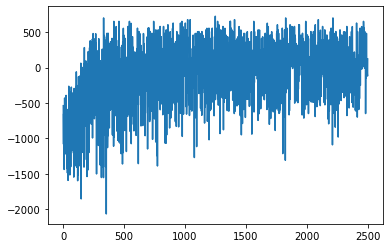

In [6]:
import matplotlib.pyplot as plt
import numpy as np
 #Plot the data\n
plt.plot(rewardstest)
# Show the plot\n",
plt.show()

In [7]:
print(rewardstest)

[-538, -969, -1080, -653, -1256, -553, -762, -1437, -835, -797, -851, -430, -731, -963, -930, -1022, -1187, -1213, -974, -1063, -683, -589, -1111, -393, -1104, -816, -1225, -1177, -863, -1423, -843, -1049, -720, -688, -1486, -670, -748, -1013, -931, -1591, -589, -1102, -861, -595, -1454, -264, -780, -1025, -533, -890, -647, -991, -618, -342, -1514, -435, -1364, -906, -890, -1047, -905, -1399, -530, -433, -679, -328, -276, -1161, -684, -515, -366, -580, -358, -917, -1170, -719, -531, -447, -843, -759, -816, -770, -575, -754, -1206, -738, -1545, -1145, -348, -295, -795, -449, -1067, -394, -1344, -1144, -1359, -715, -1386, -456, -1203, -1218, -697, -1139, -436, -902, -1025, -61, -663, -260, -866, -1406, -254, -958, -505, -686, -1295, -703, -1596, -800, -655, -1513, -1259, -569, -582, -129, -293, -1390, -761, -248, -722, -136, -618, -125, -560, -856, -307, -423, -1096, -691, -117, -1105, -210, -352, 61, -1252, -191, -1852, -908, -967, -436, -280, 5, -457, -564, -103, -191, -929, -284, -788

In [8]:
# Play the Game
rewards = []
arr = generate_random_numbers()
env = TrafficGenerator(0.3,0.4,0.4)

for episode in range(total_test_episodes):
    total_rewards = 0
    total_penalties = 0
    
    state = env.reset()
    print('='*40)
    print("[*] Episode", episode)
    print('='*40)

    for step in range(max_steps):
        env.render()
        action = np.argmax(qtable[state, :])
        state, reward, done, info = env.step(action)
        #print(reward)
        """"
        if reward == -10:
            total_penalties += 1
        else:
            total_rewards += reward
        """
        total_rewards += reward
        #print("total time: {}", env.totaltime)
        if done:
            rewards.append(total_rewards)
            print('[*] Score', total_rewards)
            break

env.close()
print('[*] Average Score: ' + str(sum(rewards) / total_test_episodes))

[*] Episode 0
[0.0, 0.0, 0.0]
[0.0, 0.0, 0.0]
[0.0, -1.0, -1.0]
[-1.0, -2.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-2.5, 0.0, 0.0]
[-2.0, -1.0, -1.0]
[-3.0, -2.0, 0.0]
[-2.5, -1.0, -1.0]
[-2.0, -2.0, -2.0]
[-3.0, -3.0, 0.0]
[0.0, -2.5, -1.0]
[-1.0, -2.0, -2.0]
[-2.0, -1.0, -2.0]
[-3.0, 0.0, -3.0]
[-2.5, 0.0, -3.0]
[-2.0, -1.0, -2.5]
[0.0, -2.0, -3.5]
[-1.0, -2.0, -2.0]
[-2.0, -2.0, -3.0]
[-3.0, -3.0, -3.0]
[0.0, -2.5, -2.5]
[-1.0, -2.0, -3.5]
[0.0, -2.0, -3.3]
[0.0, -2.0, -4.3]
[-1.0, -3.0, -4.0]
[0.0, -2.5, -3.7]
[0.0, -2.0, -4.7]
[-1.0, -1.0, -4.5]
[0.0, -2.0, -5.5]
[0.0, 0.0, -6.5]
[0.0, -1.0, -5.0]
[-1.0, 0.0, -6.0]
[0.0, -1.0, -5.8]
[0.0, 0.0, -6.8]
[-1.0, 0.0, -6.5]
[-2.0, -1.0, -5.0]
[0.0, -2.0, -6.0]
[-1.0, -1.0, -5.8]
[0.0, -2.0, -6.8]
[0.0, 0.0, -7.8]
[0.0, -1.0, -6.2]
[-1.0, 0.0, -7.2]
[0.0, -1.0, -7.0]
[0.0, 0.0, -8.0]
[-1.0, 0.0, -7.8]
[0.0, -1.0, -7.5]
[0.0, 0.0, -8.5]
[-1.0, -1.0, -7.0]
[0.0, -2.0, -8.0]
[0.0, 0.0, -9.0]
[0.0, -1.0, -7.5]
[-1.0, 0.0, -8.5]
[0.0, -1.